In [1]:
#Imports

from keras import layers
from keras.models import Model
from keras.models import load_model
from keras import callbacks
import os
import cv2
import string
import numpy as np
import matplotlib.pyplot as plt
import keras

from keras import backend as K
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization

from sklearn.metrics import confusion_matrix


In [2]:
#def create_net(num_symbols):
    
#    input_layer = layers.Input(shape=img_shape) 
#    x = Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu')(input_layer)
#    x = MaxPooling2D(pool_size=(2, 2))(x)

#    x = Conv2D(filters=48, kernel_size=(5, 5), padding='same', activation='relu')(x)
#    x = MaxPooling2D(pool_size=(2, 2))(x)

#    x = Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu')(x)
#    x = MaxPooling2D(pool_size=(2, 2))(x)

#    x = Dropout(0.3)(x)
#    x = Flatten()(x)
#    x = Dense(512, activation='relu')(x)
#    x = Dropout(0.3)(x)

#    out = [Dense(num_symbols, name='digit%d' % i, activation='softmax')(x) for i in range(5)]
#    model = Model(inputs=input_layer, outputs=out)

    # initiate Adam optimizer
#    opt = keras.optimizers.Adam(lr=0.0001, beta_1=0.99, beta_2=0.9999, epsilon=None, decay=0.0, amsgrad=False)
#    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

#    model.summary()    
    
#    return model

In [3]:

def create_net(num_symbols):

    # Camada de entrada
    img = layers.Input(shape=img_shape) 
    
    # Segunda camada - convolução com relu, podemos experimentar com sigma
    conv1 = layers.Conv2D(16, (3, 3), padding='valid', activation='relu', use_bias=True, kernel_initializer='glorot_uniform',bias_initializer='zeros')(img)    
    mp1 = layers.MaxPooling2D(padding='same')(conv1)
    
    # Terceira camada - convolução com relu, podemos experimentar com sigma
    conv2 = layers.Conv2D(32, (3, 3), padding='valid', activation='relu', use_bias=True, kernel_initializer='glorot_uniform',bias_initializer='zeros')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)
    
    # Quarta camada - convolução com relu, podemos experimentar com sigma
    conv3 = layers.Conv2D(32, (3, 3), padding='valid', activation='relu', use_bias=True, kernel_initializer='glorot_uniform',bias_initializer='zeros')(mp2)
    bn = layers.BatchNormalization()(conv3)
    
    # Camada de saída
    mp3 = layers.MaxPooling2D(padding='same')(bn) 
    flat = layers.Flatten()(mp3)
    
    outs = []
    for i in range(5):
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1)
        res = layers.Dense(num_symbols, name='digit%d' % i, activation='sigmoid')(drop)

        outs.append(res)
    
    model = Model(img, outs)
    model.compile('adam', loss=['categorical_crossentropy', 'categorical_crossentropy',
                                   'categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'], metrics=['accuracy'])
    model.summary()
    return model


# Leitura dos dados e treinamento em lote

In [4]:
def read_dataset_batch(symbols, batch_files, captcha_dir = 'images/dataset'):
    
    num_symbols = len(symbols)
    n_samples = len(batch_files)
    #X = np.zeros((n_samples, 50, 200, 1))
    #X = np.zeros((n_samples, 60, 160, 1))
    X = np.zeros((n_samples, 30, 80, 1))
    y = np.zeros((5, n_samples, num_symbols))

    for i in range(n_samples):
        
        pic = batch_files[i];
        img = cv2.imread(os.path.join(captcha_dir, pic), cv2.IMREAD_GRAYSCALE)
        #img = cv2.imread(pic, cv2.IMREAD_GRAYSCALE)
        #print(captcha_dir);
        pic_target = pic[:-4] # retira o .png
        #print(pic_target);
        #print(img);
        # Se nome do arquivo da imagem tem até 5 caracteres
        if len(pic_target) < 6:
            
            # Coloca o valor dos pixels entre 0 e 1
            img = img / 255.
            #print(img.shape)
            img = cv2.resize(img, (int(160/2), int(60/2)), interpolation=cv2.INTER_AREA)
            #print(img.shape)
            img = np.reshape(img, (img.shape[0], img.shape[1], 1))
            #img = np.reshape(img, (30, 80, 1))
            # cada captcha possui 5 caracteres
            targs = np.zeros((5, num_symbols))
            
            # Seta a sequência de letras alvo
            # O Alvo será uma matriz de todos símbolos pelas 5 posições presentes no captcha.
            # Se aquela posição corresponde aquele símbolo o valor da célula será 1, e 0 caso contrário.
            for j, l in enumerate(pic_target):
                ind = symbols.find(l)
                targs[j, ind] = 1
                
            X[i] = img
            y[:, i] = targs
            
            if(i%1000 == 0):
                print(str(i) + " imagens read");

    return X, y

In [5]:
def read_name_files(files_dir = 'images/dataset'):

    folders = []

    # r=root, d=directories, f = files
    for r, d, f in os.walk(files_dir):
        # Nada
        s = "nada";
    return f

In [6]:
files = read_name_files()
print(len(files))

99994


In [7]:
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

In [8]:


def concat_history(history):
    
    global digit_acc, val_digit_acc, loss, val_loss
    
    digit_acc_now = [history.history['digit%d_accuracy' % i] for i in range(5)];
    val_digit_acc_now = [history.history['val_digit%d_accuracy' % i] for i in range(5)];
    loss_now = history.history['loss'];
    val_loss_now = history.history['val_loss'];    
    
    for i in range(5):
        digit_acc[i].extend(digit_acc_now[i])
        val_digit_acc[i].extend(val_digit_acc_now[i])
    loss.extend(loss_now)
    val_loss.extend(val_loss_now)

In [9]:
# Salva Pesos
from keras.callbacks import ModelCheckpoint

# checkpoint
outputFolder = './output-captcha'
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
filepath=outputFolder+"/weights-{epoch:02d}-{loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, \
                             save_best_only=False, save_weights_only=True, \
                             mode='auto', save_freq=10)
callbacks_list = [checkpoint]


In [10]:
symbols = string.ascii_lowercase + string.ascii_uppercase + "0123456789"
#img_shape = (60, 160, 1)
img_shape = (30, 80, 1)
net = create_net(len(symbols))

# Estatísticas
digit_acc = [[] for _ in range(5)]
val_digit_acc = [[] for _ in range(5)]
loss = []
val_loss = []

i = 1;
for batch_files in batch(files, 1000):    
    X_train, y_train = read_dataset_batch(symbols, batch_files)
    #print(X_train.shape())
    print("Inicio Treino #", str(i));
    i = i + 1
    history = net.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]], epochs=50, validation_split=0.2, batch_size=100, callbacks=callbacks_list)
    concat_history(history);

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30, 80, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 78, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 14, 39, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 12, 37, 32)   4640        max_pooling2d[0][0]              
______________________________________________________________________________________________

5/8 [=================>............] - ETA: 0s - loss: 20.4908 - digit0_loss: 4.0903 - digit1_loss: 4.0915 - digit2_loss: 4.1017 - digit3_loss: 4.1002 - digit4_loss: 4.1070 - digit0_accuracy: 0.0200 - digit1_accuracy: 0.0300 - digit2_accuracy: 0.0160 - digit3_accuracy: 0.0400 - digit4_accuracy: 0.0240
Epoch 00004: saving model to ./output-captcha/weights-04-20.49.hdf5
8/8 [==============================] - 1s 82ms/step - loss: 20.4835 - digit0_loss: 4.0988 - digit1_loss: 4.0884 - digit2_loss: 4.0995 - digit3_loss: 4.0960 - digit4_loss: 4.1009 - digit0_accuracy: 0.0237 - digit1_accuracy: 0.0300 - digit2_accuracy: 0.0175 - digit3_accuracy: 0.0388 - digit4_accuracy: 0.0250 - val_loss: 20.6383 - val_digit0_loss: 4.1246 - val_digit1_loss: 4.1289 - val_digit2_loss: 4.1368 - val_digit3_loss: 4.1230 - val_digit4_loss: 4.1251 - val_digit0_accuracy: 0.0300 - val_digit1_accuracy: 0.0150 - val_digit2_accuracy: 0.0100 - val_digit3_accuracy: 0.0050 - val_digit4_accuracy: 0.0200
Epoch 5/50
7/8 [=====

3/8 [==========>...................] - ETA: 0s - loss: 19.3285 - digit0_loss: 3.8806 - digit1_loss: 3.8160 - digit2_loss: 3.8513 - digit3_loss: 3.9117 - digit4_loss: 3.8689 - digit0_accuracy: 0.0733 - digit1_accuracy: 0.0633 - digit2_accuracy: 0.0733 - digit3_accuracy: 0.0500 - digit4_accuracy: 0.0800
Epoch 00013: saving model to ./output-captcha/weights-13-19.31.hdf5
8/8 [==============================] - 1s 82ms/step - loss: 19.2356 - digit0_loss: 3.8464 - digit1_loss: 3.8363 - digit2_loss: 3.8225 - digit3_loss: 3.8783 - digit4_loss: 3.8522 - digit0_accuracy: 0.0763 - digit1_accuracy: 0.0625 - digit2_accuracy: 0.0750 - digit3_accuracy: 0.0600 - digit4_accuracy: 0.0887 - val_loss: 21.2250 - val_digit0_loss: 4.1636 - val_digit1_loss: 4.3287 - val_digit2_loss: 4.3169 - val_digit3_loss: 4.2442 - val_digit4_loss: 4.1717 - val_digit0_accuracy: 0.0100 - val_digit1_accuracy: 0.0250 - val_digit2_accuracy: 0.0200 - val_digit3_accuracy: 0.0100 - val_digit4_accuracy: 0.0250
Epoch 14/50
5/8 [====

1/8 [==>...........................] - ETA: 0s - loss: 16.9870 - digit0_loss: 3.4564 - digit1_loss: 3.3646 - digit2_loss: 3.3771 - digit3_loss: 3.4321 - digit4_loss: 3.3568 - digit0_accuracy: 0.1800 - digit1_accuracy: 0.1000 - digit2_accuracy: 0.1400 - digit3_accuracy: 0.1600 - digit4_accuracy: 0.1500
Epoch 00022: saving model to ./output-captcha/weights-22-17.12.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 17.1765 - digit0_loss: 3.4453 - digit1_loss: 3.4387 - digit2_loss: 3.4276 - digit3_loss: 3.4638 - digit4_loss: 3.4011 - digit0_accuracy: 0.1138 - digit1_accuracy: 0.1138 - digit2_accuracy: 0.1150 - digit3_accuracy: 0.1250 - digit4_accuracy: 0.1325 - val_loss: 22.3433 - val_digit0_loss: 4.2094 - val_digit1_loss: 4.6187 - val_digit2_loss: 4.6322 - val_digit3_loss: 4.6463 - val_digit4_loss: 4.2367 - val_digit0_accuracy: 0.0100 - val_digit1_accuracy: 0.0250 - val_digit2_accuracy: 0.0200 - val_digit3_accuracy: 0.0100 - val_digit4_accuracy: 0.0200
Epoch 23/50
3/8 [====

8/8 [==============================] - 1s 86ms/step - loss: 15.0914 - digit0_loss: 3.0309 - digit1_loss: 3.0725 - digit2_loss: 2.9935 - digit3_loss: 3.0694 - digit4_loss: 2.9251 - digit0_accuracy: 0.1975 - digit1_accuracy: 0.1825 - digit2_accuracy: 0.2138 - digit3_accuracy: 0.1887 - digit4_accuracy: 0.2288 - val_loss: 22.9464 - val_digit0_loss: 4.2418 - val_digit1_loss: 4.6846 - val_digit2_loss: 4.9418 - val_digit3_loss: 4.8076 - val_digit4_loss: 4.2705 - val_digit0_accuracy: 0.0150 - val_digit1_accuracy: 0.0100 - val_digit2_accuracy: 0.0250 - val_digit3_accuracy: 0.0150 - val_digit4_accuracy: 0.0200
Epoch 31/50
8/8 [==============================] - 1s 71ms/step - loss: 14.8002 - digit0_loss: 2.9881 - digit1_loss: 3.0335 - digit2_loss: 2.9242 - digit3_loss: 2.9954 - digit4_loss: 2.8590 - digit0_accuracy: 0.1950 - digit1_accuracy: 0.1963 - digit2_accuracy: 0.2037 - digit3_accuracy: 0.2125 - digit4_accuracy: 0.2463 - val_loss: 22.0078 - val_digit0_loss: 4.1746 - val_digit1_loss: 4.4378 

8/8 [==============================] - 1s 91ms/step - loss: 12.8342 - digit0_loss: 2.5707 - digit1_loss: 2.6184 - digit2_loss: 2.5253 - digit3_loss: 2.6756 - digit4_loss: 2.4442 - digit0_accuracy: 0.2900 - digit1_accuracy: 0.2950 - digit2_accuracy: 0.3175 - digit3_accuracy: 0.2850 - digit4_accuracy: 0.3088 - val_loss: 21.7279 - val_digit0_loss: 4.2080 - val_digit1_loss: 4.3756 - val_digit2_loss: 4.5324 - val_digit3_loss: 4.5572 - val_digit4_loss: 4.0546 - val_digit0_accuracy: 0.0400 - val_digit1_accuracy: 0.0250 - val_digit2_accuracy: 0.0150 - val_digit3_accuracy: 0.0150 - val_digit4_accuracy: 0.0500
Epoch 40/50
7/8 [=========================>....] - ETA: 0s - loss: 12.5134 - digit0_loss: 2.5413 - digit1_loss: 2.5605 - digit2_loss: 2.4917 - digit3_loss: 2.5809 - digit4_loss: 2.3390 - digit0_accuracy: 0.3000 - digit1_accuracy: 0.3014 - digit2_accuracy: 0.3229 - digit3_accuracy: 0.2714 - digit4_accuracy: 0.3443
Epoch 00040: saving model to ./output-captcha/weights-40-12.56.hdf5
8/8 [====

8/8 [==============================] - 1s 84ms/step - loss: 10.7527 - digit0_loss: 2.1645 - digit1_loss: 2.2139 - digit2_loss: 2.1551 - digit3_loss: 2.2060 - digit4_loss: 2.0133 - digit0_accuracy: 0.3800 - digit1_accuracy: 0.3750 - digit2_accuracy: 0.4075 - digit3_accuracy: 0.3837 - digit4_accuracy: 0.4238 - val_loss: 23.0702 - val_digit0_loss: 4.4705 - val_digit1_loss: 4.4028 - val_digit2_loss: 4.9807 - val_digit3_loss: 5.1764 - val_digit4_loss: 4.0398 - val_digit0_accuracy: 0.0300 - val_digit1_accuracy: 0.0400 - val_digit2_accuracy: 0.0500 - val_digit3_accuracy: 0.0100 - val_digit4_accuracy: 0.0600
Epoch 49/50
5/8 [=================>............] - ETA: 0s - loss: 10.7165 - digit0_loss: 2.1185 - digit1_loss: 2.1948 - digit2_loss: 2.2246 - digit3_loss: 2.2194 - digit4_loss: 1.9591 - digit0_accuracy: 0.3940 - digit1_accuracy: 0.3860 - digit2_accuracy: 0.3640 - digit3_accuracy: 0.4000 - digit4_accuracy: 0.4700
Epoch 00049: saving model to ./output-captcha/weights-49-10.69.hdf5
8/8 [====

8/8 [==============================] - 1s 80ms/step - loss: 18.7079 - digit0_loss: 3.7103 - digit1_loss: 3.7675 - digit2_loss: 3.8671 - digit3_loss: 3.7846 - digit4_loss: 3.5784 - digit0_accuracy: 0.0800 - digit1_accuracy: 0.0812 - digit2_accuracy: 0.0475 - digit3_accuracy: 0.0525 - digit4_accuracy: 0.1050 - val_loss: 50.6165 - val_digit0_loss: 8.9314 - val_digit1_loss: 8.7913 - val_digit2_loss: 10.0440 - val_digit3_loss: 12.2354 - val_digit4_loss: 10.6144 - val_digit0_accuracy: 0.0450 - val_digit1_accuracy: 0.0450 - val_digit2_accuracy: 0.0450 - val_digit3_accuracy: 0.0100 - val_digit4_accuracy: 0.0050
Epoch 8/50
3/8 [==========>...................] - ETA: 0s - loss: 18.4993 - digit0_loss: 3.6759 - digit1_loss: 3.7078 - digit2_loss: 3.7999 - digit3_loss: 3.7851 - digit4_loss: 3.5305 - digit0_accuracy: 0.0833 - digit1_accuracy: 0.1133 - digit2_accuracy: 0.0867 - digit3_accuracy: 0.0400 - digit4_accuracy: 0.1100
Epoch 00008: saving model to ./output-captcha/weights-08-18.51.hdf5
8/8 [==

8/8 [==============================] - 1s 69ms/step - loss: 16.5154 - digit0_loss: 3.2949 - digit1_loss: 3.3608 - digit2_loss: 3.5060 - digit3_loss: 3.3704 - digit4_loss: 2.9833 - digit0_accuracy: 0.1200 - digit1_accuracy: 0.1325 - digit2_accuracy: 0.0975 - digit3_accuracy: 0.1225 - digit4_accuracy: 0.1875 - val_loss: 39.2075 - val_digit0_loss: 8.9104 - val_digit1_loss: 6.0684 - val_digit2_loss: 6.9114 - val_digit3_loss: 8.2003 - val_digit4_loss: 9.1169 - val_digit0_accuracy: 0.0300 - val_digit1_accuracy: 0.0150 - val_digit2_accuracy: 0.0200 - val_digit3_accuracy: 0.0200 - val_digit4_accuracy: 0.0150
Epoch 17/50
1/8 [==>...........................] - ETA: 0s - loss: 16.6867 - digit0_loss: 3.2700 - digit1_loss: 3.4125 - digit2_loss: 3.5234 - digit3_loss: 3.4623 - digit4_loss: 3.0185 - digit0_accuracy: 0.1400 - digit1_accuracy: 0.1200 - digit2_accuracy: 0.0900 - digit3_accuracy: 0.1100 - digit4_accuracy: 0.1700
Epoch 00017: saving model to ./output-captcha/weights-17-16.49.hdf5
8/8 [====

7/8 [=========================>....] - ETA: 0s - loss: 14.6210 - digit0_loss: 2.8699 - digit1_loss: 2.9970 - digit2_loss: 3.2135 - digit3_loss: 2.9806 - digit4_loss: 2.5600 - digit0_accuracy: 0.2071 - digit1_accuracy: 0.1700 - digit2_accuracy: 0.1600 - digit3_accuracy: 0.1914 - digit4_accuracy: 0.3057
Epoch 00025: saving model to ./output-captcha/weights-25-14.61.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 14.6051 - digit0_loss: 2.8825 - digit1_loss: 2.9844 - digit2_loss: 3.2147 - digit3_loss: 2.9796 - digit4_loss: 2.5439 - digit0_accuracy: 0.2062 - digit1_accuracy: 0.1813 - digit2_accuracy: 0.1550 - digit3_accuracy: 0.1912 - digit4_accuracy: 0.2950 - val_loss: 21.5948 - val_digit0_loss: 3.9670 - val_digit1_loss: 4.6032 - val_digit2_loss: 4.7525 - val_digit3_loss: 4.1440 - val_digit4_loss: 4.1281 - val_digit0_accuracy: 0.0450 - val_digit1_accuracy: 0.0400 - val_digit2_accuracy: 0.0400 - val_digit3_accuracy: 0.0650 - val_digit4_accuracy: 0.0850
Epoch 26/50
8/8 [====

5/8 [=================>............] - ETA: 0s - loss: 12.9192 - digit0_loss: 2.5399 - digit1_loss: 2.6238 - digit2_loss: 2.9346 - digit3_loss: 2.6577 - digit4_loss: 2.1633 - digit0_accuracy: 0.2680 - digit1_accuracy: 0.2240 - digit2_accuracy: 0.1740 - digit3_accuracy: 0.2540 - digit4_accuracy: 0.3760
Epoch 00034: saving model to ./output-captcha/weights-34-13.00.hdf5
8/8 [==============================] - 1s 79ms/step - loss: 12.8639 - digit0_loss: 2.5364 - digit1_loss: 2.6131 - digit2_loss: 2.9001 - digit3_loss: 2.6613 - digit4_loss: 2.1530 - digit0_accuracy: 0.2825 - digit1_accuracy: 0.2562 - digit2_accuracy: 0.1925 - digit3_accuracy: 0.2475 - digit4_accuracy: 0.3750 - val_loss: 21.6763 - val_digit0_loss: 4.3924 - val_digit1_loss: 4.1488 - val_digit2_loss: 4.4631 - val_digit3_loss: 4.7710 - val_digit4_loss: 3.9010 - val_digit0_accuracy: 0.0700 - val_digit1_accuracy: 0.1250 - val_digit2_accuracy: 0.0700 - val_digit3_accuracy: 0.0300 - val_digit4_accuracy: 0.1250
Epoch 35/50
7/8 [====

3/8 [==========>...................] - ETA: 0s - loss: 11.0831 - digit0_loss: 2.1739 - digit1_loss: 2.3987 - digit2_loss: 2.4519 - digit3_loss: 2.2195 - digit4_loss: 1.8392 - digit0_accuracy: 0.4033 - digit1_accuracy: 0.3567 - digit2_accuracy: 0.3300 - digit3_accuracy: 0.3567 - digit4_accuracy: 0.4367
Epoch 00043: saving model to ./output-captcha/weights-43-11.13.hdf5
8/8 [==============================] - 1s 99ms/step - loss: 11.0624 - digit0_loss: 2.2062 - digit1_loss: 2.2794 - digit2_loss: 2.4933 - digit3_loss: 2.2420 - digit4_loss: 1.8415 - digit0_accuracy: 0.3650 - digit1_accuracy: 0.3487 - digit2_accuracy: 0.2937 - digit3_accuracy: 0.3500 - digit4_accuracy: 0.4437 - val_loss: 26.2500 - val_digit0_loss: 5.1549 - val_digit1_loss: 5.0781 - val_digit2_loss: 5.5239 - val_digit3_loss: 5.5642 - val_digit4_loss: 4.9290 - val_digit0_accuracy: 0.0700 - val_digit1_accuracy: 0.0650 - val_digit2_accuracy: 0.0400 - val_digit3_accuracy: 0.0500 - val_digit4_accuracy: 0.0450
Epoch 44/50
5/8 [====

Epoch 2/50
1/8 [==>...........................] - ETA: 0s - loss: 19.0727 - digit0_loss: 3.7640 - digit1_loss: 3.8223 - digit2_loss: 4.0647 - digit3_loss: 4.0575 - digit4_loss: 3.3642 - digit0_accuracy: 0.0900 - digit1_accuracy: 0.1000 - digit2_accuracy: 0.0400 - digit3_accuracy: 0.0900 - digit4_accuracy: 0.1300
Epoch 00002: saving model to ./output-captcha/weights-02-19.11.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 18.6985 - digit0_loss: 3.6599 - digit1_loss: 3.8640 - digit2_loss: 3.8965 - digit3_loss: 3.8017 - digit4_loss: 3.4764 - digit0_accuracy: 0.0913 - digit1_accuracy: 0.0900 - digit2_accuracy: 0.0688 - digit3_accuracy: 0.0750 - digit4_accuracy: 0.0988 - val_loss: 66.6482 - val_digit0_loss: 12.0278 - val_digit1_loss: 13.4504 - val_digit2_loss: 14.9107 - val_digit3_loss: 12.7560 - val_digit4_loss: 13.5033 - val_digit0_accuracy: 0.0550 - val_digit1_accuracy: 0.0250 - val_digit2_accuracy: 0.0200 - val_digit3_accuracy: 0.0100 - val_digit4_accuracy: 0.0200
Epoch

8/8 [==============================] - 1s 72ms/step - loss: 15.5278 - digit0_loss: 3.0467 - digit1_loss: 3.2925 - digit2_loss: 3.2919 - digit3_loss: 3.2275 - digit4_loss: 2.6692 - digit0_accuracy: 0.1538 - digit1_accuracy: 0.1338 - digit2_accuracy: 0.1375 - digit3_accuracy: 0.1363 - digit4_accuracy: 0.2338 - val_loss: 26.5070 - val_digit0_loss: 5.3696 - val_digit1_loss: 5.8594 - val_digit2_loss: 5.7020 - val_digit3_loss: 5.4186 - val_digit4_loss: 4.1574 - val_digit0_accuracy: 0.1100 - val_digit1_accuracy: 0.0900 - val_digit2_accuracy: 0.0400 - val_digit3_accuracy: 0.0550 - val_digit4_accuracy: 0.1250
Epoch 11/50
8/8 [==============================] - 1s 65ms/step - loss: 15.3336 - digit0_loss: 2.9523 - digit1_loss: 3.2765 - digit2_loss: 3.2670 - digit3_loss: 3.1004 - digit4_loss: 2.7374 - digit0_accuracy: 0.1850 - digit1_accuracy: 0.1475 - digit2_accuracy: 0.1275 - digit3_accuracy: 0.1725 - digit4_accuracy: 0.2300 - val_loss: 26.3491 - val_digit0_loss: 4.6703 - val_digit1_loss: 6.1705 

8/8 [==============================] - 1s 72ms/step - loss: 13.1750 - digit0_loss: 2.5378 - digit1_loss: 2.8183 - digit2_loss: 2.8729 - digit3_loss: 2.7168 - digit4_loss: 2.2292 - digit0_accuracy: 0.2825 - digit1_accuracy: 0.1950 - digit2_accuracy: 0.1988 - digit3_accuracy: 0.2075 - digit4_accuracy: 0.3413 - val_loss: 20.8793 - val_digit0_loss: 3.8453 - val_digit1_loss: 4.4062 - val_digit2_loss: 4.5545 - val_digit3_loss: 4.3056 - val_digit4_loss: 3.7678 - val_digit0_accuracy: 0.0850 - val_digit1_accuracy: 0.1250 - val_digit2_accuracy: 0.0800 - val_digit3_accuracy: 0.0700 - val_digit4_accuracy: 0.0900
Epoch 20/50
7/8 [=========================>....] - ETA: 0s - loss: 13.2006 - digit0_loss: 2.4504 - digit1_loss: 2.8244 - digit2_loss: 2.8580 - digit3_loss: 2.7722 - digit4_loss: 2.2956 - digit0_accuracy: 0.2814 - digit1_accuracy: 0.2186 - digit2_accuracy: 0.2057 - digit3_accuracy: 0.2071 - digit4_accuracy: 0.2929
Epoch 00020: saving model to ./output-captcha/weights-20-13.15.hdf5
8/8 [====

8/8 [==============================] - 1s 71ms/step - loss: 11.4829 - digit0_loss: 2.2065 - digit1_loss: 2.4960 - digit2_loss: 2.4844 - digit3_loss: 2.3674 - digit4_loss: 1.9286 - digit0_accuracy: 0.3400 - digit1_accuracy: 0.3050 - digit2_accuracy: 0.2825 - digit3_accuracy: 0.3237 - digit4_accuracy: 0.4288 - val_loss: 21.8342 - val_digit0_loss: 3.8040 - val_digit1_loss: 4.4441 - val_digit2_loss: 4.6169 - val_digit3_loss: 5.0147 - val_digit4_loss: 3.9546 - val_digit0_accuracy: 0.1200 - val_digit1_accuracy: 0.1450 - val_digit2_accuracy: 0.0700 - val_digit3_accuracy: 0.0650 - val_digit4_accuracy: 0.0950
Epoch 29/50
5/8 [=================>............] - ETA: 0s - loss: 11.3671 - digit0_loss: 2.1087 - digit1_loss: 2.4408 - digit2_loss: 2.4898 - digit3_loss: 2.4344 - digit4_loss: 1.8934 - digit0_accuracy: 0.3360 - digit1_accuracy: 0.2940 - digit2_accuracy: 0.3040 - digit3_accuracy: 0.3020 - digit4_accuracy: 0.4180
Epoch 00029: saving model to ./output-captcha/weights-29-11.37.hdf5
8/8 [====

8/8 [==============================] - 1s 72ms/step - loss: 9.9784 - digit0_loss: 1.9239 - digit1_loss: 2.1941 - digit2_loss: 2.1154 - digit3_loss: 2.1487 - digit4_loss: 1.5964 - digit0_accuracy: 0.4125 - digit1_accuracy: 0.3487 - digit2_accuracy: 0.3825 - digit3_accuracy: 0.3525 - digit4_accuracy: 0.5050 - val_loss: 36.2804 - val_digit0_loss: 7.3684 - val_digit1_loss: 6.3630 - val_digit2_loss: 8.7449 - val_digit3_loss: 6.1076 - val_digit4_loss: 7.6965 - val_digit0_accuracy: 0.1000 - val_digit1_accuracy: 0.0550 - val_digit2_accuracy: 0.0300 - val_digit3_accuracy: 0.0500 - val_digit4_accuracy: 0.0700
Epoch 38/50
3/8 [==========>...................] - ETA: 0s - loss: 9.7828 - digit0_loss: 1.7683 - digit1_loss: 2.2080 - digit2_loss: 2.0704 - digit3_loss: 2.1043 - digit4_loss: 1.6317 - digit0_accuracy: 0.4700 - digit1_accuracy: 0.3367 - digit2_accuracy: 0.3800 - digit3_accuracy: 0.3833 - digit4_accuracy: 0.5200
Epoch 00038: saving model to ./output-captcha/weights-38-9.87.hdf5
8/8 [=======

8/8 [==============================] - 1s 67ms/step - loss: 8.6747 - digit0_loss: 1.6276 - digit1_loss: 1.9009 - digit2_loss: 1.8960 - digit3_loss: 1.8266 - digit4_loss: 1.4236 - digit0_accuracy: 0.4650 - digit1_accuracy: 0.4412 - digit2_accuracy: 0.4338 - digit3_accuracy: 0.4737 - digit4_accuracy: 0.5638 - val_loss: 20.6000 - val_digit0_loss: 3.6252 - val_digit1_loss: 4.7686 - val_digit2_loss: 4.2786 - val_digit3_loss: 4.3224 - val_digit4_loss: 3.6052 - val_digit0_accuracy: 0.1500 - val_digit1_accuracy: 0.1200 - val_digit2_accuracy: 0.0750 - val_digit3_accuracy: 0.1250 - val_digit4_accuracy: 0.1400
Epoch 47/50
1/8 [==>...........................] - ETA: 0s - loss: 8.2081 - digit0_loss: 1.5573 - digit1_loss: 1.9067 - digit2_loss: 1.5745 - digit3_loss: 1.7906 - digit4_loss: 1.3792 - digit0_accuracy: 0.4700 - digit1_accuracy: 0.3800 - digit2_accuracy: 0.5300 - digit3_accuracy: 0.5100 - digit4_accuracy: 0.5700
Epoch 00047: saving model to ./output-captcha/weights-47-8.38.hdf5
8/8 [=======

Epoch 5/50
7/8 [=========================>....] - ETA: 0s - loss: 15.8958 - digit0_loss: 3.0283 - digit1_loss: 3.3843 - digit2_loss: 3.5166 - digit3_loss: 3.3019 - digit4_loss: 2.6647 - digit0_accuracy: 0.1843 - digit1_accuracy: 0.1443 - digit2_accuracy: 0.0914 - digit3_accuracy: 0.1300 - digit4_accuracy: 0.2143
Epoch 00005: saving model to ./output-captcha/weights-05-15.94.hdf5
8/8 [==============================] - 1s 69ms/step - loss: 15.9358 - digit0_loss: 3.0258 - digit1_loss: 3.3902 - digit2_loss: 3.5285 - digit3_loss: 3.3036 - digit4_loss: 2.6877 - digit0_accuracy: 0.1838 - digit1_accuracy: 0.1437 - digit2_accuracy: 0.0875 - digit3_accuracy: 0.1287 - digit4_accuracy: 0.2175 - val_loss: 62.5821 - val_digit0_loss: 12.3001 - val_digit1_loss: 12.3774 - val_digit2_loss: 11.3358 - val_digit3_loss: 13.0778 - val_digit4_loss: 13.4909 - val_digit0_accuracy: 0.0350 - val_digit1_accuracy: 0.0250 - val_digit2_accuracy: 0.0500 - val_digit3_accuracy: 0.0100 - val_digit4_accuracy: 0.0500
Epoch

5/8 [=================>............] - ETA: 0s - loss: 12.9674 - digit0_loss: 2.3927 - digit1_loss: 2.7967 - digit2_loss: 2.9700 - digit3_loss: 2.7187 - digit4_loss: 2.0893 - digit0_accuracy: 0.2860 - digit1_accuracy: 0.2220 - digit2_accuracy: 0.1760 - digit3_accuracy: 0.2280 - digit4_accuracy: 0.3480
Epoch 00014: saving model to ./output-captcha/weights-14-12.99.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 12.9730 - digit0_loss: 2.4057 - digit1_loss: 2.8404 - digit2_loss: 2.9829 - digit3_loss: 2.7171 - digit4_loss: 2.0269 - digit0_accuracy: 0.2812 - digit1_accuracy: 0.2075 - digit2_accuracy: 0.1813 - digit3_accuracy: 0.2350 - digit4_accuracy: 0.3800 - val_loss: 21.4509 - val_digit0_loss: 3.7953 - val_digit1_loss: 4.9739 - val_digit2_loss: 4.9785 - val_digit3_loss: 4.1154 - val_digit4_loss: 3.5878 - val_digit0_accuracy: 0.1400 - val_digit1_accuracy: 0.1250 - val_digit2_accuracy: 0.0450 - val_digit3_accuracy: 0.1150 - val_digit4_accuracy: 0.1900
Epoch 15/50
7/8 [====

3/8 [==========>...................] - ETA: 0s - loss: 10.8492 - digit0_loss: 2.0362 - digit1_loss: 2.3732 - digit2_loss: 2.5329 - digit3_loss: 2.3593 - digit4_loss: 1.5476 - digit0_accuracy: 0.3967 - digit1_accuracy: 0.3067 - digit2_accuracy: 0.2467 - digit3_accuracy: 0.2833 - digit4_accuracy: 0.4767
Epoch 00023: saving model to ./output-captcha/weights-23-10.85.hdf5
8/8 [==============================] - 1s 73ms/step - loss: 10.9010 - digit0_loss: 2.0505 - digit1_loss: 2.3514 - digit2_loss: 2.5574 - digit3_loss: 2.3810 - digit4_loss: 1.5606 - digit0_accuracy: 0.3825 - digit1_accuracy: 0.3075 - digit2_accuracy: 0.2463 - digit3_accuracy: 0.2925 - digit4_accuracy: 0.4787 - val_loss: 21.7401 - val_digit0_loss: 4.1116 - val_digit1_loss: 4.9511 - val_digit2_loss: 4.6250 - val_digit3_loss: 4.5229 - val_digit4_loss: 3.5295 - val_digit0_accuracy: 0.1600 - val_digit1_accuracy: 0.1050 - val_digit2_accuracy: 0.0950 - val_digit3_accuracy: 0.1100 - val_digit4_accuracy: 0.2450
Epoch 24/50
5/8 [====

1/8 [==>...........................] - ETA: 0s - loss: 9.0330 - digit0_loss: 1.6858 - digit1_loss: 1.9335 - digit2_loss: 2.2354 - digit3_loss: 1.9484 - digit4_loss: 1.2301 - digit0_accuracy: 0.4500 - digit1_accuracy: 0.4400 - digit2_accuracy: 0.3200 - digit3_accuracy: 0.4200 - digit4_accuracy: 0.6100
Epoch 00032: saving model to ./output-captcha/weights-32-9.12.hdf5
8/8 [==============================] - 1s 75ms/step - loss: 9.4328 - digit0_loss: 1.7158 - digit1_loss: 2.0378 - digit2_loss: 2.2327 - digit3_loss: 2.0504 - digit4_loss: 1.3961 - digit0_accuracy: 0.4588 - digit1_accuracy: 0.4000 - digit2_accuracy: 0.3338 - digit3_accuracy: 0.3738 - digit4_accuracy: 0.5425 - val_loss: 24.0312 - val_digit0_loss: 4.1792 - val_digit1_loss: 4.8015 - val_digit2_loss: 6.0651 - val_digit3_loss: 5.0307 - val_digit4_loss: 3.9547 - val_digit0_accuracy: 0.1100 - val_digit1_accuracy: 0.1000 - val_digit2_accuracy: 0.0450 - val_digit3_accuracy: 0.0800 - val_digit4_accuracy: 0.2100
Epoch 33/50
3/8 [=======

8/8 [==============================] - 1s 70ms/step - loss: 8.2328 - digit0_loss: 1.4923 - digit1_loss: 1.8059 - digit2_loss: 1.9678 - digit3_loss: 1.8112 - digit4_loss: 1.1555 - digit0_accuracy: 0.5050 - digit1_accuracy: 0.4350 - digit2_accuracy: 0.4150 - digit3_accuracy: 0.4450 - digit4_accuracy: 0.6288 - val_loss: 31.7323 - val_digit0_loss: 6.8137 - val_digit1_loss: 6.1657 - val_digit2_loss: 6.7500 - val_digit3_loss: 6.0344 - val_digit4_loss: 5.9685 - val_digit0_accuracy: 0.0450 - val_digit1_accuracy: 0.0550 - val_digit2_accuracy: 0.0300 - val_digit3_accuracy: 0.0650 - val_digit4_accuracy: 0.1100
Epoch 41/50
8/8 [==============================] - 1s 65ms/step - loss: 8.1743 - digit0_loss: 1.5571 - digit1_loss: 1.7578 - digit2_loss: 1.9479 - digit3_loss: 1.7982 - digit4_loss: 1.1133 - digit0_accuracy: 0.5138 - digit1_accuracy: 0.4512 - digit2_accuracy: 0.4025 - digit3_accuracy: 0.4487 - digit4_accuracy: 0.6363 - val_loss: 24.4656 - val_digit0_loss: 4.8334 - val_digit1_loss: 5.1098 - 

8/8 [==============================] - 1s 75ms/step - loss: 7.2550 - digit0_loss: 1.3093 - digit1_loss: 1.5477 - digit2_loss: 1.7641 - digit3_loss: 1.5563 - digit4_loss: 1.0775 - digit0_accuracy: 0.6012 - digit1_accuracy: 0.5263 - digit2_accuracy: 0.4437 - digit3_accuracy: 0.5250 - digit4_accuracy: 0.6513 - val_loss: 45.1155 - val_digit0_loss: 10.0586 - val_digit1_loss: 7.1581 - val_digit2_loss: 9.4717 - val_digit3_loss: 9.4681 - val_digit4_loss: 8.9591 - val_digit0_accuracy: 0.0250 - val_digit1_accuracy: 0.0650 - val_digit2_accuracy: 0.0550 - val_digit3_accuracy: 0.0350 - val_digit4_accuracy: 0.0900
Epoch 50/50
7/8 [=========================>....] - ETA: 0s - loss: 7.1763 - digit0_loss: 1.3470 - digit1_loss: 1.5426 - digit2_loss: 1.6472 - digit3_loss: 1.5724 - digit4_loss: 1.0672 - digit0_accuracy: 0.5786 - digit1_accuracy: 0.5229 - digit2_accuracy: 0.4686 - digit3_accuracy: 0.5371 - digit4_accuracy: 0.6457
Epoch 00050: saving model to ./output-captcha/weights-50-7.15.hdf5
8/8 [======

8/8 [==============================] - 1s 67ms/step - loss: 14.0605 - digit0_loss: 2.5408 - digit1_loss: 3.1321 - digit2_loss: 3.1765 - digit3_loss: 3.0508 - digit4_loss: 2.1603 - digit0_accuracy: 0.2650 - digit1_accuracy: 0.1875 - digit2_accuracy: 0.1462 - digit3_accuracy: 0.1988 - digit4_accuracy: 0.3500 - val_loss: 22.1454 - val_digit0_loss: 4.5158 - val_digit1_loss: 4.3808 - val_digit2_loss: 4.6369 - val_digit3_loss: 4.8004 - val_digit4_loss: 3.8115 - val_digit0_accuracy: 0.1850 - val_digit1_accuracy: 0.0750 - val_digit2_accuracy: 0.1000 - val_digit3_accuracy: 0.1050 - val_digit4_accuracy: 0.2100
Epoch 9/50
5/8 [=================>............] - ETA: 0s - loss: 13.7914 - digit0_loss: 2.4856 - digit1_loss: 3.0449 - digit2_loss: 3.2356 - digit3_loss: 2.9880 - digit4_loss: 2.0372 - digit0_accuracy: 0.2600 - digit1_accuracy: 0.1980 - digit2_accuracy: 0.1420 - digit3_accuracy: 0.1860 - digit4_accuracy: 0.3720
Epoch 00009: saving model to ./output-captcha/weights-09-13.70.hdf5
8/8 [=====

8/8 [==============================] - 1s 71ms/step - loss: 11.5378 - digit0_loss: 2.0655 - digit1_loss: 2.5744 - digit2_loss: 2.7413 - digit3_loss: 2.5431 - digit4_loss: 1.6136 - digit0_accuracy: 0.3500 - digit1_accuracy: 0.2612 - digit2_accuracy: 0.2400 - digit3_accuracy: 0.2525 - digit4_accuracy: 0.4688 - val_loss: 22.4830 - val_digit0_loss: 4.3831 - val_digit1_loss: 6.2535 - val_digit2_loss: 4.7479 - val_digit3_loss: 3.8955 - val_digit4_loss: 3.2028 - val_digit0_accuracy: 0.1250 - val_digit1_accuracy: 0.0600 - val_digit2_accuracy: 0.1000 - val_digit3_accuracy: 0.1650 - val_digit4_accuracy: 0.2300
Epoch 18/50
3/8 [==========>...................] - ETA: 0s - loss: 11.0368 - digit0_loss: 1.9905 - digit1_loss: 2.5080 - digit2_loss: 2.6068 - digit3_loss: 2.3716 - digit4_loss: 1.5599 - digit0_accuracy: 0.3500 - digit1_accuracy: 0.3200 - digit2_accuracy: 0.2467 - digit3_accuracy: 0.3133 - digit4_accuracy: 0.4933
Epoch 00018: saving model to ./output-captcha/weights-18-11.06.hdf5
8/8 [====

8/8 [==============================] - 1s 73ms/step - loss: 9.7816 - digit0_loss: 1.7040 - digit1_loss: 2.1989 - digit2_loss: 2.3840 - digit3_loss: 2.1510 - digit4_loss: 1.3437 - digit0_accuracy: 0.4575 - digit1_accuracy: 0.3537 - digit2_accuracy: 0.2988 - digit3_accuracy: 0.3650 - digit4_accuracy: 0.5713 - val_loss: 19.3319 - val_digit0_loss: 3.3465 - val_digit1_loss: 4.6647 - val_digit2_loss: 4.2324 - val_digit3_loss: 3.6363 - val_digit4_loss: 3.4521 - val_digit0_accuracy: 0.2150 - val_digit1_accuracy: 0.0950 - val_digit2_accuracy: 0.1100 - val_digit3_accuracy: 0.2150 - val_digit4_accuracy: 0.2500
Epoch 27/50
1/8 [==>...........................] - ETA: 0s - loss: 9.5202 - digit0_loss: 1.7172 - digit1_loss: 2.2873 - digit2_loss: 2.1893 - digit3_loss: 1.8888 - digit4_loss: 1.4376 - digit0_accuracy: 0.5200 - digit1_accuracy: 0.2900 - digit2_accuracy: 0.3800 - digit3_accuracy: 0.4900 - digit4_accuracy: 0.5200
Epoch 00027: saving model to ./output-captcha/weights-27-9.53.hdf5
8/8 [=======

7/8 [=========================>....] - ETA: 0s - loss: 8.4720 - digit0_loss: 1.5030 - digit1_loss: 1.9406 - digit2_loss: 2.0441 - digit3_loss: 1.8812 - digit4_loss: 1.1031 - digit0_accuracy: 0.5129 - digit1_accuracy: 0.4129 - digit2_accuracy: 0.3743 - digit3_accuracy: 0.4300 - digit4_accuracy: 0.6300
Epoch 00035: saving model to ./output-captcha/weights-35-8.47.hdf5
8/8 [==============================] - 1s 70ms/step - loss: 8.4714 - digit0_loss: 1.5187 - digit1_loss: 1.9170 - digit2_loss: 2.0373 - digit3_loss: 1.8989 - digit4_loss: 1.0995 - digit0_accuracy: 0.5013 - digit1_accuracy: 0.4162 - digit2_accuracy: 0.3812 - digit3_accuracy: 0.4250 - digit4_accuracy: 0.6275 - val_loss: 16.5356 - val_digit0_loss: 2.9322 - val_digit1_loss: 4.0848 - val_digit2_loss: 3.7564 - val_digit3_loss: 3.4851 - val_digit4_loss: 2.2771 - val_digit0_accuracy: 0.2950 - val_digit1_accuracy: 0.1400 - val_digit2_accuracy: 0.2050 - val_digit3_accuracy: 0.2650 - val_digit4_accuracy: 0.3700
Epoch 36/50
8/8 [=======

5/8 [=================>............] - ETA: 0s - loss: 7.4662 - digit0_loss: 1.2672 - digit1_loss: 1.6888 - digit2_loss: 1.9279 - digit3_loss: 1.6518 - digit4_loss: 0.9305 - digit0_accuracy: 0.5720 - digit1_accuracy: 0.4920 - digit2_accuracy: 0.4180 - digit3_accuracy: 0.4540 - digit4_accuracy: 0.6920
Epoch 00044: saving model to ./output-captcha/weights-44-7.52.hdf5
8/8 [==============================] - 1s 68ms/step - loss: 7.4912 - digit0_loss: 1.2855 - digit1_loss: 1.7038 - digit2_loss: 1.8977 - digit3_loss: 1.6436 - digit4_loss: 0.9606 - digit0_accuracy: 0.5700 - digit1_accuracy: 0.4675 - digit2_accuracy: 0.4363 - digit3_accuracy: 0.4825 - digit4_accuracy: 0.6787 - val_loss: 16.7723 - val_digit0_loss: 3.0935 - val_digit1_loss: 4.2143 - val_digit2_loss: 3.5469 - val_digit3_loss: 3.4096 - val_digit4_loss: 2.5080 - val_digit0_accuracy: 0.2500 - val_digit1_accuracy: 0.1150 - val_digit2_accuracy: 0.2100 - val_digit3_accuracy: 0.2300 - val_digit4_accuracy: 0.3600
Epoch 45/50
7/8 [=======

3/8 [==========>...................] - ETA: 0s - loss: 16.0030 - digit0_loss: 2.9189 - digit1_loss: 3.6160 - digit2_loss: 3.5673 - digit3_loss: 3.2903 - digit4_loss: 2.6105 - digit0_accuracy: 0.2033 - digit1_accuracy: 0.1267 - digit2_accuracy: 0.1700 - digit3_accuracy: 0.1667 - digit4_accuracy: 0.2700
Epoch 00003: saving model to ./output-captcha/weights-03-15.93.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 15.8144 - digit0_loss: 2.9593 - digit1_loss: 3.4895 - digit2_loss: 3.5493 - digit3_loss: 3.2797 - digit4_loss: 2.5366 - digit0_accuracy: 0.2025 - digit1_accuracy: 0.1262 - digit2_accuracy: 0.1338 - digit3_accuracy: 0.1550 - digit4_accuracy: 0.2812 - val_loss: 62.4677 - val_digit0_loss: 11.7377 - val_digit1_loss: 10.0994 - val_digit2_loss: 13.9468 - val_digit3_loss: 13.6444 - val_digit4_loss: 13.0395 - val_digit0_accuracy: 0.0650 - val_digit1_accuracy: 0.0400 - val_digit2_accuracy: 0.0500 - val_digit3_accuracy: 0.0250 - val_digit4_accuracy: 0.0500
Epoch 4/50
5/8 [

1/8 [==>...........................] - ETA: 0s - loss: 12.3887 - digit0_loss: 2.2382 - digit1_loss: 2.9274 - digit2_loss: 2.7986 - digit3_loss: 2.5860 - digit4_loss: 1.8384 - digit0_accuracy: 0.4300 - digit1_accuracy: 0.2000 - digit2_accuracy: 0.2600 - digit3_accuracy: 0.2700 - digit4_accuracy: 0.4800
Epoch 00012: saving model to ./output-captcha/weights-12-12.60.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 12.3912 - digit0_loss: 2.2342 - digit1_loss: 2.8091 - digit2_loss: 2.9819 - digit3_loss: 2.5520 - digit4_loss: 1.8141 - digit0_accuracy: 0.3325 - digit1_accuracy: 0.2275 - digit2_accuracy: 0.2000 - digit3_accuracy: 0.2550 - digit4_accuracy: 0.4238 - val_loss: 17.6784 - val_digit0_loss: 2.7698 - val_digit1_loss: 3.4714 - val_digit2_loss: 3.7549 - val_digit3_loss: 4.3403 - val_digit4_loss: 3.3420 - val_digit0_accuracy: 0.2350 - val_digit1_accuracy: 0.1650 - val_digit2_accuracy: 0.1250 - val_digit3_accuracy: 0.1300 - val_digit4_accuracy: 0.2350
Epoch 13/50
3/8 [====

8/8 [==============================] - 1s 72ms/step - loss: 10.1548 - digit0_loss: 1.8169 - digit1_loss: 2.3470 - digit2_loss: 2.4628 - digit3_loss: 2.1599 - digit4_loss: 1.3681 - digit0_accuracy: 0.4187 - digit1_accuracy: 0.3462 - digit2_accuracy: 0.2875 - digit3_accuracy: 0.3688 - digit4_accuracy: 0.5350 - val_loss: 24.7927 - val_digit0_loss: 4.1626 - val_digit1_loss: 4.9798 - val_digit2_loss: 5.9382 - val_digit3_loss: 5.6723 - val_digit4_loss: 4.0397 - val_digit0_accuracy: 0.2050 - val_digit1_accuracy: 0.1450 - val_digit2_accuracy: 0.1100 - val_digit3_accuracy: 0.1200 - val_digit4_accuracy: 0.2250
Epoch 21/50
8/8 [==============================] - 1s 65ms/step - loss: 10.0880 - digit0_loss: 1.7609 - digit1_loss: 2.3573 - digit2_loss: 2.4041 - digit3_loss: 2.1509 - digit4_loss: 1.4147 - digit0_accuracy: 0.4412 - digit1_accuracy: 0.3100 - digit2_accuracy: 0.3025 - digit3_accuracy: 0.3438 - digit4_accuracy: 0.5562 - val_loss: 19.9347 - val_digit0_loss: 3.2595 - val_digit1_loss: 4.1615 

8/8 [==============================] - 1s 70ms/step - loss: 8.6018 - digit0_loss: 1.5136 - digit1_loss: 1.9863 - digit2_loss: 2.0885 - digit3_loss: 1.8891 - digit4_loss: 1.1244 - digit0_accuracy: 0.5263 - digit1_accuracy: 0.4200 - digit2_accuracy: 0.3750 - digit3_accuracy: 0.4050 - digit4_accuracy: 0.6275 - val_loss: 18.3480 - val_digit0_loss: 3.0115 - val_digit1_loss: 4.1989 - val_digit2_loss: 4.3893 - val_digit3_loss: 4.1224 - val_digit4_loss: 2.6258 - val_digit0_accuracy: 0.2400 - val_digit1_accuracy: 0.1750 - val_digit2_accuracy: 0.1500 - val_digit3_accuracy: 0.1850 - val_digit4_accuracy: 0.3300
Epoch 30/50
7/8 [=========================>....] - ETA: 0s - loss: 8.7009 - digit0_loss: 1.5100 - digit1_loss: 2.0188 - digit2_loss: 2.0776 - digit3_loss: 1.9270 - digit4_loss: 1.1675 - digit0_accuracy: 0.5329 - digit1_accuracy: 0.3857 - digit2_accuracy: 0.3629 - digit3_accuracy: 0.4157 - digit4_accuracy: 0.6043
Epoch 00030: saving model to ./output-captcha/weights-30-8.69.hdf5
8/8 [=======

8/8 [==============================] - 1s 73ms/step - loss: 7.6190 - digit0_loss: 1.3416 - digit1_loss: 1.8159 - digit2_loss: 1.8736 - digit3_loss: 1.5716 - digit4_loss: 1.0163 - digit0_accuracy: 0.5700 - digit1_accuracy: 0.4425 - digit2_accuracy: 0.4200 - digit3_accuracy: 0.5000 - digit4_accuracy: 0.6600 - val_loss: 17.0556 - val_digit0_loss: 2.9310 - val_digit1_loss: 3.3643 - val_digit2_loss: 4.0315 - val_digit3_loss: 3.7116 - val_digit4_loss: 3.0172 - val_digit0_accuracy: 0.2650 - val_digit1_accuracy: 0.1800 - val_digit2_accuracy: 0.1400 - val_digit3_accuracy: 0.1500 - val_digit4_accuracy: 0.2750
Epoch 39/50
5/8 [=================>............] - ETA: 0s - loss: 7.4036 - digit0_loss: 1.2897 - digit1_loss: 1.7818 - digit2_loss: 1.8474 - digit3_loss: 1.5870 - digit4_loss: 0.8976 - digit0_accuracy: 0.5860 - digit1_accuracy: 0.4640 - digit2_accuracy: 0.4040 - digit3_accuracy: 0.5060 - digit4_accuracy: 0.7080
Epoch 00039: saving model to ./output-captcha/weights-39-7.50.hdf5
8/8 [=======

8/8 [==============================] - 1s 67ms/step - loss: 6.5768 - digit0_loss: 1.1532 - digit1_loss: 1.5688 - digit2_loss: 1.5774 - digit3_loss: 1.4714 - digit4_loss: 0.8061 - digit0_accuracy: 0.6225 - digit1_accuracy: 0.5050 - digit2_accuracy: 0.5038 - digit3_accuracy: 0.5337 - digit4_accuracy: 0.7287 - val_loss: 19.3209 - val_digit0_loss: 3.5058 - val_digit1_loss: 3.6239 - val_digit2_loss: 4.2162 - val_digit3_loss: 4.7565 - val_digit4_loss: 3.2185 - val_digit0_accuracy: 0.2200 - val_digit1_accuracy: 0.2150 - val_digit2_accuracy: 0.2000 - val_digit3_accuracy: 0.1500 - val_digit4_accuracy: 0.2850
Epoch 48/50
3/8 [==========>...................] - ETA: 0s - loss: 6.4800 - digit0_loss: 1.1644 - digit1_loss: 1.4897 - digit2_loss: 1.5440 - digit3_loss: 1.3769 - digit4_loss: 0.9050 - digit0_accuracy: 0.6000 - digit1_accuracy: 0.5367 - digit2_accuracy: 0.5133 - digit3_accuracy: 0.5833 - digit4_accuracy: 0.6867
Epoch 00048: saving model to ./output-captcha/weights-48-6.46.hdf5
8/8 [=======

Epoch 6/50
8/8 [==============================] - 1s 67ms/step - loss: 13.8736 - digit0_loss: 2.4103 - digit1_loss: 3.1551 - digit2_loss: 3.2058 - digit3_loss: 3.1188 - digit4_loss: 1.9836 - digit0_accuracy: 0.2887 - digit1_accuracy: 0.1863 - digit2_accuracy: 0.1450 - digit3_accuracy: 0.1850 - digit4_accuracy: 0.3938 - val_loss: 55.3496 - val_digit0_loss: 10.4029 - val_digit1_loss: 9.1801 - val_digit2_loss: 13.4139 - val_digit3_loss: 10.5511 - val_digit4_loss: 11.8016 - val_digit0_accuracy: 0.0750 - val_digit1_accuracy: 0.0550 - val_digit2_accuracy: 0.0350 - val_digit3_accuracy: 0.0800 - val_digit4_accuracy: 0.0400
Epoch 7/50
1/8 [==>...........................] - ETA: 0s - loss: 13.4844 - digit0_loss: 2.2472 - digit1_loss: 2.9707 - digit2_loss: 3.2043 - digit3_loss: 2.8546 - digit4_loss: 2.2075 - digit0_accuracy: 0.3200 - digit1_accuracy: 0.2000 - digit2_accuracy: 0.1200 - digit3_accuracy: 0.1800 - digit4_accuracy: 0.3300
Epoch 00007: saving model to ./output-captcha/weights-07-13.48.

7/8 [=========================>....] - ETA: 0s - loss: 10.9768 - digit0_loss: 1.8717 - digit1_loss: 2.4813 - digit2_loss: 2.6031 - digit3_loss: 2.4928 - digit4_loss: 1.5280 - digit0_accuracy: 0.4200 - digit1_accuracy: 0.3086 - digit2_accuracy: 0.2429 - digit3_accuracy: 0.2943 - digit4_accuracy: 0.5086
Epoch 00015: saving model to ./output-captcha/weights-15-11.02.hdf5
8/8 [==============================] - 1s 70ms/step - loss: 11.0154 - digit0_loss: 1.8650 - digit1_loss: 2.4904 - digit2_loss: 2.6368 - digit3_loss: 2.4908 - digit4_loss: 1.5324 - digit0_accuracy: 0.4313 - digit1_accuracy: 0.3038 - digit2_accuracy: 0.2375 - digit3_accuracy: 0.2950 - digit4_accuracy: 0.5013 - val_loss: 29.1507 - val_digit0_loss: 5.7320 - val_digit1_loss: 4.7367 - val_digit2_loss: 7.6293 - val_digit3_loss: 6.3208 - val_digit4_loss: 4.7319 - val_digit0_accuracy: 0.1300 - val_digit1_accuracy: 0.1750 - val_digit2_accuracy: 0.1150 - val_digit3_accuracy: 0.1050 - val_digit4_accuracy: 0.2550
Epoch 16/50
8/8 [====

5/8 [=================>............] - ETA: 0s - loss: 9.2477 - digit0_loss: 1.5713 - digit1_loss: 2.0975 - digit2_loss: 2.3010 - digit3_loss: 2.0676 - digit4_loss: 1.2104 - digit0_accuracy: 0.4940 - digit1_accuracy: 0.3740 - digit2_accuracy: 0.3280 - digit3_accuracy: 0.3500 - digit4_accuracy: 0.5740
Epoch 00024: saving model to ./output-captcha/weights-24-9.24.hdf5
8/8 [==============================] - 1s 73ms/step - loss: 9.2419 - digit0_loss: 1.5650 - digit1_loss: 2.0736 - digit2_loss: 2.3131 - digit3_loss: 2.0931 - digit4_loss: 1.1971 - digit0_accuracy: 0.4938 - digit1_accuracy: 0.3812 - digit2_accuracy: 0.3325 - digit3_accuracy: 0.3525 - digit4_accuracy: 0.5875 - val_loss: 27.7384 - val_digit0_loss: 4.5603 - val_digit1_loss: 4.9330 - val_digit2_loss: 6.5259 - val_digit3_loss: 6.1745 - val_digit4_loss: 5.5447 - val_digit0_accuracy: 0.1800 - val_digit1_accuracy: 0.1350 - val_digit2_accuracy: 0.1600 - val_digit3_accuracy: 0.1250 - val_digit4_accuracy: 0.1900
Epoch 25/50
7/8 [=======

3/8 [==========>...................] - ETA: 0s - loss: 7.9649 - digit0_loss: 1.4154 - digit1_loss: 1.7203 - digit2_loss: 1.9342 - digit3_loss: 1.8651 - digit4_loss: 1.0299 - digit0_accuracy: 0.5433 - digit1_accuracy: 0.4333 - digit2_accuracy: 0.3933 - digit3_accuracy: 0.4500 - digit4_accuracy: 0.6533
Epoch 00033: saving model to ./output-captcha/weights-33-8.19.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 8.0244 - digit0_loss: 1.3316 - digit1_loss: 1.8312 - digit2_loss: 1.9804 - digit3_loss: 1.8409 - digit4_loss: 1.0402 - digit0_accuracy: 0.5600 - digit1_accuracy: 0.4187 - digit2_accuracy: 0.3963 - digit3_accuracy: 0.4563 - digit4_accuracy: 0.6450 - val_loss: 22.3717 - val_digit0_loss: 4.2280 - val_digit1_loss: 3.9588 - val_digit2_loss: 6.2678 - val_digit3_loss: 4.6199 - val_digit4_loss: 3.2973 - val_digit0_accuracy: 0.1950 - val_digit1_accuracy: 0.2050 - val_digit2_accuracy: 0.1200 - val_digit3_accuracy: 0.1550 - val_digit4_accuracy: 0.3500
Epoch 34/50
5/8 [=======

1/8 [==>...........................] - ETA: 0s - loss: 6.9088 - digit0_loss: 1.0848 - digit1_loss: 1.5399 - digit2_loss: 2.0166 - digit3_loss: 1.4626 - digit4_loss: 0.8047 - digit0_accuracy: 0.6800 - digit1_accuracy: 0.5700 - digit2_accuracy: 0.4100 - digit3_accuracy: 0.5800 - digit4_accuracy: 0.7400
Epoch 00042: saving model to ./output-captcha/weights-42-6.90.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 6.8905 - digit0_loss: 1.1451 - digit1_loss: 1.5241 - digit2_loss: 1.7880 - digit3_loss: 1.5849 - digit4_loss: 0.8483 - digit0_accuracy: 0.6263 - digit1_accuracy: 0.5325 - digit2_accuracy: 0.4550 - digit3_accuracy: 0.4875 - digit4_accuracy: 0.7200 - val_loss: 27.4919 - val_digit0_loss: 5.2365 - val_digit1_loss: 5.9348 - val_digit2_loss: 6.8532 - val_digit3_loss: 5.8517 - val_digit4_loss: 3.6157 - val_digit0_accuracy: 0.2100 - val_digit1_accuracy: 0.1550 - val_digit2_accuracy: 0.1200 - val_digit3_accuracy: 0.1800 - val_digit4_accuracy: 0.3550
Epoch 43/50
3/8 [=======

8/8 [==============================] - 1s 77ms/step - loss: 6.1481 - digit0_loss: 1.0028 - digit1_loss: 1.4438 - digit2_loss: 1.4682 - digit3_loss: 1.4564 - digit4_loss: 0.7769 - digit0_accuracy: 0.6862 - digit1_accuracy: 0.5462 - digit2_accuracy: 0.5512 - digit3_accuracy: 0.5350 - digit4_accuracy: 0.7300 - val_loss: 20.8058 - val_digit0_loss: 3.5140 - val_digit1_loss: 4.3132 - val_digit2_loss: 5.1603 - val_digit3_loss: 5.1518 - val_digit4_loss: 2.6666 - val_digit0_accuracy: 0.2350 - val_digit1_accuracy: 0.1950 - val_digit2_accuracy: 0.1950 - val_digit3_accuracy: 0.1450 - val_digit4_accuracy: 0.4050
0 imagens read
Inicio Treino # 8
Epoch 1/50
8/8 [==============================] - 1s 70ms/step - loss: 18.6493 - digit0_loss: 3.3022 - digit1_loss: 4.1860 - digit2_loss: 4.3106 - digit3_loss: 3.9524 - digit4_loss: 2.8980 - digit0_accuracy: 0.2338 - digit1_accuracy: 0.1400 - digit2_accuracy: 0.1287 - digit3_accuracy: 0.1762 - digit4_accuracy: 0.3225 - val_loss: 52.9996 - val_digit0_loss: 10

8/8 [==============================] - 1s 72ms/step - loss: 11.8394 - digit0_loss: 2.0433 - digit1_loss: 2.7621 - digit2_loss: 2.8471 - digit3_loss: 2.5955 - digit4_loss: 1.5913 - digit0_accuracy: 0.3638 - digit1_accuracy: 0.2488 - digit2_accuracy: 0.2275 - digit3_accuracy: 0.2488 - digit4_accuracy: 0.4775 - val_loss: 25.7244 - val_digit0_loss: 4.7496 - val_digit1_loss: 5.3342 - val_digit2_loss: 6.0913 - val_digit3_loss: 4.6331 - val_digit4_loss: 4.9162 - val_digit0_accuracy: 0.1650 - val_digit1_accuracy: 0.0850 - val_digit2_accuracy: 0.0600 - val_digit3_accuracy: 0.1700 - val_digit4_accuracy: 0.2250
Epoch 10/50
7/8 [=========================>....] - ETA: 0s - loss: 11.5577 - digit0_loss: 1.9604 - digit1_loss: 2.7302 - digit2_loss: 2.8007 - digit3_loss: 2.5394 - digit4_loss: 1.5270 - digit0_accuracy: 0.3914 - digit1_accuracy: 0.2400 - digit2_accuracy: 0.2186 - digit3_accuracy: 0.2686 - digit4_accuracy: 0.5143
Epoch 00010: saving model to ./output-captcha/weights-10-11.53.hdf5
8/8 [====

8/8 [==============================] - 1s 73ms/step - loss: 9.4556 - digit0_loss: 1.6084 - digit1_loss: 2.2405 - digit2_loss: 2.2903 - digit3_loss: 2.1306 - digit4_loss: 1.1858 - digit0_accuracy: 0.4850 - digit1_accuracy: 0.3288 - digit2_accuracy: 0.3363 - digit3_accuracy: 0.3550 - digit4_accuracy: 0.6075 - val_loss: 18.4167 - val_digit0_loss: 3.4697 - val_digit1_loss: 4.0513 - val_digit2_loss: 3.9798 - val_digit3_loss: 3.9628 - val_digit4_loss: 2.9531 - val_digit0_accuracy: 0.3050 - val_digit1_accuracy: 0.1800 - val_digit2_accuracy: 0.1700 - val_digit3_accuracy: 0.1950 - val_digit4_accuracy: 0.3000
Epoch 19/50
5/8 [=================>............] - ETA: 0s - loss: 9.3665 - digit0_loss: 1.5472 - digit1_loss: 2.1767 - digit2_loss: 2.2852 - digit3_loss: 2.1852 - digit4_loss: 1.1722 - digit0_accuracy: 0.4700 - digit1_accuracy: 0.3480 - digit2_accuracy: 0.3160 - digit3_accuracy: 0.3500 - digit4_accuracy: 0.6240
Epoch 00019: saving model to ./output-captcha/weights-19-9.38.hdf5
8/8 [=======

8/8 [==============================] - 1s 70ms/step - loss: 7.9638 - digit0_loss: 1.2990 - digit1_loss: 1.9562 - digit2_loss: 1.9353 - digit3_loss: 1.8044 - digit4_loss: 0.9689 - digit0_accuracy: 0.5462 - digit1_accuracy: 0.4013 - digit2_accuracy: 0.3800 - digit3_accuracy: 0.4387 - digit4_accuracy: 0.6662 - val_loss: 19.5225 - val_digit0_loss: 3.4887 - val_digit1_loss: 3.7122 - val_digit2_loss: 3.8258 - val_digit3_loss: 3.6815 - val_digit4_loss: 4.8143 - val_digit0_accuracy: 0.2650 - val_digit1_accuracy: 0.1600 - val_digit2_accuracy: 0.1900 - val_digit3_accuracy: 0.2350 - val_digit4_accuracy: 0.1900
Epoch 28/50
3/8 [==========>...................] - ETA: 0s - loss: 7.5550 - digit0_loss: 1.2297 - digit1_loss: 1.7443 - digit2_loss: 1.8680 - digit3_loss: 1.7911 - digit4_loss: 0.9219 - digit0_accuracy: 0.6267 - digit1_accuracy: 0.4500 - digit2_accuracy: 0.4367 - digit3_accuracy: 0.4500 - digit4_accuracy: 0.6433
Epoch 00028: saving model to ./output-captcha/weights-28-7.47.hdf5
8/8 [=======

8/8 [==============================] - 1s 73ms/step - loss: 6.7044 - digit0_loss: 1.1029 - digit1_loss: 1.6231 - digit2_loss: 1.6761 - digit3_loss: 1.4984 - digit4_loss: 0.8038 - digit0_accuracy: 0.6212 - digit1_accuracy: 0.4712 - digit2_accuracy: 0.4837 - digit3_accuracy: 0.5362 - digit4_accuracy: 0.7225 - val_loss: 18.9087 - val_digit0_loss: 3.7404 - val_digit1_loss: 3.8142 - val_digit2_loss: 4.3374 - val_digit3_loss: 4.1149 - val_digit4_loss: 2.9018 - val_digit0_accuracy: 0.2650 - val_digit1_accuracy: 0.2200 - val_digit2_accuracy: 0.2300 - val_digit3_accuracy: 0.2450 - val_digit4_accuracy: 0.3550
Epoch 37/50
1/8 [==>...........................] - ETA: 0s - loss: 6.3285 - digit0_loss: 1.1772 - digit1_loss: 1.3319 - digit2_loss: 1.5713 - digit3_loss: 1.4806 - digit4_loss: 0.7676 - digit0_accuracy: 0.6000 - digit1_accuracy: 0.5900 - digit2_accuracy: 0.5400 - digit3_accuracy: 0.5000 - digit4_accuracy: 0.7300
Epoch 00037: saving model to ./output-captcha/weights-37-6.27.hdf5
8/8 [=======

7/8 [=========================>....] - ETA: 0s - loss: 6.0237 - digit0_loss: 0.9991 - digit1_loss: 1.4898 - digit2_loss: 1.4483 - digit3_loss: 1.3742 - digit4_loss: 0.7123 - digit0_accuracy: 0.6671 - digit1_accuracy: 0.5114 - digit2_accuracy: 0.5314 - digit3_accuracy: 0.5443 - digit4_accuracy: 0.7343
Epoch 00045: saving model to ./output-captcha/weights-45-6.02.hdf5
8/8 [==============================] - 1s 67ms/step - loss: 6.0183 - digit0_loss: 1.0075 - digit1_loss: 1.4695 - digit2_loss: 1.4426 - digit3_loss: 1.3737 - digit4_loss: 0.7250 - digit0_accuracy: 0.6675 - digit1_accuracy: 0.5188 - digit2_accuracy: 0.5312 - digit3_accuracy: 0.5462 - digit4_accuracy: 0.7312 - val_loss: 18.2475 - val_digit0_loss: 3.4064 - val_digit1_loss: 3.5969 - val_digit2_loss: 3.9733 - val_digit3_loss: 3.6121 - val_digit4_loss: 3.6587 - val_digit0_accuracy: 0.2550 - val_digit1_accuracy: 0.2000 - val_digit2_accuracy: 0.1800 - val_digit3_accuracy: 0.2550 - val_digit4_accuracy: 0.2500
Epoch 46/50
8/8 [=======

5/8 [=================>............] - ETA: 0s - loss: 14.4105 - digit0_loss: 2.6791 - digit1_loss: 3.3124 - digit2_loss: 3.2788 - digit3_loss: 3.0847 - digit4_loss: 2.0556 - digit0_accuracy: 0.2720 - digit1_accuracy: 0.1760 - digit2_accuracy: 0.1520 - digit3_accuracy: 0.1800 - digit4_accuracy: 0.3780
Epoch 00004: saving model to ./output-captcha/weights-04-14.36.hdf5
8/8 [==============================] - 1s 83ms/step - loss: 14.3749 - digit0_loss: 2.6349 - digit1_loss: 3.2649 - digit2_loss: 3.3154 - digit3_loss: 3.0878 - digit4_loss: 2.0720 - digit0_accuracy: 0.2625 - digit1_accuracy: 0.1725 - digit2_accuracy: 0.1538 - digit3_accuracy: 0.1937 - digit4_accuracy: 0.3887 - val_loss: 36.7233 - val_digit0_loss: 6.6400 - val_digit1_loss: 5.5958 - val_digit2_loss: 10.6184 - val_digit3_loss: 5.3432 - val_digit4_loss: 8.5259 - val_digit0_accuracy: 0.0900 - val_digit1_accuracy: 0.0850 - val_digit2_accuracy: 0.0250 - val_digit3_accuracy: 0.1000 - val_digit4_accuracy: 0.0650
Epoch 5/50
7/8 [====

3/8 [==========>...................] - ETA: 0s - loss: 10.6105 - digit0_loss: 1.8667 - digit1_loss: 2.4985 - digit2_loss: 2.6416 - digit3_loss: 2.3680 - digit4_loss: 1.2358 - digit0_accuracy: 0.3767 - digit1_accuracy: 0.2933 - digit2_accuracy: 0.2467 - digit3_accuracy: 0.3100 - digit4_accuracy: 0.5967
Epoch 00013: saving model to ./output-captcha/weights-13-10.53.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 10.6743 - digit0_loss: 1.8563 - digit1_loss: 2.4647 - digit2_loss: 2.5683 - digit3_loss: 2.4550 - digit4_loss: 1.3301 - digit0_accuracy: 0.4137 - digit1_accuracy: 0.3150 - digit2_accuracy: 0.2700 - digit3_accuracy: 0.3013 - digit4_accuracy: 0.5625 - val_loss: 17.8470 - val_digit0_loss: 2.3777 - val_digit1_loss: 4.0989 - val_digit2_loss: 4.5328 - val_digit3_loss: 3.7602 - val_digit4_loss: 3.0773 - val_digit0_accuracy: 0.3000 - val_digit1_accuracy: 0.1800 - val_digit2_accuracy: 0.1150 - val_digit3_accuracy: 0.2100 - val_digit4_accuracy: 0.2850
Epoch 14/50
5/8 [====

1/8 [==>...........................] - ETA: 0s - loss: 8.8627 - digit0_loss: 1.5644 - digit1_loss: 2.1445 - digit2_loss: 2.1260 - digit3_loss: 1.8859 - digit4_loss: 1.1420 - digit0_accuracy: 0.5600 - digit1_accuracy: 0.3600 - digit2_accuracy: 0.3300 - digit3_accuracy: 0.3700 - digit4_accuracy: 0.6200
Epoch 00022: saving model to ./output-captcha/weights-22-8.89.hdf5
8/8 [==============================] - 1s 73ms/step - loss: 8.8961 - digit0_loss: 1.5249 - digit1_loss: 2.0800 - digit2_loss: 2.1850 - digit3_loss: 1.9972 - digit4_loss: 1.1090 - digit0_accuracy: 0.5200 - digit1_accuracy: 0.3850 - digit2_accuracy: 0.3650 - digit3_accuracy: 0.3812 - digit4_accuracy: 0.6012 - val_loss: 22.3437 - val_digit0_loss: 3.5901 - val_digit1_loss: 5.1913 - val_digit2_loss: 5.7868 - val_digit3_loss: 4.3083 - val_digit4_loss: 3.4672 - val_digit0_accuracy: 0.2700 - val_digit1_accuracy: 0.1600 - val_digit2_accuracy: 0.1100 - val_digit3_accuracy: 0.2200 - val_digit4_accuracy: 0.3350
Epoch 23/50
3/8 [=======

8/8 [==============================] - 1s 69ms/step - loss: 7.6513 - digit0_loss: 1.2962 - digit1_loss: 1.8508 - digit2_loss: 1.8802 - digit3_loss: 1.7541 - digit4_loss: 0.8700 - digit0_accuracy: 0.5900 - digit1_accuracy: 0.4250 - digit2_accuracy: 0.4275 - digit3_accuracy: 0.4400 - digit4_accuracy: 0.6938 - val_loss: 18.5895 - val_digit0_loss: 2.5992 - val_digit1_loss: 4.1371 - val_digit2_loss: 5.0564 - val_digit3_loss: 4.1721 - val_digit4_loss: 2.6247 - val_digit0_accuracy: 0.3150 - val_digit1_accuracy: 0.2300 - val_digit2_accuracy: 0.1650 - val_digit3_accuracy: 0.2500 - val_digit4_accuracy: 0.4100
Epoch 31/50
8/8 [==============================] - 1s 72ms/step - loss: 7.3624 - digit0_loss: 1.2562 - digit1_loss: 1.7687 - digit2_loss: 1.8210 - digit3_loss: 1.6835 - digit4_loss: 0.8330 - digit0_accuracy: 0.5850 - digit1_accuracy: 0.4387 - digit2_accuracy: 0.4325 - digit3_accuracy: 0.4787 - digit4_accuracy: 0.7063 - val_loss: 22.7174 - val_digit0_loss: 3.3964 - val_digit1_loss: 4.6216 - 

8/8 [==============================] - 1s 70ms/step - loss: 6.6370 - digit0_loss: 1.0472 - digit1_loss: 1.5880 - digit2_loss: 1.6417 - digit3_loss: 1.5690 - digit4_loss: 0.7910 - digit0_accuracy: 0.6513 - digit1_accuracy: 0.4938 - digit2_accuracy: 0.4762 - digit3_accuracy: 0.5150 - digit4_accuracy: 0.7200 - val_loss: 19.9136 - val_digit0_loss: 2.8896 - val_digit1_loss: 4.3508 - val_digit2_loss: 5.2773 - val_digit3_loss: 4.5041 - val_digit4_loss: 2.8918 - val_digit0_accuracy: 0.3550 - val_digit1_accuracy: 0.2050 - val_digit2_accuracy: 0.1850 - val_digit3_accuracy: 0.2050 - val_digit4_accuracy: 0.3950
Epoch 40/50
7/8 [=========================>....] - ETA: 0s - loss: 6.4314 - digit0_loss: 1.0855 - digit1_loss: 1.5687 - digit2_loss: 1.5381 - digit3_loss: 1.4865 - digit4_loss: 0.7525 - digit0_accuracy: 0.6443 - digit1_accuracy: 0.5114 - digit2_accuracy: 0.5014 - digit3_accuracy: 0.5171 - digit4_accuracy: 0.7429
Epoch 00040: saving model to ./output-captcha/weights-40-6.47.hdf5
8/8 [=======

8/8 [==============================] - 1s 71ms/step - loss: 5.9596 - digit0_loss: 0.9769 - digit1_loss: 1.4039 - digit2_loss: 1.4735 - digit3_loss: 1.4052 - digit4_loss: 0.7001 - digit0_accuracy: 0.6587 - digit1_accuracy: 0.5525 - digit2_accuracy: 0.5288 - digit3_accuracy: 0.5312 - digit4_accuracy: 0.7600 - val_loss: 19.2567 - val_digit0_loss: 2.7858 - val_digit1_loss: 4.7298 - val_digit2_loss: 4.9856 - val_digit3_loss: 4.0837 - val_digit4_loss: 2.6717 - val_digit0_accuracy: 0.3300 - val_digit1_accuracy: 0.1900 - val_digit2_accuracy: 0.2000 - val_digit3_accuracy: 0.2550 - val_digit4_accuracy: 0.4300
Epoch 49/50
5/8 [=================>............] - ETA: 0s - loss: 5.7469 - digit0_loss: 0.9178 - digit1_loss: 1.3342 - digit2_loss: 1.4334 - digit3_loss: 1.3857 - digit4_loss: 0.6757 - digit0_accuracy: 0.6860 - digit1_accuracy: 0.5900 - digit2_accuracy: 0.5180 - digit3_accuracy: 0.5520 - digit4_accuracy: 0.7420
Epoch 00049: saving model to ./output-captcha/weights-49-5.71.hdf5
8/8 [=======

8/8 [==============================] - 1s 76ms/step - loss: 12.4475 - digit0_loss: 2.1172 - digit1_loss: 2.8149 - digit2_loss: 3.0404 - digit3_loss: 2.7592 - digit4_loss: 1.7158 - digit0_accuracy: 0.3800 - digit1_accuracy: 0.2250 - digit2_accuracy: 0.2087 - digit3_accuracy: 0.2425 - digit4_accuracy: 0.4525 - val_loss: 15.4226 - val_digit0_loss: 2.7023 - val_digit1_loss: 3.4973 - val_digit2_loss: 3.4185 - val_digit3_loss: 3.2498 - val_digit4_loss: 2.5546 - val_digit0_accuracy: 0.2500 - val_digit1_accuracy: 0.1550 - val_digit2_accuracy: 0.1150 - val_digit3_accuracy: 0.1500 - val_digit4_accuracy: 0.3300
Epoch 8/50
3/8 [==========>...................] - ETA: 0s - loss: 11.8189 - digit0_loss: 1.9733 - digit1_loss: 2.7242 - digit2_loss: 2.9341 - digit3_loss: 2.6548 - digit4_loss: 1.5325 - digit0_accuracy: 0.3600 - digit1_accuracy: 0.2633 - digit2_accuracy: 0.2000 - digit3_accuracy: 0.2800 - digit4_accuracy: 0.4800
Epoch 00008: saving model to ./output-captcha/weights-08-11.85.hdf5
8/8 [=====

8/8 [==============================] - 1s 67ms/step - loss: 9.4806 - digit0_loss: 1.5187 - digit1_loss: 2.2130 - digit2_loss: 2.3463 - digit3_loss: 2.1391 - digit4_loss: 1.2634 - digit0_accuracy: 0.4975 - digit1_accuracy: 0.3187 - digit2_accuracy: 0.3225 - digit3_accuracy: 0.3462 - digit4_accuracy: 0.5825 - val_loss: 18.1594 - val_digit0_loss: 2.7376 - val_digit1_loss: 4.8630 - val_digit2_loss: 4.0856 - val_digit3_loss: 3.8382 - val_digit4_loss: 2.6350 - val_digit0_accuracy: 0.3450 - val_digit1_accuracy: 0.1800 - val_digit2_accuracy: 0.2450 - val_digit3_accuracy: 0.2350 - val_digit4_accuracy: 0.4150
Epoch 17/50
1/8 [==>...........................] - ETA: 0s - loss: 9.2366 - digit0_loss: 1.7019 - digit1_loss: 2.2336 - digit2_loss: 2.1867 - digit3_loss: 2.0030 - digit4_loss: 1.1114 - digit0_accuracy: 0.3900 - digit1_accuracy: 0.3000 - digit2_accuracy: 0.3400 - digit3_accuracy: 0.4000 - digit4_accuracy: 0.6000
Epoch 00017: saving model to ./output-captcha/weights-17-9.28.hdf5
8/8 [=======

7/8 [=========================>....] - ETA: 0s - loss: 7.8984 - digit0_loss: 1.2296 - digit1_loss: 1.9412 - digit2_loss: 1.9759 - digit3_loss: 1.7663 - digit4_loss: 0.9855 - digit0_accuracy: 0.5657 - digit1_accuracy: 0.3857 - digit2_accuracy: 0.3957 - digit3_accuracy: 0.4171 - digit4_accuracy: 0.6571
Epoch 00025: saving model to ./output-captcha/weights-25-7.89.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 7.8919 - digit0_loss: 1.2146 - digit1_loss: 1.9409 - digit2_loss: 1.9807 - digit3_loss: 1.7861 - digit4_loss: 0.9695 - digit0_accuracy: 0.5725 - digit1_accuracy: 0.3887 - digit2_accuracy: 0.3988 - digit3_accuracy: 0.4112 - digit4_accuracy: 0.6600 - val_loss: 20.7156 - val_digit0_loss: 3.5256 - val_digit1_loss: 5.1205 - val_digit2_loss: 5.4003 - val_digit3_loss: 4.1380 - val_digit4_loss: 2.5312 - val_digit0_accuracy: 0.3550 - val_digit1_accuracy: 0.1700 - val_digit2_accuracy: 0.2400 - val_digit3_accuracy: 0.2050 - val_digit4_accuracy: 0.4250
Epoch 26/50
8/8 [=======

5/8 [=================>............] - ETA: 0s - loss: 6.7139 - digit0_loss: 1.0069 - digit1_loss: 1.7131 - digit2_loss: 1.6845 - digit3_loss: 1.5179 - digit4_loss: 0.7915 - digit0_accuracy: 0.6740 - digit1_accuracy: 0.4460 - digit2_accuracy: 0.4960 - digit3_accuracy: 0.4920 - digit4_accuracy: 0.7460
Epoch 00034: saving model to ./output-captcha/weights-34-6.76.hdf5
8/8 [==============================] - 1s 73ms/step - loss: 6.8236 - digit0_loss: 1.0362 - digit1_loss: 1.6994 - digit2_loss: 1.7190 - digit3_loss: 1.5479 - digit4_loss: 0.8213 - digit0_accuracy: 0.6525 - digit1_accuracy: 0.4538 - digit2_accuracy: 0.4663 - digit3_accuracy: 0.4875 - digit4_accuracy: 0.7163 - val_loss: 23.1388 - val_digit0_loss: 3.5386 - val_digit1_loss: 5.7861 - val_digit2_loss: 5.6686 - val_digit3_loss: 4.8604 - val_digit4_loss: 3.2851 - val_digit0_accuracy: 0.3600 - val_digit1_accuracy: 0.1800 - val_digit2_accuracy: 0.2250 - val_digit3_accuracy: 0.1900 - val_digit4_accuracy: 0.4100
Epoch 35/50
7/8 [=======

3/8 [==========>...................] - ETA: 0s - loss: 5.8394 - digit0_loss: 0.8700 - digit1_loss: 1.4441 - digit2_loss: 1.4237 - digit3_loss: 1.3662 - digit4_loss: 0.7355 - digit0_accuracy: 0.6700 - digit1_accuracy: 0.5433 - digit2_accuracy: 0.5467 - digit3_accuracy: 0.5367 - digit4_accuracy: 0.7467
Epoch 00043: saving model to ./output-captcha/weights-43-5.80.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 5.9094 - digit0_loss: 0.9290 - digit1_loss: 1.4457 - digit2_loss: 1.4975 - digit3_loss: 1.3526 - digit4_loss: 0.6846 - digit0_accuracy: 0.6762 - digit1_accuracy: 0.5400 - digit2_accuracy: 0.5075 - digit3_accuracy: 0.5300 - digit4_accuracy: 0.7638 - val_loss: 24.4183 - val_digit0_loss: 3.8032 - val_digit1_loss: 6.2970 - val_digit2_loss: 5.8493 - val_digit3_loss: 4.9374 - val_digit4_loss: 3.5315 - val_digit0_accuracy: 0.3300 - val_digit1_accuracy: 0.1550 - val_digit2_accuracy: 0.2200 - val_digit3_accuracy: 0.1950 - val_digit4_accuracy: 0.4000
Epoch 44/50
5/8 [=======

1/8 [==>...........................] - ETA: 0s - loss: 16.9323 - digit0_loss: 2.6088 - digit1_loss: 3.5279 - digit2_loss: 4.4547 - digit3_loss: 3.7980 - digit4_loss: 2.5430 - digit0_accuracy: 0.2900 - digit1_accuracy: 0.1800 - digit2_accuracy: 0.1900 - digit3_accuracy: 0.2500 - digit4_accuracy: 0.4400
Epoch 00002: saving model to ./output-captcha/weights-02-16.74.hdf5
8/8 [==============================] - 1s 68ms/step - loss: 15.8645 - digit0_loss: 2.7243 - digit1_loss: 3.6638 - digit2_loss: 3.8343 - digit3_loss: 3.2660 - digit4_loss: 2.3761 - digit0_accuracy: 0.2850 - digit1_accuracy: 0.1500 - digit2_accuracy: 0.1500 - digit3_accuracy: 0.2013 - digit4_accuracy: 0.3425 - val_loss: 24.3597 - val_digit0_loss: 6.8231 - val_digit1_loss: 3.8613 - val_digit2_loss: 3.7930 - val_digit3_loss: 4.6773 - val_digit4_loss: 5.2050 - val_digit0_accuracy: 0.0900 - val_digit1_accuracy: 0.0300 - val_digit2_accuracy: 0.0600 - val_digit3_accuracy: 0.0750 - val_digit4_accuracy: 0.0900
Epoch 3/50
3/8 [=====

8/8 [==============================] - 1s 72ms/step - loss: 11.0342 - digit0_loss: 1.7775 - digit1_loss: 2.6703 - digit2_loss: 2.8283 - digit3_loss: 2.3565 - digit4_loss: 1.4016 - digit0_accuracy: 0.4200 - digit1_accuracy: 0.2750 - digit2_accuracy: 0.2350 - digit3_accuracy: 0.3025 - digit4_accuracy: 0.5412 - val_loss: 14.3925 - val_digit0_loss: 2.5749 - val_digit1_loss: 3.2964 - val_digit2_loss: 3.4579 - val_digit3_loss: 2.9600 - val_digit4_loss: 2.1034 - val_digit0_accuracy: 0.3150 - val_digit1_accuracy: 0.1500 - val_digit2_accuracy: 0.1400 - val_digit3_accuracy: 0.1950 - val_digit4_accuracy: 0.4100
Epoch 11/50
8/8 [==============================] - 1s 67ms/step - loss: 10.5997 - digit0_loss: 1.7560 - digit1_loss: 2.5284 - digit2_loss: 2.6797 - digit3_loss: 2.3120 - digit4_loss: 1.3235 - digit0_accuracy: 0.4563 - digit1_accuracy: 0.2800 - digit2_accuracy: 0.2500 - digit3_accuracy: 0.3225 - digit4_accuracy: 0.5487 - val_loss: 14.3571 - val_digit0_loss: 2.4138 - val_digit1_loss: 3.1532 

8/8 [==============================] - 1s 72ms/step - loss: 8.7276 - digit0_loss: 1.4029 - digit1_loss: 2.1334 - digit2_loss: 2.2608 - digit3_loss: 1.8686 - digit4_loss: 1.0620 - digit0_accuracy: 0.5063 - digit1_accuracy: 0.3525 - digit2_accuracy: 0.3462 - digit3_accuracy: 0.4087 - digit4_accuracy: 0.6488 - val_loss: 14.0935 - val_digit0_loss: 2.4463 - val_digit1_loss: 3.0638 - val_digit2_loss: 3.2708 - val_digit3_loss: 3.1366 - val_digit4_loss: 2.1761 - val_digit0_accuracy: 0.3950 - val_digit1_accuracy: 0.2400 - val_digit2_accuracy: 0.1750 - val_digit3_accuracy: 0.2500 - val_digit4_accuracy: 0.4850
Epoch 20/50
7/8 [=========================>....] - ETA: 0s - loss: 8.7262 - digit0_loss: 1.4152 - digit1_loss: 2.0688 - digit2_loss: 2.3017 - digit3_loss: 1.8893 - digit4_loss: 1.0513 - digit0_accuracy: 0.5557 - digit1_accuracy: 0.3771 - digit2_accuracy: 0.3443 - digit3_accuracy: 0.4071 - digit4_accuracy: 0.6314
Epoch 00020: saving model to ./output-captcha/weights-20-8.68.hdf5
8/8 [=======

8/8 [==============================] - 1s 68ms/step - loss: 7.5166 - digit0_loss: 1.1584 - digit1_loss: 1.8109 - digit2_loss: 1.9576 - digit3_loss: 1.6739 - digit4_loss: 0.9158 - digit0_accuracy: 0.6075 - digit1_accuracy: 0.4375 - digit2_accuracy: 0.3925 - digit3_accuracy: 0.4863 - digit4_accuracy: 0.6662 - val_loss: 16.1634 - val_digit0_loss: 2.8908 - val_digit1_loss: 3.6079 - val_digit2_loss: 3.6842 - val_digit3_loss: 3.7157 - val_digit4_loss: 2.2648 - val_digit0_accuracy: 0.3400 - val_digit1_accuracy: 0.2350 - val_digit2_accuracy: 0.2450 - val_digit3_accuracy: 0.3050 - val_digit4_accuracy: 0.4900
Epoch 29/50
5/8 [=================>............] - ETA: 0s - loss: 7.4416 - digit0_loss: 1.1700 - digit1_loss: 1.7434 - digit2_loss: 2.0204 - digit3_loss: 1.6080 - digit4_loss: 0.8998 - digit0_accuracy: 0.5940 - digit1_accuracy: 0.4680 - digit2_accuracy: 0.3960 - digit3_accuracy: 0.4780 - digit4_accuracy: 0.6640
Epoch 00029: saving model to ./output-captcha/weights-29-7.45.hdf5
8/8 [=======

8/8 [==============================] - 1s 73ms/step - loss: 6.5142 - digit0_loss: 1.0107 - digit1_loss: 1.6136 - digit2_loss: 1.7211 - digit3_loss: 1.4149 - digit4_loss: 0.7539 - digit0_accuracy: 0.6500 - digit1_accuracy: 0.4600 - digit2_accuracy: 0.4625 - digit3_accuracy: 0.5575 - digit4_accuracy: 0.7375 - val_loss: 16.9413 - val_digit0_loss: 2.8430 - val_digit1_loss: 3.9855 - val_digit2_loss: 3.8424 - val_digit3_loss: 3.9059 - val_digit4_loss: 2.3645 - val_digit0_accuracy: 0.3850 - val_digit1_accuracy: 0.2500 - val_digit2_accuracy: 0.2250 - val_digit3_accuracy: 0.2550 - val_digit4_accuracy: 0.5150
Epoch 38/50
3/8 [==========>...................] - ETA: 0s - loss: 6.5666 - digit0_loss: 0.9804 - digit1_loss: 1.6543 - digit2_loss: 1.8212 - digit3_loss: 1.3766 - digit4_loss: 0.7341 - digit0_accuracy: 0.6567 - digit1_accuracy: 0.5000 - digit2_accuracy: 0.4367 - digit3_accuracy: 0.5467 - digit4_accuracy: 0.7533
Epoch 00038: saving model to ./output-captcha/weights-38-6.61.hdf5
8/8 [=======

Epoch 46/50
8/8 [==============================] - 1s 67ms/step - loss: 5.9427 - digit0_loss: 0.8529 - digit1_loss: 1.4879 - digit2_loss: 1.6000 - digit3_loss: 1.3011 - digit4_loss: 0.7008 - digit0_accuracy: 0.7025 - digit1_accuracy: 0.5100 - digit2_accuracy: 0.5013 - digit3_accuracy: 0.5700 - digit4_accuracy: 0.7400 - val_loss: 15.4697 - val_digit0_loss: 2.5997 - val_digit1_loss: 3.5346 - val_digit2_loss: 3.6740 - val_digit3_loss: 3.6025 - val_digit4_loss: 2.0589 - val_digit0_accuracy: 0.3950 - val_digit1_accuracy: 0.2600 - val_digit2_accuracy: 0.2100 - val_digit3_accuracy: 0.3050 - val_digit4_accuracy: 0.5350
Epoch 47/50
1/8 [==>...........................] - ETA: 0s - loss: 6.0151 - digit0_loss: 0.8081 - digit1_loss: 1.4174 - digit2_loss: 1.5080 - digit3_loss: 1.5647 - digit4_loss: 0.7169 - digit0_accuracy: 0.7000 - digit1_accuracy: 0.5600 - digit2_accuracy: 0.4900 - digit3_accuracy: 0.5600 - digit4_accuracy: 0.7500
Epoch 00047: saving model to ./output-captcha/weights-47-5.79.hdf5


Epoch 5/50
7/8 [=========================>....] - ETA: 0s - loss: 12.9135 - digit0_loss: 2.2387 - digit1_loss: 3.1310 - digit2_loss: 3.1985 - digit3_loss: 2.6345 - digit4_loss: 1.7109 - digit0_accuracy: 0.3500 - digit1_accuracy: 0.1986 - digit2_accuracy: 0.1714 - digit3_accuracy: 0.2457 - digit4_accuracy: 0.4471
Epoch 00005: saving model to ./output-captcha/weights-05-13.00.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 12.9993 - digit0_loss: 2.2471 - digit1_loss: 3.1418 - digit2_loss: 3.1966 - digit3_loss: 2.6771 - digit4_loss: 1.7366 - digit0_accuracy: 0.3462 - digit1_accuracy: 0.1975 - digit2_accuracy: 0.1663 - digit3_accuracy: 0.2400 - digit4_accuracy: 0.4512 - val_loss: 21.1984 - val_digit0_loss: 4.2356 - val_digit1_loss: 4.0205 - val_digit2_loss: 4.2113 - val_digit3_loss: 4.1364 - val_digit4_loss: 4.5946 - val_digit0_accuracy: 0.1850 - val_digit1_accuracy: 0.1350 - val_digit2_accuracy: 0.1000 - val_digit3_accuracy: 0.1200 - val_digit4_accuracy: 0.2050
Epoch 6/50

5/8 [=================>............] - ETA: 0s - loss: 9.8976 - digit0_loss: 1.5495 - digit1_loss: 2.5741 - digit2_loss: 2.5717 - digit3_loss: 2.0581 - digit4_loss: 1.1442 - digit0_accuracy: 0.4980 - digit1_accuracy: 0.2920 - digit2_accuracy: 0.2840 - digit3_accuracy: 0.3720 - digit4_accuracy: 0.5920
Epoch 00014: saving model to ./output-captcha/weights-14-9.82.hdf5
8/8 [==============================] - 1s 77ms/step - loss: 9.8519 - digit0_loss: 1.5686 - digit1_loss: 2.4652 - digit2_loss: 2.5685 - digit3_loss: 2.1202 - digit4_loss: 1.1294 - digit0_accuracy: 0.5000 - digit1_accuracy: 0.3050 - digit2_accuracy: 0.2763 - digit3_accuracy: 0.3675 - digit4_accuracy: 0.6012 - val_loss: 19.0780 - val_digit0_loss: 3.2849 - val_digit1_loss: 4.1232 - val_digit2_loss: 3.5169 - val_digit3_loss: 3.8199 - val_digit4_loss: 4.3330 - val_digit0_accuracy: 0.2950 - val_digit1_accuracy: 0.1550 - val_digit2_accuracy: 0.2150 - val_digit3_accuracy: 0.2100 - val_digit4_accuracy: 0.2650
Epoch 15/50
7/8 [=======

3/8 [==========>...................] - ETA: 0s - loss: 7.8998 - digit0_loss: 1.2279 - digit1_loss: 2.0923 - digit2_loss: 2.0218 - digit3_loss: 1.6863 - digit4_loss: 0.8715 - digit0_accuracy: 0.5800 - digit1_accuracy: 0.3800 - digit2_accuracy: 0.3867 - digit3_accuracy: 0.4367 - digit4_accuracy: 0.6933
Epoch 00023: saving model to ./output-captcha/weights-23-7.93.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 8.1917 - digit0_loss: 1.2534 - digit1_loss: 2.0932 - digit2_loss: 2.1268 - digit3_loss: 1.7855 - digit4_loss: 0.9327 - digit0_accuracy: 0.5825 - digit1_accuracy: 0.3725 - digit2_accuracy: 0.3575 - digit3_accuracy: 0.4150 - digit4_accuracy: 0.6587 - val_loss: 19.8644 - val_digit0_loss: 3.4793 - val_digit1_loss: 4.4582 - val_digit2_loss: 4.2179 - val_digit3_loss: 4.9617 - val_digit4_loss: 2.7474 - val_digit0_accuracy: 0.3200 - val_digit1_accuracy: 0.2100 - val_digit2_accuracy: 0.2350 - val_digit3_accuracy: 0.2650 - val_digit4_accuracy: 0.4100
Epoch 24/50
5/8 [=======

1/8 [==>...........................] - ETA: 0s - loss: 6.9649 - digit0_loss: 0.9451 - digit1_loss: 1.7723 - digit2_loss: 1.8192 - digit3_loss: 1.6077 - digit4_loss: 0.8206 - digit0_accuracy: 0.6500 - digit1_accuracy: 0.3900 - digit2_accuracy: 0.3800 - digit3_accuracy: 0.4900 - digit4_accuracy: 0.6800
Epoch 00032: saving model to ./output-captcha/weights-32-6.94.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 6.9776 - digit0_loss: 1.0561 - digit1_loss: 1.7240 - digit2_loss: 1.9012 - digit3_loss: 1.5351 - digit4_loss: 0.7611 - digit0_accuracy: 0.6375 - digit1_accuracy: 0.4750 - digit2_accuracy: 0.3850 - digit3_accuracy: 0.5213 - digit4_accuracy: 0.7337 - val_loss: 42.1691 - val_digit0_loss: 7.2872 - val_digit1_loss: 8.7356 - val_digit2_loss: 8.9410 - val_digit3_loss: 8.6470 - val_digit4_loss: 8.5583 - val_digit0_accuracy: 0.1700 - val_digit1_accuracy: 0.1400 - val_digit2_accuracy: 0.1100 - val_digit3_accuracy: 0.1450 - val_digit4_accuracy: 0.1950
Epoch 33/50
3/8 [=======

8/8 [==============================] - 1s 69ms/step - loss: 6.2388 - digit0_loss: 0.9372 - digit1_loss: 1.5835 - digit2_loss: 1.6425 - digit3_loss: 1.3541 - digit4_loss: 0.7215 - digit0_accuracy: 0.6862 - digit1_accuracy: 0.5013 - digit2_accuracy: 0.4800 - digit3_accuracy: 0.5500 - digit4_accuracy: 0.7475 - val_loss: 28.9777 - val_digit0_loss: 5.1812 - val_digit1_loss: 6.1911 - val_digit2_loss: 6.1305 - val_digit3_loss: 6.2893 - val_digit4_loss: 5.1856 - val_digit0_accuracy: 0.2600 - val_digit1_accuracy: 0.1800 - val_digit2_accuracy: 0.1450 - val_digit3_accuracy: 0.2300 - val_digit4_accuracy: 0.3200
Epoch 41/50
8/8 [==============================] - 1s 72ms/step - loss: 5.9756 - digit0_loss: 0.8990 - digit1_loss: 1.5486 - digit2_loss: 1.6186 - digit3_loss: 1.2686 - digit4_loss: 0.6408 - digit0_accuracy: 0.6913 - digit1_accuracy: 0.5088 - digit2_accuracy: 0.4988 - digit3_accuracy: 0.5612 - digit4_accuracy: 0.7500 - val_loss: 31.7127 - val_digit0_loss: 5.8157 - val_digit1_loss: 6.5472 - 

8/8 [==============================] - 1s 68ms/step - loss: 5.5796 - digit0_loss: 0.7912 - digit1_loss: 1.4214 - digit2_loss: 1.5104 - digit3_loss: 1.1950 - digit4_loss: 0.6616 - digit0_accuracy: 0.7513 - digit1_accuracy: 0.5412 - digit2_accuracy: 0.4950 - digit3_accuracy: 0.5863 - digit4_accuracy: 0.7538 - val_loss: 20.8902 - val_digit0_loss: 4.0376 - val_digit1_loss: 4.4712 - val_digit2_loss: 4.7209 - val_digit3_loss: 4.7683 - val_digit4_loss: 2.8921 - val_digit0_accuracy: 0.3050 - val_digit1_accuracy: 0.1950 - val_digit2_accuracy: 0.2000 - val_digit3_accuracy: 0.2550 - val_digit4_accuracy: 0.4200
Epoch 50/50
7/8 [=========================>....] - ETA: 0s - loss: 5.4752 - digit0_loss: 0.8170 - digit1_loss: 1.3882 - digit2_loss: 1.5001 - digit3_loss: 1.2126 - digit4_loss: 0.5573 - digit0_accuracy: 0.7143 - digit1_accuracy: 0.5557 - digit2_accuracy: 0.5043 - digit3_accuracy: 0.6100 - digit4_accuracy: 0.8243
Epoch 00050: saving model to ./output-captcha/weights-50-5.48.hdf5
8/8 [=======

8/8 [==============================] - 1s 72ms/step - loss: 11.4256 - digit0_loss: 1.8526 - digit1_loss: 2.8055 - digit2_loss: 2.7991 - digit3_loss: 2.5392 - digit4_loss: 1.4291 - digit0_accuracy: 0.4062 - digit1_accuracy: 0.2412 - digit2_accuracy: 0.2313 - digit3_accuracy: 0.2725 - digit4_accuracy: 0.5225 - val_loss: 23.8990 - val_digit0_loss: 4.1119 - val_digit1_loss: 4.0670 - val_digit2_loss: 4.4687 - val_digit3_loss: 4.7106 - val_digit4_loss: 6.5407 - val_digit0_accuracy: 0.2200 - val_digit1_accuracy: 0.1600 - val_digit2_accuracy: 0.1150 - val_digit3_accuracy: 0.1200 - val_digit4_accuracy: 0.1600
Epoch 9/50
5/8 [=================>............] - ETA: 0s - loss: 10.8221 - digit0_loss: 1.7616 - digit1_loss: 2.5538 - digit2_loss: 2.6720 - digit3_loss: 2.4480 - digit4_loss: 1.3868 - digit0_accuracy: 0.4300 - digit1_accuracy: 0.2820 - digit2_accuracy: 0.2520 - digit3_accuracy: 0.2860 - digit4_accuracy: 0.5500
Epoch 00009: saving model to ./output-captcha/weights-09-10.95.hdf5
8/8 [=====

8/8 [==============================] - 1s 69ms/step - loss: 8.8756 - digit0_loss: 1.4444 - digit1_loss: 2.1713 - digit2_loss: 2.1506 - digit3_loss: 2.0633 - digit4_loss: 1.0460 - digit0_accuracy: 0.4925 - digit1_accuracy: 0.3475 - digit2_accuracy: 0.3750 - digit3_accuracy: 0.3787 - digit4_accuracy: 0.6150 - val_loss: 15.0090 - val_digit0_loss: 2.1307 - val_digit1_loss: 3.4788 - val_digit2_loss: 3.2728 - val_digit3_loss: 3.5298 - val_digit4_loss: 2.5970 - val_digit0_accuracy: 0.4400 - val_digit1_accuracy: 0.2350 - val_digit2_accuracy: 0.2600 - val_digit3_accuracy: 0.2350 - val_digit4_accuracy: 0.4350
Epoch 18/50
3/8 [==========>...................] - ETA: 0s - loss: 8.7194 - digit0_loss: 1.4970 - digit1_loss: 2.0955 - digit2_loss: 2.1359 - digit3_loss: 1.9602 - digit4_loss: 1.0307 - digit0_accuracy: 0.4867 - digit1_accuracy: 0.3700 - digit2_accuracy: 0.3600 - digit3_accuracy: 0.4200 - digit4_accuracy: 0.6367
Epoch 00018: saving model to ./output-captcha/weights-18-8.55.hdf5
8/8 [=======

8/8 [==============================] - 1s 73ms/step - loss: 7.5579 - digit0_loss: 1.2146 - digit1_loss: 1.9135 - digit2_loss: 1.9224 - digit3_loss: 1.7055 - digit4_loss: 0.8019 - digit0_accuracy: 0.5987 - digit1_accuracy: 0.4100 - digit2_accuracy: 0.4125 - digit3_accuracy: 0.4525 - digit4_accuracy: 0.7013 - val_loss: 19.4402 - val_digit0_loss: 3.1032 - val_digit1_loss: 4.0859 - val_digit2_loss: 4.6231 - val_digit3_loss: 4.4698 - val_digit4_loss: 3.1583 - val_digit0_accuracy: 0.4350 - val_digit1_accuracy: 0.2600 - val_digit2_accuracy: 0.2400 - val_digit3_accuracy: 0.2100 - val_digit4_accuracy: 0.4650
Epoch 27/50
1/8 [==>...........................] - ETA: 0s - loss: 6.7461 - digit0_loss: 0.8343 - digit1_loss: 1.9318 - digit2_loss: 1.6280 - digit3_loss: 1.5588 - digit4_loss: 0.7932 - digit0_accuracy: 0.6800 - digit1_accuracy: 0.4300 - digit2_accuracy: 0.5100 - digit3_accuracy: 0.5000 - digit4_accuracy: 0.6700
Epoch 00027: saving model to ./output-captcha/weights-27-6.99.hdf5
8/8 [=======

7/8 [=========================>....] - ETA: 0s - loss: 6.5247 - digit0_loss: 1.0427 - digit1_loss: 1.6132 - digit2_loss: 1.6509 - digit3_loss: 1.5108 - digit4_loss: 0.7070 - digit0_accuracy: 0.6171 - digit1_accuracy: 0.4729 - digit2_accuracy: 0.4757 - digit3_accuracy: 0.5057 - digit4_accuracy: 0.7514
Epoch 00035: saving model to ./output-captcha/weights-35-6.52.hdf5
8/8 [==============================] - 1s 70ms/step - loss: 6.5163 - digit0_loss: 1.0511 - digit1_loss: 1.6229 - digit2_loss: 1.6312 - digit3_loss: 1.5087 - digit4_loss: 0.7024 - digit0_accuracy: 0.6137 - digit1_accuracy: 0.4762 - digit2_accuracy: 0.4837 - digit3_accuracy: 0.5013 - digit4_accuracy: 0.7513 - val_loss: 15.9254 - val_digit0_loss: 2.4048 - val_digit1_loss: 3.5713 - val_digit2_loss: 3.5186 - val_digit3_loss: 3.9436 - val_digit4_loss: 2.4870 - val_digit0_accuracy: 0.4600 - val_digit1_accuracy: 0.2500 - val_digit2_accuracy: 0.2700 - val_digit3_accuracy: 0.2550 - val_digit4_accuracy: 0.4650
Epoch 36/50
8/8 [=======

5/8 [=================>............] - ETA: 0s - loss: 5.8285 - digit0_loss: 0.9485 - digit1_loss: 1.4249 - digit2_loss: 1.5007 - digit3_loss: 1.2999 - digit4_loss: 0.6544 - digit0_accuracy: 0.6760 - digit1_accuracy: 0.5520 - digit2_accuracy: 0.5220 - digit3_accuracy: 0.5760 - digit4_accuracy: 0.7780
Epoch 00044: saving model to ./output-captcha/weights-44-5.81.hdf5
8/8 [==============================] - 1s 77ms/step - loss: 5.8393 - digit0_loss: 0.9305 - digit1_loss: 1.4418 - digit2_loss: 1.5199 - digit3_loss: 1.2911 - digit4_loss: 0.6559 - digit0_accuracy: 0.6812 - digit1_accuracy: 0.5462 - digit2_accuracy: 0.5075 - digit3_accuracy: 0.5800 - digit4_accuracy: 0.7663 - val_loss: 19.0247 - val_digit0_loss: 2.8723 - val_digit1_loss: 4.2394 - val_digit2_loss: 5.0168 - val_digit3_loss: 4.4576 - val_digit4_loss: 2.4386 - val_digit0_accuracy: 0.4350 - val_digit1_accuracy: 0.2150 - val_digit2_accuracy: 0.2250 - val_digit3_accuracy: 0.2550 - val_digit4_accuracy: 0.5300
Epoch 45/50
7/8 [=======

3/8 [==========>...................] - ETA: 0s - loss: 14.0552 - digit0_loss: 2.3256 - digit1_loss: 3.2129 - digit2_loss: 3.5133 - digit3_loss: 3.0686 - digit4_loss: 1.9347 - digit0_accuracy: 0.3633 - digit1_accuracy: 0.1567 - digit2_accuracy: 0.1633 - digit3_accuracy: 0.2267 - digit4_accuracy: 0.4300
Epoch 00003: saving model to ./output-captcha/weights-03-14.11.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 13.9359 - digit0_loss: 2.3096 - digit1_loss: 3.2398 - digit2_loss: 3.4210 - digit3_loss: 2.9780 - digit4_loss: 1.9875 - digit0_accuracy: 0.3700 - digit1_accuracy: 0.1600 - digit2_accuracy: 0.1462 - digit3_accuracy: 0.2225 - digit4_accuracy: 0.4338 - val_loss: 23.4842 - val_digit0_loss: 3.4596 - val_digit1_loss: 3.7260 - val_digit2_loss: 4.9797 - val_digit3_loss: 4.2842 - val_digit4_loss: 7.0348 - val_digit0_accuracy: 0.1900 - val_digit1_accuracy: 0.1000 - val_digit2_accuracy: 0.0450 - val_digit3_accuracy: 0.0650 - val_digit4_accuracy: 0.1200
Epoch 4/50
5/8 [=====

1/8 [==>...........................] - ETA: 0s - loss: 9.7895 - digit0_loss: 1.5841 - digit1_loss: 2.4111 - digit2_loss: 2.3211 - digit3_loss: 2.3675 - digit4_loss: 1.1057 - digit0_accuracy: 0.4700 - digit1_accuracy: 0.3200 - digit2_accuracy: 0.3500 - digit3_accuracy: 0.3000 - digit4_accuracy: 0.6500
Epoch 00012: saving model to ./output-captcha/weights-12-9.72.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 9.8494 - digit0_loss: 1.5468 - digit1_loss: 2.4026 - digit2_loss: 2.4880 - digit3_loss: 2.1962 - digit4_loss: 1.2158 - digit0_accuracy: 0.4963 - digit1_accuracy: 0.3200 - digit2_accuracy: 0.2862 - digit3_accuracy: 0.3562 - digit4_accuracy: 0.5975 - val_loss: 14.1630 - val_digit0_loss: 2.2462 - val_digit1_loss: 3.1648 - val_digit2_loss: 3.2337 - val_digit3_loss: 3.1722 - val_digit4_loss: 2.3460 - val_digit0_accuracy: 0.3350 - val_digit1_accuracy: 0.1950 - val_digit2_accuracy: 0.2000 - val_digit3_accuracy: 0.1950 - val_digit4_accuracy: 0.3850
Epoch 13/50
3/8 [=======

8/8 [==============================] - 1s 78ms/step - loss: 8.1734 - digit0_loss: 1.2260 - digit1_loss: 1.9559 - digit2_loss: 2.1676 - digit3_loss: 1.8643 - digit4_loss: 0.9596 - digit0_accuracy: 0.5738 - digit1_accuracy: 0.4137 - digit2_accuracy: 0.3425 - digit3_accuracy: 0.4038 - digit4_accuracy: 0.6637 - val_loss: 14.6717 - val_digit0_loss: 2.2559 - val_digit1_loss: 3.6137 - val_digit2_loss: 3.6270 - val_digit3_loss: 3.3186 - val_digit4_loss: 1.8564 - val_digit0_accuracy: 0.4450 - val_digit1_accuracy: 0.2200 - val_digit2_accuracy: 0.2550 - val_digit3_accuracy: 0.2950 - val_digit4_accuracy: 0.5300
Epoch 21/50
8/8 [==============================] - 1s 69ms/step - loss: 8.0511 - digit0_loss: 1.2686 - digit1_loss: 1.9326 - digit2_loss: 2.1263 - digit3_loss: 1.7757 - digit4_loss: 0.9479 - digit0_accuracy: 0.5763 - digit1_accuracy: 0.4000 - digit2_accuracy: 0.3625 - digit3_accuracy: 0.4400 - digit4_accuracy: 0.6775 - val_loss: 13.9812 - val_digit0_loss: 2.0807 - val_digit1_loss: 3.4209 - 

8/8 [==============================] - 1s 70ms/step - loss: 6.9465 - digit0_loss: 1.0543 - digit1_loss: 1.7179 - digit2_loss: 1.8320 - digit3_loss: 1.5803 - digit4_loss: 0.7621 - digit0_accuracy: 0.6313 - digit1_accuracy: 0.4588 - digit2_accuracy: 0.4375 - digit3_accuracy: 0.4850 - digit4_accuracy: 0.7113 - val_loss: 15.7803 - val_digit0_loss: 2.3974 - val_digit1_loss: 4.0326 - val_digit2_loss: 3.9492 - val_digit3_loss: 3.6720 - val_digit4_loss: 1.7291 - val_digit0_accuracy: 0.4450 - val_digit1_accuracy: 0.2550 - val_digit2_accuracy: 0.2800 - val_digit3_accuracy: 0.2800 - val_digit4_accuracy: 0.5700
Epoch 30/50
7/8 [=========================>....] - ETA: 0s - loss: 6.8332 - digit0_loss: 1.0681 - digit1_loss: 1.6877 - digit2_loss: 1.7719 - digit3_loss: 1.5835 - digit4_loss: 0.7219 - digit0_accuracy: 0.6357 - digit1_accuracy: 0.4500 - digit2_accuracy: 0.4400 - digit3_accuracy: 0.4957 - digit4_accuracy: 0.7400
Epoch 00030: saving model to ./output-captcha/weights-30-6.85.hdf5
8/8 [=======

8/8 [==============================] - 1s 72ms/step - loss: 6.1646 - digit0_loss: 0.9344 - digit1_loss: 1.4891 - digit2_loss: 1.6423 - digit3_loss: 1.4360 - digit4_loss: 0.6627 - digit0_accuracy: 0.6600 - digit1_accuracy: 0.5188 - digit2_accuracy: 0.4800 - digit3_accuracy: 0.5312 - digit4_accuracy: 0.7675 - val_loss: 18.0312 - val_digit0_loss: 2.6671 - val_digit1_loss: 4.5276 - val_digit2_loss: 4.3957 - val_digit3_loss: 4.0865 - val_digit4_loss: 2.3543 - val_digit0_accuracy: 0.4050 - val_digit1_accuracy: 0.2250 - val_digit2_accuracy: 0.2350 - val_digit3_accuracy: 0.2800 - val_digit4_accuracy: 0.5250
Epoch 39/50
5/8 [=================>............] - ETA: 0s - loss: 6.0871 - digit0_loss: 0.9211 - digit1_loss: 1.5724 - digit2_loss: 1.5686 - digit3_loss: 1.4050 - digit4_loss: 0.6200 - digit0_accuracy: 0.6800 - digit1_accuracy: 0.5040 - digit2_accuracy: 0.5140 - digit3_accuracy: 0.5360 - digit4_accuracy: 0.7700
Epoch 00039: saving model to ./output-captcha/weights-39-6.01.hdf5
8/8 [=======

8/8 [==============================] - 1s 73ms/step - loss: 5.3129 - digit0_loss: 0.7954 - digit1_loss: 1.3506 - digit2_loss: 1.4244 - digit3_loss: 1.2713 - digit4_loss: 0.4712 - digit0_accuracy: 0.7025 - digit1_accuracy: 0.5600 - digit2_accuracy: 0.5412 - digit3_accuracy: 0.5913 - digit4_accuracy: 0.8400 - val_loss: 21.2775 - val_digit0_loss: 3.2280 - val_digit1_loss: 5.6045 - val_digit2_loss: 4.9389 - val_digit3_loss: 5.0370 - val_digit4_loss: 2.4691 - val_digit0_accuracy: 0.4250 - val_digit1_accuracy: 0.2550 - val_digit2_accuracy: 0.2400 - val_digit3_accuracy: 0.2850 - val_digit4_accuracy: 0.5450
Epoch 48/50
3/8 [==========>...................] - ETA: 0s - loss: 5.2820 - digit0_loss: 0.7718 - digit1_loss: 1.2491 - digit2_loss: 1.4939 - digit3_loss: 1.2520 - digit4_loss: 0.5151 - digit0_accuracy: 0.7300 - digit1_accuracy: 0.6033 - digit2_accuracy: 0.5400 - digit3_accuracy: 0.5733 - digit4_accuracy: 0.8267
Epoch 00048: saving model to ./output-captcha/weights-48-5.32.hdf5
8/8 [=======

8/8 [==============================] - 1s 68ms/step - loss: 11.7388 - digit0_loss: 1.8183 - digit1_loss: 2.9171 - digit2_loss: 2.9263 - digit3_loss: 2.6134 - digit4_loss: 1.4636 - digit0_accuracy: 0.4487 - digit1_accuracy: 0.2037 - digit2_accuracy: 0.1988 - digit3_accuracy: 0.2625 - digit4_accuracy: 0.5250 - val_loss: 14.8690 - val_digit0_loss: 2.3331 - val_digit1_loss: 3.4168 - val_digit2_loss: 3.4647 - val_digit3_loss: 3.2185 - val_digit4_loss: 2.4358 - val_digit0_accuracy: 0.3600 - val_digit1_accuracy: 0.1300 - val_digit2_accuracy: 0.1100 - val_digit3_accuracy: 0.1850 - val_digit4_accuracy: 0.2900
Epoch 7/50
1/8 [==>...........................] - ETA: 0s - loss: 11.1618 - digit0_loss: 1.9530 - digit1_loss: 2.8890 - digit2_loss: 2.9061 - digit3_loss: 2.2326 - digit4_loss: 1.1810 - digit0_accuracy: 0.3500 - digit1_accuracy: 0.2500 - digit2_accuracy: 0.2300 - digit3_accuracy: 0.3900 - digit4_accuracy: 0.6100
Epoch 00007: saving model to ./output-captcha/weights-07-11.76.hdf5
8/8 [=====

7/8 [=========================>....] - ETA: 0s - loss: 9.0833 - digit0_loss: 1.3919 - digit1_loss: 2.3059 - digit2_loss: 2.3616 - digit3_loss: 2.0289 - digit4_loss: 0.9949 - digit0_accuracy: 0.5443 - digit1_accuracy: 0.3029 - digit2_accuracy: 0.3229 - digit3_accuracy: 0.4114 - digit4_accuracy: 0.6700
Epoch 00015: saving model to ./output-captcha/weights-15-9.06.hdf5
8/8 [==============================] - 1s 70ms/step - loss: 9.0630 - digit0_loss: 1.3859 - digit1_loss: 2.3154 - digit2_loss: 2.3665 - digit3_loss: 2.0046 - digit4_loss: 0.9905 - digit0_accuracy: 0.5450 - digit1_accuracy: 0.3113 - digit2_accuracy: 0.3175 - digit3_accuracy: 0.4200 - digit4_accuracy: 0.6625 - val_loss: 14.4197 - val_digit0_loss: 1.9434 - val_digit1_loss: 3.0414 - val_digit2_loss: 3.3210 - val_digit3_loss: 3.2504 - val_digit4_loss: 2.8635 - val_digit0_accuracy: 0.4050 - val_digit1_accuracy: 0.2100 - val_digit2_accuracy: 0.2000 - val_digit3_accuracy: 0.2350 - val_digit4_accuracy: 0.3950
Epoch 16/50
8/8 [=======

5/8 [=================>............] - ETA: 0s - loss: 7.5460 - digit0_loss: 1.0837 - digit1_loss: 1.9457 - digit2_loss: 2.0552 - digit3_loss: 1.6610 - digit4_loss: 0.8003 - digit0_accuracy: 0.6040 - digit1_accuracy: 0.4120 - digit2_accuracy: 0.3720 - digit3_accuracy: 0.4660 - digit4_accuracy: 0.7140
Epoch 00024: saving model to ./output-captcha/weights-24-7.48.hdf5
8/8 [==============================] - 1s 70ms/step - loss: 7.3837 - digit0_loss: 1.0671 - digit1_loss: 1.9293 - digit2_loss: 1.9943 - digit3_loss: 1.6031 - digit4_loss: 0.7899 - digit0_accuracy: 0.6212 - digit1_accuracy: 0.4187 - digit2_accuracy: 0.3837 - digit3_accuracy: 0.4863 - digit4_accuracy: 0.7100 - val_loss: 17.5347 - val_digit0_loss: 2.5352 - val_digit1_loss: 3.8311 - val_digit2_loss: 4.4490 - val_digit3_loss: 4.6070 - val_digit4_loss: 2.1124 - val_digit0_accuracy: 0.4850 - val_digit1_accuracy: 0.2950 - val_digit2_accuracy: 0.2550 - val_digit3_accuracy: 0.2600 - val_digit4_accuracy: 0.5250
Epoch 25/50
7/8 [=======

3/8 [==========>...................] - ETA: 0s - loss: 6.3665 - digit0_loss: 0.9386 - digit1_loss: 1.5597 - digit2_loss: 1.6141 - digit3_loss: 1.5158 - digit4_loss: 0.7383 - digit0_accuracy: 0.6733 - digit1_accuracy: 0.5167 - digit2_accuracy: 0.4900 - digit3_accuracy: 0.5167 - digit4_accuracy: 0.7533
Epoch 00033: saving model to ./output-captcha/weights-33-6.34.hdf5
8/8 [==============================] - 1s 73ms/step - loss: 6.5068 - digit0_loss: 0.9480 - digit1_loss: 1.6734 - digit2_loss: 1.6984 - digit3_loss: 1.4891 - digit4_loss: 0.6978 - digit0_accuracy: 0.6800 - digit1_accuracy: 0.4600 - digit2_accuracy: 0.4563 - digit3_accuracy: 0.5038 - digit4_accuracy: 0.7613 - val_loss: 23.5981 - val_digit0_loss: 3.6710 - val_digit1_loss: 5.2317 - val_digit2_loss: 5.7487 - val_digit3_loss: 5.9209 - val_digit4_loss: 3.0259 - val_digit0_accuracy: 0.3800 - val_digit1_accuracy: 0.2700 - val_digit2_accuracy: 0.2050 - val_digit3_accuracy: 0.2150 - val_digit4_accuracy: 0.5050
Epoch 34/50
5/8 [=======

1/8 [==>...........................] - ETA: 0s - loss: 5.5957 - digit0_loss: 0.7454 - digit1_loss: 1.3992 - digit2_loss: 1.5902 - digit3_loss: 1.2268 - digit4_loss: 0.6341 - digit0_accuracy: 0.7900 - digit1_accuracy: 0.5300 - digit2_accuracy: 0.5000 - digit3_accuracy: 0.5900 - digit4_accuracy: 0.7600
Epoch 00042: saving model to ./output-captcha/weights-42-5.58.hdf5
8/8 [==============================] - 1s 69ms/step - loss: 5.7012 - digit0_loss: 0.8354 - digit1_loss: 1.4980 - digit2_loss: 1.5011 - digit3_loss: 1.2553 - digit4_loss: 0.6114 - digit0_accuracy: 0.6975 - digit1_accuracy: 0.4913 - digit2_accuracy: 0.5300 - digit3_accuracy: 0.5838 - digit4_accuracy: 0.7887 - val_loss: 21.6641 - val_digit0_loss: 3.4450 - val_digit1_loss: 4.8305 - val_digit2_loss: 5.3231 - val_digit3_loss: 5.4311 - val_digit4_loss: 2.6345 - val_digit0_accuracy: 0.4100 - val_digit1_accuracy: 0.2950 - val_digit2_accuracy: 0.2600 - val_digit3_accuracy: 0.2750 - val_digit4_accuracy: 0.5000
Epoch 43/50
3/8 [=======

8/8 [==============================] - 1s 72ms/step - loss: 5.2154 - digit0_loss: 0.7461 - digit1_loss: 1.3809 - digit2_loss: 1.3810 - digit3_loss: 1.2016 - digit4_loss: 0.5058 - digit0_accuracy: 0.7613 - digit1_accuracy: 0.5437 - digit2_accuracy: 0.5575 - digit3_accuracy: 0.5850 - digit4_accuracy: 0.8087 - val_loss: 19.2084 - val_digit0_loss: 2.8648 - val_digit1_loss: 4.0331 - val_digit2_loss: 4.7619 - val_digit3_loss: 4.5769 - val_digit4_loss: 2.9717 - val_digit0_accuracy: 0.4150 - val_digit1_accuracy: 0.3050 - val_digit2_accuracy: 0.2500 - val_digit3_accuracy: 0.2650 - val_digit4_accuracy: 0.4350
0 imagens read
Inicio Treino # 16
Epoch 1/50
8/8 [==============================] - 1s 69ms/step - loss: 17.5427 - digit0_loss: 3.1953 - digit1_loss: 3.8796 - digit2_loss: 4.0981 - digit3_loss: 3.7864 - digit4_loss: 2.5834 - digit0_accuracy: 0.3225 - digit1_accuracy: 0.1950 - digit2_accuracy: 0.1750 - digit3_accuracy: 0.2387 - digit4_accuracy: 0.4300 - val_loss: 26.0204 - val_digit0_loss: 7

8/8 [==============================] - 1s 70ms/step - loss: 10.2868 - digit0_loss: 1.6734 - digit1_loss: 2.4206 - digit2_loss: 2.5786 - digit3_loss: 2.3288 - digit4_loss: 1.2854 - digit0_accuracy: 0.4850 - digit1_accuracy: 0.3275 - digit2_accuracy: 0.2675 - digit3_accuracy: 0.3250 - digit4_accuracy: 0.5700 - val_loss: 14.6527 - val_digit0_loss: 2.8355 - val_digit1_loss: 3.3047 - val_digit2_loss: 3.5760 - val_digit3_loss: 3.1451 - val_digit4_loss: 1.7914 - val_digit0_accuracy: 0.3350 - val_digit1_accuracy: 0.2000 - val_digit2_accuracy: 0.1700 - val_digit3_accuracy: 0.2400 - val_digit4_accuracy: 0.4550
Epoch 10/50
7/8 [=========================>....] - ETA: 0s - loss: 10.0755 - digit0_loss: 1.5574 - digit1_loss: 2.3721 - digit2_loss: 2.4889 - digit3_loss: 2.3576 - digit4_loss: 1.2995 - digit0_accuracy: 0.5086 - digit1_accuracy: 0.3314 - digit2_accuracy: 0.2943 - digit3_accuracy: 0.3243 - digit4_accuracy: 0.5500
Epoch 00010: saving model to ./output-captcha/weights-10-10.07.hdf5
8/8 [====

8/8 [==============================] - 1s 71ms/step - loss: 8.2649 - digit0_loss: 1.3126 - digit1_loss: 1.9519 - digit2_loss: 2.0205 - digit3_loss: 1.9569 - digit4_loss: 1.0229 - digit0_accuracy: 0.5700 - digit1_accuracy: 0.3812 - digit2_accuracy: 0.3963 - digit3_accuracy: 0.4200 - digit4_accuracy: 0.6500 - val_loss: 15.1718 - val_digit0_loss: 2.8575 - val_digit1_loss: 3.5549 - val_digit2_loss: 3.6145 - val_digit3_loss: 3.2080 - val_digit4_loss: 1.9369 - val_digit0_accuracy: 0.4000 - val_digit1_accuracy: 0.2350 - val_digit2_accuracy: 0.2350 - val_digit3_accuracy: 0.2700 - val_digit4_accuracy: 0.4300
Epoch 19/50
5/8 [=================>............] - ETA: 0s - loss: 8.1230 - digit0_loss: 1.2657 - digit1_loss: 1.9633 - digit2_loss: 1.9880 - digit3_loss: 1.8528 - digit4_loss: 1.0532 - digit0_accuracy: 0.5820 - digit1_accuracy: 0.3940 - digit2_accuracy: 0.3780 - digit3_accuracy: 0.4400 - digit4_accuracy: 0.6320
Epoch 00019: saving model to ./output-captcha/weights-19-8.11.hdf5
8/8 [=======

8/8 [==============================] - 1s 73ms/step - loss: 6.8945 - digit0_loss: 1.0646 - digit1_loss: 1.6188 - digit2_loss: 1.8264 - digit3_loss: 1.5750 - digit4_loss: 0.8097 - digit0_accuracy: 0.6450 - digit1_accuracy: 0.4737 - digit2_accuracy: 0.4263 - digit3_accuracy: 0.4963 - digit4_accuracy: 0.7013 - val_loss: 14.0803 - val_digit0_loss: 2.2468 - val_digit1_loss: 3.5108 - val_digit2_loss: 3.4518 - val_digit3_loss: 3.4378 - val_digit4_loss: 1.4331 - val_digit0_accuracy: 0.4800 - val_digit1_accuracy: 0.2800 - val_digit2_accuracy: 0.2600 - val_digit3_accuracy: 0.2750 - val_digit4_accuracy: 0.5850
Epoch 28/50
3/8 [==========>...................] - ETA: 0s - loss: 6.6306 - digit0_loss: 1.0839 - digit1_loss: 1.5701 - digit2_loss: 1.7882 - digit3_loss: 1.4459 - digit4_loss: 0.7424 - digit0_accuracy: 0.6300 - digit1_accuracy: 0.4633 - digit2_accuracy: 0.4400 - digit3_accuracy: 0.5567 - digit4_accuracy: 0.7000
Epoch 00028: saving model to ./output-captcha/weights-28-6.67.hdf5
8/8 [=======

8/8 [==============================] - 1s 64ms/step - loss: 5.9407 - digit0_loss: 0.9455 - digit1_loss: 1.4138 - digit2_loss: 1.5468 - digit3_loss: 1.3548 - digit4_loss: 0.6797 - digit0_accuracy: 0.6775 - digit1_accuracy: 0.5525 - digit2_accuracy: 0.4863 - digit3_accuracy: 0.5575 - digit4_accuracy: 0.7487 - val_loss: 18.3146 - val_digit0_loss: 2.8056 - val_digit1_loss: 4.4913 - val_digit2_loss: 4.9451 - val_digit3_loss: 4.1327 - val_digit4_loss: 1.9398 - val_digit0_accuracy: 0.4400 - val_digit1_accuracy: 0.2900 - val_digit2_accuracy: 0.2600 - val_digit3_accuracy: 0.2700 - val_digit4_accuracy: 0.5350
Epoch 37/50
1/8 [==>...........................] - ETA: 0s - loss: 6.2264 - digit0_loss: 1.0379 - digit1_loss: 1.5345 - digit2_loss: 1.5608 - digit3_loss: 1.3380 - digit4_loss: 0.7552 - digit0_accuracy: 0.7300 - digit1_accuracy: 0.4900 - digit2_accuracy: 0.4300 - digit3_accuracy: 0.5300 - digit4_accuracy: 0.7200
Epoch 00037: saving model to ./output-captcha/weights-37-6.15.hdf5
8/8 [=======

7/8 [=========================>....] - ETA: 0s - loss: 5.4189 - digit0_loss: 0.8154 - digit1_loss: 1.3376 - digit2_loss: 1.3751 - digit3_loss: 1.2807 - digit4_loss: 0.6101 - digit0_accuracy: 0.7229 - digit1_accuracy: 0.5371 - digit2_accuracy: 0.5400 - digit3_accuracy: 0.5757 - digit4_accuracy: 0.7957
Epoch 00045: saving model to ./output-captcha/weights-45-5.44.hdf5
8/8 [==============================] - 1s 69ms/step - loss: 5.4427 - digit0_loss: 0.8185 - digit1_loss: 1.3202 - digit2_loss: 1.3819 - digit3_loss: 1.3092 - digit4_loss: 0.6128 - digit0_accuracy: 0.7225 - digit1_accuracy: 0.5400 - digit2_accuracy: 0.5437 - digit3_accuracy: 0.5725 - digit4_accuracy: 0.7925 - val_loss: 23.9397 - val_digit0_loss: 3.8279 - val_digit1_loss: 5.4059 - val_digit2_loss: 6.9333 - val_digit3_loss: 5.3564 - val_digit4_loss: 2.4163 - val_digit0_accuracy: 0.3700 - val_digit1_accuracy: 0.2750 - val_digit2_accuracy: 0.1850 - val_digit3_accuracy: 0.2600 - val_digit4_accuracy: 0.5550
Epoch 46/50
8/8 [=======

5/8 [=================>............] - ETA: 0s - loss: 13.1724 - digit0_loss: 2.1131 - digit1_loss: 3.0900 - digit2_loss: 3.2639 - digit3_loss: 2.9508 - digit4_loss: 1.7545 - digit0_accuracy: 0.3740 - digit1_accuracy: 0.2280 - digit2_accuracy: 0.1660 - digit3_accuracy: 0.2460 - digit4_accuracy: 0.4380
Epoch 00004: saving model to ./output-captcha/weights-04-13.09.hdf5
8/8 [==============================] - 1s 69ms/step - loss: 12.9517 - digit0_loss: 2.0797 - digit1_loss: 3.0741 - digit2_loss: 3.2466 - digit3_loss: 2.8371 - digit4_loss: 1.7142 - digit0_accuracy: 0.3800 - digit1_accuracy: 0.2188 - digit2_accuracy: 0.1787 - digit3_accuracy: 0.2650 - digit4_accuracy: 0.4613 - val_loss: 18.5480 - val_digit0_loss: 2.5448 - val_digit1_loss: 3.6252 - val_digit2_loss: 3.5181 - val_digit3_loss: 3.4582 - val_digit4_loss: 5.4017 - val_digit0_accuracy: 0.3700 - val_digit1_accuracy: 0.1400 - val_digit2_accuracy: 0.1400 - val_digit3_accuracy: 0.1400 - val_digit4_accuracy: 0.1650
Epoch 5/50
7/8 [=====

3/8 [==========>...................] - ETA: 0s - loss: 9.3495 - digit0_loss: 1.5023 - digit1_loss: 2.3162 - digit2_loss: 2.4167 - digit3_loss: 2.0302 - digit4_loss: 1.0841 - digit0_accuracy: 0.5133 - digit1_accuracy: 0.3233 - digit2_accuracy: 0.3000 - digit3_accuracy: 0.3833 - digit4_accuracy: 0.6167
Epoch 00013: saving model to ./output-captcha/weights-13-9.19.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 9.3236 - digit0_loss: 1.4894 - digit1_loss: 2.2602 - digit2_loss: 2.3937 - digit3_loss: 2.0676 - digit4_loss: 1.1126 - digit0_accuracy: 0.5050 - digit1_accuracy: 0.3262 - digit2_accuracy: 0.3075 - digit3_accuracy: 0.3800 - digit4_accuracy: 0.6150 - val_loss: 13.9950 - val_digit0_loss: 2.0976 - val_digit1_loss: 2.8832 - val_digit2_loss: 3.4214 - val_digit3_loss: 3.1427 - val_digit4_loss: 2.4501 - val_digit0_accuracy: 0.4500 - val_digit1_accuracy: 0.2350 - val_digit2_accuracy: 0.2050 - val_digit3_accuracy: 0.2100 - val_digit4_accuracy: 0.3950
Epoch 14/50
5/8 [=======

1/8 [==>...........................] - ETA: 0s - loss: 7.6876 - digit0_loss: 1.1089 - digit1_loss: 1.8257 - digit2_loss: 2.0588 - digit3_loss: 1.7969 - digit4_loss: 0.8972 - digit0_accuracy: 0.6200 - digit1_accuracy: 0.4600 - digit2_accuracy: 0.3600 - digit3_accuracy: 0.3900 - digit4_accuracy: 0.7100
Epoch 00022: saving model to ./output-captcha/weights-22-7.60.hdf5
8/8 [==============================] - 1s 75ms/step - loss: 7.6169 - digit0_loss: 1.1628 - digit1_loss: 1.8642 - digit2_loss: 2.0332 - digit3_loss: 1.7327 - digit4_loss: 0.8241 - digit0_accuracy: 0.6200 - digit1_accuracy: 0.4075 - digit2_accuracy: 0.3862 - digit3_accuracy: 0.4538 - digit4_accuracy: 0.7100 - val_loss: 14.5333 - val_digit0_loss: 1.8984 - val_digit1_loss: 3.0871 - val_digit2_loss: 3.8926 - val_digit3_loss: 3.4452 - val_digit4_loss: 2.2099 - val_digit0_accuracy: 0.4850 - val_digit1_accuracy: 0.3300 - val_digit2_accuracy: 0.2150 - val_digit3_accuracy: 0.2950 - val_digit4_accuracy: 0.5000
Epoch 23/50
3/8 [=======

8/8 [==============================] - 1s 71ms/step - loss: 6.6274 - digit0_loss: 1.0021 - digit1_loss: 1.6374 - digit2_loss: 1.7138 - digit3_loss: 1.5356 - digit4_loss: 0.7384 - digit0_accuracy: 0.6463 - digit1_accuracy: 0.4837 - digit2_accuracy: 0.4638 - digit3_accuracy: 0.5250 - digit4_accuracy: 0.7375 - val_loss: 16.0834 - val_digit0_loss: 2.0642 - val_digit1_loss: 3.8372 - val_digit2_loss: 4.2940 - val_digit3_loss: 3.7866 - val_digit4_loss: 2.1014 - val_digit0_accuracy: 0.4500 - val_digit1_accuracy: 0.2800 - val_digit2_accuracy: 0.2700 - val_digit3_accuracy: 0.3350 - val_digit4_accuracy: 0.5550
Epoch 31/50
8/8 [==============================] - 1s 68ms/step - loss: 6.4841 - digit0_loss: 0.9887 - digit1_loss: 1.6192 - digit2_loss: 1.6647 - digit3_loss: 1.4667 - digit4_loss: 0.7447 - digit0_accuracy: 0.6737 - digit1_accuracy: 0.4913 - digit2_accuracy: 0.4787 - digit3_accuracy: 0.5088 - digit4_accuracy: 0.7262 - val_loss: 20.1821 - val_digit0_loss: 2.7184 - val_digit1_loss: 4.4812 - 

8/8 [==============================] - 1s 75ms/step - loss: 5.9489 - digit0_loss: 0.9710 - digit1_loss: 1.4071 - digit2_loss: 1.5099 - digit3_loss: 1.3913 - digit4_loss: 0.6697 - digit0_accuracy: 0.6438 - digit1_accuracy: 0.5437 - digit2_accuracy: 0.5100 - digit3_accuracy: 0.5375 - digit4_accuracy: 0.7487 - val_loss: 17.0510 - val_digit0_loss: 2.2028 - val_digit1_loss: 3.9583 - val_digit2_loss: 4.5030 - val_digit3_loss: 4.1707 - val_digit4_loss: 2.2162 - val_digit0_accuracy: 0.4750 - val_digit1_accuracy: 0.2750 - val_digit2_accuracy: 0.2350 - val_digit3_accuracy: 0.2850 - val_digit4_accuracy: 0.5350
Epoch 40/50
7/8 [=========================>....] - ETA: 0s - loss: 5.7264 - digit0_loss: 0.8193 - digit1_loss: 1.4504 - digit2_loss: 1.4613 - digit3_loss: 1.3248 - digit4_loss: 0.6707 - digit0_accuracy: 0.7186 - digit1_accuracy: 0.5300 - digit2_accuracy: 0.5371 - digit3_accuracy: 0.5586 - digit4_accuracy: 0.7571
Epoch 00040: saving model to ./output-captcha/weights-40-5.76.hdf5
8/8 [=======

8/8 [==============================] - 1s 72ms/step - loss: 5.2340 - digit0_loss: 0.7967 - digit1_loss: 1.3223 - digit2_loss: 1.3480 - digit3_loss: 1.2392 - digit4_loss: 0.5279 - digit0_accuracy: 0.7150 - digit1_accuracy: 0.5575 - digit2_accuracy: 0.5462 - digit3_accuracy: 0.5750 - digit4_accuracy: 0.8000 - val_loss: 19.9420 - val_digit0_loss: 2.8948 - val_digit1_loss: 4.5474 - val_digit2_loss: 5.1453 - val_digit3_loss: 4.4773 - val_digit4_loss: 2.8772 - val_digit0_accuracy: 0.4600 - val_digit1_accuracy: 0.2650 - val_digit2_accuracy: 0.2450 - val_digit3_accuracy: 0.3250 - val_digit4_accuracy: 0.4900
Epoch 49/50
5/8 [=================>............] - ETA: 0s - loss: 5.0574 - digit0_loss: 0.7173 - digit1_loss: 1.2702 - digit2_loss: 1.3361 - digit3_loss: 1.1758 - digit4_loss: 0.5580 - digit0_accuracy: 0.7280 - digit1_accuracy: 0.5880 - digit2_accuracy: 0.5580 - digit3_accuracy: 0.5880 - digit4_accuracy: 0.7880
Epoch 00049: saving model to ./output-captcha/weights-49-5.05.hdf5
8/8 [=======

8/8 [==============================] - 1s 74ms/step - loss: 11.2329 - digit0_loss: 1.6981 - digit1_loss: 2.7544 - digit2_loss: 2.9309 - digit3_loss: 2.4393 - digit4_loss: 1.4102 - digit0_accuracy: 0.4613 - digit1_accuracy: 0.2237 - digit2_accuracy: 0.2412 - digit3_accuracy: 0.3000 - digit4_accuracy: 0.5250 - val_loss: 14.5338 - val_digit0_loss: 2.7480 - val_digit1_loss: 3.2902 - val_digit2_loss: 3.3648 - val_digit3_loss: 3.0137 - val_digit4_loss: 2.1171 - val_digit0_accuracy: 0.3000 - val_digit1_accuracy: 0.2000 - val_digit2_accuracy: 0.1550 - val_digit3_accuracy: 0.1950 - val_digit4_accuracy: 0.3750
Epoch 8/50
3/8 [==========>...................] - ETA: 0s - loss: 10.7962 - digit0_loss: 1.6519 - digit1_loss: 2.6844 - digit2_loss: 2.8328 - digit3_loss: 2.3257 - digit4_loss: 1.3013 - digit0_accuracy: 0.4933 - digit1_accuracy: 0.2433 - digit2_accuracy: 0.2633 - digit3_accuracy: 0.3233 - digit4_accuracy: 0.5367
Epoch 00008: saving model to ./output-captcha/weights-08-10.63.hdf5
8/8 [=====

8/8 [==============================] - 1s 69ms/step - loss: 8.4586 - digit0_loss: 1.2344 - digit1_loss: 2.1999 - digit2_loss: 2.2232 - digit3_loss: 1.9163 - digit4_loss: 0.8848 - digit0_accuracy: 0.5725 - digit1_accuracy: 0.3400 - digit2_accuracy: 0.3750 - digit3_accuracy: 0.3950 - digit4_accuracy: 0.6825 - val_loss: 11.9994 - val_digit0_loss: 2.1128 - val_digit1_loss: 2.9184 - val_digit2_loss: 2.9639 - val_digit3_loss: 2.5452 - val_digit4_loss: 1.4591 - val_digit0_accuracy: 0.4800 - val_digit1_accuracy: 0.3050 - val_digit2_accuracy: 0.2850 - val_digit3_accuracy: 0.2750 - val_digit4_accuracy: 0.5500
Epoch 17/50
1/8 [==>...........................] - ETA: 0s - loss: 8.3875 - digit0_loss: 1.1955 - digit1_loss: 2.2350 - digit2_loss: 2.3046 - digit3_loss: 1.7876 - digit4_loss: 0.8647 - digit0_accuracy: 0.5800 - digit1_accuracy: 0.3300 - digit2_accuracy: 0.3000 - digit3_accuracy: 0.4300 - digit4_accuracy: 0.6700
Epoch 00017: saving model to ./output-captcha/weights-17-8.40.hdf5
8/8 [=======

7/8 [=========================>....] - ETA: 0s - loss: 7.1329 - digit0_loss: 1.0091 - digit1_loss: 1.8512 - digit2_loss: 1.8759 - digit3_loss: 1.6635 - digit4_loss: 0.7331 - digit0_accuracy: 0.6757 - digit1_accuracy: 0.4129 - digit2_accuracy: 0.4014 - digit3_accuracy: 0.4600 - digit4_accuracy: 0.7443
Epoch 00025: saving model to ./output-captcha/weights-25-7.10.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 7.0997 - digit0_loss: 1.0124 - digit1_loss: 1.8336 - digit2_loss: 1.8680 - digit3_loss: 1.6381 - digit4_loss: 0.7476 - digit0_accuracy: 0.6662 - digit1_accuracy: 0.4150 - digit2_accuracy: 0.4013 - digit3_accuracy: 0.4663 - digit4_accuracy: 0.7312 - val_loss: 14.9690 - val_digit0_loss: 2.5654 - val_digit1_loss: 3.4777 - val_digit2_loss: 3.4616 - val_digit3_loss: 3.0895 - val_digit4_loss: 2.3749 - val_digit0_accuracy: 0.4800 - val_digit1_accuracy: 0.3050 - val_digit2_accuracy: 0.3050 - val_digit3_accuracy: 0.3300 - val_digit4_accuracy: 0.4900
Epoch 26/50
8/8 [=======

5/8 [=================>............] - ETA: 0s - loss: 6.1994 - digit0_loss: 0.9274 - digit1_loss: 1.5072 - digit2_loss: 1.7022 - digit3_loss: 1.4417 - digit4_loss: 0.6208 - digit0_accuracy: 0.6740 - digit1_accuracy: 0.4980 - digit2_accuracy: 0.4260 - digit3_accuracy: 0.5300 - digit4_accuracy: 0.7760
Epoch 00034: saving model to ./output-captcha/weights-34-6.32.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 6.1959 - digit0_loss: 0.8981 - digit1_loss: 1.5041 - digit2_loss: 1.7117 - digit3_loss: 1.4732 - digit4_loss: 0.6088 - digit0_accuracy: 0.6787 - digit1_accuracy: 0.5088 - digit2_accuracy: 0.4275 - digit3_accuracy: 0.5175 - digit4_accuracy: 0.7950 - val_loss: 18.3719 - val_digit0_loss: 2.8469 - val_digit1_loss: 4.3775 - val_digit2_loss: 4.4161 - val_digit3_loss: 3.9081 - val_digit4_loss: 2.8232 - val_digit0_accuracy: 0.4500 - val_digit1_accuracy: 0.2700 - val_digit2_accuracy: 0.2700 - val_digit3_accuracy: 0.3500 - val_digit4_accuracy: 0.4950
Epoch 35/50
7/8 [=======

3/8 [==========>...................] - ETA: 0s - loss: 5.3682 - digit0_loss: 0.7624 - digit1_loss: 1.2997 - digit2_loss: 1.4388 - digit3_loss: 1.2916 - digit4_loss: 0.5757 - digit0_accuracy: 0.7167 - digit1_accuracy: 0.5467 - digit2_accuracy: 0.5467 - digit3_accuracy: 0.5733 - digit4_accuracy: 0.7833
Epoch 00043: saving model to ./output-captcha/weights-43-5.27.hdf5
8/8 [==============================] - 1s 75ms/step - loss: 5.4667 - digit0_loss: 0.8191 - digit1_loss: 1.3675 - digit2_loss: 1.4625 - digit3_loss: 1.2707 - digit4_loss: 0.5469 - digit0_accuracy: 0.7075 - digit1_accuracy: 0.5500 - digit2_accuracy: 0.5337 - digit3_accuracy: 0.5700 - digit4_accuracy: 0.7937 - val_loss: 19.3862 - val_digit0_loss: 2.6376 - val_digit1_loss: 4.7026 - val_digit2_loss: 4.7170 - val_digit3_loss: 4.4046 - val_digit4_loss: 2.9245 - val_digit0_accuracy: 0.5200 - val_digit1_accuracy: 0.2900 - val_digit2_accuracy: 0.2550 - val_digit3_accuracy: 0.3250 - val_digit4_accuracy: 0.4450
Epoch 44/50
5/8 [=======

1/8 [==>...........................] - ETA: 0s - loss: 16.5074 - digit0_loss: 2.6293 - digit1_loss: 3.8231 - digit2_loss: 4.3206 - digit3_loss: 3.4315 - digit4_loss: 2.3030 - digit0_accuracy: 0.3600 - digit1_accuracy: 0.1700 - digit2_accuracy: 0.1400 - digit3_accuracy: 0.1900 - digit4_accuracy: 0.4100
Epoch 00002: saving model to ./output-captcha/weights-02-15.86.hdf5
8/8 [==============================] - 1s 74ms/step - loss: 14.8616 - digit0_loss: 2.3634 - digit1_loss: 3.5434 - digit2_loss: 3.6828 - digit3_loss: 3.2017 - digit4_loss: 2.0703 - digit0_accuracy: 0.3575 - digit1_accuracy: 0.1587 - digit2_accuracy: 0.1488 - digit3_accuracy: 0.2013 - digit4_accuracy: 0.4462 - val_loss: 18.2312 - val_digit0_loss: 3.2794 - val_digit1_loss: 3.6272 - val_digit2_loss: 3.7301 - val_digit3_loss: 3.5384 - val_digit4_loss: 4.0560 - val_digit0_accuracy: 0.1800 - val_digit1_accuracy: 0.0500 - val_digit2_accuracy: 0.0650 - val_digit3_accuracy: 0.0750 - val_digit4_accuracy: 0.1450
Epoch 3/50
3/8 [=====

8/8 [==============================] - 1s 73ms/step - loss: 9.9502 - digit0_loss: 1.4368 - digit1_loss: 2.5511 - digit2_loss: 2.6061 - digit3_loss: 2.1687 - digit4_loss: 1.1876 - digit0_accuracy: 0.5138 - digit1_accuracy: 0.2912 - digit2_accuracy: 0.2825 - digit3_accuracy: 0.3537 - digit4_accuracy: 0.5663 - val_loss: 13.4249 - val_digit0_loss: 2.3786 - val_digit1_loss: 2.7094 - val_digit2_loss: 3.3244 - val_digit3_loss: 3.0249 - val_digit4_loss: 1.9876 - val_digit0_accuracy: 0.3700 - val_digit1_accuracy: 0.2700 - val_digit2_accuracy: 0.2100 - val_digit3_accuracy: 0.2500 - val_digit4_accuracy: 0.4850
Epoch 11/50
8/8 [==============================] - 1s 66ms/step - loss: 9.6575 - digit0_loss: 1.3849 - digit1_loss: 2.4449 - digit2_loss: 2.6311 - digit3_loss: 2.0838 - digit4_loss: 1.1128 - digit0_accuracy: 0.5250 - digit1_accuracy: 0.3038 - digit2_accuracy: 0.2713 - digit3_accuracy: 0.3975 - digit4_accuracy: 0.6162 - val_loss: 12.8724 - val_digit0_loss: 2.5678 - val_digit1_loss: 2.6607 - 

8/8 [==============================] - 1s 70ms/step - loss: 7.8561 - digit0_loss: 1.1098 - digit1_loss: 1.9955 - digit2_loss: 2.2205 - digit3_loss: 1.6844 - digit4_loss: 0.8459 - digit0_accuracy: 0.6037 - digit1_accuracy: 0.3837 - digit2_accuracy: 0.3650 - digit3_accuracy: 0.4850 - digit4_accuracy: 0.7013 - val_loss: 14.5814 - val_digit0_loss: 2.7358 - val_digit1_loss: 3.0066 - val_digit2_loss: 3.6317 - val_digit3_loss: 3.3705 - val_digit4_loss: 1.8368 - val_digit0_accuracy: 0.4550 - val_digit1_accuracy: 0.3600 - val_digit2_accuracy: 0.2550 - val_digit3_accuracy: 0.3400 - val_digit4_accuracy: 0.5800
Epoch 20/50
7/8 [=========================>....] - ETA: 0s - loss: 7.6989 - digit0_loss: 1.1047 - digit1_loss: 1.9852 - digit2_loss: 2.1365 - digit3_loss: 1.6814 - digit4_loss: 0.7911 - digit0_accuracy: 0.6143 - digit1_accuracy: 0.3800 - digit2_accuracy: 0.3657 - digit3_accuracy: 0.4529 - digit4_accuracy: 0.7329
Epoch 00020: saving model to ./output-captcha/weights-20-7.65.hdf5
8/8 [=======

8/8 [==============================] - 1s 73ms/step - loss: 6.6861 - digit0_loss: 0.8771 - digit1_loss: 1.7347 - digit2_loss: 1.9069 - digit3_loss: 1.4676 - digit4_loss: 0.6999 - digit0_accuracy: 0.7000 - digit1_accuracy: 0.4412 - digit2_accuracy: 0.4387 - digit3_accuracy: 0.5337 - digit4_accuracy: 0.7400 - val_loss: 18.0191 - val_digit0_loss: 2.8933 - val_digit1_loss: 3.8302 - val_digit2_loss: 4.5276 - val_digit3_loss: 4.5077 - val_digit4_loss: 2.2603 - val_digit0_accuracy: 0.4750 - val_digit1_accuracy: 0.3850 - val_digit2_accuracy: 0.3150 - val_digit3_accuracy: 0.3200 - val_digit4_accuracy: 0.6050
Epoch 29/50
5/8 [=================>............] - ETA: 0s - loss: 6.6487 - digit0_loss: 0.9511 - digit1_loss: 1.6541 - digit2_loss: 1.8670 - digit3_loss: 1.4557 - digit4_loss: 0.7209 - digit0_accuracy: 0.6520 - digit1_accuracy: 0.5020 - digit2_accuracy: 0.4280 - digit3_accuracy: 0.5140 - digit4_accuracy: 0.7300
Epoch 00029: saving model to ./output-captcha/weights-29-6.62.hdf5
8/8 [=======

8/8 [==============================] - 1s 74ms/step - loss: 5.8967 - digit0_loss: 0.8230 - digit1_loss: 1.5581 - digit2_loss: 1.6468 - digit3_loss: 1.2633 - digit4_loss: 0.6056 - digit0_accuracy: 0.7063 - digit1_accuracy: 0.5075 - digit2_accuracy: 0.5000 - digit3_accuracy: 0.5688 - digit4_accuracy: 0.7837 - val_loss: 16.8092 - val_digit0_loss: 2.4976 - val_digit1_loss: 3.6814 - val_digit2_loss: 4.3794 - val_digit3_loss: 4.2618 - val_digit4_loss: 1.9890 - val_digit0_accuracy: 0.5200 - val_digit1_accuracy: 0.3750 - val_digit2_accuracy: 0.2800 - val_digit3_accuracy: 0.3250 - val_digit4_accuracy: 0.6250
Epoch 38/50
3/8 [==========>...................] - ETA: 0s - loss: 5.8142 - digit0_loss: 0.8051 - digit1_loss: 1.4714 - digit2_loss: 1.6500 - digit3_loss: 1.2867 - digit4_loss: 0.6010 - digit0_accuracy: 0.7067 - digit1_accuracy: 0.5433 - digit2_accuracy: 0.4900 - digit3_accuracy: 0.5833 - digit4_accuracy: 0.7600
Epoch 00038: saving model to ./output-captcha/weights-38-5.82.hdf5
8/8 [=======

8/8 [==============================] - 1s 66ms/step - loss: 5.2822 - digit0_loss: 0.6648 - digit1_loss: 1.3840 - digit2_loss: 1.5335 - digit3_loss: 1.1595 - digit4_loss: 0.5404 - digit0_accuracy: 0.7563 - digit1_accuracy: 0.5562 - digit2_accuracy: 0.5163 - digit3_accuracy: 0.6037 - digit4_accuracy: 0.8225 - val_loss: 18.8553 - val_digit0_loss: 2.8059 - val_digit1_loss: 4.1227 - val_digit2_loss: 4.7404 - val_digit3_loss: 4.4727 - val_digit4_loss: 2.7137 - val_digit0_accuracy: 0.4850 - val_digit1_accuracy: 0.3150 - val_digit2_accuracy: 0.2500 - val_digit3_accuracy: 0.3300 - val_digit4_accuracy: 0.5650
Epoch 47/50
1/8 [==>...........................] - ETA: 0s - loss: 5.3077 - digit0_loss: 0.7362 - digit1_loss: 1.3824 - digit2_loss: 1.4021 - digit3_loss: 1.1901 - digit4_loss: 0.5969 - digit0_accuracy: 0.7500 - digit1_accuracy: 0.5000 - digit2_accuracy: 0.5300 - digit3_accuracy: 0.5600 - digit4_accuracy: 0.7400
Epoch 00047: saving model to ./output-captcha/weights-47-5.23.hdf5
8/8 [=======

7/8 [=========================>....] - ETA: 0s - loss: 12.2946 - digit0_loss: 1.8904 - digit1_loss: 3.0695 - digit2_loss: 3.1450 - digit3_loss: 2.7185 - digit4_loss: 1.4712 - digit0_accuracy: 0.4329 - digit1_accuracy: 0.2043 - digit2_accuracy: 0.1629 - digit3_accuracy: 0.2714 - digit4_accuracy: 0.5357
Epoch 00005: saving model to ./output-captcha/weights-05-12.24.hdf5
8/8 [==============================] - 1s 70ms/step - loss: 12.2439 - digit0_loss: 1.8619 - digit1_loss: 3.0383 - digit2_loss: 3.1261 - digit3_loss: 2.7441 - digit4_loss: 1.4735 - digit0_accuracy: 0.4412 - digit1_accuracy: 0.2087 - digit2_accuracy: 0.1625 - digit3_accuracy: 0.2713 - digit4_accuracy: 0.5275 - val_loss: 16.3358 - val_digit0_loss: 3.2330 - val_digit1_loss: 3.6246 - val_digit2_loss: 3.6889 - val_digit3_loss: 3.3722 - val_digit4_loss: 2.4171 - val_digit0_accuracy: 0.1850 - val_digit1_accuracy: 0.0850 - val_digit2_accuracy: 0.0600 - val_digit3_accuracy: 0.1750 - val_digit4_accuracy: 0.3650
Epoch 6/50
8/8 [=====

5/8 [=================>............] - ETA: 0s - loss: 9.0915 - digit0_loss: 1.2591 - digit1_loss: 2.3037 - digit2_loss: 2.5494 - digit3_loss: 1.9641 - digit4_loss: 1.0153 - digit0_accuracy: 0.5980 - digit1_accuracy: 0.3380 - digit2_accuracy: 0.2840 - digit3_accuracy: 0.4100 - digit4_accuracy: 0.6480
Epoch 00014: saving model to ./output-captcha/weights-14-8.99.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 8.9988 - digit0_loss: 1.2618 - digit1_loss: 2.2199 - digit2_loss: 2.4916 - digit3_loss: 2.0407 - digit4_loss: 0.9848 - digit0_accuracy: 0.5913 - digit1_accuracy: 0.3512 - digit2_accuracy: 0.2950 - digit3_accuracy: 0.4000 - digit4_accuracy: 0.6488 - val_loss: 12.2129 - val_digit0_loss: 1.8472 - val_digit1_loss: 2.9427 - val_digit2_loss: 2.9095 - val_digit3_loss: 2.6350 - val_digit4_loss: 1.8784 - val_digit0_accuracy: 0.4650 - val_digit1_accuracy: 0.2350 - val_digit2_accuracy: 0.2100 - val_digit3_accuracy: 0.2900 - val_digit4_accuracy: 0.4700
Epoch 15/50
7/8 [=======

3/8 [==========>...................] - ETA: 0s - loss: 7.6550 - digit0_loss: 1.0377 - digit1_loss: 1.9389 - digit2_loss: 2.1988 - digit3_loss: 1.7770 - digit4_loss: 0.7026 - digit0_accuracy: 0.6300 - digit1_accuracy: 0.4367 - digit2_accuracy: 0.3167 - digit3_accuracy: 0.4400 - digit4_accuracy: 0.7267
Epoch 00023: saving model to ./output-captcha/weights-23-7.65.hdf5
8/8 [==============================] - 1s 70ms/step - loss: 7.5365 - digit0_loss: 1.0438 - digit1_loss: 1.8932 - digit2_loss: 2.0811 - digit3_loss: 1.8006 - digit4_loss: 0.7178 - digit0_accuracy: 0.6375 - digit1_accuracy: 0.4400 - digit2_accuracy: 0.3700 - digit3_accuracy: 0.4412 - digit4_accuracy: 0.7325 - val_loss: 12.3782 - val_digit0_loss: 1.8690 - val_digit1_loss: 2.7154 - val_digit2_loss: 2.9410 - val_digit3_loss: 2.7487 - val_digit4_loss: 2.1041 - val_digit0_accuracy: 0.5250 - val_digit1_accuracy: 0.3050 - val_digit2_accuracy: 0.3050 - val_digit3_accuracy: 0.3900 - val_digit4_accuracy: 0.4950
Epoch 24/50
5/8 [=======

1/8 [==>...........................] - ETA: 0s - loss: 6.6959 - digit0_loss: 0.9190 - digit1_loss: 1.8105 - digit2_loss: 1.8102 - digit3_loss: 1.4059 - digit4_loss: 0.7503 - digit0_accuracy: 0.6800 - digit1_accuracy: 0.4800 - digit2_accuracy: 0.4200 - digit3_accuracy: 0.5400 - digit4_accuracy: 0.7400
Epoch 00032: saving model to ./output-captcha/weights-32-6.40.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 6.5315 - digit0_loss: 0.8851 - digit1_loss: 1.6372 - digit2_loss: 1.8756 - digit3_loss: 1.4958 - digit4_loss: 0.6379 - digit0_accuracy: 0.6950 - digit1_accuracy: 0.4875 - digit2_accuracy: 0.4288 - digit3_accuracy: 0.5312 - digit4_accuracy: 0.7837 - val_loss: 12.6211 - val_digit0_loss: 1.7713 - val_digit1_loss: 2.8732 - val_digit2_loss: 3.1354 - val_digit3_loss: 2.9186 - val_digit4_loss: 1.9227 - val_digit0_accuracy: 0.5300 - val_digit1_accuracy: 0.3050 - val_digit2_accuracy: 0.2900 - val_digit3_accuracy: 0.4000 - val_digit4_accuracy: 0.5750
Epoch 33/50
3/8 [=======

8/8 [==============================] - 1s 69ms/step - loss: 5.9275 - digit0_loss: 0.7531 - digit1_loss: 1.5304 - digit2_loss: 1.6820 - digit3_loss: 1.3826 - digit4_loss: 0.5794 - digit0_accuracy: 0.7387 - digit1_accuracy: 0.5375 - digit2_accuracy: 0.4638 - digit3_accuracy: 0.5437 - digit4_accuracy: 0.7925 - val_loss: 13.6224 - val_digit0_loss: 1.7464 - val_digit1_loss: 3.1468 - val_digit2_loss: 3.3498 - val_digit3_loss: 3.2216 - val_digit4_loss: 2.1577 - val_digit0_accuracy: 0.5950 - val_digit1_accuracy: 0.3050 - val_digit2_accuracy: 0.2950 - val_digit3_accuracy: 0.3800 - val_digit4_accuracy: 0.5950
Epoch 41/50
8/8 [==============================] - 1s 68ms/step - loss: 5.8232 - digit0_loss: 0.7550 - digit1_loss: 1.5031 - digit2_loss: 1.6468 - digit3_loss: 1.3735 - digit4_loss: 0.5449 - digit0_accuracy: 0.7113 - digit1_accuracy: 0.5263 - digit2_accuracy: 0.4650 - digit3_accuracy: 0.5575 - digit4_accuracy: 0.7975 - val_loss: 13.6393 - val_digit0_loss: 1.8120 - val_digit1_loss: 3.1419 - 

8/8 [==============================] - 1s 72ms/step - loss: 5.2363 - digit0_loss: 0.6691 - digit1_loss: 1.3072 - digit2_loss: 1.5283 - digit3_loss: 1.2344 - digit4_loss: 0.4974 - digit0_accuracy: 0.7575 - digit1_accuracy: 0.5650 - digit2_accuracy: 0.5125 - digit3_accuracy: 0.5900 - digit4_accuracy: 0.8288 - val_loss: 15.0221 - val_digit0_loss: 1.8586 - val_digit1_loss: 3.4338 - val_digit2_loss: 3.6981 - val_digit3_loss: 3.4254 - val_digit4_loss: 2.6063 - val_digit0_accuracy: 0.5200 - val_digit1_accuracy: 0.3000 - val_digit2_accuracy: 0.2850 - val_digit3_accuracy: 0.4050 - val_digit4_accuracy: 0.5350
Epoch 50/50
7/8 [=========================>....] - ETA: 0s - loss: 5.4260 - digit0_loss: 0.7144 - digit1_loss: 1.3354 - digit2_loss: 1.6262 - digit3_loss: 1.2544 - digit4_loss: 0.4957 - digit0_accuracy: 0.7429 - digit1_accuracy: 0.5729 - digit2_accuracy: 0.5157 - digit3_accuracy: 0.6029 - digit4_accuracy: 0.8300
Epoch 00050: saving model to ./output-captcha/weights-50-5.40.hdf5
8/8 [=======

8/8 [==============================] - 1s 70ms/step - loss: 10.6349 - digit0_loss: 1.6590 - digit1_loss: 2.5280 - digit2_loss: 2.8501 - digit3_loss: 2.3768 - digit4_loss: 1.2209 - digit0_accuracy: 0.4888 - digit1_accuracy: 0.3050 - digit2_accuracy: 0.2375 - digit3_accuracy: 0.3425 - digit4_accuracy: 0.5913 - val_loss: 13.9848 - val_digit0_loss: 2.5361 - val_digit1_loss: 3.0237 - val_digit2_loss: 3.1711 - val_digit3_loss: 2.9718 - val_digit4_loss: 2.2819 - val_digit0_accuracy: 0.3550 - val_digit1_accuracy: 0.2150 - val_digit2_accuracy: 0.1900 - val_digit3_accuracy: 0.2550 - val_digit4_accuracy: 0.4250
Epoch 9/50
5/8 [=================>............] - ETA: 0s - loss: 10.2265 - digit0_loss: 1.5629 - digit1_loss: 2.3967 - digit2_loss: 2.7424 - digit3_loss: 2.2733 - digit4_loss: 1.2512 - digit0_accuracy: 0.4900 - digit1_accuracy: 0.3040 - digit2_accuracy: 0.2580 - digit3_accuracy: 0.3620 - digit4_accuracy: 0.6060
Epoch 00009: saving model to ./output-captcha/weights-09-10.21.hdf5
8/8 [=====

8/8 [==============================] - 1s 76ms/step - loss: 8.1191 - digit0_loss: 1.2100 - digit1_loss: 1.9475 - digit2_loss: 2.2029 - digit3_loss: 1.8101 - digit4_loss: 0.9487 - digit0_accuracy: 0.5725 - digit1_accuracy: 0.3913 - digit2_accuracy: 0.3575 - digit3_accuracy: 0.4550 - digit4_accuracy: 0.6737 - val_loss: 12.5650 - val_digit0_loss: 2.2675 - val_digit1_loss: 2.7769 - val_digit2_loss: 3.0289 - val_digit3_loss: 2.7678 - val_digit4_loss: 1.7239 - val_digit0_accuracy: 0.4200 - val_digit1_accuracy: 0.2850 - val_digit2_accuracy: 0.2750 - val_digit3_accuracy: 0.3050 - val_digit4_accuracy: 0.5500
Epoch 18/50
3/8 [==========>...................] - ETA: 0s - loss: 7.6523 - digit0_loss: 1.1293 - digit1_loss: 1.7918 - digit2_loss: 2.1196 - digit3_loss: 1.6456 - digit4_loss: 0.9660 - digit0_accuracy: 0.5933 - digit1_accuracy: 0.4367 - digit2_accuracy: 0.3433 - digit3_accuracy: 0.4767 - digit4_accuracy: 0.6833
Epoch 00018: saving model to ./output-captcha/weights-18-7.73.hdf5
8/8 [=======

8/8 [==============================] - 1s 67ms/step - loss: 6.8345 - digit0_loss: 1.0011 - digit1_loss: 1.6437 - digit2_loss: 1.9592 - digit3_loss: 1.5097 - digit4_loss: 0.7208 - digit0_accuracy: 0.6562 - digit1_accuracy: 0.4750 - digit2_accuracy: 0.4313 - digit3_accuracy: 0.5312 - digit4_accuracy: 0.7513 - val_loss: 12.3152 - val_digit0_loss: 2.0773 - val_digit1_loss: 2.9215 - val_digit2_loss: 3.1330 - val_digit3_loss: 2.7743 - val_digit4_loss: 1.4091 - val_digit0_accuracy: 0.5100 - val_digit1_accuracy: 0.3500 - val_digit2_accuracy: 0.3000 - val_digit3_accuracy: 0.3400 - val_digit4_accuracy: 0.6200
Epoch 27/50
1/8 [==>...........................] - ETA: 0s - loss: 6.3863 - digit0_loss: 0.9093 - digit1_loss: 1.7572 - digit2_loss: 1.6743 - digit3_loss: 1.2644 - digit4_loss: 0.7810 - digit0_accuracy: 0.6300 - digit1_accuracy: 0.4500 - digit2_accuracy: 0.4600 - digit3_accuracy: 0.5800 - digit4_accuracy: 0.7300
Epoch 00027: saving model to ./output-captcha/weights-27-6.63.hdf5
8/8 [=======

7/8 [=========================>....] - ETA: 0s - loss: 6.0797 - digit0_loss: 0.8801 - digit1_loss: 1.5042 - digit2_loss: 1.6845 - digit3_loss: 1.3861 - digit4_loss: 0.6248 - digit0_accuracy: 0.6814 - digit1_accuracy: 0.5171 - digit2_accuracy: 0.4614 - digit3_accuracy: 0.5329 - digit4_accuracy: 0.7986
Epoch 00035: saving model to ./output-captcha/weights-35-6.09.hdf5
8/8 [==============================] - 1s 75ms/step - loss: 6.0887 - digit0_loss: 0.8665 - digit1_loss: 1.5093 - digit2_loss: 1.6759 - digit3_loss: 1.4034 - digit4_loss: 0.6337 - digit0_accuracy: 0.6875 - digit1_accuracy: 0.5100 - digit2_accuracy: 0.4638 - digit3_accuracy: 0.5350 - digit4_accuracy: 0.7887 - val_loss: 14.8497 - val_digit0_loss: 2.6230 - val_digit1_loss: 3.3826 - val_digit2_loss: 3.9629 - val_digit3_loss: 2.9836 - val_digit4_loss: 1.8976 - val_digit0_accuracy: 0.4700 - val_digit1_accuracy: 0.3550 - val_digit2_accuracy: 0.2800 - val_digit3_accuracy: 0.3750 - val_digit4_accuracy: 0.6000
Epoch 36/50
8/8 [=======

5/8 [=================>............] - ETA: 0s - loss: 5.3309 - digit0_loss: 0.7576 - digit1_loss: 1.2643 - digit2_loss: 1.5361 - digit3_loss: 1.2096 - digit4_loss: 0.5634 - digit0_accuracy: 0.7300 - digit1_accuracy: 0.5980 - digit2_accuracy: 0.5020 - digit3_accuracy: 0.5800 - digit4_accuracy: 0.8240
Epoch 00044: saving model to ./output-captcha/weights-44-5.36.hdf5
8/8 [==============================] - 1s 69ms/step - loss: 5.4222 - digit0_loss: 0.8020 - digit1_loss: 1.2787 - digit2_loss: 1.5351 - digit3_loss: 1.2626 - digit4_loss: 0.5439 - digit0_accuracy: 0.7175 - digit1_accuracy: 0.5838 - digit2_accuracy: 0.5175 - digit3_accuracy: 0.5688 - digit4_accuracy: 0.8175 - val_loss: 17.1818 - val_digit0_loss: 2.7973 - val_digit1_loss: 3.9927 - val_digit2_loss: 4.4600 - val_digit3_loss: 3.5551 - val_digit4_loss: 2.3767 - val_digit0_accuracy: 0.4550 - val_digit1_accuracy: 0.3200 - val_digit2_accuracy: 0.2600 - val_digit3_accuracy: 0.3550 - val_digit4_accuracy: 0.5500
Epoch 45/50
7/8 [=======

3/8 [==========>...................] - ETA: 0s - loss: 13.4516 - digit0_loss: 2.1911 - digit1_loss: 3.2287 - digit2_loss: 3.3230 - digit3_loss: 2.8573 - digit4_loss: 1.8515 - digit0_accuracy: 0.4100 - digit1_accuracy: 0.2000 - digit2_accuracy: 0.1867 - digit3_accuracy: 0.2333 - digit4_accuracy: 0.4400
Epoch 00003: saving model to ./output-captcha/weights-03-13.25.hdf5
8/8 [==============================] - 1s 70ms/step - loss: 13.3630 - digit0_loss: 2.1213 - digit1_loss: 3.1274 - digit2_loss: 3.3213 - digit3_loss: 2.8767 - digit4_loss: 1.9164 - digit0_accuracy: 0.3950 - digit1_accuracy: 0.1988 - digit2_accuracy: 0.1787 - digit3_accuracy: 0.2350 - digit4_accuracy: 0.4300 - val_loss: 31.5240 - val_digit0_loss: 5.2899 - val_digit1_loss: 5.4767 - val_digit2_loss: 6.6900 - val_digit3_loss: 4.8634 - val_digit4_loss: 9.2040 - val_digit0_accuracy: 0.1950 - val_digit1_accuracy: 0.1200 - val_digit2_accuracy: 0.0750 - val_digit3_accuracy: 0.1550 - val_digit4_accuracy: 0.1500
Epoch 4/50
5/8 [=====

1/8 [==>...........................] - ETA: 0s - loss: 9.5661 - digit0_loss: 1.4696 - digit1_loss: 2.3540 - digit2_loss: 2.7150 - digit3_loss: 1.9538 - digit4_loss: 1.0737 - digit0_accuracy: 0.5000 - digit1_accuracy: 0.3500 - digit2_accuracy: 0.2300 - digit3_accuracy: 0.4300 - digit4_accuracy: 0.6600
Epoch 00012: saving model to ./output-captcha/weights-12-9.23.hdf5
8/8 [==============================] - 1s 69ms/step - loss: 9.3294 - digit0_loss: 1.4302 - digit1_loss: 2.1785 - digit2_loss: 2.5242 - digit3_loss: 2.1182 - digit4_loss: 1.0784 - digit0_accuracy: 0.5200 - digit1_accuracy: 0.3600 - digit2_accuracy: 0.2837 - digit3_accuracy: 0.3787 - digit4_accuracy: 0.6187 - val_loss: 13.7398 - val_digit0_loss: 2.2229 - val_digit1_loss: 3.0231 - val_digit2_loss: 3.4293 - val_digit3_loss: 2.9843 - val_digit4_loss: 2.0803 - val_digit0_accuracy: 0.4250 - val_digit1_accuracy: 0.2600 - val_digit2_accuracy: 0.1900 - val_digit3_accuracy: 0.3500 - val_digit4_accuracy: 0.5350
Epoch 13/50
3/8 [=======

8/8 [==============================] - 1s 71ms/step - loss: 7.7678 - digit0_loss: 1.0694 - digit1_loss: 1.9426 - digit2_loss: 2.1571 - digit3_loss: 1.7682 - digit4_loss: 0.8304 - digit0_accuracy: 0.6087 - digit1_accuracy: 0.3862 - digit2_accuracy: 0.3562 - digit3_accuracy: 0.4625 - digit4_accuracy: 0.7113 - val_loss: 14.9683 - val_digit0_loss: 2.1213 - val_digit1_loss: 3.2861 - val_digit2_loss: 3.9013 - val_digit3_loss: 3.2102 - val_digit4_loss: 2.4494 - val_digit0_accuracy: 0.5000 - val_digit1_accuracy: 0.2700 - val_digit2_accuracy: 0.2050 - val_digit3_accuracy: 0.3550 - val_digit4_accuracy: 0.5050
Epoch 21/50
8/8 [==============================] - 1s 72ms/step - loss: 7.5764 - digit0_loss: 1.1092 - digit1_loss: 1.8441 - digit2_loss: 2.0778 - digit3_loss: 1.6745 - digit4_loss: 0.8708 - digit0_accuracy: 0.6275 - digit1_accuracy: 0.4387 - digit2_accuracy: 0.3650 - digit3_accuracy: 0.4700 - digit4_accuracy: 0.6687 - val_loss: 14.8942 - val_digit0_loss: 2.0712 - val_digit1_loss: 3.3756 - 

8/8 [==============================] - 1s 72ms/step - loss: 6.6338 - digit0_loss: 0.9502 - digit1_loss: 1.6841 - digit2_loss: 1.8289 - digit3_loss: 1.4788 - digit4_loss: 0.6919 - digit0_accuracy: 0.6637 - digit1_accuracy: 0.4800 - digit2_accuracy: 0.4325 - digit3_accuracy: 0.5238 - digit4_accuracy: 0.7450 - val_loss: 17.4867 - val_digit0_loss: 2.3495 - val_digit1_loss: 4.0805 - val_digit2_loss: 4.4953 - val_digit3_loss: 3.8778 - val_digit4_loss: 2.6837 - val_digit0_accuracy: 0.4850 - val_digit1_accuracy: 0.2900 - val_digit2_accuracy: 0.2850 - val_digit3_accuracy: 0.3400 - val_digit4_accuracy: 0.5050
Epoch 30/50
7/8 [=========================>....] - ETA: 0s - loss: 6.5226 - digit0_loss: 0.9031 - digit1_loss: 1.6748 - digit2_loss: 1.7824 - digit3_loss: 1.4879 - digit4_loss: 0.6743 - digit0_accuracy: 0.6857 - digit1_accuracy: 0.4471 - digit2_accuracy: 0.4443 - digit3_accuracy: 0.5271 - digit4_accuracy: 0.7357
Epoch 00030: saving model to ./output-captcha/weights-30-6.55.hdf5
8/8 [=======

8/8 [==============================] - 1s 71ms/step - loss: 5.7895 - digit0_loss: 0.8081 - digit1_loss: 1.4087 - digit2_loss: 1.6956 - digit3_loss: 1.2865 - digit4_loss: 0.5906 - digit0_accuracy: 0.7150 - digit1_accuracy: 0.5275 - digit2_accuracy: 0.4550 - digit3_accuracy: 0.5775 - digit4_accuracy: 0.7675 - val_loss: 21.8680 - val_digit0_loss: 3.4584 - val_digit1_loss: 4.4371 - val_digit2_loss: 5.4498 - val_digit3_loss: 4.5075 - val_digit4_loss: 4.0151 - val_digit0_accuracy: 0.4300 - val_digit1_accuracy: 0.2550 - val_digit2_accuracy: 0.2600 - val_digit3_accuracy: 0.3100 - val_digit4_accuracy: 0.4450
Epoch 39/50
5/8 [=================>............] - ETA: 0s - loss: 5.6763 - digit0_loss: 0.7977 - digit1_loss: 1.4661 - digit2_loss: 1.5921 - digit3_loss: 1.2743 - digit4_loss: 0.5461 - digit0_accuracy: 0.7140 - digit1_accuracy: 0.5300 - digit2_accuracy: 0.5300 - digit3_accuracy: 0.5960 - digit4_accuracy: 0.7980
Epoch 00039: saving model to ./output-captcha/weights-39-5.69.hdf5
8/8 [=======

8/8 [==============================] - 1s 71ms/step - loss: 5.3419 - digit0_loss: 0.7551 - digit1_loss: 1.3123 - digit2_loss: 1.5132 - digit3_loss: 1.2207 - digit4_loss: 0.5406 - digit0_accuracy: 0.7350 - digit1_accuracy: 0.5638 - digit2_accuracy: 0.4875 - digit3_accuracy: 0.6087 - digit4_accuracy: 0.7900 - val_loss: 19.2916 - val_digit0_loss: 3.1593 - val_digit1_loss: 4.0598 - val_digit2_loss: 5.2269 - val_digit3_loss: 3.9809 - val_digit4_loss: 2.8647 - val_digit0_accuracy: 0.4550 - val_digit1_accuracy: 0.2800 - val_digit2_accuracy: 0.2550 - val_digit3_accuracy: 0.3550 - val_digit4_accuracy: 0.5150
Epoch 48/50
3/8 [==========>...................] - ETA: 0s - loss: 5.4984 - digit0_loss: 0.8029 - digit1_loss: 1.4379 - digit2_loss: 1.5360 - digit3_loss: 1.1723 - digit4_loss: 0.5493 - digit0_accuracy: 0.7700 - digit1_accuracy: 0.5700 - digit2_accuracy: 0.4767 - digit3_accuracy: 0.6067 - digit4_accuracy: 0.7900
Epoch 00048: saving model to ./output-captcha/weights-48-5.37.hdf5
8/8 [=======

8/8 [==============================] - 1s 70ms/step - loss: 11.5721 - digit0_loss: 1.7950 - digit1_loss: 2.7833 - digit2_loss: 2.8178 - digit3_loss: 2.7030 - digit4_loss: 1.4730 - digit0_accuracy: 0.4613 - digit1_accuracy: 0.2500 - digit2_accuracy: 0.2212 - digit3_accuracy: 0.2675 - digit4_accuracy: 0.5188 - val_loss: 23.1041 - val_digit0_loss: 4.9618 - val_digit1_loss: 4.3131 - val_digit2_loss: 4.2310 - val_digit3_loss: 3.7911 - val_digit4_loss: 5.8072 - val_digit0_accuracy: 0.2350 - val_digit1_accuracy: 0.1300 - val_digit2_accuracy: 0.1400 - val_digit3_accuracy: 0.2100 - val_digit4_accuracy: 0.1900
Epoch 7/50
1/8 [==>...........................] - ETA: 0s - loss: 10.8477 - digit0_loss: 1.4765 - digit1_loss: 2.9067 - digit2_loss: 2.7364 - digit3_loss: 2.6229 - digit4_loss: 1.1052 - digit0_accuracy: 0.4700 - digit1_accuracy: 0.2400 - digit2_accuracy: 0.2000 - digit3_accuracy: 0.2300 - digit4_accuracy: 0.6100
Epoch 00007: saving model to ./output-captcha/weights-07-10.63.hdf5
8/8 [=====

7/8 [=========================>....] - ETA: 0s - loss: 8.5032 - digit0_loss: 1.1806 - digit1_loss: 2.0906 - digit2_loss: 2.1340 - digit3_loss: 2.1315 - digit4_loss: 0.9665 - digit0_accuracy: 0.5900 - digit1_accuracy: 0.3743 - digit2_accuracy: 0.3400 - digit3_accuracy: 0.3771 - digit4_accuracy: 0.6514
Epoch 00015: saving model to ./output-captcha/weights-15-8.58.hdf5
8/8 [==============================] - 1s 73ms/step - loss: 8.5847 - digit0_loss: 1.2021 - digit1_loss: 2.1195 - digit2_loss: 2.1493 - digit3_loss: 2.1414 - digit4_loss: 0.9724 - digit0_accuracy: 0.5850 - digit1_accuracy: 0.3663 - digit2_accuracy: 0.3475 - digit3_accuracy: 0.3725 - digit4_accuracy: 0.6438 - val_loss: 17.5309 - val_digit0_loss: 2.6820 - val_digit1_loss: 4.0388 - val_digit2_loss: 3.9501 - val_digit3_loss: 3.2519 - val_digit4_loss: 3.6081 - val_digit0_accuracy: 0.4450 - val_digit1_accuracy: 0.2250 - val_digit2_accuracy: 0.1950 - val_digit3_accuracy: 0.2900 - val_digit4_accuracy: 0.3800
Epoch 16/50
8/8 [=======

5/8 [=================>............] - ETA: 0s - loss: 7.1033 - digit0_loss: 1.0336 - digit1_loss: 1.7252 - digit2_loss: 1.8277 - digit3_loss: 1.7823 - digit4_loss: 0.7345 - digit0_accuracy: 0.6500 - digit1_accuracy: 0.4540 - digit2_accuracy: 0.4100 - digit3_accuracy: 0.4360 - digit4_accuracy: 0.7380
Epoch 00024: saving model to ./output-captcha/weights-24-7.11.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 7.1985 - digit0_loss: 1.0230 - digit1_loss: 1.7559 - digit2_loss: 1.8192 - digit3_loss: 1.8286 - digit4_loss: 0.7718 - digit0_accuracy: 0.6413 - digit1_accuracy: 0.4462 - digit2_accuracy: 0.4200 - digit3_accuracy: 0.4300 - digit4_accuracy: 0.7275 - val_loss: 13.9605 - val_digit0_loss: 1.9024 - val_digit1_loss: 3.4801 - val_digit2_loss: 3.6787 - val_digit3_loss: 2.8270 - val_digit4_loss: 2.0723 - val_digit0_accuracy: 0.5450 - val_digit1_accuracy: 0.2750 - val_digit2_accuracy: 0.2450 - val_digit3_accuracy: 0.3200 - val_digit4_accuracy: 0.5450
Epoch 25/50
7/8 [=======

3/8 [==========>...................] - ETA: 0s - loss: 6.3925 - digit0_loss: 0.9591 - digit1_loss: 1.5931 - digit2_loss: 1.7164 - digit3_loss: 1.5589 - digit4_loss: 0.5651 - digit0_accuracy: 0.6900 - digit1_accuracy: 0.4800 - digit2_accuracy: 0.4633 - digit3_accuracy: 0.5100 - digit4_accuracy: 0.8233
Epoch 00033: saving model to ./output-captcha/weights-33-6.45.hdf5
8/8 [==============================] - 1s 68ms/step - loss: 6.3168 - digit0_loss: 0.8662 - digit1_loss: 1.6206 - digit2_loss: 1.5907 - digit3_loss: 1.6222 - digit4_loss: 0.6171 - digit0_accuracy: 0.7050 - digit1_accuracy: 0.4850 - digit2_accuracy: 0.4787 - digit3_accuracy: 0.4588 - digit4_accuracy: 0.7850 - val_loss: 14.7862 - val_digit0_loss: 2.0397 - val_digit1_loss: 3.7935 - val_digit2_loss: 3.8287 - val_digit3_loss: 3.0184 - val_digit4_loss: 2.1059 - val_digit0_accuracy: 0.5250 - val_digit1_accuracy: 0.2900 - val_digit2_accuracy: 0.2600 - val_digit3_accuracy: 0.3150 - val_digit4_accuracy: 0.5600
Epoch 34/50
5/8 [=======

1/8 [==>...........................] - ETA: 0s - loss: 5.9571 - digit0_loss: 0.7478 - digit1_loss: 1.7494 - digit2_loss: 1.5367 - digit3_loss: 1.4888 - digit4_loss: 0.4344 - digit0_accuracy: 0.7400 - digit1_accuracy: 0.4800 - digit2_accuracy: 0.5800 - digit3_accuracy: 0.5600 - digit4_accuracy: 0.8500
Epoch 00042: saving model to ./output-captcha/weights-42-5.71.hdf5
8/8 [==============================] - 1s 74ms/step - loss: 5.4933 - digit0_loss: 0.7342 - digit1_loss: 1.3898 - digit2_loss: 1.4651 - digit3_loss: 1.4031 - digit4_loss: 0.5011 - digit0_accuracy: 0.7400 - digit1_accuracy: 0.5525 - digit2_accuracy: 0.5362 - digit3_accuracy: 0.5337 - digit4_accuracy: 0.8163 - val_loss: 16.0575 - val_digit0_loss: 2.2417 - val_digit1_loss: 3.9565 - val_digit2_loss: 4.2647 - val_digit3_loss: 3.2332 - val_digit4_loss: 2.3613 - val_digit0_accuracy: 0.5050 - val_digit1_accuracy: 0.3350 - val_digit2_accuracy: 0.2550 - val_digit3_accuracy: 0.3500 - val_digit4_accuracy: 0.5700
Epoch 43/50
3/8 [=======

8/8 [==============================] - 1s 69ms/step - loss: 5.1035 - digit0_loss: 0.7237 - digit1_loss: 1.2330 - digit2_loss: 1.3217 - digit3_loss: 1.3776 - digit4_loss: 0.4476 - digit0_accuracy: 0.7550 - digit1_accuracy: 0.5688 - digit2_accuracy: 0.5600 - digit3_accuracy: 0.5587 - digit4_accuracy: 0.8300 - val_loss: 15.8038 - val_digit0_loss: 2.2360 - val_digit1_loss: 3.9423 - val_digit2_loss: 4.1430 - val_digit3_loss: 3.3232 - val_digit4_loss: 2.1592 - val_digit0_accuracy: 0.4850 - val_digit1_accuracy: 0.3250 - val_digit2_accuracy: 0.2750 - val_digit3_accuracy: 0.3500 - val_digit4_accuracy: 0.5350
0 imagens read
Inicio Treino # 24
Epoch 1/50
8/8 [==============================] - 1s 70ms/step - loss: 16.8850 - digit0_loss: 2.6359 - digit1_loss: 4.1499 - digit2_loss: 4.0472 - digit3_loss: 3.8481 - digit4_loss: 2.2038 - digit0_accuracy: 0.4250 - digit1_accuracy: 0.1975 - digit2_accuracy: 0.2113 - digit3_accuracy: 0.2450 - digit4_accuracy: 0.4725 - val_loss: 27.5300 - val_digit0_loss: 5

8/8 [==============================] - 1s 73ms/step - loss: 10.0547 - digit0_loss: 1.4385 - digit1_loss: 2.4632 - digit2_loss: 2.5613 - digit3_loss: 2.4852 - digit4_loss: 1.1065 - digit0_accuracy: 0.5425 - digit1_accuracy: 0.2950 - digit2_accuracy: 0.2900 - digit3_accuracy: 0.3363 - digit4_accuracy: 0.6000 - val_loss: 11.6012 - val_digit0_loss: 1.7467 - val_digit1_loss: 2.8319 - val_digit2_loss: 2.8712 - val_digit3_loss: 2.7121 - val_digit4_loss: 1.4392 - val_digit0_accuracy: 0.4900 - val_digit1_accuracy: 0.2450 - val_digit2_accuracy: 0.2650 - val_digit3_accuracy: 0.2600 - val_digit4_accuracy: 0.5700
Epoch 10/50
7/8 [=========================>....] - ETA: 0s - loss: 9.7778 - digit0_loss: 1.4144 - digit1_loss: 2.3915 - digit2_loss: 2.5765 - digit3_loss: 2.3586 - digit4_loss: 1.0368 - digit0_accuracy: 0.5300 - digit1_accuracy: 0.3357 - digit2_accuracy: 0.2814 - digit3_accuracy: 0.3371 - digit4_accuracy: 0.6329
Epoch 00010: saving model to ./output-captcha/weights-10-9.78.hdf5
8/8 [======

8/8 [==============================] - 1s 73ms/step - loss: 7.8460 - digit0_loss: 1.0441 - digit1_loss: 2.0522 - digit2_loss: 2.0378 - digit3_loss: 1.9580 - digit4_loss: 0.7539 - digit0_accuracy: 0.6363 - digit1_accuracy: 0.3800 - digit2_accuracy: 0.3787 - digit3_accuracy: 0.4075 - digit4_accuracy: 0.7287 - val_loss: 14.0884 - val_digit0_loss: 2.8389 - val_digit1_loss: 3.1867 - val_digit2_loss: 3.3160 - val_digit3_loss: 2.8474 - val_digit4_loss: 1.8993 - val_digit0_accuracy: 0.4200 - val_digit1_accuracy: 0.3000 - val_digit2_accuracy: 0.2500 - val_digit3_accuracy: 0.2800 - val_digit4_accuracy: 0.5950
Epoch 19/50
5/8 [=================>............] - ETA: 0s - loss: 7.9917 - digit0_loss: 1.0493 - digit1_loss: 1.9203 - digit2_loss: 2.1990 - digit3_loss: 2.0438 - digit4_loss: 0.7794 - digit0_accuracy: 0.6340 - digit1_accuracy: 0.4280 - digit2_accuracy: 0.3520 - digit3_accuracy: 0.4160 - digit4_accuracy: 0.7280
Epoch 00019: saving model to ./output-captcha/weights-19-7.86.hdf5
8/8 [=======

8/8 [==============================] - 1s 69ms/step - loss: 6.6902 - digit0_loss: 0.9550 - digit1_loss: 1.7295 - digit2_loss: 1.7395 - digit3_loss: 1.6617 - digit4_loss: 0.6045 - digit0_accuracy: 0.6775 - digit1_accuracy: 0.4288 - digit2_accuracy: 0.4462 - digit3_accuracy: 0.4712 - digit4_accuracy: 0.7837 - val_loss: 14.1533 - val_digit0_loss: 2.3384 - val_digit1_loss: 3.2386 - val_digit2_loss: 3.3873 - val_digit3_loss: 3.2051 - val_digit4_loss: 1.9839 - val_digit0_accuracy: 0.4350 - val_digit1_accuracy: 0.3200 - val_digit2_accuracy: 0.3000 - val_digit3_accuracy: 0.3150 - val_digit4_accuracy: 0.6200
Epoch 28/50
3/8 [==========>...................] - ETA: 0s - loss: 6.5887 - digit0_loss: 0.9031 - digit1_loss: 1.6356 - digit2_loss: 1.8037 - digit3_loss: 1.6680 - digit4_loss: 0.5783 - digit0_accuracy: 0.7433 - digit1_accuracy: 0.5100 - digit2_accuracy: 0.4300 - digit3_accuracy: 0.4400 - digit4_accuracy: 0.7967
Epoch 00028: saving model to ./output-captcha/weights-28-6.50.hdf5
8/8 [=======

8/8 [==============================] - 1s 68ms/step - loss: 6.0079 - digit0_loss: 0.8107 - digit1_loss: 1.5284 - digit2_loss: 1.6524 - digit3_loss: 1.4621 - digit4_loss: 0.5542 - digit0_accuracy: 0.7287 - digit1_accuracy: 0.5038 - digit2_accuracy: 0.4563 - digit3_accuracy: 0.5350 - digit4_accuracy: 0.7912 - val_loss: 13.9330 - val_digit0_loss: 2.4963 - val_digit1_loss: 3.2235 - val_digit2_loss: 3.4090 - val_digit3_loss: 2.9951 - val_digit4_loss: 1.8090 - val_digit0_accuracy: 0.4850 - val_digit1_accuracy: 0.3600 - val_digit2_accuracy: 0.3300 - val_digit3_accuracy: 0.2950 - val_digit4_accuracy: 0.5800
Epoch 37/50
1/8 [==>...........................] - ETA: 0s - loss: 5.0666 - digit0_loss: 0.5463 - digit1_loss: 1.4012 - digit2_loss: 1.4324 - digit3_loss: 1.2002 - digit4_loss: 0.4865 - digit0_accuracy: 0.8100 - digit1_accuracy: 0.5800 - digit2_accuracy: 0.5200 - digit3_accuracy: 0.5800 - digit4_accuracy: 0.8300
Epoch 00037: saving model to ./output-captcha/weights-37-5.40.hdf5
8/8 [=======

7/8 [=========================>....] - ETA: 0s - loss: 5.3603 - digit0_loss: 0.7862 - digit1_loss: 1.3026 - digit2_loss: 1.4274 - digit3_loss: 1.3732 - digit4_loss: 0.4709 - digit0_accuracy: 0.7214 - digit1_accuracy: 0.5614 - digit2_accuracy: 0.5343 - digit3_accuracy: 0.5714 - digit4_accuracy: 0.8371
Epoch 00045: saving model to ./output-captcha/weights-45-5.30.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 5.2958 - digit0_loss: 0.7688 - digit1_loss: 1.2838 - digit2_loss: 1.4259 - digit3_loss: 1.3660 - digit4_loss: 0.4513 - digit0_accuracy: 0.7275 - digit1_accuracy: 0.5675 - digit2_accuracy: 0.5400 - digit3_accuracy: 0.5700 - digit4_accuracy: 0.8475 - val_loss: 14.0575 - val_digit0_loss: 2.0970 - val_digit1_loss: 3.3586 - val_digit2_loss: 3.6864 - val_digit3_loss: 3.1583 - val_digit4_loss: 1.7572 - val_digit0_accuracy: 0.4800 - val_digit1_accuracy: 0.3200 - val_digit2_accuracy: 0.3350 - val_digit3_accuracy: 0.3600 - val_digit4_accuracy: 0.6350
Epoch 46/50
8/8 [=======

5/8 [=================>............] - ETA: 0s - loss: 12.6824 - digit0_loss: 1.9285 - digit1_loss: 3.0764 - digit2_loss: 3.2960 - digit3_loss: 2.8068 - digit4_loss: 1.5747 - digit0_accuracy: 0.4640 - digit1_accuracy: 0.2300 - digit2_accuracy: 0.1640 - digit3_accuracy: 0.2420 - digit4_accuracy: 0.5220
Epoch 00004: saving model to ./output-captcha/weights-04-12.71.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 12.6286 - digit0_loss: 1.9056 - digit1_loss: 2.9969 - digit2_loss: 3.2550 - digit3_loss: 2.9089 - digit4_loss: 1.5622 - digit0_accuracy: 0.4550 - digit1_accuracy: 0.2313 - digit2_accuracy: 0.1737 - digit3_accuracy: 0.2350 - digit4_accuracy: 0.5125 - val_loss: 15.5949 - val_digit0_loss: 3.1495 - val_digit1_loss: 3.2811 - val_digit2_loss: 3.4090 - val_digit3_loss: 2.9924 - val_digit4_loss: 2.7630 - val_digit0_accuracy: 0.3500 - val_digit1_accuracy: 0.2000 - val_digit2_accuracy: 0.1450 - val_digit3_accuracy: 0.2500 - val_digit4_accuracy: 0.4100
Epoch 5/50
7/8 [=====

3/8 [==========>...................] - ETA: 0s - loss: 8.9136 - digit0_loss: 1.2824 - digit1_loss: 2.2138 - digit2_loss: 2.3620 - digit3_loss: 2.1274 - digit4_loss: 0.9280 - digit0_accuracy: 0.5767 - digit1_accuracy: 0.3900 - digit2_accuracy: 0.3433 - digit3_accuracy: 0.3300 - digit4_accuracy: 0.6733
Epoch 00013: saving model to ./output-captcha/weights-13-9.06.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 9.0596 - digit0_loss: 1.2188 - digit1_loss: 2.2243 - digit2_loss: 2.4192 - digit3_loss: 2.2529 - digit4_loss: 0.9444 - digit0_accuracy: 0.5975 - digit1_accuracy: 0.3725 - digit2_accuracy: 0.3288 - digit3_accuracy: 0.3550 - digit4_accuracy: 0.6687 - val_loss: 13.0397 - val_digit0_loss: 2.2030 - val_digit1_loss: 2.9452 - val_digit2_loss: 3.3074 - val_digit3_loss: 2.5128 - val_digit4_loss: 2.0712 - val_digit0_accuracy: 0.4950 - val_digit1_accuracy: 0.2850 - val_digit2_accuracy: 0.2450 - val_digit3_accuracy: 0.3900 - val_digit4_accuracy: 0.5200
Epoch 14/50
5/8 [=======

1/8 [==>...........................] - ETA: 0s - loss: 7.3928 - digit0_loss: 0.8950 - digit1_loss: 2.0960 - digit2_loss: 1.9978 - digit3_loss: 1.8249 - digit4_loss: 0.5791 - digit0_accuracy: 0.7300 - digit1_accuracy: 0.3700 - digit2_accuracy: 0.4200 - digit3_accuracy: 0.4700 - digit4_accuracy: 0.7900
Epoch 00022: saving model to ./output-captcha/weights-22-7.59.hdf5
8/8 [==============================] - 1s 74ms/step - loss: 7.6531 - digit0_loss: 1.0159 - digit1_loss: 1.8855 - digit2_loss: 2.0169 - digit3_loss: 1.9942 - digit4_loss: 0.7406 - digit0_accuracy: 0.6612 - digit1_accuracy: 0.4212 - digit2_accuracy: 0.3862 - digit3_accuracy: 0.4400 - digit4_accuracy: 0.7275 - val_loss: 16.9020 - val_digit0_loss: 3.2512 - val_digit1_loss: 3.5531 - val_digit2_loss: 4.0585 - val_digit3_loss: 3.1139 - val_digit4_loss: 2.9253 - val_digit0_accuracy: 0.4050 - val_digit1_accuracy: 0.2800 - val_digit2_accuracy: 0.2500 - val_digit3_accuracy: 0.3100 - val_digit4_accuracy: 0.4850
Epoch 23/50
3/8 [=======

8/8 [==============================] - 1s 74ms/step - loss: 6.6234 - digit0_loss: 0.8405 - digit1_loss: 1.6376 - digit2_loss: 1.8600 - digit3_loss: 1.7247 - digit4_loss: 0.5606 - digit0_accuracy: 0.7088 - digit1_accuracy: 0.4787 - digit2_accuracy: 0.4450 - digit3_accuracy: 0.4663 - digit4_accuracy: 0.7925 - val_loss: 15.9241 - val_digit0_loss: 2.8054 - val_digit1_loss: 3.7316 - val_digit2_loss: 3.9397 - val_digit3_loss: 3.1933 - val_digit4_loss: 2.2541 - val_digit0_accuracy: 0.4700 - val_digit1_accuracy: 0.3150 - val_digit2_accuracy: 0.2750 - val_digit3_accuracy: 0.3550 - val_digit4_accuracy: 0.5600
Epoch 31/50
8/8 [==============================] - 1s 66ms/step - loss: 6.5133 - digit0_loss: 0.8317 - digit1_loss: 1.6292 - digit2_loss: 1.7934 - digit3_loss: 1.6511 - digit4_loss: 0.6079 - digit0_accuracy: 0.7237 - digit1_accuracy: 0.4888 - digit2_accuracy: 0.4375 - digit3_accuracy: 0.4988 - digit4_accuracy: 0.7875 - val_loss: 16.2299 - val_digit0_loss: 2.8297 - val_digit1_loss: 3.8602 - 

8/8 [==============================] - 1s 72ms/step - loss: 5.9377 - digit0_loss: 0.7446 - digit1_loss: 1.4601 - digit2_loss: 1.6497 - digit3_loss: 1.5521 - digit4_loss: 0.5312 - digit0_accuracy: 0.7487 - digit1_accuracy: 0.5412 - digit2_accuracy: 0.4988 - digit3_accuracy: 0.4988 - digit4_accuracy: 0.8037 - val_loss: 17.7232 - val_digit0_loss: 2.9582 - val_digit1_loss: 4.3399 - val_digit2_loss: 4.4514 - val_digit3_loss: 3.5502 - val_digit4_loss: 2.4234 - val_digit0_accuracy: 0.4900 - val_digit1_accuracy: 0.3500 - val_digit2_accuracy: 0.2750 - val_digit3_accuracy: 0.3500 - val_digit4_accuracy: 0.5600
Epoch 40/50
7/8 [=========================>....] - ETA: 0s - loss: 5.7929 - digit0_loss: 0.7305 - digit1_loss: 1.4497 - digit2_loss: 1.5659 - digit3_loss: 1.4873 - digit4_loss: 0.5595 - digit0_accuracy: 0.7443 - digit1_accuracy: 0.5300 - digit2_accuracy: 0.5086 - digit3_accuracy: 0.5629 - digit4_accuracy: 0.8029
Epoch 00040: saving model to ./output-captcha/weights-40-5.81.hdf5
8/8 [=======

8/8 [==============================] - 1s 72ms/step - loss: 5.3548 - digit0_loss: 0.6906 - digit1_loss: 1.3173 - digit2_loss: 1.4683 - digit3_loss: 1.4129 - digit4_loss: 0.4657 - digit0_accuracy: 0.7713 - digit1_accuracy: 0.5800 - digit2_accuracy: 0.5412 - digit3_accuracy: 0.5663 - digit4_accuracy: 0.8288 - val_loss: 18.4779 - val_digit0_loss: 3.2040 - val_digit1_loss: 4.3632 - val_digit2_loss: 4.5912 - val_digit3_loss: 3.6905 - val_digit4_loss: 2.6291 - val_digit0_accuracy: 0.4750 - val_digit1_accuracy: 0.3250 - val_digit2_accuracy: 0.2600 - val_digit3_accuracy: 0.3300 - val_digit4_accuracy: 0.5600
Epoch 49/50
5/8 [=================>............] - ETA: 0s - loss: 5.1494 - digit0_loss: 0.7564 - digit1_loss: 1.2603 - digit2_loss: 1.3950 - digit3_loss: 1.3127 - digit4_loss: 0.4251 - digit0_accuracy: 0.7540 - digit1_accuracy: 0.6200 - digit2_accuracy: 0.5320 - digit3_accuracy: 0.5760 - digit4_accuracy: 0.8240
Epoch 00049: saving model to ./output-captcha/weights-49-5.19.hdf5
8/8 [=======

8/8 [==============================] - 1s 72ms/step - loss: 10.4166 - digit0_loss: 1.5214 - digit1_loss: 2.6847 - digit2_loss: 2.6519 - digit3_loss: 2.3143 - digit4_loss: 1.2443 - digit0_accuracy: 0.5063 - digit1_accuracy: 0.2562 - digit2_accuracy: 0.2612 - digit3_accuracy: 0.3537 - digit4_accuracy: 0.5587 - val_loss: 14.2005 - val_digit0_loss: 2.9057 - val_digit1_loss: 2.9181 - val_digit2_loss: 3.6448 - val_digit3_loss: 2.8402 - val_digit4_loss: 1.8917 - val_digit0_accuracy: 0.3000 - val_digit1_accuracy: 0.2550 - val_digit2_accuracy: 0.1100 - val_digit3_accuracy: 0.2150 - val_digit4_accuracy: 0.4300
Epoch 8/50
3/8 [==========>...................] - ETA: 0s - loss: 10.2051 - digit0_loss: 1.3645 - digit1_loss: 2.5453 - digit2_loss: 2.6171 - digit3_loss: 2.4676 - digit4_loss: 1.2107 - digit0_accuracy: 0.5867 - digit1_accuracy: 0.2900 - digit2_accuracy: 0.2767 - digit3_accuracy: 0.3067 - digit4_accuracy: 0.6000
Epoch 00008: saving model to ./output-captcha/weights-08-10.17.hdf5
8/8 [=====

8/8 [==============================] - 1s 67ms/step - loss: 7.8928 - digit0_loss: 1.1261 - digit1_loss: 2.0541 - digit2_loss: 2.0665 - digit3_loss: 1.7652 - digit4_loss: 0.8808 - digit0_accuracy: 0.6212 - digit1_accuracy: 0.4013 - digit2_accuracy: 0.4062 - digit3_accuracy: 0.4512 - digit4_accuracy: 0.6575 - val_loss: 10.8254 - val_digit0_loss: 1.7086 - val_digit1_loss: 2.4669 - val_digit2_loss: 3.0459 - val_digit3_loss: 2.0964 - val_digit4_loss: 1.5075 - val_digit0_accuracy: 0.5550 - val_digit1_accuracy: 0.3450 - val_digit2_accuracy: 0.2650 - val_digit3_accuracy: 0.4050 - val_digit4_accuracy: 0.5450
Epoch 17/50
1/8 [==>...........................] - ETA: 0s - loss: 8.1920 - digit0_loss: 0.9473 - digit1_loss: 2.1029 - digit2_loss: 2.3249 - digit3_loss: 1.8302 - digit4_loss: 0.9867 - digit0_accuracy: 0.7000 - digit1_accuracy: 0.3500 - digit2_accuracy: 0.3300 - digit3_accuracy: 0.4100 - digit4_accuracy: 0.6200
Epoch 00017: saving model to ./output-captcha/weights-17-8.07.hdf5
8/8 [=======

7/8 [=========================>....] - ETA: 0s - loss: 6.6044 - digit0_loss: 0.9586 - digit1_loss: 1.6763 - digit2_loss: 1.7540 - digit3_loss: 1.4861 - digit4_loss: 0.7294 - digit0_accuracy: 0.6643 - digit1_accuracy: 0.4857 - digit2_accuracy: 0.4286 - digit3_accuracy: 0.5143 - digit4_accuracy: 0.7371
Epoch 00025: saving model to ./output-captcha/weights-25-6.61.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 6.6084 - digit0_loss: 0.9638 - digit1_loss: 1.6724 - digit2_loss: 1.7751 - digit3_loss: 1.4839 - digit4_loss: 0.7132 - digit0_accuracy: 0.6600 - digit1_accuracy: 0.4863 - digit2_accuracy: 0.4225 - digit3_accuracy: 0.5213 - digit4_accuracy: 0.7450 - val_loss: 12.7715 - val_digit0_loss: 2.1416 - val_digit1_loss: 2.8756 - val_digit2_loss: 3.3030 - val_digit3_loss: 2.3006 - val_digit4_loss: 2.1507 - val_digit0_accuracy: 0.5400 - val_digit1_accuracy: 0.3450 - val_digit2_accuracy: 0.3100 - val_digit3_accuracy: 0.4050 - val_digit4_accuracy: 0.5600
Epoch 26/50
8/8 [=======

5/8 [=================>............] - ETA: 0s - loss: 5.6336 - digit0_loss: 0.8061 - digit1_loss: 1.3758 - digit2_loss: 1.5088 - digit3_loss: 1.3682 - digit4_loss: 0.5746 - digit0_accuracy: 0.7300 - digit1_accuracy: 0.5840 - digit2_accuracy: 0.5240 - digit3_accuracy: 0.5340 - digit4_accuracy: 0.7800
Epoch 00034: saving model to ./output-captcha/weights-34-5.72.hdf5
8/8 [==============================] - 1s 74ms/step - loss: 5.7357 - digit0_loss: 0.8268 - digit1_loss: 1.4321 - digit2_loss: 1.5089 - digit3_loss: 1.3665 - digit4_loss: 0.6013 - digit0_accuracy: 0.7150 - digit1_accuracy: 0.5575 - digit2_accuracy: 0.5288 - digit3_accuracy: 0.5412 - digit4_accuracy: 0.7688 - val_loss: 13.3486 - val_digit0_loss: 2.0157 - val_digit1_loss: 3.0786 - val_digit2_loss: 3.6154 - val_digit3_loss: 2.4835 - val_digit4_loss: 2.1554 - val_digit0_accuracy: 0.5400 - val_digit1_accuracy: 0.3850 - val_digit2_accuracy: 0.3200 - val_digit3_accuracy: 0.5250 - val_digit4_accuracy: 0.5700
Epoch 35/50
7/8 [=======

3/8 [==========>...................] - ETA: 0s - loss: 5.1200 - digit0_loss: 0.8332 - digit1_loss: 1.3591 - digit2_loss: 1.3589 - digit3_loss: 1.0729 - digit4_loss: 0.4959 - digit0_accuracy: 0.7567 - digit1_accuracy: 0.5633 - digit2_accuracy: 0.5633 - digit3_accuracy: 0.6300 - digit4_accuracy: 0.8200
Epoch 00043: saving model to ./output-captcha/weights-43-5.09.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 5.1687 - digit0_loss: 0.7393 - digit1_loss: 1.3269 - digit2_loss: 1.3816 - digit3_loss: 1.1973 - digit4_loss: 0.5236 - digit0_accuracy: 0.7538 - digit1_accuracy: 0.5863 - digit2_accuracy: 0.5688 - digit3_accuracy: 0.6000 - digit4_accuracy: 0.7975 - val_loss: 14.5014 - val_digit0_loss: 2.0730 - val_digit1_loss: 3.3209 - val_digit2_loss: 3.8516 - val_digit3_loss: 2.7371 - val_digit4_loss: 2.5187 - val_digit0_accuracy: 0.5300 - val_digit1_accuracy: 0.3850 - val_digit2_accuracy: 0.3100 - val_digit3_accuracy: 0.4550 - val_digit4_accuracy: 0.5150
Epoch 44/50
5/8 [=======

1/8 [==>...........................] - ETA: 0s - loss: 15.0205 - digit0_loss: 2.7641 - digit1_loss: 3.0789 - digit2_loss: 4.0319 - digit3_loss: 3.2910 - digit4_loss: 1.8546 - digit0_accuracy: 0.4200 - digit1_accuracy: 0.3600 - digit2_accuracy: 0.2000 - digit3_accuracy: 0.3000 - digit4_accuracy: 0.5600
Epoch 00002: saving model to ./output-captcha/weights-02-15.26.hdf5
8/8 [==============================] - 1s 69ms/step - loss: 14.2983 - digit0_loss: 2.2586 - digit1_loss: 3.2317 - digit2_loss: 3.6101 - digit3_loss: 3.2197 - digit4_loss: 1.9782 - digit0_accuracy: 0.4200 - digit1_accuracy: 0.2738 - digit2_accuracy: 0.2013 - digit3_accuracy: 0.2525 - digit4_accuracy: 0.4925 - val_loss: 13.5095 - val_digit0_loss: 2.3350 - val_digit1_loss: 2.8208 - val_digit2_loss: 3.3162 - val_digit3_loss: 2.9311 - val_digit4_loss: 2.1064 - val_digit0_accuracy: 0.4150 - val_digit1_accuracy: 0.2200 - val_digit2_accuracy: 0.1550 - val_digit3_accuracy: 0.2750 - val_digit4_accuracy: 0.4500
Epoch 3/50
3/8 [=====

8/8 [==============================] - 1s 67ms/step - loss: 9.4003 - digit0_loss: 1.4480 - digit1_loss: 2.1454 - digit2_loss: 2.5243 - digit3_loss: 2.1506 - digit4_loss: 1.1319 - digit0_accuracy: 0.5462 - digit1_accuracy: 0.3850 - digit2_accuracy: 0.3100 - digit3_accuracy: 0.3663 - digit4_accuracy: 0.6087 - val_loss: 14.4188 - val_digit0_loss: 2.3718 - val_digit1_loss: 2.9697 - val_digit2_loss: 3.6436 - val_digit3_loss: 2.7968 - val_digit4_loss: 2.6368 - val_digit0_accuracy: 0.4850 - val_digit1_accuracy: 0.3200 - val_digit2_accuracy: 0.2800 - val_digit3_accuracy: 0.3500 - val_digit4_accuracy: 0.4550
Epoch 11/50
8/8 [==============================] - 1s 67ms/step - loss: 9.3494 - digit0_loss: 1.4268 - digit1_loss: 2.1370 - digit2_loss: 2.5344 - digit3_loss: 2.1455 - digit4_loss: 1.1057 - digit0_accuracy: 0.5700 - digit1_accuracy: 0.3850 - digit2_accuracy: 0.2975 - digit3_accuracy: 0.3638 - digit4_accuracy: 0.6112 - val_loss: 12.3324 - val_digit0_loss: 1.6810 - val_digit1_loss: 2.6972 - 

8/8 [==============================] - 1s 69ms/step - loss: 7.4346 - digit0_loss: 1.0496 - digit1_loss: 1.7882 - digit2_loss: 2.0902 - digit3_loss: 1.6892 - digit4_loss: 0.8173 - digit0_accuracy: 0.6438 - digit1_accuracy: 0.4700 - digit2_accuracy: 0.4013 - digit3_accuracy: 0.4725 - digit4_accuracy: 0.7125 - val_loss: 13.1029 - val_digit0_loss: 1.7828 - val_digit1_loss: 2.9644 - val_digit2_loss: 3.4967 - val_digit3_loss: 2.8985 - val_digit4_loss: 1.9605 - val_digit0_accuracy: 0.5250 - val_digit1_accuracy: 0.3450 - val_digit2_accuracy: 0.3450 - val_digit3_accuracy: 0.3750 - val_digit4_accuracy: 0.5300
Epoch 20/50
7/8 [=========================>....] - ETA: 0s - loss: 7.3762 - digit0_loss: 1.0353 - digit1_loss: 1.7282 - digit2_loss: 2.0874 - digit3_loss: 1.6746 - digit4_loss: 0.8506 - digit0_accuracy: 0.6386 - digit1_accuracy: 0.4814 - digit2_accuracy: 0.3500 - digit3_accuracy: 0.4843 - digit4_accuracy: 0.6986
Epoch 00020: saving model to ./output-captcha/weights-20-7.44.hdf5
8/8 [=======

8/8 [==============================] - 1s 73ms/step - loss: 6.3263 - digit0_loss: 0.9428 - digit1_loss: 1.5039 - digit2_loss: 1.7410 - digit3_loss: 1.4934 - digit4_loss: 0.6452 - digit0_accuracy: 0.6712 - digit1_accuracy: 0.5225 - digit2_accuracy: 0.4600 - digit3_accuracy: 0.5375 - digit4_accuracy: 0.7700 - val_loss: 15.3462 - val_digit0_loss: 2.0649 - val_digit1_loss: 3.2041 - val_digit2_loss: 3.6400 - val_digit3_loss: 3.9526 - val_digit4_loss: 2.4846 - val_digit0_accuracy: 0.5700 - val_digit1_accuracy: 0.3400 - val_digit2_accuracy: 0.2900 - val_digit3_accuracy: 0.3200 - val_digit4_accuracy: 0.5150
Epoch 29/50
5/8 [=================>............] - ETA: 0s - loss: 6.3737 - digit0_loss: 0.9169 - digit1_loss: 1.5895 - digit2_loss: 1.8039 - digit3_loss: 1.4032 - digit4_loss: 0.6603 - digit0_accuracy: 0.6880 - digit1_accuracy: 0.5360 - digit2_accuracy: 0.4320 - digit3_accuracy: 0.5540 - digit4_accuracy: 0.7720
Epoch 00029: saving model to ./output-captcha/weights-29-6.32.hdf5
8/8 [=======

8/8 [==============================] - 1s 70ms/step - loss: 5.6211 - digit0_loss: 0.7974 - digit1_loss: 1.3709 - digit2_loss: 1.6492 - digit3_loss: 1.2375 - digit4_loss: 0.5661 - digit0_accuracy: 0.7437 - digit1_accuracy: 0.5925 - digit2_accuracy: 0.5000 - digit3_accuracy: 0.5788 - digit4_accuracy: 0.7775 - val_loss: 15.8671 - val_digit0_loss: 2.3320 - val_digit1_loss: 3.6213 - val_digit2_loss: 4.0992 - val_digit3_loss: 3.7001 - val_digit4_loss: 2.1145 - val_digit0_accuracy: 0.5600 - val_digit1_accuracy: 0.3500 - val_digit2_accuracy: 0.3400 - val_digit3_accuracy: 0.3550 - val_digit4_accuracy: 0.5950
Epoch 38/50
3/8 [==========>...................] - ETA: 0s - loss: 5.6404 - digit0_loss: 0.7304 - digit1_loss: 1.4219 - digit2_loss: 1.7558 - digit3_loss: 1.2305 - digit4_loss: 0.5018 - digit0_accuracy: 0.7300 - digit1_accuracy: 0.5600 - digit2_accuracy: 0.4700 - digit3_accuracy: 0.6033 - digit4_accuracy: 0.8500
Epoch 00038: saving model to ./output-captcha/weights-38-5.66.hdf5
8/8 [=======

8/8 [==============================] - 1s 70ms/step - loss: 5.1038 - digit0_loss: 0.7092 - digit1_loss: 1.1941 - digit2_loss: 1.4562 - digit3_loss: 1.2071 - digit4_loss: 0.5372 - digit0_accuracy: 0.7400 - digit1_accuracy: 0.6100 - digit2_accuracy: 0.5200 - digit3_accuracy: 0.6150 - digit4_accuracy: 0.8150 - val_loss: 17.4731 - val_digit0_loss: 2.6644 - val_digit1_loss: 3.9218 - val_digit2_loss: 4.3544 - val_digit3_loss: 4.3035 - val_digit4_loss: 2.2290 - val_digit0_accuracy: 0.5250 - val_digit1_accuracy: 0.3350 - val_digit2_accuracy: 0.3600 - val_digit3_accuracy: 0.3400 - val_digit4_accuracy: 0.6000
Epoch 47/50
1/8 [==>...........................] - ETA: 0s - loss: 4.7299 - digit0_loss: 0.6252 - digit1_loss: 1.2616 - digit2_loss: 1.4183 - digit3_loss: 0.9733 - digit4_loss: 0.4515 - digit0_accuracy: 0.8200 - digit1_accuracy: 0.6400 - digit2_accuracy: 0.5400 - digit3_accuracy: 0.5700 - digit4_accuracy: 0.8100
Epoch 00047: saving model to ./output-captcha/weights-47-4.97.hdf5
8/8 [=======

7/8 [=========================>....] - ETA: 0s - loss: 11.8816 - digit0_loss: 1.8363 - digit1_loss: 2.7922 - digit2_loss: 2.9875 - digit3_loss: 2.7544 - digit4_loss: 1.5111 - digit0_accuracy: 0.4400 - digit1_accuracy: 0.2486 - digit2_accuracy: 0.2086 - digit3_accuracy: 0.2714 - digit4_accuracy: 0.4857
Epoch 00005: saving model to ./output-captcha/weights-05-11.87.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 11.8686 - digit0_loss: 1.8427 - digit1_loss: 2.8212 - digit2_loss: 2.9425 - digit3_loss: 2.7357 - digit4_loss: 1.5265 - digit0_accuracy: 0.4387 - digit1_accuracy: 0.2525 - digit2_accuracy: 0.2200 - digit3_accuracy: 0.2713 - digit4_accuracy: 0.4875 - val_loss: 16.1902 - val_digit0_loss: 3.2307 - val_digit1_loss: 3.6982 - val_digit2_loss: 3.5381 - val_digit3_loss: 3.2633 - val_digit4_loss: 2.4600 - val_digit0_accuracy: 0.2350 - val_digit1_accuracy: 0.1200 - val_digit2_accuracy: 0.1650 - val_digit3_accuracy: 0.1400 - val_digit4_accuracy: 0.3450
Epoch 6/50
8/8 [=====

5/8 [=================>............] - ETA: 0s - loss: 8.6070 - digit0_loss: 1.2193 - digit1_loss: 2.1697 - digit2_loss: 2.2556 - digit3_loss: 1.9454 - digit4_loss: 1.0170 - digit0_accuracy: 0.5920 - digit1_accuracy: 0.3780 - digit2_accuracy: 0.3140 - digit3_accuracy: 0.3960 - digit4_accuracy: 0.6320
Epoch 00014: saving model to ./output-captcha/weights-14-8.61.hdf5
8/8 [==============================] - 1s 74ms/step - loss: 8.6060 - digit0_loss: 1.1693 - digit1_loss: 2.2039 - digit2_loss: 2.2380 - digit3_loss: 1.9842 - digit4_loss: 1.0106 - digit0_accuracy: 0.5938 - digit1_accuracy: 0.3575 - digit2_accuracy: 0.3325 - digit3_accuracy: 0.3938 - digit4_accuracy: 0.6300 - val_loss: 15.5293 - val_digit0_loss: 2.8745 - val_digit1_loss: 3.6924 - val_digit2_loss: 3.6855 - val_digit3_loss: 2.8039 - val_digit4_loss: 2.4730 - val_digit0_accuracy: 0.3500 - val_digit1_accuracy: 0.2750 - val_digit2_accuracy: 0.2950 - val_digit3_accuracy: 0.3300 - val_digit4_accuracy: 0.4650
Epoch 15/50
7/8 [=======

3/8 [==========>...................] - ETA: 0s - loss: 7.1826 - digit0_loss: 0.9744 - digit1_loss: 1.8579 - digit2_loss: 1.8357 - digit3_loss: 1.7745 - digit4_loss: 0.7401 - digit0_accuracy: 0.6367 - digit1_accuracy: 0.3967 - digit2_accuracy: 0.4167 - digit3_accuracy: 0.4500 - digit4_accuracy: 0.7467
Epoch 00023: saving model to ./output-captcha/weights-23-7.13.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 7.0194 - digit0_loss: 0.9793 - digit1_loss: 1.7634 - digit2_loss: 1.8475 - digit3_loss: 1.6467 - digit4_loss: 0.7826 - digit0_accuracy: 0.6463 - digit1_accuracy: 0.4387 - digit2_accuracy: 0.4212 - digit3_accuracy: 0.4750 - digit4_accuracy: 0.7300 - val_loss: 15.9767 - val_digit0_loss: 2.6380 - val_digit1_loss: 3.8621 - val_digit2_loss: 3.8131 - val_digit3_loss: 3.0120 - val_digit4_loss: 2.6514 - val_digit0_accuracy: 0.4150 - val_digit1_accuracy: 0.2700 - val_digit2_accuracy: 0.2950 - val_digit3_accuracy: 0.3600 - val_digit4_accuracy: 0.5000
Epoch 24/50
5/8 [=======

1/8 [==>...........................] - ETA: 0s - loss: 6.3211 - digit0_loss: 0.9331 - digit1_loss: 1.8143 - digit2_loss: 1.5615 - digit3_loss: 1.3772 - digit4_loss: 0.6351 - digit0_accuracy: 0.6400 - digit1_accuracy: 0.4100 - digit2_accuracy: 0.5700 - digit3_accuracy: 0.5300 - digit4_accuracy: 0.7800
Epoch 00032: saving model to ./output-captcha/weights-32-6.23.hdf5
8/8 [==============================] - 1s 70ms/step - loss: 6.0996 - digit0_loss: 0.8180 - digit1_loss: 1.5935 - digit2_loss: 1.5837 - digit3_loss: 1.4458 - digit4_loss: 0.6586 - digit0_accuracy: 0.6975 - digit1_accuracy: 0.4925 - digit2_accuracy: 0.5188 - digit3_accuracy: 0.5225 - digit4_accuracy: 0.7588 - val_loss: 14.3340 - val_digit0_loss: 2.3104 - val_digit1_loss: 3.5382 - val_digit2_loss: 3.5827 - val_digit3_loss: 2.9123 - val_digit4_loss: 1.9904 - val_digit0_accuracy: 0.4700 - val_digit1_accuracy: 0.3150 - val_digit2_accuracy: 0.3100 - val_digit3_accuracy: 0.3650 - val_digit4_accuracy: 0.5600
Epoch 33/50
3/8 [=======

8/8 [==============================] - 1s 70ms/step - loss: 5.5520 - digit0_loss: 0.6940 - digit1_loss: 1.4207 - digit2_loss: 1.4905 - digit3_loss: 1.3248 - digit4_loss: 0.6220 - digit0_accuracy: 0.7450 - digit1_accuracy: 0.5512 - digit2_accuracy: 0.5325 - digit3_accuracy: 0.5838 - digit4_accuracy: 0.7600 - val_loss: 14.1218 - val_digit0_loss: 2.1656 - val_digit1_loss: 3.6495 - val_digit2_loss: 3.7243 - val_digit3_loss: 2.8930 - val_digit4_loss: 1.6893 - val_digit0_accuracy: 0.5250 - val_digit1_accuracy: 0.3300 - val_digit2_accuracy: 0.3150 - val_digit3_accuracy: 0.4200 - val_digit4_accuracy: 0.6100
Epoch 41/50
8/8 [==============================] - 1s 64ms/step - loss: 5.4440 - digit0_loss: 0.6913 - digit1_loss: 1.4386 - digit2_loss: 1.4408 - digit3_loss: 1.2667 - digit4_loss: 0.6066 - digit0_accuracy: 0.7550 - digit1_accuracy: 0.5625 - digit2_accuracy: 0.5312 - digit3_accuracy: 0.5725 - digit4_accuracy: 0.7950 - val_loss: 15.2770 - val_digit0_loss: 2.3683 - val_digit1_loss: 4.0383 - 

8/8 [==============================] - 1s 70ms/step - loss: 5.0609 - digit0_loss: 0.6474 - digit1_loss: 1.3538 - digit2_loss: 1.2788 - digit3_loss: 1.1789 - digit4_loss: 0.6019 - digit0_accuracy: 0.7700 - digit1_accuracy: 0.5500 - digit2_accuracy: 0.5950 - digit3_accuracy: 0.6100 - digit4_accuracy: 0.7925 - val_loss: 15.0457 - val_digit0_loss: 2.2693 - val_digit1_loss: 3.9930 - val_digit2_loss: 3.7748 - val_digit3_loss: 3.0642 - val_digit4_loss: 1.9443 - val_digit0_accuracy: 0.5200 - val_digit1_accuracy: 0.3000 - val_digit2_accuracy: 0.3400 - val_digit3_accuracy: 0.4150 - val_digit4_accuracy: 0.6100
Epoch 50/50
7/8 [=========================>....] - ETA: 0s - loss: 4.9448 - digit0_loss: 0.6019 - digit1_loss: 1.2365 - digit2_loss: 1.3685 - digit3_loss: 1.1820 - digit4_loss: 0.5559 - digit0_accuracy: 0.7814 - digit1_accuracy: 0.5957 - digit2_accuracy: 0.5757 - digit3_accuracy: 0.6071 - digit4_accuracy: 0.7900
Epoch 00050: saving model to ./output-captcha/weights-50-4.96.hdf5
8/8 [=======

8/8 [==============================] - 1s 72ms/step - loss: 10.1832 - digit0_loss: 1.4877 - digit1_loss: 2.3233 - digit2_loss: 2.7629 - digit3_loss: 2.4640 - digit4_loss: 1.1452 - digit0_accuracy: 0.5163 - digit1_accuracy: 0.3638 - digit2_accuracy: 0.2400 - digit3_accuracy: 0.3050 - digit4_accuracy: 0.6075 - val_loss: 22.8642 - val_digit0_loss: 4.7721 - val_digit1_loss: 4.2915 - val_digit2_loss: 4.1363 - val_digit3_loss: 4.2956 - val_digit4_loss: 5.3687 - val_digit0_accuracy: 0.3250 - val_digit1_accuracy: 0.2250 - val_digit2_accuracy: 0.2150 - val_digit3_accuracy: 0.2800 - val_digit4_accuracy: 0.3150
Epoch 9/50
5/8 [=================>............] - ETA: 0s - loss: 9.7342 - digit0_loss: 1.3704 - digit1_loss: 2.3430 - digit2_loss: 2.6536 - digit3_loss: 2.3265 - digit4_loss: 1.0407 - digit0_accuracy: 0.5560 - digit1_accuracy: 0.3300 - digit2_accuracy: 0.2560 - digit3_accuracy: 0.3320 - digit4_accuracy: 0.6360
Epoch 00009: saving model to ./output-captcha/weights-09-9.80.hdf5
8/8 [=======

8/8 [==============================] - 1s 68ms/step - loss: 7.7810 - digit0_loss: 0.9981 - digit1_loss: 1.8725 - digit2_loss: 2.1544 - digit3_loss: 1.8909 - digit4_loss: 0.8652 - digit0_accuracy: 0.6463 - digit1_accuracy: 0.4363 - digit2_accuracy: 0.3938 - digit3_accuracy: 0.4187 - digit4_accuracy: 0.6612 - val_loss: 12.5314 - val_digit0_loss: 1.5300 - val_digit1_loss: 3.1710 - val_digit2_loss: 3.1684 - val_digit3_loss: 2.7984 - val_digit4_loss: 1.8637 - val_digit0_accuracy: 0.5600 - val_digit1_accuracy: 0.2700 - val_digit2_accuracy: 0.3200 - val_digit3_accuracy: 0.3700 - val_digit4_accuracy: 0.5900
Epoch 18/50
3/8 [==========>...................] - ETA: 0s - loss: 7.6188 - digit0_loss: 1.0095 - digit1_loss: 1.8120 - digit2_loss: 2.1146 - digit3_loss: 1.9158 - digit4_loss: 0.7669 - digit0_accuracy: 0.6500 - digit1_accuracy: 0.4433 - digit2_accuracy: 0.3600 - digit3_accuracy: 0.4267 - digit4_accuracy: 0.7133
Epoch 00018: saving model to ./output-captcha/weights-18-7.57.hdf5
8/8 [=======

8/8 [==============================] - 1s 69ms/step - loss: 6.5524 - digit0_loss: 0.8223 - digit1_loss: 1.6068 - digit2_loss: 1.8585 - digit3_loss: 1.6333 - digit4_loss: 0.6314 - digit0_accuracy: 0.7063 - digit1_accuracy: 0.5038 - digit2_accuracy: 0.4313 - digit3_accuracy: 0.4762 - digit4_accuracy: 0.7663 - val_loss: 13.8065 - val_digit0_loss: 1.8208 - val_digit1_loss: 3.6142 - val_digit2_loss: 3.5273 - val_digit3_loss: 2.9404 - val_digit4_loss: 1.9038 - val_digit0_accuracy: 0.5100 - val_digit1_accuracy: 0.3600 - val_digit2_accuracy: 0.3500 - val_digit3_accuracy: 0.4000 - val_digit4_accuracy: 0.6000
Epoch 27/50
1/8 [==>...........................] - ETA: 0s - loss: 6.5236 - digit0_loss: 0.9659 - digit1_loss: 1.7672 - digit2_loss: 1.5677 - digit3_loss: 1.6612 - digit4_loss: 0.5617 - digit0_accuracy: 0.6500 - digit1_accuracy: 0.4900 - digit2_accuracy: 0.5300 - digit3_accuracy: 0.4400 - digit4_accuracy: 0.8200
Epoch 00027: saving model to ./output-captcha/weights-27-6.41.hdf5
8/8 [=======

7/8 [=========================>....] - ETA: 0s - loss: 5.7706 - digit0_loss: 0.7177 - digit1_loss: 1.4257 - digit2_loss: 1.7026 - digit3_loss: 1.4517 - digit4_loss: 0.4729 - digit0_accuracy: 0.7443 - digit1_accuracy: 0.5243 - digit2_accuracy: 0.4757 - digit3_accuracy: 0.5214 - digit4_accuracy: 0.8243
Epoch 00035: saving model to ./output-captcha/weights-35-5.78.hdf5
8/8 [==============================] - 1s 73ms/step - loss: 5.7791 - digit0_loss: 0.7735 - digit1_loss: 1.3957 - digit2_loss: 1.6772 - digit3_loss: 1.4371 - digit4_loss: 0.4955 - digit0_accuracy: 0.7300 - digit1_accuracy: 0.5312 - digit2_accuracy: 0.4750 - digit3_accuracy: 0.5288 - digit4_accuracy: 0.8150 - val_loss: 12.7152 - val_digit0_loss: 1.6189 - val_digit1_loss: 3.2705 - val_digit2_loss: 3.1549 - val_digit3_loss: 2.9985 - val_digit4_loss: 1.6724 - val_digit0_accuracy: 0.5350 - val_digit1_accuracy: 0.3200 - val_digit2_accuracy: 0.3800 - val_digit3_accuracy: 0.3950 - val_digit4_accuracy: 0.6200
Epoch 36/50
8/8 [=======

5/8 [=================>............] - ETA: 0s - loss: 5.3433 - digit0_loss: 0.6863 - digit1_loss: 1.3233 - digit2_loss: 1.5109 - digit3_loss: 1.3641 - digit4_loss: 0.4586 - digit0_accuracy: 0.7780 - digit1_accuracy: 0.5720 - digit2_accuracy: 0.5280 - digit3_accuracy: 0.5660 - digit4_accuracy: 0.8180
Epoch 00044: saving model to ./output-captcha/weights-44-5.29.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 5.2174 - digit0_loss: 0.6654 - digit1_loss: 1.2807 - digit2_loss: 1.4716 - digit3_loss: 1.3241 - digit4_loss: 0.4757 - digit0_accuracy: 0.7775 - digit1_accuracy: 0.5863 - digit2_accuracy: 0.5387 - digit3_accuracy: 0.5688 - digit4_accuracy: 0.8050 - val_loss: 16.0911 - val_digit0_loss: 2.3285 - val_digit1_loss: 3.9703 - val_digit2_loss: 4.0137 - val_digit3_loss: 3.5935 - val_digit4_loss: 2.1850 - val_digit0_accuracy: 0.5150 - val_digit1_accuracy: 0.2950 - val_digit2_accuracy: 0.3700 - val_digit3_accuracy: 0.3600 - val_digit4_accuracy: 0.6000
Epoch 45/50
7/8 [=======

3/8 [==========>...................] - ETA: 0s - loss: 13.0287 - digit0_loss: 2.0038 - digit1_loss: 3.2437 - digit2_loss: 3.1857 - digit3_loss: 2.8482 - digit4_loss: 1.7473 - digit0_accuracy: 0.4100 - digit1_accuracy: 0.2433 - digit2_accuracy: 0.2067 - digit3_accuracy: 0.2367 - digit4_accuracy: 0.5200
Epoch 00003: saving model to ./output-captcha/weights-03-12.88.hdf5
8/8 [==============================] - 1s 73ms/step - loss: 12.9439 - digit0_loss: 1.9800 - digit1_loss: 3.2438 - digit2_loss: 3.1103 - digit3_loss: 2.8983 - digit4_loss: 1.7114 - digit0_accuracy: 0.4225 - digit1_accuracy: 0.2262 - digit2_accuracy: 0.2275 - digit3_accuracy: 0.2500 - digit4_accuracy: 0.5088 - val_loss: 16.4364 - val_digit0_loss: 3.1712 - val_digit1_loss: 3.4187 - val_digit2_loss: 3.4962 - val_digit3_loss: 3.4780 - val_digit4_loss: 2.8722 - val_digit0_accuracy: 0.2800 - val_digit1_accuracy: 0.1300 - val_digit2_accuracy: 0.1250 - val_digit3_accuracy: 0.1450 - val_digit4_accuracy: 0.2900
Epoch 4/50
5/8 [=====

1/8 [==>...........................] - ETA: 0s - loss: 8.9652 - digit0_loss: 1.2826 - digit1_loss: 2.7162 - digit2_loss: 2.2276 - digit3_loss: 2.0144 - digit4_loss: 0.7244 - digit0_accuracy: 0.5500 - digit1_accuracy: 0.3000 - digit2_accuracy: 0.4000 - digit3_accuracy: 0.4200 - digit4_accuracy: 0.7200
Epoch 00012: saving model to ./output-captcha/weights-12-8.75.hdf5
8/8 [==============================] - 1s 75ms/step - loss: 8.8882 - digit0_loss: 1.2577 - digit1_loss: 2.2991 - digit2_loss: 2.2832 - digit3_loss: 2.0381 - digit4_loss: 1.0102 - digit0_accuracy: 0.5650 - digit1_accuracy: 0.3375 - digit2_accuracy: 0.3475 - digit3_accuracy: 0.4000 - digit4_accuracy: 0.6500 - val_loss: 13.1453 - val_digit0_loss: 2.1627 - val_digit1_loss: 2.8376 - val_digit2_loss: 2.8741 - val_digit3_loss: 3.1046 - val_digit4_loss: 2.1661 - val_digit0_accuracy: 0.5150 - val_digit1_accuracy: 0.3300 - val_digit2_accuracy: 0.3050 - val_digit3_accuracy: 0.3150 - val_digit4_accuracy: 0.5300
Epoch 13/50
3/8 [=======

8/8 [==============================] - 1s 75ms/step - loss: 7.3445 - digit0_loss: 0.9471 - digit1_loss: 1.9986 - digit2_loss: 1.8890 - digit3_loss: 1.7293 - digit4_loss: 0.7805 - digit0_accuracy: 0.6700 - digit1_accuracy: 0.4100 - digit2_accuracy: 0.4087 - digit3_accuracy: 0.4487 - digit4_accuracy: 0.6950 - val_loss: 11.7681 - val_digit0_loss: 1.7086 - val_digit1_loss: 2.6474 - val_digit2_loss: 3.1076 - val_digit3_loss: 2.9074 - val_digit4_loss: 1.3971 - val_digit0_accuracy: 0.5500 - val_digit1_accuracy: 0.4150 - val_digit2_accuracy: 0.3200 - val_digit3_accuracy: 0.3700 - val_digit4_accuracy: 0.6300
Epoch 21/50
8/8 [==============================] - 1s 68ms/step - loss: 7.0580 - digit0_loss: 0.9772 - digit1_loss: 1.8730 - digit2_loss: 1.8796 - digit3_loss: 1.5457 - digit4_loss: 0.7825 - digit0_accuracy: 0.6775 - digit1_accuracy: 0.4363 - digit2_accuracy: 0.4200 - digit3_accuracy: 0.5088 - digit4_accuracy: 0.7287 - val_loss: 15.2436 - val_digit0_loss: 2.6256 - val_digit1_loss: 3.2203 - 

8/8 [==============================] - 1s 71ms/step - loss: 6.0719 - digit0_loss: 0.7819 - digit1_loss: 1.6366 - digit2_loss: 1.6303 - digit3_loss: 1.4154 - digit4_loss: 0.6078 - digit0_accuracy: 0.7200 - digit1_accuracy: 0.4825 - digit2_accuracy: 0.4775 - digit3_accuracy: 0.5425 - digit4_accuracy: 0.7700 - val_loss: 14.5595 - val_digit0_loss: 2.1489 - val_digit1_loss: 3.1602 - val_digit2_loss: 3.8063 - val_digit3_loss: 3.4968 - val_digit4_loss: 1.9472 - val_digit0_accuracy: 0.5400 - val_digit1_accuracy: 0.4000 - val_digit2_accuracy: 0.3750 - val_digit3_accuracy: 0.3950 - val_digit4_accuracy: 0.6150
Epoch 30/50
7/8 [=========================>....] - ETA: 0s - loss: 6.1515 - digit0_loss: 0.8640 - digit1_loss: 1.6303 - digit2_loss: 1.5882 - digit3_loss: 1.4456 - digit4_loss: 0.6234 - digit0_accuracy: 0.6943 - digit1_accuracy: 0.4757 - digit2_accuracy: 0.5000 - digit3_accuracy: 0.5286 - digit4_accuracy: 0.7929
Epoch 00030: saving model to ./output-captcha/weights-30-6.15.hdf5
8/8 [=======

8/8 [==============================] - 1s 73ms/step - loss: 5.3675 - digit0_loss: 0.7411 - digit1_loss: 1.4137 - digit2_loss: 1.4568 - digit3_loss: 1.2537 - digit4_loss: 0.5022 - digit0_accuracy: 0.7350 - digit1_accuracy: 0.5550 - digit2_accuracy: 0.5163 - digit3_accuracy: 0.5950 - digit4_accuracy: 0.8112 - val_loss: 14.0670 - val_digit0_loss: 2.1503 - val_digit1_loss: 3.1208 - val_digit2_loss: 3.7733 - val_digit3_loss: 3.3649 - val_digit4_loss: 1.6578 - val_digit0_accuracy: 0.5700 - val_digit1_accuracy: 0.4300 - val_digit2_accuracy: 0.3850 - val_digit3_accuracy: 0.4000 - val_digit4_accuracy: 0.5950
Epoch 39/50
5/8 [=================>............] - ETA: 0s - loss: 5.5037 - digit0_loss: 0.7385 - digit1_loss: 1.4687 - digit2_loss: 1.4382 - digit3_loss: 1.2800 - digit4_loss: 0.5784 - digit0_accuracy: 0.7220 - digit1_accuracy: 0.5480 - digit2_accuracy: 0.5200 - digit3_accuracy: 0.5600 - digit4_accuracy: 0.8000
Epoch 00039: saving model to ./output-captcha/weights-39-5.50.hdf5
8/8 [=======

8/8 [==============================] - 1s 70ms/step - loss: 4.9889 - digit0_loss: 0.6788 - digit1_loss: 1.3309 - digit2_loss: 1.3542 - digit3_loss: 1.1867 - digit4_loss: 0.4383 - digit0_accuracy: 0.7487 - digit1_accuracy: 0.5763 - digit2_accuracy: 0.5487 - digit3_accuracy: 0.6137 - digit4_accuracy: 0.8450 - val_loss: 14.5349 - val_digit0_loss: 2.2507 - val_digit1_loss: 3.1774 - val_digit2_loss: 3.7521 - val_digit3_loss: 3.6277 - val_digit4_loss: 1.7270 - val_digit0_accuracy: 0.5650 - val_digit1_accuracy: 0.4300 - val_digit2_accuracy: 0.3700 - val_digit3_accuracy: 0.3800 - val_digit4_accuracy: 0.6150
Epoch 48/50
3/8 [==========>...................] - ETA: 0s - loss: 4.6689 - digit0_loss: 0.6511 - digit1_loss: 1.2849 - digit2_loss: 1.2618 - digit3_loss: 1.0554 - digit4_loss: 0.4157 - digit0_accuracy: 0.7567 - digit1_accuracy: 0.5500 - digit2_accuracy: 0.5733 - digit3_accuracy: 0.6233 - digit4_accuracy: 0.8567
Epoch 00048: saving model to ./output-captcha/weights-48-4.71.hdf5
8/8 [=======

8/8 [==============================] - 1s 67ms/step - loss: 11.0428 - digit0_loss: 1.6212 - digit1_loss: 2.7586 - digit2_loss: 2.8068 - digit3_loss: 2.5904 - digit4_loss: 1.2658 - digit0_accuracy: 0.5400 - digit1_accuracy: 0.2713 - digit2_accuracy: 0.2425 - digit3_accuracy: 0.2975 - digit4_accuracy: 0.5625 - val_loss: 21.4319 - val_digit0_loss: 7.1871 - val_digit1_loss: 3.7869 - val_digit2_loss: 3.8899 - val_digit3_loss: 3.2760 - val_digit4_loss: 3.2920 - val_digit0_accuracy: 0.1900 - val_digit1_accuracy: 0.1650 - val_digit2_accuracy: 0.1000 - val_digit3_accuracy: 0.2050 - val_digit4_accuracy: 0.2600
Epoch 7/50
1/8 [==>...........................] - ETA: 0s - loss: 11.1487 - digit0_loss: 1.4040 - digit1_loss: 2.6835 - digit2_loss: 3.0261 - digit3_loss: 2.8483 - digit4_loss: 1.1868 - digit0_accuracy: 0.5800 - digit1_accuracy: 0.3100 - digit2_accuracy: 0.2300 - digit3_accuracy: 0.2800 - digit4_accuracy: 0.6400
Epoch 00007: saving model to ./output-captcha/weights-07-11.01.hdf5
8/8 [=====

7/8 [=========================>....] - ETA: 0s - loss: 8.1370 - digit0_loss: 1.0518 - digit1_loss: 2.1160 - digit2_loss: 2.1601 - digit3_loss: 2.0031 - digit4_loss: 0.8059 - digit0_accuracy: 0.6400 - digit1_accuracy: 0.3957 - digit2_accuracy: 0.3871 - digit3_accuracy: 0.4229 - digit4_accuracy: 0.7157
Epoch 00015: saving model to ./output-captcha/weights-15-8.17.hdf5
8/8 [==============================] - 1s 74ms/step - loss: 8.1735 - digit0_loss: 1.0650 - digit1_loss: 2.1079 - digit2_loss: 2.1852 - digit3_loss: 2.0181 - digit4_loss: 0.7973 - digit0_accuracy: 0.6300 - digit1_accuracy: 0.3938 - digit2_accuracy: 0.3825 - digit3_accuracy: 0.4212 - digit4_accuracy: 0.7212 - val_loss: 13.1294 - val_digit0_loss: 2.4784 - val_digit1_loss: 3.0569 - val_digit2_loss: 3.2840 - val_digit3_loss: 2.6606 - val_digit4_loss: 1.6495 - val_digit0_accuracy: 0.4300 - val_digit1_accuracy: 0.2450 - val_digit2_accuracy: 0.2450 - val_digit3_accuracy: 0.3300 - val_digit4_accuracy: 0.5250
Epoch 16/50
8/8 [=======

Epoch 24/50
5/8 [=================>............] - ETA: 0s - loss: 6.5516 - digit0_loss: 0.8173 - digit1_loss: 1.6539 - digit2_loss: 1.7870 - digit3_loss: 1.6217 - digit4_loss: 0.6716 - digit0_accuracy: 0.7100 - digit1_accuracy: 0.4860 - digit2_accuracy: 0.4320 - digit3_accuracy: 0.4620 - digit4_accuracy: 0.7480
Epoch 00024: saving model to ./output-captcha/weights-24-6.56.hdf5
8/8 [==============================] - 1s 70ms/step - loss: 6.6540 - digit0_loss: 0.8541 - digit1_loss: 1.6080 - digit2_loss: 1.8465 - digit3_loss: 1.6431 - digit4_loss: 0.7024 - digit0_accuracy: 0.6975 - digit1_accuracy: 0.4875 - digit2_accuracy: 0.4363 - digit3_accuracy: 0.4638 - digit4_accuracy: 0.7437 - val_loss: 12.5839 - val_digit0_loss: 1.9370 - val_digit1_loss: 3.1038 - val_digit2_loss: 3.3540 - val_digit3_loss: 2.6626 - val_digit4_loss: 1.5265 - val_digit0_accuracy: 0.5400 - val_digit1_accuracy: 0.3200 - val_digit2_accuracy: 0.2750 - val_digit3_accuracy: 0.3900 - val_digit4_accuracy: 0.5900
Epoch 25/50


3/8 [==========>...................] - ETA: 0s - loss: 6.0823 - digit0_loss: 0.7713 - digit1_loss: 1.4962 - digit2_loss: 1.9026 - digit3_loss: 1.3646 - digit4_loss: 0.5474 - digit0_accuracy: 0.7533 - digit1_accuracy: 0.5300 - digit2_accuracy: 0.4633 - digit3_accuracy: 0.5567 - digit4_accuracy: 0.7800
Epoch 00033: saving model to ./output-captcha/weights-33-6.03.hdf5
8/8 [==============================] - 1s 73ms/step - loss: 5.9188 - digit0_loss: 0.7610 - digit1_loss: 1.4549 - digit2_loss: 1.6793 - digit3_loss: 1.4496 - digit4_loss: 0.5739 - digit0_accuracy: 0.7337 - digit1_accuracy: 0.5300 - digit2_accuracy: 0.4900 - digit3_accuracy: 0.5300 - digit4_accuracy: 0.7950 - val_loss: 14.4002 - val_digit0_loss: 2.0160 - val_digit1_loss: 3.5890 - val_digit2_loss: 3.9402 - val_digit3_loss: 3.0801 - val_digit4_loss: 1.7749 - val_digit0_accuracy: 0.5550 - val_digit1_accuracy: 0.3200 - val_digit2_accuracy: 0.3350 - val_digit3_accuracy: 0.4000 - val_digit4_accuracy: 0.6200
Epoch 34/50
5/8 [=======

1/8 [==>...........................] - ETA: 0s - loss: 5.6645 - digit0_loss: 0.6733 - digit1_loss: 1.3195 - digit2_loss: 1.7183 - digit3_loss: 1.5673 - digit4_loss: 0.3861 - digit0_accuracy: 0.7400 - digit1_accuracy: 0.5900 - digit2_accuracy: 0.5400 - digit3_accuracy: 0.4700 - digit4_accuracy: 0.8600
Epoch 00042: saving model to ./output-captcha/weights-42-5.49.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 5.4857 - digit0_loss: 0.7201 - digit1_loss: 1.3801 - digit2_loss: 1.4927 - digit3_loss: 1.3867 - digit4_loss: 0.5060 - digit0_accuracy: 0.7375 - digit1_accuracy: 0.5450 - digit2_accuracy: 0.5500 - digit3_accuracy: 0.5600 - digit4_accuracy: 0.8175 - val_loss: 15.1831 - val_digit0_loss: 2.0867 - val_digit1_loss: 3.8281 - val_digit2_loss: 4.2379 - val_digit3_loss: 3.2331 - val_digit4_loss: 1.7972 - val_digit0_accuracy: 0.5750 - val_digit1_accuracy: 0.3350 - val_digit2_accuracy: 0.3150 - val_digit3_accuracy: 0.4000 - val_digit4_accuracy: 0.6200
Epoch 43/50
3/8 [=======

8/8 [==============================] - 1s 73ms/step - loss: 4.9456 - digit0_loss: 0.6042 - digit1_loss: 1.3302 - digit2_loss: 1.3849 - digit3_loss: 1.1484 - digit4_loss: 0.4779 - digit0_accuracy: 0.7850 - digit1_accuracy: 0.5713 - digit2_accuracy: 0.5675 - digit3_accuracy: 0.6313 - digit4_accuracy: 0.8188 - val_loss: 15.7644 - val_digit0_loss: 2.0705 - val_digit1_loss: 3.9282 - val_digit2_loss: 4.4274 - val_digit3_loss: 3.3977 - val_digit4_loss: 1.9407 - val_digit0_accuracy: 0.5900 - val_digit1_accuracy: 0.3350 - val_digit2_accuracy: 0.3150 - val_digit3_accuracy: 0.4150 - val_digit4_accuracy: 0.6150
0 imagens read
Inicio Treino # 32
Epoch 1/50
8/8 [==============================] - 1s 67ms/step - loss: 16.1501 - digit0_loss: 2.4360 - digit1_loss: 3.7832 - digit2_loss: 4.0983 - digit3_loss: 3.7391 - digit4_loss: 2.0935 - digit0_accuracy: 0.4700 - digit1_accuracy: 0.2575 - digit2_accuracy: 0.2125 - digit3_accuracy: 0.2488 - digit4_accuracy: 0.5038 - val_loss: 20.8426 - val_digit0_loss: 4

8/8 [==============================] - 1s 75ms/step - loss: 9.5141 - digit0_loss: 1.2996 - digit1_loss: 2.3209 - digit2_loss: 2.5194 - digit3_loss: 2.2203 - digit4_loss: 1.1539 - digit0_accuracy: 0.5875 - digit1_accuracy: 0.3212 - digit2_accuracy: 0.3013 - digit3_accuracy: 0.3663 - digit4_accuracy: 0.6012 - val_loss: 11.8751 - val_digit0_loss: 1.8634 - val_digit1_loss: 2.7950 - val_digit2_loss: 2.7482 - val_digit3_loss: 2.7035 - val_digit4_loss: 1.7651 - val_digit0_accuracy: 0.4850 - val_digit1_accuracy: 0.2650 - val_digit2_accuracy: 0.2550 - val_digit3_accuracy: 0.2500 - val_digit4_accuracy: 0.5400
Epoch 10/50
7/8 [=========================>....] - ETA: 0s - loss: 9.2892 - digit0_loss: 1.2495 - digit1_loss: 2.2548 - digit2_loss: 2.5463 - digit3_loss: 2.2506 - digit4_loss: 0.9880 - digit0_accuracy: 0.5843 - digit1_accuracy: 0.3671 - digit2_accuracy: 0.3229 - digit3_accuracy: 0.3643 - digit4_accuracy: 0.6471
Epoch 00010: saving model to ./output-captcha/weights-10-9.25.hdf5
8/8 [=======

8/8 [==============================] - 1s 72ms/step - loss: 7.4138 - digit0_loss: 0.9326 - digit1_loss: 1.8647 - digit2_loss: 2.0511 - digit3_loss: 1.8036 - digit4_loss: 0.7618 - digit0_accuracy: 0.6988 - digit1_accuracy: 0.4275 - digit2_accuracy: 0.4025 - digit3_accuracy: 0.4675 - digit4_accuracy: 0.7113 - val_loss: 12.5931 - val_digit0_loss: 2.2537 - val_digit1_loss: 2.8151 - val_digit2_loss: 2.7665 - val_digit3_loss: 2.8163 - val_digit4_loss: 1.9415 - val_digit0_accuracy: 0.4450 - val_digit1_accuracy: 0.3200 - val_digit2_accuracy: 0.3500 - val_digit3_accuracy: 0.2900 - val_digit4_accuracy: 0.5350
Epoch 19/50
5/8 [=================>............] - ETA: 0s - loss: 7.3291 - digit0_loss: 0.9404 - digit1_loss: 1.7702 - digit2_loss: 2.0133 - digit3_loss: 1.7709 - digit4_loss: 0.8343 - digit0_accuracy: 0.6580 - digit1_accuracy: 0.4320 - digit2_accuracy: 0.3640 - digit3_accuracy: 0.4660 - digit4_accuracy: 0.6800
Epoch 00019: saving model to ./output-captcha/weights-19-7.30.hdf5
8/8 [=======

8/8 [==============================] - 1s 70ms/step - loss: 6.4883 - digit0_loss: 0.8492 - digit1_loss: 1.5607 - digit2_loss: 1.8500 - digit3_loss: 1.6144 - digit4_loss: 0.6140 - digit0_accuracy: 0.6988 - digit1_accuracy: 0.5088 - digit2_accuracy: 0.4238 - digit3_accuracy: 0.5225 - digit4_accuracy: 0.7850 - val_loss: 13.6830 - val_digit0_loss: 2.3262 - val_digit1_loss: 3.0476 - val_digit2_loss: 3.0533 - val_digit3_loss: 3.0452 - val_digit4_loss: 2.2107 - val_digit0_accuracy: 0.4950 - val_digit1_accuracy: 0.3400 - val_digit2_accuracy: 0.3600 - val_digit3_accuracy: 0.3400 - val_digit4_accuracy: 0.5450
Epoch 28/50
3/8 [==========>...................] - ETA: 0s - loss: 6.1211 - digit0_loss: 0.7505 - digit1_loss: 1.5154 - digit2_loss: 1.8224 - digit3_loss: 1.4930 - digit4_loss: 0.5400 - digit0_accuracy: 0.6967 - digit1_accuracy: 0.5600 - digit2_accuracy: 0.4200 - digit3_accuracy: 0.5267 - digit4_accuracy: 0.8000
Epoch 00028: saving model to ./output-captcha/weights-28-6.26.hdf5
8/8 [=======

8/8 [==============================] - 1s 70ms/step - loss: 5.5254 - digit0_loss: 0.6935 - digit1_loss: 1.3804 - digit2_loss: 1.5510 - digit3_loss: 1.3313 - digit4_loss: 0.5691 - digit0_accuracy: 0.7362 - digit1_accuracy: 0.5537 - digit2_accuracy: 0.4812 - digit3_accuracy: 0.5925 - digit4_accuracy: 0.7750 - val_loss: 13.1140 - val_digit0_loss: 2.2323 - val_digit1_loss: 2.9998 - val_digit2_loss: 2.9021 - val_digit3_loss: 2.9187 - val_digit4_loss: 2.0611 - val_digit0_accuracy: 0.5200 - val_digit1_accuracy: 0.3550 - val_digit2_accuracy: 0.3500 - val_digit3_accuracy: 0.3700 - val_digit4_accuracy: 0.5800
Epoch 37/50
1/8 [==>...........................] - ETA: 0s - loss: 5.7077 - digit0_loss: 0.7036 - digit1_loss: 1.5491 - digit2_loss: 1.5147 - digit3_loss: 1.3801 - digit4_loss: 0.5602 - digit0_accuracy: 0.7200 - digit1_accuracy: 0.5000 - digit2_accuracy: 0.5400 - digit3_accuracy: 0.6500 - digit4_accuracy: 0.7600
Epoch 00037: saving model to ./output-captcha/weights-37-5.57.hdf5
8/8 [=======

7/8 [=========================>....] - ETA: 0s - loss: 5.1445 - digit0_loss: 0.6129 - digit1_loss: 1.2973 - digit2_loss: 1.4268 - digit3_loss: 1.3085 - digit4_loss: 0.4990 - digit0_accuracy: 0.7900 - digit1_accuracy: 0.5929 - digit2_accuracy: 0.5300 - digit3_accuracy: 0.5586 - digit4_accuracy: 0.8286
Epoch 00045: saving model to ./output-captcha/weights-45-5.19.hdf5
8/8 [==============================] - 1s 69ms/step - loss: 5.1894 - digit0_loss: 0.6268 - digit1_loss: 1.2780 - digit2_loss: 1.4560 - digit3_loss: 1.3345 - digit4_loss: 0.4940 - digit0_accuracy: 0.7788 - digit1_accuracy: 0.6050 - digit2_accuracy: 0.5250 - digit3_accuracy: 0.5525 - digit4_accuracy: 0.8300 - val_loss: 12.6920 - val_digit0_loss: 1.9901 - val_digit1_loss: 3.0447 - val_digit2_loss: 2.9536 - val_digit3_loss: 2.9841 - val_digit4_loss: 1.7195 - val_digit0_accuracy: 0.5100 - val_digit1_accuracy: 0.3850 - val_digit2_accuracy: 0.3500 - val_digit3_accuracy: 0.3600 - val_digit4_accuracy: 0.6150
Epoch 46/50
8/8 [=======

5/8 [=================>............] - ETA: 0s - loss: 12.1157 - digit0_loss: 1.7782 - digit1_loss: 2.8443 - digit2_loss: 3.1463 - digit3_loss: 2.8159 - digit4_loss: 1.5310 - digit0_accuracy: 0.4380 - digit1_accuracy: 0.2620 - digit2_accuracy: 0.2300 - digit3_accuracy: 0.2680 - digit4_accuracy: 0.5240
Epoch 00004: saving model to ./output-captcha/weights-04-12.17.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 12.1476 - digit0_loss: 1.8901 - digit1_loss: 2.8460 - digit2_loss: 3.1191 - digit3_loss: 2.7677 - digit4_loss: 1.5248 - digit0_accuracy: 0.4250 - digit1_accuracy: 0.2600 - digit2_accuracy: 0.2288 - digit3_accuracy: 0.2587 - digit4_accuracy: 0.5300 - val_loss: 16.1295 - val_digit0_loss: 2.6276 - val_digit1_loss: 2.8034 - val_digit2_loss: 3.7315 - val_digit3_loss: 2.9232 - val_digit4_loss: 4.0439 - val_digit0_accuracy: 0.4300 - val_digit1_accuracy: 0.3050 - val_digit2_accuracy: 0.2350 - val_digit3_accuracy: 0.3050 - val_digit4_accuracy: 0.3900
Epoch 5/50
7/8 [=====

3/8 [==========>...................] - ETA: 0s - loss: 8.9842 - digit0_loss: 1.2700 - digit1_loss: 2.2252 - digit2_loss: 2.3645 - digit3_loss: 2.1360 - digit4_loss: 0.9885 - digit0_accuracy: 0.5867 - digit1_accuracy: 0.3667 - digit2_accuracy: 0.3200 - digit3_accuracy: 0.4033 - digit4_accuracy: 0.6800
Epoch 00013: saving model to ./output-captcha/weights-13-8.79.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 8.4571 - digit0_loss: 1.1658 - digit1_loss: 2.0491 - digit2_loss: 2.2998 - digit3_loss: 2.0163 - digit4_loss: 0.9261 - digit0_accuracy: 0.6025 - digit1_accuracy: 0.3938 - digit2_accuracy: 0.3512 - digit3_accuracy: 0.4038 - digit4_accuracy: 0.6700 - val_loss: 14.4018 - val_digit0_loss: 2.6182 - val_digit1_loss: 2.7688 - val_digit2_loss: 3.1420 - val_digit3_loss: 3.2300 - val_digit4_loss: 2.6428 - val_digit0_accuracy: 0.4900 - val_digit1_accuracy: 0.3150 - val_digit2_accuracy: 0.3050 - val_digit3_accuracy: 0.3600 - val_digit4_accuracy: 0.4900
Epoch 14/50
5/8 [=======

1/8 [==>...........................] - ETA: 0s - loss: 7.3146 - digit0_loss: 0.9787 - digit1_loss: 1.7804 - digit2_loss: 1.9625 - digit3_loss: 1.7635 - digit4_loss: 0.8295 - digit0_accuracy: 0.6300 - digit1_accuracy: 0.4800 - digit2_accuracy: 0.4700 - digit3_accuracy: 0.5300 - digit4_accuracy: 0.7600
Epoch 00022: saving model to ./output-captcha/weights-22-7.12.hdf5
8/8 [==============================] - 1s 74ms/step - loss: 6.8917 - digit0_loss: 0.9365 - digit1_loss: 1.6666 - digit2_loss: 1.8880 - digit3_loss: 1.6418 - digit4_loss: 0.7588 - digit0_accuracy: 0.6550 - digit1_accuracy: 0.4850 - digit2_accuracy: 0.4263 - digit3_accuracy: 0.4900 - digit4_accuracy: 0.7337 - val_loss: 11.8986 - val_digit0_loss: 1.8156 - val_digit1_loss: 2.6373 - val_digit2_loss: 2.9989 - val_digit3_loss: 2.6993 - val_digit4_loss: 1.7476 - val_digit0_accuracy: 0.5650 - val_digit1_accuracy: 0.3500 - val_digit2_accuracy: 0.3350 - val_digit3_accuracy: 0.3800 - val_digit4_accuracy: 0.5750
Epoch 23/50
3/8 [=======

8/8 [==============================] - 1s 72ms/step - loss: 6.1225 - digit0_loss: 0.8356 - digit1_loss: 1.4398 - digit2_loss: 1.6709 - digit3_loss: 1.5657 - digit4_loss: 0.6105 - digit0_accuracy: 0.7138 - digit1_accuracy: 0.5525 - digit2_accuracy: 0.4875 - digit3_accuracy: 0.4975 - digit4_accuracy: 0.7688 - val_loss: 13.1109 - val_digit0_loss: 2.0976 - val_digit1_loss: 2.7635 - val_digit2_loss: 3.1988 - val_digit3_loss: 3.0274 - val_digit4_loss: 2.0235 - val_digit0_accuracy: 0.5650 - val_digit1_accuracy: 0.3200 - val_digit2_accuracy: 0.3500 - val_digit3_accuracy: 0.3300 - val_digit4_accuracy: 0.5550
Epoch 31/50
8/8 [==============================] - 1s 71ms/step - loss: 5.8504 - digit0_loss: 0.8261 - digit1_loss: 1.4491 - digit2_loss: 1.5777 - digit3_loss: 1.3954 - digit4_loss: 0.6021 - digit0_accuracy: 0.6888 - digit1_accuracy: 0.5537 - digit2_accuracy: 0.4950 - digit3_accuracy: 0.5525 - digit4_accuracy: 0.7962 - val_loss: 13.1339 - val_digit0_loss: 2.0869 - val_digit1_loss: 2.7886 - 

8/8 [==============================] - 1s 74ms/step - loss: 5.4971 - digit0_loss: 0.7541 - digit1_loss: 1.3145 - digit2_loss: 1.5669 - digit3_loss: 1.3588 - digit4_loss: 0.5027 - digit0_accuracy: 0.7300 - digit1_accuracy: 0.5475 - digit2_accuracy: 0.5150 - digit3_accuracy: 0.5675 - digit4_accuracy: 0.7937 - val_loss: 12.9703 - val_digit0_loss: 2.1036 - val_digit1_loss: 2.7696 - val_digit2_loss: 3.2297 - val_digit3_loss: 2.9709 - val_digit4_loss: 1.8965 - val_digit0_accuracy: 0.5250 - val_digit1_accuracy: 0.3350 - val_digit2_accuracy: 0.3650 - val_digit3_accuracy: 0.3450 - val_digit4_accuracy: 0.5400
Epoch 40/50
7/8 [=========================>....] - ETA: 0s - loss: 5.3312 - digit0_loss: 0.7299 - digit1_loss: 1.3129 - digit2_loss: 1.4503 - digit3_loss: 1.3070 - digit4_loss: 0.5310 - digit0_accuracy: 0.7371 - digit1_accuracy: 0.5786 - digit2_accuracy: 0.5557 - digit3_accuracy: 0.5929 - digit4_accuracy: 0.8100
Epoch 00040: saving model to ./output-captcha/weights-40-5.42.hdf5
8/8 [=======

8/8 [==============================] - 1s 70ms/step - loss: 4.9790 - digit0_loss: 0.6948 - digit1_loss: 1.2037 - digit2_loss: 1.3303 - digit3_loss: 1.2627 - digit4_loss: 0.4875 - digit0_accuracy: 0.7638 - digit1_accuracy: 0.6375 - digit2_accuracy: 0.5838 - digit3_accuracy: 0.6062 - digit4_accuracy: 0.8213 - val_loss: 15.6339 - val_digit0_loss: 2.7434 - val_digit1_loss: 3.0877 - val_digit2_loss: 3.8218 - val_digit3_loss: 3.6956 - val_digit4_loss: 2.2854 - val_digit0_accuracy: 0.4950 - val_digit1_accuracy: 0.3450 - val_digit2_accuracy: 0.3700 - val_digit3_accuracy: 0.3450 - val_digit4_accuracy: 0.5650
Epoch 49/50
5/8 [=================>............] - ETA: 0s - loss: 5.0879 - digit0_loss: 0.6773 - digit1_loss: 1.2774 - digit2_loss: 1.3809 - digit3_loss: 1.2598 - digit4_loss: 0.4924 - digit0_accuracy: 0.7680 - digit1_accuracy: 0.6060 - digit2_accuracy: 0.5200 - digit3_accuracy: 0.5640 - digit4_accuracy: 0.8180
Epoch 00049: saving model to ./output-captcha/weights-49-5.01.hdf5
8/8 [=======

8/8 [==============================] - 1s 71ms/step - loss: 9.7946 - digit0_loss: 1.5268 - digit1_loss: 2.3619 - digit2_loss: 2.5009 - digit3_loss: 2.2671 - digit4_loss: 1.1379 - digit0_accuracy: 0.5113 - digit1_accuracy: 0.3300 - digit2_accuracy: 0.2925 - digit3_accuracy: 0.3762 - digit4_accuracy: 0.6000 - val_loss: 12.2369 - val_digit0_loss: 2.0396 - val_digit1_loss: 2.5381 - val_digit2_loss: 2.9219 - val_digit3_loss: 2.7397 - val_digit4_loss: 1.9976 - val_digit0_accuracy: 0.5300 - val_digit1_accuracy: 0.3400 - val_digit2_accuracy: 0.2500 - val_digit3_accuracy: 0.3500 - val_digit4_accuracy: 0.5100
Epoch 8/50
3/8 [==========>...................] - ETA: 0s - loss: 9.7486 - digit0_loss: 1.4836 - digit1_loss: 2.3850 - digit2_loss: 2.6105 - digit3_loss: 2.2501 - digit4_loss: 1.0194 - digit0_accuracy: 0.5600 - digit1_accuracy: 0.3067 - digit2_accuracy: 0.2800 - digit3_accuracy: 0.3633 - digit4_accuracy: 0.6667
Epoch 00008: saving model to ./output-captcha/weights-08-9.73.hdf5
8/8 [========

Epoch 16/50
8/8 [==============================] - 1s 67ms/step - loss: 7.5322 - digit0_loss: 1.0813 - digit1_loss: 1.7928 - digit2_loss: 2.0300 - digit3_loss: 1.7968 - digit4_loss: 0.8313 - digit0_accuracy: 0.6200 - digit1_accuracy: 0.4663 - digit2_accuracy: 0.3837 - digit3_accuracy: 0.4500 - digit4_accuracy: 0.6825 - val_loss: 11.0744 - val_digit0_loss: 1.6371 - val_digit1_loss: 2.4921 - val_digit2_loss: 2.6832 - val_digit3_loss: 2.5906 - val_digit4_loss: 1.6714 - val_digit0_accuracy: 0.6250 - val_digit1_accuracy: 0.4400 - val_digit2_accuracy: 0.3300 - val_digit3_accuracy: 0.3850 - val_digit4_accuracy: 0.5850
Epoch 17/50
1/8 [==>...........................] - ETA: 0s - loss: 7.0478 - digit0_loss: 1.2026 - digit1_loss: 1.6345 - digit2_loss: 1.8194 - digit3_loss: 1.4931 - digit4_loss: 0.8982 - digit0_accuracy: 0.5800 - digit1_accuracy: 0.4900 - digit2_accuracy: 0.3700 - digit3_accuracy: 0.5500 - digit4_accuracy: 0.6900
Epoch 00017: saving model to ./output-captcha/weights-17-7.39.hdf5


7/8 [=========================>....] - ETA: 0s - loss: 6.2663 - digit0_loss: 0.8527 - digit1_loss: 1.5535 - digit2_loss: 1.7679 - digit3_loss: 1.4736 - digit4_loss: 0.6186 - digit0_accuracy: 0.6929 - digit1_accuracy: 0.5186 - digit2_accuracy: 0.4386 - digit3_accuracy: 0.5286 - digit4_accuracy: 0.7700
Epoch 00025: saving model to ./output-captcha/weights-25-6.21.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 6.2077 - digit0_loss: 0.8454 - digit1_loss: 1.5262 - digit2_loss: 1.7421 - digit3_loss: 1.4779 - digit4_loss: 0.6160 - digit0_accuracy: 0.6963 - digit1_accuracy: 0.5250 - digit2_accuracy: 0.4437 - digit3_accuracy: 0.5325 - digit4_accuracy: 0.7738 - val_loss: 12.5007 - val_digit0_loss: 1.8759 - val_digit1_loss: 2.6153 - val_digit2_loss: 3.1821 - val_digit3_loss: 2.9213 - val_digit4_loss: 1.9061 - val_digit0_accuracy: 0.6150 - val_digit1_accuracy: 0.4250 - val_digit2_accuracy: 0.3100 - val_digit3_accuracy: 0.3900 - val_digit4_accuracy: 0.5800
Epoch 26/50
8/8 [=======

5/8 [=================>............] - ETA: 0s - loss: 5.6212 - digit0_loss: 0.7583 - digit1_loss: 1.4106 - digit2_loss: 1.6050 - digit3_loss: 1.3272 - digit4_loss: 0.5200 - digit0_accuracy: 0.7240 - digit1_accuracy: 0.5420 - digit2_accuracy: 0.4800 - digit3_accuracy: 0.5840 - digit4_accuracy: 0.8220
Epoch 00034: saving model to ./output-captcha/weights-34-5.56.hdf5
8/8 [==============================] - 1s 70ms/step - loss: 5.4753 - digit0_loss: 0.7323 - digit1_loss: 1.3565 - digit2_loss: 1.5639 - digit3_loss: 1.3023 - digit4_loss: 0.5204 - digit0_accuracy: 0.7337 - digit1_accuracy: 0.5575 - digit2_accuracy: 0.4950 - digit3_accuracy: 0.5775 - digit4_accuracy: 0.8100 - val_loss: 12.5301 - val_digit0_loss: 1.7244 - val_digit1_loss: 2.4640 - val_digit2_loss: 3.0949 - val_digit3_loss: 2.8699 - val_digit4_loss: 2.3768 - val_digit0_accuracy: 0.6150 - val_digit1_accuracy: 0.4350 - val_digit2_accuracy: 0.3050 - val_digit3_accuracy: 0.3850 - val_digit4_accuracy: 0.5450
Epoch 35/50
7/8 [=======

3/8 [==========>...................] - ETA: 0s - loss: 4.7356 - digit0_loss: 0.6506 - digit1_loss: 1.0974 - digit2_loss: 1.3397 - digit3_loss: 1.1774 - digit4_loss: 0.4705 - digit0_accuracy: 0.7500 - digit1_accuracy: 0.6233 - digit2_accuracy: 0.5767 - digit3_accuracy: 0.5800 - digit4_accuracy: 0.8100
Epoch 00043: saving model to ./output-captcha/weights-43-4.94.hdf5
8/8 [==============================] - 1s 76ms/step - loss: 4.8924 - digit0_loss: 0.7054 - digit1_loss: 1.1513 - digit2_loss: 1.3762 - digit3_loss: 1.1808 - digit4_loss: 0.4788 - digit0_accuracy: 0.7325 - digit1_accuracy: 0.6112 - digit2_accuracy: 0.5625 - digit3_accuracy: 0.6100 - digit4_accuracy: 0.8175 - val_loss: 12.6596 - val_digit0_loss: 1.8016 - val_digit1_loss: 2.6615 - val_digit2_loss: 3.2865 - val_digit3_loss: 2.9814 - val_digit4_loss: 1.9286 - val_digit0_accuracy: 0.6550 - val_digit1_accuracy: 0.4400 - val_digit2_accuracy: 0.2950 - val_digit3_accuracy: 0.4050 - val_digit4_accuracy: 0.6000
Epoch 44/50
5/8 [=======

1/8 [==>...........................] - ETA: 0s - loss: 12.9765 - digit0_loss: 2.6847 - digit1_loss: 2.7953 - digit2_loss: 3.1269 - digit3_loss: 2.5086 - digit4_loss: 1.8609 - digit0_accuracy: 0.4300 - digit1_accuracy: 0.2900 - digit2_accuracy: 0.2600 - digit3_accuracy: 0.3900 - digit4_accuracy: 0.4500
Epoch 00002: saving model to ./output-captcha/weights-02-13.94.hdf5
8/8 [==============================] - 1s 74ms/step - loss: 13.6164 - digit0_loss: 2.0801 - digit1_loss: 3.2637 - digit2_loss: 3.5809 - digit3_loss: 3.0472 - digit4_loss: 1.6445 - digit0_accuracy: 0.4588 - digit1_accuracy: 0.2587 - digit2_accuracy: 0.2138 - digit3_accuracy: 0.2775 - digit4_accuracy: 0.5213 - val_loss: 20.0265 - val_digit0_loss: 2.3820 - val_digit1_loss: 5.5909 - val_digit2_loss: 4.3647 - val_digit3_loss: 3.2010 - val_digit4_loss: 4.4880 - val_digit0_accuracy: 0.4500 - val_digit1_accuracy: 0.2300 - val_digit2_accuracy: 0.2650 - val_digit3_accuracy: 0.3800 - val_digit4_accuracy: 0.3900
Epoch 3/50
3/8 [=====

8/8 [==============================] - 1s 78ms/step - loss: 9.1970 - digit0_loss: 1.2842 - digit1_loss: 2.3392 - digit2_loss: 2.5885 - digit3_loss: 2.0082 - digit4_loss: 0.9770 - digit0_accuracy: 0.5775 - digit1_accuracy: 0.3575 - digit2_accuracy: 0.3225 - digit3_accuracy: 0.4038 - digit4_accuracy: 0.6600 - val_loss: 15.6497 - val_digit0_loss: 2.0653 - val_digit1_loss: 3.6728 - val_digit2_loss: 3.4551 - val_digit3_loss: 2.8305 - val_digit4_loss: 3.6260 - val_digit0_accuracy: 0.5100 - val_digit1_accuracy: 0.3250 - val_digit2_accuracy: 0.3200 - val_digit3_accuracy: 0.4300 - val_digit4_accuracy: 0.4550
Epoch 11/50
8/8 [==============================] - 1s 71ms/step - loss: 9.0362 - digit0_loss: 1.0988 - digit1_loss: 2.3463 - digit2_loss: 2.5627 - digit3_loss: 2.0648 - digit4_loss: 0.9636 - digit0_accuracy: 0.6187 - digit1_accuracy: 0.3313 - digit2_accuracy: 0.3250 - digit3_accuracy: 0.4013 - digit4_accuracy: 0.6513 - val_loss: 13.3322 - val_digit0_loss: 1.7524 - val_digit1_loss: 3.2212 - 

8/8 [==============================] - 1s 72ms/step - loss: 7.3032 - digit0_loss: 0.9117 - digit1_loss: 1.9021 - digit2_loss: 2.1161 - digit3_loss: 1.6365 - digit4_loss: 0.7367 - digit0_accuracy: 0.6837 - digit1_accuracy: 0.4225 - digit2_accuracy: 0.3787 - digit3_accuracy: 0.4863 - digit4_accuracy: 0.7125 - val_loss: 12.6334 - val_digit0_loss: 1.5530 - val_digit1_loss: 3.3488 - val_digit2_loss: 3.3126 - val_digit3_loss: 2.7107 - val_digit4_loss: 1.7084 - val_digit0_accuracy: 0.5800 - val_digit1_accuracy: 0.3950 - val_digit2_accuracy: 0.3400 - val_digit3_accuracy: 0.4300 - val_digit4_accuracy: 0.6400
Epoch 20/50
7/8 [=========================>....] - ETA: 0s - loss: 6.9972 - digit0_loss: 0.9024 - digit1_loss: 1.8598 - digit2_loss: 2.0136 - digit3_loss: 1.5063 - digit4_loss: 0.7152 - digit0_accuracy: 0.6943 - digit1_accuracy: 0.4429 - digit2_accuracy: 0.3957 - digit3_accuracy: 0.5214 - digit4_accuracy: 0.7286
Epoch 00020: saving model to ./output-captcha/weights-20-6.99.hdf5
8/8 [=======

8/8 [==============================] - 1s 70ms/step - loss: 6.2057 - digit0_loss: 0.7220 - digit1_loss: 1.6721 - digit2_loss: 1.8225 - digit3_loss: 1.3762 - digit4_loss: 0.6129 - digit0_accuracy: 0.7513 - digit1_accuracy: 0.4850 - digit2_accuracy: 0.4613 - digit3_accuracy: 0.5763 - digit4_accuracy: 0.7750 - val_loss: 14.1561 - val_digit0_loss: 1.5857 - val_digit1_loss: 3.5941 - val_digit2_loss: 3.7593 - val_digit3_loss: 3.0629 - val_digit4_loss: 2.1540 - val_digit0_accuracy: 0.5550 - val_digit1_accuracy: 0.3650 - val_digit2_accuracy: 0.3300 - val_digit3_accuracy: 0.4200 - val_digit4_accuracy: 0.5850
Epoch 29/50
5/8 [=================>............] - ETA: 0s - loss: 6.0392 - digit0_loss: 0.6939 - digit1_loss: 1.7249 - digit2_loss: 1.7421 - digit3_loss: 1.3282 - digit4_loss: 0.5501 - digit0_accuracy: 0.7400 - digit1_accuracy: 0.5040 - digit2_accuracy: 0.4640 - digit3_accuracy: 0.5600 - digit4_accuracy: 0.7940
Epoch 00029: saving model to ./output-captcha/weights-29-6.01.hdf5
8/8 [=======

8/8 [==============================] - 1s 70ms/step - loss: 5.4017 - digit0_loss: 0.6566 - digit1_loss: 1.4263 - digit2_loss: 1.5900 - digit3_loss: 1.1941 - digit4_loss: 0.5346 - digit0_accuracy: 0.7638 - digit1_accuracy: 0.5575 - digit2_accuracy: 0.5325 - digit3_accuracy: 0.6275 - digit4_accuracy: 0.8000 - val_loss: 14.0561 - val_digit0_loss: 1.5259 - val_digit1_loss: 3.6643 - val_digit2_loss: 3.9487 - val_digit3_loss: 3.0096 - val_digit4_loss: 1.9077 - val_digit0_accuracy: 0.6050 - val_digit1_accuracy: 0.3800 - val_digit2_accuracy: 0.3600 - val_digit3_accuracy: 0.4200 - val_digit4_accuracy: 0.6200
Epoch 38/50
3/8 [==========>...................] - ETA: 0s - loss: 5.4276 - digit0_loss: 0.6147 - digit1_loss: 1.5481 - digit2_loss: 1.5152 - digit3_loss: 1.2953 - digit4_loss: 0.4543 - digit0_accuracy: 0.7700 - digit1_accuracy: 0.5167 - digit2_accuracy: 0.5033 - digit3_accuracy: 0.5967 - digit4_accuracy: 0.8367
Epoch 00038: saving model to ./output-captcha/weights-38-5.33.hdf5
8/8 [=======

8/8 [==============================] - 1s 68ms/step - loss: 5.0294 - digit0_loss: 0.5830 - digit1_loss: 1.3434 - digit2_loss: 1.4331 - digit3_loss: 1.2140 - digit4_loss: 0.4558 - digit0_accuracy: 0.7825 - digit1_accuracy: 0.5650 - digit2_accuracy: 0.5500 - digit3_accuracy: 0.5913 - digit4_accuracy: 0.8188 - val_loss: 14.1518 - val_digit0_loss: 1.5573 - val_digit1_loss: 3.5934 - val_digit2_loss: 4.0034 - val_digit3_loss: 3.0723 - val_digit4_loss: 1.9253 - val_digit0_accuracy: 0.5900 - val_digit1_accuracy: 0.3800 - val_digit2_accuracy: 0.3200 - val_digit3_accuracy: 0.4150 - val_digit4_accuracy: 0.6050
Epoch 47/50
1/8 [==>...........................] - ETA: 0s - loss: 4.9971 - digit0_loss: 0.5964 - digit1_loss: 1.2486 - digit2_loss: 1.5042 - digit3_loss: 1.2092 - digit4_loss: 0.4387 - digit0_accuracy: 0.7500 - digit1_accuracy: 0.6100 - digit2_accuracy: 0.5400 - digit3_accuracy: 0.5900 - digit4_accuracy: 0.8500
Epoch 00047: saving model to ./output-captcha/weights-47-4.85.hdf5
8/8 [=======

7/8 [=========================>....] - ETA: 0s - loss: 11.0190 - digit0_loss: 1.5564 - digit1_loss: 2.6832 - digit2_loss: 2.9705 - digit3_loss: 2.4496 - digit4_loss: 1.3593 - digit0_accuracy: 0.5014 - digit1_accuracy: 0.2743 - digit2_accuracy: 0.2171 - digit3_accuracy: 0.3414 - digit4_accuracy: 0.5586
Epoch 00005: saving model to ./output-captcha/weights-05-11.04.hdf5
8/8 [==============================] - 1s 68ms/step - loss: 11.0407 - digit0_loss: 1.5898 - digit1_loss: 2.6785 - digit2_loss: 2.9202 - digit3_loss: 2.5147 - digit4_loss: 1.3375 - digit0_accuracy: 0.5100 - digit1_accuracy: 0.2713 - digit2_accuracy: 0.2300 - digit3_accuracy: 0.3288 - digit4_accuracy: 0.5625 - val_loss: 14.3646 - val_digit0_loss: 2.2257 - val_digit1_loss: 3.0439 - val_digit2_loss: 3.5203 - val_digit3_loss: 3.0486 - val_digit4_loss: 2.5262 - val_digit0_accuracy: 0.3900 - val_digit1_accuracy: 0.2200 - val_digit2_accuracy: 0.1850 - val_digit3_accuracy: 0.2650 - val_digit4_accuracy: 0.4250
Epoch 6/50
8/8 [=====

5/8 [=================>............] - ETA: 0s - loss: 8.0734 - digit0_loss: 1.0557 - digit1_loss: 2.0666 - digit2_loss: 2.2758 - digit3_loss: 1.8459 - digit4_loss: 0.8294 - digit0_accuracy: 0.6180 - digit1_accuracy: 0.4020 - digit2_accuracy: 0.3600 - digit3_accuracy: 0.4420 - digit4_accuracy: 0.6820
Epoch 00014: saving model to ./output-captcha/weights-14-8.04.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 7.9246 - digit0_loss: 1.0702 - digit1_loss: 2.0269 - digit2_loss: 2.2513 - digit3_loss: 1.7842 - digit4_loss: 0.7921 - digit0_accuracy: 0.6137 - digit1_accuracy: 0.4225 - digit2_accuracy: 0.3562 - digit3_accuracy: 0.4387 - digit4_accuracy: 0.7013 - val_loss: 13.0775 - val_digit0_loss: 1.8778 - val_digit1_loss: 2.9362 - val_digit2_loss: 3.1861 - val_digit3_loss: 3.0477 - val_digit4_loss: 2.0297 - val_digit0_accuracy: 0.4900 - val_digit1_accuracy: 0.3050 - val_digit2_accuracy: 0.2700 - val_digit3_accuracy: 0.3550 - val_digit4_accuracy: 0.5700
Epoch 15/50
7/8 [=======

3/8 [==========>...................] - ETA: 0s - loss: 7.0383 - digit0_loss: 0.9783 - digit1_loss: 1.8335 - digit2_loss: 2.1135 - digit3_loss: 1.4439 - digit4_loss: 0.6690 - digit0_accuracy: 0.6867 - digit1_accuracy: 0.4800 - digit2_accuracy: 0.3500 - digit3_accuracy: 0.5400 - digit4_accuracy: 0.7533
Epoch 00023: saving model to ./output-captcha/weights-23-6.84.hdf5
8/8 [==============================] - 1s 70ms/step - loss: 6.7565 - digit0_loss: 0.8974 - digit1_loss: 1.7202 - digit2_loss: 1.9989 - digit3_loss: 1.5161 - digit4_loss: 0.6238 - digit0_accuracy: 0.6862 - digit1_accuracy: 0.4863 - digit2_accuracy: 0.4013 - digit3_accuracy: 0.5200 - digit4_accuracy: 0.7613 - val_loss: 14.1573 - val_digit0_loss: 2.1221 - val_digit1_loss: 3.1867 - val_digit2_loss: 3.4508 - val_digit3_loss: 3.0757 - val_digit4_loss: 2.3220 - val_digit0_accuracy: 0.5400 - val_digit1_accuracy: 0.3300 - val_digit2_accuracy: 0.2800 - val_digit3_accuracy: 0.3550 - val_digit4_accuracy: 0.5650
Epoch 24/50
5/8 [=======

1/8 [==>...........................] - ETA: 0s - loss: 6.5517 - digit0_loss: 0.9452 - digit1_loss: 1.7916 - digit2_loss: 1.8033 - digit3_loss: 1.3017 - digit4_loss: 0.7098 - digit0_accuracy: 0.7200 - digit1_accuracy: 0.4700 - digit2_accuracy: 0.5300 - digit3_accuracy: 0.5500 - digit4_accuracy: 0.7300
Epoch 00032: saving model to ./output-captcha/weights-32-6.04.hdf5
8/8 [==============================] - 1s 70ms/step - loss: 5.9351 - digit0_loss: 0.7398 - digit1_loss: 1.5856 - digit2_loss: 1.7219 - digit3_loss: 1.2985 - digit4_loss: 0.5893 - digit0_accuracy: 0.7387 - digit1_accuracy: 0.5088 - digit2_accuracy: 0.4737 - digit3_accuracy: 0.5650 - digit4_accuracy: 0.7788 - val_loss: 13.1632 - val_digit0_loss: 1.7371 - val_digit1_loss: 3.0326 - val_digit2_loss: 3.5634 - val_digit3_loss: 3.1027 - val_digit4_loss: 1.7274 - val_digit0_accuracy: 0.6100 - val_digit1_accuracy: 0.3450 - val_digit2_accuracy: 0.3200 - val_digit3_accuracy: 0.3800 - val_digit4_accuracy: 0.6150
Epoch 33/50
3/8 [=======

8/8 [==============================] - 1s 68ms/step - loss: 5.4186 - digit0_loss: 0.7031 - digit1_loss: 1.4092 - digit2_loss: 1.5294 - digit3_loss: 1.2710 - digit4_loss: 0.5060 - digit0_accuracy: 0.7538 - digit1_accuracy: 0.5525 - digit2_accuracy: 0.5138 - digit3_accuracy: 0.5875 - digit4_accuracy: 0.8000 - val_loss: 13.8441 - val_digit0_loss: 1.7902 - val_digit1_loss: 3.1919 - val_digit2_loss: 3.6792 - val_digit3_loss: 3.2075 - val_digit4_loss: 1.9752 - val_digit0_accuracy: 0.5750 - val_digit1_accuracy: 0.3450 - val_digit2_accuracy: 0.3100 - val_digit3_accuracy: 0.4250 - val_digit4_accuracy: 0.6050
Epoch 41/50
8/8 [==============================] - 1s 68ms/step - loss: 5.2606 - digit0_loss: 0.7182 - digit1_loss: 1.3584 - digit2_loss: 1.5502 - digit3_loss: 1.1687 - digit4_loss: 0.4652 - digit0_accuracy: 0.7387 - digit1_accuracy: 0.5512 - digit2_accuracy: 0.5250 - digit3_accuracy: 0.6212 - digit4_accuracy: 0.8288 - val_loss: 13.7307 - val_digit0_loss: 1.7777 - val_digit1_loss: 3.1855 - 

8/8 [==============================] - 1s 73ms/step - loss: 4.9411 - digit0_loss: 0.6652 - digit1_loss: 1.2294 - digit2_loss: 1.4455 - digit3_loss: 1.1532 - digit4_loss: 0.4479 - digit0_accuracy: 0.7513 - digit1_accuracy: 0.5738 - digit2_accuracy: 0.5475 - digit3_accuracy: 0.6150 - digit4_accuracy: 0.8275 - val_loss: 13.8750 - val_digit0_loss: 1.7838 - val_digit1_loss: 3.2768 - val_digit2_loss: 3.7238 - val_digit3_loss: 3.2258 - val_digit4_loss: 1.8649 - val_digit0_accuracy: 0.6050 - val_digit1_accuracy: 0.3700 - val_digit2_accuracy: 0.3200 - val_digit3_accuracy: 0.3950 - val_digit4_accuracy: 0.6150
Epoch 50/50
7/8 [=========================>....] - ETA: 0s - loss: 4.9112 - digit0_loss: 0.6949 - digit1_loss: 1.2383 - digit2_loss: 1.4861 - digit3_loss: 1.0358 - digit4_loss: 0.4561 - digit0_accuracy: 0.7557 - digit1_accuracy: 0.5929 - digit2_accuracy: 0.5257 - digit3_accuracy: 0.6443 - digit4_accuracy: 0.8443
Epoch 00050: saving model to ./output-captcha/weights-50-4.97.hdf5
8/8 [=======

8/8 [==============================] - 1s 74ms/step - loss: 9.7996 - digit0_loss: 1.3063 - digit1_loss: 2.4682 - digit2_loss: 2.6179 - digit3_loss: 2.3446 - digit4_loss: 1.0626 - digit0_accuracy: 0.5562 - digit1_accuracy: 0.3487 - digit2_accuracy: 0.2763 - digit3_accuracy: 0.3675 - digit4_accuracy: 0.6350 - val_loss: 15.0674 - val_digit0_loss: 2.3860 - val_digit1_loss: 3.1816 - val_digit2_loss: 3.5982 - val_digit3_loss: 3.4930 - val_digit4_loss: 2.4086 - val_digit0_accuracy: 0.4850 - val_digit1_accuracy: 0.2950 - val_digit2_accuracy: 0.2450 - val_digit3_accuracy: 0.3300 - val_digit4_accuracy: 0.5850
Epoch 9/50
5/8 [=================>............] - ETA: 0s - loss: 9.3899 - digit0_loss: 1.2282 - digit1_loss: 2.3569 - digit2_loss: 2.5939 - digit3_loss: 2.1914 - digit4_loss: 1.0195 - digit0_accuracy: 0.5600 - digit1_accuracy: 0.3420 - digit2_accuracy: 0.2540 - digit3_accuracy: 0.3980 - digit4_accuracy: 0.6380
Epoch 00009: saving model to ./output-captcha/weights-09-9.35.hdf5
8/8 [========

8/8 [==============================] - 1s 94ms/step - loss: 7.4517 - digit0_loss: 1.0040 - digit1_loss: 1.8355 - digit2_loss: 2.0779 - digit3_loss: 1.7506 - digit4_loss: 0.7836 - digit0_accuracy: 0.6425 - digit1_accuracy: 0.4325 - digit2_accuracy: 0.3988 - digit3_accuracy: 0.4375 - digit4_accuracy: 0.7200 - val_loss: 12.6056 - val_digit0_loss: 1.7023 - val_digit1_loss: 2.9782 - val_digit2_loss: 3.1440 - val_digit3_loss: 3.2241 - val_digit4_loss: 1.5569 - val_digit0_accuracy: 0.5850 - val_digit1_accuracy: 0.3850 - val_digit2_accuracy: 0.3200 - val_digit3_accuracy: 0.3950 - val_digit4_accuracy: 0.6400
Epoch 18/50
3/8 [==========>...................] - ETA: 0s - loss: 7.7614 - digit0_loss: 1.0028 - digit1_loss: 2.0959 - digit2_loss: 2.1198 - digit3_loss: 1.7999 - digit4_loss: 0.7430 - digit0_accuracy: 0.6600 - digit1_accuracy: 0.4200 - digit2_accuracy: 0.3667 - digit3_accuracy: 0.4400 - digit4_accuracy: 0.7467
Epoch 00018: saving model to ./output-captcha/weights-18-7.49.hdf5
8/8 [=======

8/8 [==============================] - 1s 71ms/step - loss: 6.2795 - digit0_loss: 0.7676 - digit1_loss: 1.6601 - digit2_loss: 1.7632 - digit3_loss: 1.4751 - digit4_loss: 0.6136 - digit0_accuracy: 0.7337 - digit1_accuracy: 0.5013 - digit2_accuracy: 0.4750 - digit3_accuracy: 0.5288 - digit4_accuracy: 0.7713 - val_loss: 12.2538 - val_digit0_loss: 1.5803 - val_digit1_loss: 2.9293 - val_digit2_loss: 3.2334 - val_digit3_loss: 3.1658 - val_digit4_loss: 1.3450 - val_digit0_accuracy: 0.6250 - val_digit1_accuracy: 0.4250 - val_digit2_accuracy: 0.3300 - val_digit3_accuracy: 0.3750 - val_digit4_accuracy: 0.7050
Epoch 27/50
1/8 [==>...........................] - ETA: 0s - loss: 6.7314 - digit0_loss: 0.9063 - digit1_loss: 1.7505 - digit2_loss: 1.8712 - digit3_loss: 1.6238 - digit4_loss: 0.5796 - digit0_accuracy: 0.7100 - digit1_accuracy: 0.5000 - digit2_accuracy: 0.3500 - digit3_accuracy: 0.5500 - digit4_accuracy: 0.8000
Epoch 00027: saving model to ./output-captcha/weights-27-6.46.hdf5
8/8 [=======

7/8 [=========================>....] - ETA: 0s - loss: 5.6797 - digit0_loss: 0.6647 - digit1_loss: 1.4667 - digit2_loss: 1.6018 - digit3_loss: 1.3216 - digit4_loss: 0.6249 - digit0_accuracy: 0.7514 - digit1_accuracy: 0.5257 - digit2_accuracy: 0.4800 - digit3_accuracy: 0.5686 - digit4_accuracy: 0.7714
Epoch 00035: saving model to ./output-captcha/weights-35-5.67.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 5.6670 - digit0_loss: 0.6785 - digit1_loss: 1.4654 - digit2_loss: 1.5937 - digit3_loss: 1.3241 - digit4_loss: 0.6053 - digit0_accuracy: 0.7513 - digit1_accuracy: 0.5300 - digit2_accuracy: 0.4837 - digit3_accuracy: 0.5725 - digit4_accuracy: 0.7812 - val_loss: 12.5735 - val_digit0_loss: 1.6340 - val_digit1_loss: 3.0546 - val_digit2_loss: 3.3546 - val_digit3_loss: 3.1945 - val_digit4_loss: 1.3358 - val_digit0_accuracy: 0.6200 - val_digit1_accuracy: 0.4050 - val_digit2_accuracy: 0.3550 - val_digit3_accuracy: 0.4150 - val_digit4_accuracy: 0.6700
Epoch 36/50
8/8 [=======

5/8 [=================>............] - ETA: 0s - loss: 5.0923 - digit0_loss: 0.5971 - digit1_loss: 1.3204 - digit2_loss: 1.4099 - digit3_loss: 1.1699 - digit4_loss: 0.5951 - digit0_accuracy: 0.7880 - digit1_accuracy: 0.5860 - digit2_accuracy: 0.5480 - digit3_accuracy: 0.5880 - digit4_accuracy: 0.7640
Epoch 00044: saving model to ./output-captcha/weights-44-5.07.hdf5
8/8 [==============================] - 1s 73ms/step - loss: 5.0701 - digit0_loss: 0.6339 - digit1_loss: 1.2834 - digit2_loss: 1.4245 - digit3_loss: 1.1978 - digit4_loss: 0.5305 - digit0_accuracy: 0.7613 - digit1_accuracy: 0.5938 - digit2_accuracy: 0.5437 - digit3_accuracy: 0.6000 - digit4_accuracy: 0.8000 - val_loss: 13.0696 - val_digit0_loss: 1.7175 - val_digit1_loss: 3.0661 - val_digit2_loss: 3.5494 - val_digit3_loss: 3.2907 - val_digit4_loss: 1.4460 - val_digit0_accuracy: 0.6450 - val_digit1_accuracy: 0.4250 - val_digit2_accuracy: 0.3300 - val_digit3_accuracy: 0.4050 - val_digit4_accuracy: 0.7000
Epoch 45/50
7/8 [=======

3/8 [==========>...................] - ETA: 0s - loss: 12.6440 - digit0_loss: 1.9447 - digit1_loss: 2.9216 - digit2_loss: 3.1406 - digit3_loss: 2.8385 - digit4_loss: 1.7986 - digit0_accuracy: 0.4400 - digit1_accuracy: 0.2967 - digit2_accuracy: 0.1767 - digit3_accuracy: 0.2633 - digit4_accuracy: 0.5133
Epoch 00003: saving model to ./output-captcha/weights-03-12.32.hdf5
8/8 [==============================] - 1s 74ms/step - loss: 12.0986 - digit0_loss: 1.7671 - digit1_loss: 2.8911 - digit2_loss: 3.0674 - digit3_loss: 2.7245 - digit4_loss: 1.6484 - digit0_accuracy: 0.4700 - digit1_accuracy: 0.2862 - digit2_accuracy: 0.2062 - digit3_accuracy: 0.2675 - digit4_accuracy: 0.5175 - val_loss: 14.1093 - val_digit0_loss: 1.9032 - val_digit1_loss: 2.9414 - val_digit2_loss: 3.2449 - val_digit3_loss: 3.0240 - val_digit4_loss: 2.9959 - val_digit0_accuracy: 0.5050 - val_digit1_accuracy: 0.1950 - val_digit2_accuracy: 0.2150 - val_digit3_accuracy: 0.1950 - val_digit4_accuracy: 0.4300
Epoch 4/50
5/8 [=====

1/8 [==>...........................] - ETA: 0s - loss: 7.9753 - digit0_loss: 1.0747 - digit1_loss: 1.9913 - digit2_loss: 2.3194 - digit3_loss: 1.6858 - digit4_loss: 0.9042 - digit0_accuracy: 0.5800 - digit1_accuracy: 0.4100 - digit2_accuracy: 0.3300 - digit3_accuracy: 0.5100 - digit4_accuracy: 0.6500
Epoch 00012: saving model to ./output-captcha/weights-12-8.19.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 8.3807 - digit0_loss: 1.1756 - digit1_loss: 2.0697 - digit2_loss: 2.2433 - digit3_loss: 1.9253 - digit4_loss: 0.9668 - digit0_accuracy: 0.5975 - digit1_accuracy: 0.4038 - digit2_accuracy: 0.3650 - digit3_accuracy: 0.4238 - digit4_accuracy: 0.6712 - val_loss: 10.7562 - val_digit0_loss: 1.6927 - val_digit1_loss: 2.5673 - val_digit2_loss: 2.8282 - val_digit3_loss: 2.1298 - val_digit4_loss: 1.5381 - val_digit0_accuracy: 0.5650 - val_digit1_accuracy: 0.3350 - val_digit2_accuracy: 0.3550 - val_digit3_accuracy: 0.3750 - val_digit4_accuracy: 0.6050
Epoch 13/50
3/8 [=======

8/8 [==============================] - 1s 71ms/step - loss: 6.9091 - digit0_loss: 0.9704 - digit1_loss: 1.6890 - digit2_loss: 1.8581 - digit3_loss: 1.5977 - digit4_loss: 0.7939 - digit0_accuracy: 0.6425 - digit1_accuracy: 0.4837 - digit2_accuracy: 0.4525 - digit3_accuracy: 0.5000 - digit4_accuracy: 0.7175 - val_loss: 9.8904 - val_digit0_loss: 1.2678 - val_digit1_loss: 2.5197 - val_digit2_loss: 2.7249 - val_digit3_loss: 2.3159 - val_digit4_loss: 1.0620 - val_digit0_accuracy: 0.6050 - val_digit1_accuracy: 0.3500 - val_digit2_accuracy: 0.3600 - val_digit3_accuracy: 0.3500 - val_digit4_accuracy: 0.7150
Epoch 21/50
8/8 [==============================] - 1s 68ms/step - loss: 6.9035 - digit0_loss: 0.8869 - digit1_loss: 1.7382 - digit2_loss: 1.9062 - digit3_loss: 1.5992 - digit4_loss: 0.7730 - digit0_accuracy: 0.6762 - digit1_accuracy: 0.4800 - digit2_accuracy: 0.4225 - digit3_accuracy: 0.4913 - digit4_accuracy: 0.7450 - val_loss: 11.2176 - val_digit0_loss: 1.5418 - val_digit1_loss: 2.7062 - v

8/8 [==============================] - 1s 72ms/step - loss: 6.0842 - digit0_loss: 0.7709 - digit1_loss: 1.4811 - digit2_loss: 1.7018 - digit3_loss: 1.4317 - digit4_loss: 0.6987 - digit0_accuracy: 0.7425 - digit1_accuracy: 0.5337 - digit2_accuracy: 0.4825 - digit3_accuracy: 0.5300 - digit4_accuracy: 0.7650 - val_loss: 11.1563 - val_digit0_loss: 1.7327 - val_digit1_loss: 2.6163 - val_digit2_loss: 2.9910 - val_digit3_loss: 2.2958 - val_digit4_loss: 1.5206 - val_digit0_accuracy: 0.5350 - val_digit1_accuracy: 0.4100 - val_digit2_accuracy: 0.3550 - val_digit3_accuracy: 0.4400 - val_digit4_accuracy: 0.7000
Epoch 30/50
7/8 [=========================>....] - ETA: 0s - loss: 5.8484 - digit0_loss: 0.7705 - digit1_loss: 1.4688 - digit2_loss: 1.5994 - digit3_loss: 1.3649 - digit4_loss: 0.6448 - digit0_accuracy: 0.7400 - digit1_accuracy: 0.5314 - digit2_accuracy: 0.5014 - digit3_accuracy: 0.5414 - digit4_accuracy: 0.7971
Epoch 00030: saving model to ./output-captcha/weights-30-5.96.hdf5
8/8 [=======

8/8 [==============================] - 1s 71ms/step - loss: 5.3258 - digit0_loss: 0.6690 - digit1_loss: 1.3390 - digit2_loss: 1.4342 - digit3_loss: 1.3119 - digit4_loss: 0.5716 - digit0_accuracy: 0.7575 - digit1_accuracy: 0.5550 - digit2_accuracy: 0.5325 - digit3_accuracy: 0.5675 - digit4_accuracy: 0.8087 - val_loss: 11.3569 - val_digit0_loss: 1.6292 - val_digit1_loss: 2.7771 - val_digit2_loss: 3.0425 - val_digit3_loss: 2.3960 - val_digit4_loss: 1.5121 - val_digit0_accuracy: 0.5900 - val_digit1_accuracy: 0.3750 - val_digit2_accuracy: 0.4000 - val_digit3_accuracy: 0.3950 - val_digit4_accuracy: 0.6950
Epoch 39/50
5/8 [=================>............] - ETA: 0s - loss: 5.4047 - digit0_loss: 0.6703 - digit1_loss: 1.3483 - digit2_loss: 1.4435 - digit3_loss: 1.2878 - digit4_loss: 0.6548 - digit0_accuracy: 0.7460 - digit1_accuracy: 0.5420 - digit2_accuracy: 0.5240 - digit3_accuracy: 0.5900 - digit4_accuracy: 0.7740
Epoch 00039: saving model to ./output-captcha/weights-39-5.38.hdf5
8/8 [=======

8/8 [==============================] - 1s 73ms/step - loss: 5.2521 - digit0_loss: 0.7231 - digit1_loss: 1.2956 - digit2_loss: 1.4338 - digit3_loss: 1.2315 - digit4_loss: 0.5682 - digit0_accuracy: 0.7225 - digit1_accuracy: 0.5738 - digit2_accuracy: 0.5400 - digit3_accuracy: 0.6225 - digit4_accuracy: 0.8225 - val_loss: 13.3573 - val_digit0_loss: 2.0238 - val_digit1_loss: 3.1921 - val_digit2_loss: 3.6641 - val_digit3_loss: 2.5450 - val_digit4_loss: 1.9324 - val_digit0_accuracy: 0.5300 - val_digit1_accuracy: 0.3700 - val_digit2_accuracy: 0.3750 - val_digit3_accuracy: 0.4200 - val_digit4_accuracy: 0.6700
Epoch 48/50
3/8 [==========>...................] - ETA: 0s - loss: 4.9408 - digit0_loss: 0.6469 - digit1_loss: 1.1132 - digit2_loss: 1.4398 - digit3_loss: 1.1852 - digit4_loss: 0.5557 - digit0_accuracy: 0.7767 - digit1_accuracy: 0.6233 - digit2_accuracy: 0.5533 - digit3_accuracy: 0.6133 - digit4_accuracy: 0.8067
Epoch 00048: saving model to ./output-captcha/weights-48-4.93.hdf5
8/8 [=======

8/8 [==============================] - 1s 69ms/step - loss: 10.4828 - digit0_loss: 1.4177 - digit1_loss: 2.5770 - digit2_loss: 2.7849 - digit3_loss: 2.4415 - digit4_loss: 1.2616 - digit0_accuracy: 0.5512 - digit1_accuracy: 0.3363 - digit2_accuracy: 0.2812 - digit3_accuracy: 0.3187 - digit4_accuracy: 0.5888 - val_loss: 10.7521 - val_digit0_loss: 1.4102 - val_digit1_loss: 2.4775 - val_digit2_loss: 2.7676 - val_digit3_loss: 2.3492 - val_digit4_loss: 1.7475 - val_digit0_accuracy: 0.5950 - val_digit1_accuracy: 0.3450 - val_digit2_accuracy: 0.3200 - val_digit3_accuracy: 0.3900 - val_digit4_accuracy: 0.5500
Epoch 7/50
1/8 [==>...........................] - ETA: 0s - loss: 10.2971 - digit0_loss: 1.4693 - digit1_loss: 2.5751 - digit2_loss: 2.8558 - digit3_loss: 2.3613 - digit4_loss: 1.0354 - digit0_accuracy: 0.5400 - digit1_accuracy: 0.2500 - digit2_accuracy: 0.2000 - digit3_accuracy: 0.3000 - digit4_accuracy: 0.6400
Epoch 00007: saving model to ./output-captcha/weights-07-10.43.hdf5
8/8 [=====

7/8 [=========================>....] - ETA: 0s - loss: 7.9574 - digit0_loss: 1.0750 - digit1_loss: 1.9343 - digit2_loss: 2.1814 - digit3_loss: 1.9084 - digit4_loss: 0.8582 - digit0_accuracy: 0.6571 - digit1_accuracy: 0.4429 - digit2_accuracy: 0.3900 - digit3_accuracy: 0.4186 - digit4_accuracy: 0.6943
Epoch 00015: saving model to ./output-captcha/weights-15-8.02.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 8.0228 - digit0_loss: 1.0877 - digit1_loss: 1.9997 - digit2_loss: 2.1556 - digit3_loss: 1.9244 - digit4_loss: 0.8555 - digit0_accuracy: 0.6525 - digit1_accuracy: 0.4313 - digit2_accuracy: 0.3975 - digit3_accuracy: 0.4112 - digit4_accuracy: 0.7038 - val_loss: 10.8028 - val_digit0_loss: 1.6907 - val_digit1_loss: 2.3183 - val_digit2_loss: 2.9564 - val_digit3_loss: 2.1519 - val_digit4_loss: 1.6854 - val_digit0_accuracy: 0.5750 - val_digit1_accuracy: 0.3850 - val_digit2_accuracy: 0.3300 - val_digit3_accuracy: 0.4700 - val_digit4_accuracy: 0.5950
Epoch 16/50
8/8 [=======

5/8 [=================>............] - ETA: 0s - loss: 6.5657 - digit0_loss: 0.9189 - digit1_loss: 1.7024 - digit2_loss: 1.8108 - digit3_loss: 1.4319 - digit4_loss: 0.7016 - digit0_accuracy: 0.7080 - digit1_accuracy: 0.4860 - digit2_accuracy: 0.4620 - digit3_accuracy: 0.5160 - digit4_accuracy: 0.7340
Epoch 00024: saving model to ./output-captcha/weights-24-6.50.hdf5
8/8 [==============================] - 1s 69ms/step - loss: 6.4939 - digit0_loss: 0.8741 - digit1_loss: 1.6763 - digit2_loss: 1.7823 - digit3_loss: 1.4702 - digit4_loss: 0.6910 - digit0_accuracy: 0.7025 - digit1_accuracy: 0.4825 - digit2_accuracy: 0.4762 - digit3_accuracy: 0.5163 - digit4_accuracy: 0.7362 - val_loss: 9.8089 - val_digit0_loss: 1.2410 - val_digit1_loss: 2.2103 - val_digit2_loss: 2.8153 - val_digit3_loss: 2.2189 - val_digit4_loss: 1.3234 - val_digit0_accuracy: 0.6150 - val_digit1_accuracy: 0.4300 - val_digit2_accuracy: 0.3300 - val_digit3_accuracy: 0.4300 - val_digit4_accuracy: 0.6000
Epoch 25/50
7/8 [========

3/8 [==========>...................] - ETA: 0s - loss: 5.6560 - digit0_loss: 0.6121 - digit1_loss: 1.6378 - digit2_loss: 1.6219 - digit3_loss: 1.2836 - digit4_loss: 0.5006 - digit0_accuracy: 0.7767 - digit1_accuracy: 0.4967 - digit2_accuracy: 0.4933 - digit3_accuracy: 0.5800 - digit4_accuracy: 0.8000
Epoch 00033: saving model to ./output-captcha/weights-33-5.50.hdf5
8/8 [==============================] - 1s 70ms/step - loss: 5.6710 - digit0_loss: 0.7125 - digit1_loss: 1.4334 - digit2_loss: 1.5953 - digit3_loss: 1.3834 - digit4_loss: 0.5465 - digit0_accuracy: 0.7713 - digit1_accuracy: 0.5475 - digit2_accuracy: 0.4950 - digit3_accuracy: 0.5575 - digit4_accuracy: 0.7850 - val_loss: 11.6505 - val_digit0_loss: 1.3644 - val_digit1_loss: 2.4052 - val_digit2_loss: 3.6967 - val_digit3_loss: 2.7297 - val_digit4_loss: 1.4544 - val_digit0_accuracy: 0.6950 - val_digit1_accuracy: 0.4600 - val_digit2_accuracy: 0.3200 - val_digit3_accuracy: 0.4450 - val_digit4_accuracy: 0.6200
Epoch 34/50
5/8 [=======

1/8 [==>...........................] - ETA: 0s - loss: 4.9831 - digit0_loss: 0.6684 - digit1_loss: 1.2641 - digit2_loss: 1.3695 - digit3_loss: 1.1720 - digit4_loss: 0.5091 - digit0_accuracy: 0.7700 - digit1_accuracy: 0.5600 - digit2_accuracy: 0.5700 - digit3_accuracy: 0.5500 - digit4_accuracy: 0.8300
Epoch 00042: saving model to ./output-captcha/weights-42-4.99.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 5.0804 - digit0_loss: 0.6931 - digit1_loss: 1.2583 - digit2_loss: 1.3878 - digit3_loss: 1.2856 - digit4_loss: 0.4556 - digit0_accuracy: 0.7625 - digit1_accuracy: 0.5825 - digit2_accuracy: 0.5600 - digit3_accuracy: 0.5875 - digit4_accuracy: 0.8388 - val_loss: 12.7731 - val_digit0_loss: 1.8255 - val_digit1_loss: 2.6717 - val_digit2_loss: 3.6322 - val_digit3_loss: 2.8371 - val_digit4_loss: 1.8066 - val_digit0_accuracy: 0.6350 - val_digit1_accuracy: 0.4050 - val_digit2_accuracy: 0.3550 - val_digit3_accuracy: 0.4100 - val_digit4_accuracy: 0.6200
Epoch 43/50
3/8 [=======

8/8 [==============================] - 1s 69ms/step - loss: 4.6523 - digit0_loss: 0.5682 - digit1_loss: 1.2050 - digit2_loss: 1.3217 - digit3_loss: 1.1510 - digit4_loss: 0.4063 - digit0_accuracy: 0.7912 - digit1_accuracy: 0.6100 - digit2_accuracy: 0.5925 - digit3_accuracy: 0.6300 - digit4_accuracy: 0.8462 - val_loss: 13.2488 - val_digit0_loss: 1.7137 - val_digit1_loss: 2.8416 - val_digit2_loss: 4.2044 - val_digit3_loss: 2.9666 - val_digit4_loss: 1.5225 - val_digit0_accuracy: 0.6850 - val_digit1_accuracy: 0.4450 - val_digit2_accuracy: 0.3400 - val_digit3_accuracy: 0.4600 - val_digit4_accuracy: 0.6400
0 imagens read
Inicio Treino # 40
Epoch 1/50
8/8 [==============================] - 1s 70ms/step - loss: 15.8753 - digit0_loss: 2.7272 - digit1_loss: 3.7314 - digit2_loss: 3.9255 - digit3_loss: 3.5380 - digit4_loss: 1.9532 - digit0_accuracy: 0.4200 - digit1_accuracy: 0.2550 - digit2_accuracy: 0.2275 - digit3_accuracy: 0.3113 - digit4_accuracy: 0.5038 - val_loss: 23.1555 - val_digit0_loss: 4

8/8 [==============================] - 1s 73ms/step - loss: 9.4916 - digit0_loss: 1.3754 - digit1_loss: 2.3789 - digit2_loss: 2.4880 - digit3_loss: 2.2429 - digit4_loss: 1.0065 - digit0_accuracy: 0.5713 - digit1_accuracy: 0.3325 - digit2_accuracy: 0.3113 - digit3_accuracy: 0.3725 - digit4_accuracy: 0.6388 - val_loss: 14.1260 - val_digit0_loss: 2.0639 - val_digit1_loss: 3.2350 - val_digit2_loss: 3.3836 - val_digit3_loss: 2.7736 - val_digit4_loss: 2.6699 - val_digit0_accuracy: 0.4850 - val_digit1_accuracy: 0.2350 - val_digit2_accuracy: 0.2250 - val_digit3_accuracy: 0.3300 - val_digit4_accuracy: 0.4500
Epoch 10/50
7/8 [=========================>....] - ETA: 0s - loss: 8.8934 - digit0_loss: 1.2604 - digit1_loss: 2.3158 - digit2_loss: 2.3505 - digit3_loss: 2.0590 - digit4_loss: 0.9077 - digit0_accuracy: 0.6114 - digit1_accuracy: 0.3614 - digit2_accuracy: 0.3314 - digit3_accuracy: 0.3929 - digit4_accuracy: 0.6657
Epoch 00010: saving model to ./output-captcha/weights-10-8.86.hdf5
8/8 [=======

8/8 [==============================] - 1s 70ms/step - loss: 7.2863 - digit0_loss: 0.9816 - digit1_loss: 1.7883 - digit2_loss: 2.0097 - digit3_loss: 1.7761 - digit4_loss: 0.7306 - digit0_accuracy: 0.6525 - digit1_accuracy: 0.4412 - digit2_accuracy: 0.4013 - digit3_accuracy: 0.4600 - digit4_accuracy: 0.7250 - val_loss: 13.4692 - val_digit0_loss: 2.2214 - val_digit1_loss: 2.9483 - val_digit2_loss: 3.2934 - val_digit3_loss: 2.9639 - val_digit4_loss: 2.0422 - val_digit0_accuracy: 0.5250 - val_digit1_accuracy: 0.3250 - val_digit2_accuracy: 0.2900 - val_digit3_accuracy: 0.3600 - val_digit4_accuracy: 0.5750
Epoch 19/50
5/8 [=================>............] - ETA: 0s - loss: 7.2052 - digit0_loss: 0.9562 - digit1_loss: 1.9614 - digit2_loss: 1.9613 - digit3_loss: 1.6735 - digit4_loss: 0.6529 - digit0_accuracy: 0.6520 - digit1_accuracy: 0.4200 - digit2_accuracy: 0.4240 - digit3_accuracy: 0.4820 - digit4_accuracy: 0.7860
Epoch 00019: saving model to ./output-captcha/weights-19-7.19.hdf5
8/8 [=======

8/8 [==============================] - 1s 69ms/step - loss: 6.3271 - digit0_loss: 0.8203 - digit1_loss: 1.6848 - digit2_loss: 1.7688 - digit3_loss: 1.4823 - digit4_loss: 0.5708 - digit0_accuracy: 0.7175 - digit1_accuracy: 0.4675 - digit2_accuracy: 0.4638 - digit3_accuracy: 0.5412 - digit4_accuracy: 0.8012 - val_loss: 14.1900 - val_digit0_loss: 2.1828 - val_digit1_loss: 3.2951 - val_digit2_loss: 3.5318 - val_digit3_loss: 3.0710 - val_digit4_loss: 2.1093 - val_digit0_accuracy: 0.5450 - val_digit1_accuracy: 0.3450 - val_digit2_accuracy: 0.3200 - val_digit3_accuracy: 0.4050 - val_digit4_accuracy: 0.5900
Epoch 28/50
3/8 [==========>...................] - ETA: 0s - loss: 6.6377 - digit0_loss: 0.9756 - digit1_loss: 1.7251 - digit2_loss: 1.6854 - digit3_loss: 1.6322 - digit4_loss: 0.6194 - digit0_accuracy: 0.6567 - digit1_accuracy: 0.4633 - digit2_accuracy: 0.5133 - digit3_accuracy: 0.5300 - digit4_accuracy: 0.7933
Epoch 00028: saving model to ./output-captcha/weights-28-6.52.hdf5
8/8 [=======

8/8 [==============================] - 1s 69ms/step - loss: 5.7583 - digit0_loss: 0.7774 - digit1_loss: 1.4934 - digit2_loss: 1.5337 - digit3_loss: 1.4250 - digit4_loss: 0.5288 - digit0_accuracy: 0.7362 - digit1_accuracy: 0.5213 - digit2_accuracy: 0.5188 - digit3_accuracy: 0.5675 - digit4_accuracy: 0.8188 - val_loss: 13.1559 - val_digit0_loss: 1.9495 - val_digit1_loss: 3.0940 - val_digit2_loss: 3.4968 - val_digit3_loss: 3.0716 - val_digit4_loss: 1.5439 - val_digit0_accuracy: 0.5450 - val_digit1_accuracy: 0.3300 - val_digit2_accuracy: 0.3250 - val_digit3_accuracy: 0.4000 - val_digit4_accuracy: 0.6650
Epoch 37/50
1/8 [==>...........................] - ETA: 0s - loss: 4.9977 - digit0_loss: 0.8544 - digit1_loss: 1.2290 - digit2_loss: 1.3730 - digit3_loss: 1.1483 - digit4_loss: 0.3930 - digit0_accuracy: 0.7700 - digit1_accuracy: 0.5800 - digit2_accuracy: 0.5600 - digit3_accuracy: 0.6200 - digit4_accuracy: 0.8900
Epoch 00037: saving model to ./output-captcha/weights-37-5.30.hdf5
8/8 [=======

7/8 [=========================>....] - ETA: 0s - loss: 5.2965 - digit0_loss: 0.6813 - digit1_loss: 1.4073 - digit2_loss: 1.5061 - digit3_loss: 1.2191 - digit4_loss: 0.4828 - digit0_accuracy: 0.7700 - digit1_accuracy: 0.5529 - digit2_accuracy: 0.5457 - digit3_accuracy: 0.6029 - digit4_accuracy: 0.8086
Epoch 00045: saving model to ./output-captcha/weights-45-5.29.hdf5
8/8 [==============================] - 1s 74ms/step - loss: 5.2890 - digit0_loss: 0.7068 - digit1_loss: 1.3899 - digit2_loss: 1.4973 - digit3_loss: 1.2140 - digit4_loss: 0.4811 - digit0_accuracy: 0.7638 - digit1_accuracy: 0.5638 - digit2_accuracy: 0.5462 - digit3_accuracy: 0.6050 - digit4_accuracy: 0.8138 - val_loss: 14.3919 - val_digit0_loss: 2.1384 - val_digit1_loss: 3.3323 - val_digit2_loss: 3.8628 - val_digit3_loss: 3.1639 - val_digit4_loss: 1.8945 - val_digit0_accuracy: 0.5400 - val_digit1_accuracy: 0.3400 - val_digit2_accuracy: 0.3300 - val_digit3_accuracy: 0.4200 - val_digit4_accuracy: 0.6000
Epoch 46/50
8/8 [=======

5/8 [=================>............] - ETA: 0s - loss: 11.6615 - digit0_loss: 1.7347 - digit1_loss: 2.8381 - digit2_loss: 3.0382 - digit3_loss: 2.7257 - digit4_loss: 1.3248 - digit0_accuracy: 0.4680 - digit1_accuracy: 0.2920 - digit2_accuracy: 0.2280 - digit3_accuracy: 0.3180 - digit4_accuracy: 0.5700
Epoch 00004: saving model to ./output-captcha/weights-04-11.65.hdf5
8/8 [==============================] - 1s 70ms/step - loss: 11.5607 - digit0_loss: 1.6864 - digit1_loss: 2.8442 - digit2_loss: 2.9554 - digit3_loss: 2.5983 - digit4_loss: 1.4764 - digit0_accuracy: 0.4712 - digit1_accuracy: 0.2775 - digit2_accuracy: 0.2275 - digit3_accuracy: 0.3125 - digit4_accuracy: 0.5612 - val_loss: 16.3326 - val_digit0_loss: 3.1563 - val_digit1_loss: 3.1637 - val_digit2_loss: 3.6047 - val_digit3_loss: 2.8550 - val_digit4_loss: 3.5529 - val_digit0_accuracy: 0.3650 - val_digit1_accuracy: 0.2050 - val_digit2_accuracy: 0.1850 - val_digit3_accuracy: 0.3350 - val_digit4_accuracy: 0.4050
Epoch 5/50
7/8 [=====

3/8 [==========>...................] - ETA: 0s - loss: 7.8751 - digit0_loss: 1.0959 - digit1_loss: 1.9026 - digit2_loss: 2.2823 - digit3_loss: 1.8863 - digit4_loss: 0.7080 - digit0_accuracy: 0.6500 - digit1_accuracy: 0.4000 - digit2_accuracy: 0.3200 - digit3_accuracy: 0.4267 - digit4_accuracy: 0.7733
Epoch 00013: saving model to ./output-captcha/weights-13-7.83.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 7.8993 - digit0_loss: 1.1138 - digit1_loss: 1.9699 - digit2_loss: 2.2321 - digit3_loss: 1.7921 - digit4_loss: 0.7914 - digit0_accuracy: 0.6225 - digit1_accuracy: 0.4125 - digit2_accuracy: 0.3438 - digit3_accuracy: 0.4512 - digit4_accuracy: 0.7150 - val_loss: 11.1840 - val_digit0_loss: 1.7997 - val_digit1_loss: 2.6775 - val_digit2_loss: 2.7596 - val_digit3_loss: 2.2186 - val_digit4_loss: 1.7286 - val_digit0_accuracy: 0.5450 - val_digit1_accuracy: 0.3250 - val_digit2_accuracy: 0.3200 - val_digit3_accuracy: 0.3700 - val_digit4_accuracy: 0.5550
Epoch 14/50
5/8 [=======

1/8 [==>...........................] - ETA: 0s - loss: 7.1432 - digit0_loss: 0.8744 - digit1_loss: 1.5271 - digit2_loss: 2.1705 - digit3_loss: 1.7307 - digit4_loss: 0.8405 - digit0_accuracy: 0.6300 - digit1_accuracy: 0.5100 - digit2_accuracy: 0.3900 - digit3_accuracy: 0.4300 - digit4_accuracy: 0.7800
Epoch 00022: saving model to ./output-captcha/weights-22-6.89.hdf5
8/8 [==============================] - 1s 73ms/step - loss: 6.6260 - digit0_loss: 0.8737 - digit1_loss: 1.7037 - digit2_loss: 1.8884 - digit3_loss: 1.4788 - digit4_loss: 0.6814 - digit0_accuracy: 0.6900 - digit1_accuracy: 0.4588 - digit2_accuracy: 0.4238 - digit3_accuracy: 0.5250 - digit4_accuracy: 0.7625 - val_loss: 10.9923 - val_digit0_loss: 1.7060 - val_digit1_loss: 2.8077 - val_digit2_loss: 2.7532 - val_digit3_loss: 2.4433 - val_digit4_loss: 1.2821 - val_digit0_accuracy: 0.6050 - val_digit1_accuracy: 0.4500 - val_digit2_accuracy: 0.4000 - val_digit3_accuracy: 0.4200 - val_digit4_accuracy: 0.6600
Epoch 23/50
3/8 [=======

8/8 [==============================] - 1s 73ms/step - loss: 5.9762 - digit0_loss: 0.7654 - digit1_loss: 1.5696 - digit2_loss: 1.6547 - digit3_loss: 1.4183 - digit4_loss: 0.5681 - digit0_accuracy: 0.7200 - digit1_accuracy: 0.4925 - digit2_accuracy: 0.5025 - digit3_accuracy: 0.5562 - digit4_accuracy: 0.7950 - val_loss: 11.8134 - val_digit0_loss: 1.8193 - val_digit1_loss: 2.9229 - val_digit2_loss: 2.8231 - val_digit3_loss: 2.7329 - val_digit4_loss: 1.5152 - val_digit0_accuracy: 0.6200 - val_digit1_accuracy: 0.4350 - val_digit2_accuracy: 0.4000 - val_digit3_accuracy: 0.4250 - val_digit4_accuracy: 0.6600
Epoch 31/50
8/8 [==============================] - 1s 67ms/step - loss: 5.6845 - digit0_loss: 0.7331 - digit1_loss: 1.4623 - digit2_loss: 1.6259 - digit3_loss: 1.3273 - digit4_loss: 0.5359 - digit0_accuracy: 0.7125 - digit1_accuracy: 0.5487 - digit2_accuracy: 0.4863 - digit3_accuracy: 0.5537 - digit4_accuracy: 0.8050 - val_loss: 12.4239 - val_digit0_loss: 2.0556 - val_digit1_loss: 3.0638 - 

8/8 [==============================] - 1s 76ms/step - loss: 5.3137 - digit0_loss: 0.6706 - digit1_loss: 1.3924 - digit2_loss: 1.5292 - digit3_loss: 1.2264 - digit4_loss: 0.4952 - digit0_accuracy: 0.7550 - digit1_accuracy: 0.5700 - digit2_accuracy: 0.5200 - digit3_accuracy: 0.5850 - digit4_accuracy: 0.8163 - val_loss: 12.4837 - val_digit0_loss: 2.0085 - val_digit1_loss: 3.1377 - val_digit2_loss: 3.0310 - val_digit3_loss: 2.7322 - val_digit4_loss: 1.5742 - val_digit0_accuracy: 0.6250 - val_digit1_accuracy: 0.4400 - val_digit2_accuracy: 0.3700 - val_digit3_accuracy: 0.4100 - val_digit4_accuracy: 0.6500
Epoch 40/50
7/8 [=========================>....] - ETA: 0s - loss: 5.1920 - digit0_loss: 0.6782 - digit1_loss: 1.2798 - digit2_loss: 1.5294 - digit3_loss: 1.1479 - digit4_loss: 0.5568 - digit0_accuracy: 0.7529 - digit1_accuracy: 0.5814 - digit2_accuracy: 0.5271 - digit3_accuracy: 0.6214 - digit4_accuracy: 0.7943
Epoch 00040: saving model to ./output-captcha/weights-40-5.31.hdf5
8/8 [=======

8/8 [==============================] - 1s 73ms/step - loss: 4.8135 - digit0_loss: 0.6193 - digit1_loss: 1.2589 - digit2_loss: 1.3639 - digit3_loss: 1.1226 - digit4_loss: 0.4488 - digit0_accuracy: 0.7812 - digit1_accuracy: 0.6100 - digit2_accuracy: 0.5612 - digit3_accuracy: 0.6263 - digit4_accuracy: 0.8438 - val_loss: 11.8762 - val_digit0_loss: 1.9141 - val_digit1_loss: 2.9513 - val_digit2_loss: 2.9749 - val_digit3_loss: 2.6336 - val_digit4_loss: 1.4023 - val_digit0_accuracy: 0.6250 - val_digit1_accuracy: 0.4300 - val_digit2_accuracy: 0.3550 - val_digit3_accuracy: 0.3950 - val_digit4_accuracy: 0.6800
Epoch 49/50
5/8 [=================>............] - ETA: 0s - loss: 4.9471 - digit0_loss: 0.5589 - digit1_loss: 1.2468 - digit2_loss: 1.4514 - digit3_loss: 1.1862 - digit4_loss: 0.5038 - digit0_accuracy: 0.7940 - digit1_accuracy: 0.6060 - digit2_accuracy: 0.5100 - digit3_accuracy: 0.6180 - digit4_accuracy: 0.8140
Epoch 00049: saving model to ./output-captcha/weights-49-4.83.hdf5
8/8 [=======

8/8 [==============================] - 1s 72ms/step - loss: 9.6246 - digit0_loss: 1.3476 - digit1_loss: 2.4742 - digit2_loss: 2.5260 - digit3_loss: 2.1407 - digit4_loss: 1.1360 - digit0_accuracy: 0.5800 - digit1_accuracy: 0.3137 - digit2_accuracy: 0.3013 - digit3_accuracy: 0.3925 - digit4_accuracy: 0.6012 - val_loss: 12.6606 - val_digit0_loss: 1.9559 - val_digit1_loss: 2.8372 - val_digit2_loss: 3.2066 - val_digit3_loss: 2.7489 - val_digit4_loss: 1.9119 - val_digit0_accuracy: 0.5050 - val_digit1_accuracy: 0.3150 - val_digit2_accuracy: 0.3300 - val_digit3_accuracy: 0.3900 - val_digit4_accuracy: 0.5800
Epoch 8/50
3/8 [==========>...................] - ETA: 0s - loss: 9.1669 - digit0_loss: 1.3657 - digit1_loss: 2.3315 - digit2_loss: 2.3231 - digit3_loss: 2.0791 - digit4_loss: 1.0675 - digit0_accuracy: 0.6000 - digit1_accuracy: 0.3300 - digit2_accuracy: 0.3600 - digit3_accuracy: 0.3900 - digit4_accuracy: 0.6433
Epoch 00008: saving model to ./output-captcha/weights-08-9.24.hdf5
8/8 [========

8/8 [==============================] - 1s 67ms/step - loss: 7.0217 - digit0_loss: 0.9398 - digit1_loss: 1.8266 - digit2_loss: 1.9197 - digit3_loss: 1.5361 - digit4_loss: 0.7995 - digit0_accuracy: 0.6787 - digit1_accuracy: 0.4512 - digit2_accuracy: 0.4075 - digit3_accuracy: 0.4988 - digit4_accuracy: 0.6988 - val_loss: 14.9536 - val_digit0_loss: 2.0800 - val_digit1_loss: 3.3622 - val_digit2_loss: 3.6276 - val_digit3_loss: 2.8896 - val_digit4_loss: 2.9941 - val_digit0_accuracy: 0.5100 - val_digit1_accuracy: 0.3300 - val_digit2_accuracy: 0.3100 - val_digit3_accuracy: 0.4050 - val_digit4_accuracy: 0.5400
Epoch 17/50
1/8 [==>...........................] - ETA: 0s - loss: 6.6121 - digit0_loss: 0.8261 - digit1_loss: 1.6545 - digit2_loss: 2.0459 - digit3_loss: 1.4546 - digit4_loss: 0.6310 - digit0_accuracy: 0.7300 - digit1_accuracy: 0.4400 - digit2_accuracy: 0.3500 - digit3_accuracy: 0.5400 - digit4_accuracy: 0.7700
Epoch 00017: saving model to ./output-captcha/weights-17-6.86.hdf5
8/8 [=======

7/8 [=========================>....] - ETA: 0s - loss: 6.0755 - digit0_loss: 0.7192 - digit1_loss: 1.5970 - digit2_loss: 1.7046 - digit3_loss: 1.3810 - digit4_loss: 0.6737 - digit0_accuracy: 0.7371 - digit1_accuracy: 0.5043 - digit2_accuracy: 0.4543 - digit3_accuracy: 0.5214 - digit4_accuracy: 0.7429
Epoch 00025: saving model to ./output-captcha/weights-25-6.09.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 6.0945 - digit0_loss: 0.7306 - digit1_loss: 1.6193 - digit2_loss: 1.7181 - digit3_loss: 1.3609 - digit4_loss: 0.6657 - digit0_accuracy: 0.7275 - digit1_accuracy: 0.4963 - digit2_accuracy: 0.4550 - digit3_accuracy: 0.5275 - digit4_accuracy: 0.7475 - val_loss: 11.6208 - val_digit0_loss: 1.5184 - val_digit1_loss: 2.8243 - val_digit2_loss: 3.0932 - val_digit3_loss: 2.4109 - val_digit4_loss: 1.7740 - val_digit0_accuracy: 0.5850 - val_digit1_accuracy: 0.4000 - val_digit2_accuracy: 0.3350 - val_digit3_accuracy: 0.4600 - val_digit4_accuracy: 0.6050
Epoch 26/50
8/8 [=======

5/8 [=================>............] - ETA: 0s - loss: 5.2877 - digit0_loss: 0.6381 - digit1_loss: 1.4780 - digit2_loss: 1.5057 - digit3_loss: 1.1265 - digit4_loss: 0.5395 - digit0_accuracy: 0.7760 - digit1_accuracy: 0.5300 - digit2_accuracy: 0.4800 - digit3_accuracy: 0.6140 - digit4_accuracy: 0.7900
Epoch 00034: saving model to ./output-captcha/weights-34-5.28.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 5.2099 - digit0_loss: 0.6382 - digit1_loss: 1.4483 - digit2_loss: 1.4745 - digit3_loss: 1.1103 - digit4_loss: 0.5386 - digit0_accuracy: 0.7625 - digit1_accuracy: 0.5412 - digit2_accuracy: 0.4963 - digit3_accuracy: 0.6175 - digit4_accuracy: 0.7887 - val_loss: 14.2684 - val_digit0_loss: 2.2246 - val_digit1_loss: 3.1280 - val_digit2_loss: 3.4514 - val_digit3_loss: 2.9846 - val_digit4_loss: 2.4798 - val_digit0_accuracy: 0.5600 - val_digit1_accuracy: 0.3400 - val_digit2_accuracy: 0.3750 - val_digit3_accuracy: 0.4200 - val_digit4_accuracy: 0.6100
Epoch 35/50
7/8 [=======

3/8 [==========>...................] - ETA: 0s - loss: 4.9159 - digit0_loss: 0.5683 - digit1_loss: 1.2706 - digit2_loss: 1.3590 - digit3_loss: 1.1743 - digit4_loss: 0.5437 - digit0_accuracy: 0.7767 - digit1_accuracy: 0.5833 - digit2_accuracy: 0.5500 - digit3_accuracy: 0.6133 - digit4_accuracy: 0.7700
Epoch 00043: saving model to ./output-captcha/weights-43-4.96.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 4.8012 - digit0_loss: 0.5651 - digit1_loss: 1.2721 - digit2_loss: 1.3706 - digit3_loss: 1.0880 - digit4_loss: 0.5054 - digit0_accuracy: 0.7800 - digit1_accuracy: 0.5987 - digit2_accuracy: 0.5638 - digit3_accuracy: 0.6350 - digit4_accuracy: 0.8000 - val_loss: 14.6052 - val_digit0_loss: 1.9684 - val_digit1_loss: 3.2456 - val_digit2_loss: 3.8318 - val_digit3_loss: 3.1521 - val_digit4_loss: 2.4074 - val_digit0_accuracy: 0.5900 - val_digit1_accuracy: 0.3650 - val_digit2_accuracy: 0.3500 - val_digit3_accuracy: 0.4450 - val_digit4_accuracy: 0.6000
Epoch 44/50
5/8 [=======

1/8 [==>...........................] - ETA: 0s - loss: 12.7420 - digit0_loss: 1.4907 - digit1_loss: 2.5873 - digit2_loss: 3.2351 - digit3_loss: 3.1217 - digit4_loss: 2.3072 - digit0_accuracy: 0.5500 - digit1_accuracy: 0.3000 - digit2_accuracy: 0.2100 - digit3_accuracy: 0.2500 - digit4_accuracy: 0.5900
Epoch 00002: saving model to ./output-captcha/weights-02-13.41.hdf5
8/8 [==============================] - 1s 74ms/step - loss: 13.2893 - digit0_loss: 1.9844 - digit1_loss: 3.0647 - digit2_loss: 3.3751 - digit3_loss: 3.0361 - digit4_loss: 1.8291 - digit0_accuracy: 0.4988 - digit1_accuracy: 0.2562 - digit2_accuracy: 0.2375 - digit3_accuracy: 0.2925 - digit4_accuracy: 0.5387 - val_loss: 13.7818 - val_digit0_loss: 1.9726 - val_digit1_loss: 2.9977 - val_digit2_loss: 3.3315 - val_digit3_loss: 2.8663 - val_digit4_loss: 2.6137 - val_digit0_accuracy: 0.5250 - val_digit1_accuracy: 0.3100 - val_digit2_accuracy: 0.2500 - val_digit3_accuracy: 0.2700 - val_digit4_accuracy: 0.4450
Epoch 3/50
3/8 [=====

8/8 [==============================] - 1s 74ms/step - loss: 8.8936 - digit0_loss: 1.1606 - digit1_loss: 2.1843 - digit2_loss: 2.4411 - digit3_loss: 2.0819 - digit4_loss: 1.0257 - digit0_accuracy: 0.6288 - digit1_accuracy: 0.3775 - digit2_accuracy: 0.3338 - digit3_accuracy: 0.4038 - digit4_accuracy: 0.6375 - val_loss: 12.2589 - val_digit0_loss: 2.0254 - val_digit1_loss: 2.8497 - val_digit2_loss: 2.9859 - val_digit3_loss: 2.7737 - val_digit4_loss: 1.6243 - val_digit0_accuracy: 0.5050 - val_digit1_accuracy: 0.3850 - val_digit2_accuracy: 0.3050 - val_digit3_accuracy: 0.3350 - val_digit4_accuracy: 0.5550
Epoch 11/50
8/8 [==============================] - 1s 69ms/step - loss: 8.4693 - digit0_loss: 1.0933 - digit1_loss: 2.1583 - digit2_loss: 2.3209 - digit3_loss: 2.0033 - digit4_loss: 0.8934 - digit0_accuracy: 0.6187 - digit1_accuracy: 0.3988 - digit2_accuracy: 0.3587 - digit3_accuracy: 0.4263 - digit4_accuracy: 0.6625 - val_loss: 11.3402 - val_digit0_loss: 1.7011 - val_digit1_loss: 2.6945 - 

8/8 [==============================] - 1s 75ms/step - loss: 7.0628 - digit0_loss: 0.8391 - digit1_loss: 1.8239 - digit2_loss: 1.9814 - digit3_loss: 1.6948 - digit4_loss: 0.7235 - digit0_accuracy: 0.7013 - digit1_accuracy: 0.4400 - digit2_accuracy: 0.4187 - digit3_accuracy: 0.4837 - digit4_accuracy: 0.7175 - val_loss: 10.9033 - val_digit0_loss: 1.5677 - val_digit1_loss: 2.6095 - val_digit2_loss: 2.6958 - val_digit3_loss: 2.5820 - val_digit4_loss: 1.4483 - val_digit0_accuracy: 0.5900 - val_digit1_accuracy: 0.4200 - val_digit2_accuracy: 0.4050 - val_digit3_accuracy: 0.4100 - val_digit4_accuracy: 0.6500
Epoch 20/50
7/8 [=========================>....] - ETA: 0s - loss: 6.7810 - digit0_loss: 0.8053 - digit1_loss: 1.7363 - digit2_loss: 1.8877 - digit3_loss: 1.6001 - digit4_loss: 0.7516 - digit0_accuracy: 0.7000 - digit1_accuracy: 0.4443 - digit2_accuracy: 0.4214 - digit3_accuracy: 0.5043 - digit4_accuracy: 0.7200
Epoch 00020: saving model to ./output-captcha/weights-20-6.83.hdf5
8/8 [=======

8/8 [==============================] - 1s 71ms/step - loss: 5.9415 - digit0_loss: 0.7267 - digit1_loss: 1.5306 - digit2_loss: 1.6551 - digit3_loss: 1.4190 - digit4_loss: 0.6100 - digit0_accuracy: 0.7237 - digit1_accuracy: 0.4950 - digit2_accuracy: 0.4850 - digit3_accuracy: 0.5425 - digit4_accuracy: 0.7600 - val_loss: 12.6730 - val_digit0_loss: 1.9405 - val_digit1_loss: 2.7839 - val_digit2_loss: 3.0810 - val_digit3_loss: 2.9721 - val_digit4_loss: 1.8954 - val_digit0_accuracy: 0.5700 - val_digit1_accuracy: 0.3950 - val_digit2_accuracy: 0.4050 - val_digit3_accuracy: 0.4350 - val_digit4_accuracy: 0.6250
Epoch 29/50
5/8 [=================>............] - ETA: 0s - loss: 5.7817 - digit0_loss: 0.6844 - digit1_loss: 1.4529 - digit2_loss: 1.6488 - digit3_loss: 1.4215 - digit4_loss: 0.5741 - digit0_accuracy: 0.7420 - digit1_accuracy: 0.5520 - digit2_accuracy: 0.4660 - digit3_accuracy: 0.5420 - digit4_accuracy: 0.8100
Epoch 00029: saving model to ./output-captcha/weights-29-5.81.hdf5
8/8 [=======

8/8 [==============================] - 1s 72ms/step - loss: 5.3071 - digit0_loss: 0.5826 - digit1_loss: 1.3386 - digit2_loss: 1.5265 - digit3_loss: 1.3636 - digit4_loss: 0.4958 - digit0_accuracy: 0.7800 - digit1_accuracy: 0.5575 - digit2_accuracy: 0.5288 - digit3_accuracy: 0.5750 - digit4_accuracy: 0.8225 - val_loss: 12.2819 - val_digit0_loss: 1.7801 - val_digit1_loss: 2.7641 - val_digit2_loss: 3.0695 - val_digit3_loss: 2.9433 - val_digit4_loss: 1.7249 - val_digit0_accuracy: 0.5950 - val_digit1_accuracy: 0.4150 - val_digit2_accuracy: 0.3550 - val_digit3_accuracy: 0.4400 - val_digit4_accuracy: 0.6550
Epoch 38/50
3/8 [==========>...................] - ETA: 0s - loss: 5.4884 - digit0_loss: 0.5946 - digit1_loss: 1.4172 - digit2_loss: 1.6456 - digit3_loss: 1.2672 - digit4_loss: 0.5638 - digit0_accuracy: 0.8000 - digit1_accuracy: 0.5367 - digit2_accuracy: 0.5100 - digit3_accuracy: 0.6100 - digit4_accuracy: 0.8033
Epoch 00038: saving model to ./output-captcha/weights-38-5.39.hdf5
8/8 [=======

8/8 [==============================] - 1s 69ms/step - loss: 4.7982 - digit0_loss: 0.5846 - digit1_loss: 1.2414 - digit2_loss: 1.3754 - digit3_loss: 1.1383 - digit4_loss: 0.4584 - digit0_accuracy: 0.7837 - digit1_accuracy: 0.5813 - digit2_accuracy: 0.5663 - digit3_accuracy: 0.6237 - digit4_accuracy: 0.8163 - val_loss: 15.5247 - val_digit0_loss: 2.6988 - val_digit1_loss: 3.1668 - val_digit2_loss: 3.7183 - val_digit3_loss: 3.4640 - val_digit4_loss: 2.4769 - val_digit0_accuracy: 0.5500 - val_digit1_accuracy: 0.4400 - val_digit2_accuracy: 0.3800 - val_digit3_accuracy: 0.4100 - val_digit4_accuracy: 0.6050
Epoch 47/50
1/8 [==>...........................] - ETA: 0s - loss: 4.9763 - digit0_loss: 0.4131 - digit1_loss: 1.3666 - digit2_loss: 1.4482 - digit3_loss: 1.2868 - digit4_loss: 0.4615 - digit0_accuracy: 0.8600 - digit1_accuracy: 0.5600 - digit2_accuracy: 0.4600 - digit3_accuracy: 0.5900 - digit4_accuracy: 0.8100
Epoch 00047: saving model to ./output-captcha/weights-47-4.76.hdf5
8/8 [=======

7/8 [=========================>....] - ETA: 0s - loss: 11.0132 - digit0_loss: 1.6214 - digit1_loss: 2.7613 - digit2_loss: 2.8343 - digit3_loss: 2.4321 - digit4_loss: 1.3640 - digit0_accuracy: 0.5257 - digit1_accuracy: 0.2614 - digit2_accuracy: 0.2614 - digit3_accuracy: 0.3186 - digit4_accuracy: 0.5586
Epoch 00005: saving model to ./output-captcha/weights-05-10.98.hdf5
8/8 [==============================] - 1s 73ms/step - loss: 10.9759 - digit0_loss: 1.5730 - digit1_loss: 2.7229 - digit2_loss: 2.8697 - digit3_loss: 2.4569 - digit4_loss: 1.3534 - digit0_accuracy: 0.5337 - digit1_accuracy: 0.2675 - digit2_accuracy: 0.2587 - digit3_accuracy: 0.3113 - digit4_accuracy: 0.5537 - val_loss: 14.5118 - val_digit0_loss: 2.9934 - val_digit1_loss: 3.2869 - val_digit2_loss: 3.5768 - val_digit3_loss: 2.8381 - val_digit4_loss: 1.8166 - val_digit0_accuracy: 0.4650 - val_digit1_accuracy: 0.3950 - val_digit2_accuracy: 0.3300 - val_digit3_accuracy: 0.3800 - val_digit4_accuracy: 0.5300
Epoch 6/50
8/8 [=====

5/8 [=================>............] - ETA: 0s - loss: 7.8511 - digit0_loss: 0.9825 - digit1_loss: 2.0588 - digit2_loss: 2.1930 - digit3_loss: 1.8801 - digit4_loss: 0.7367 - digit0_accuracy: 0.6700 - digit1_accuracy: 0.4000 - digit2_accuracy: 0.3840 - digit3_accuracy: 0.4660 - digit4_accuracy: 0.7420
Epoch 00014: saving model to ./output-captcha/weights-14-7.85.hdf5
8/8 [==============================] - 1s 73ms/step - loss: 7.9438 - digit0_loss: 1.0743 - digit1_loss: 2.0963 - digit2_loss: 2.1881 - digit3_loss: 1.7968 - digit4_loss: 0.7883 - digit0_accuracy: 0.6513 - digit1_accuracy: 0.4100 - digit2_accuracy: 0.3700 - digit3_accuracy: 0.4588 - digit4_accuracy: 0.7287 - val_loss: 12.8142 - val_digit0_loss: 2.8404 - val_digit1_loss: 2.9782 - val_digit2_loss: 2.6321 - val_digit3_loss: 2.5979 - val_digit4_loss: 1.7656 - val_digit0_accuracy: 0.5050 - val_digit1_accuracy: 0.4250 - val_digit2_accuracy: 0.3900 - val_digit3_accuracy: 0.4200 - val_digit4_accuracy: 0.5600
Epoch 15/50
7/8 [=======

3/8 [==========>...................] - ETA: 0s - loss: 6.4668 - digit0_loss: 0.8530 - digit1_loss: 1.6950 - digit2_loss: 1.8280 - digit3_loss: 1.4689 - digit4_loss: 0.6219 - digit0_accuracy: 0.6833 - digit1_accuracy: 0.5200 - digit2_accuracy: 0.4100 - digit3_accuracy: 0.5333 - digit4_accuracy: 0.7933
Epoch 00023: saving model to ./output-captcha/weights-23-6.47.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 6.5413 - digit0_loss: 0.8162 - digit1_loss: 1.8507 - digit2_loss: 1.7821 - digit3_loss: 1.4635 - digit4_loss: 0.6288 - digit0_accuracy: 0.7088 - digit1_accuracy: 0.4938 - digit2_accuracy: 0.4538 - digit3_accuracy: 0.5288 - digit4_accuracy: 0.7700 - val_loss: 11.6589 - val_digit0_loss: 2.0285 - val_digit1_loss: 2.9284 - val_digit2_loss: 2.7586 - val_digit3_loss: 2.5363 - val_digit4_loss: 1.4071 - val_digit0_accuracy: 0.5750 - val_digit1_accuracy: 0.4300 - val_digit2_accuracy: 0.4150 - val_digit3_accuracy: 0.4500 - val_digit4_accuracy: 0.6550
Epoch 24/50
5/8 [=======

1/8 [==>...........................] - ETA: 0s - loss: 5.3240 - digit0_loss: 0.5425 - digit1_loss: 1.3790 - digit2_loss: 1.3106 - digit3_loss: 1.4948 - digit4_loss: 0.5971 - digit0_accuracy: 0.7700 - digit1_accuracy: 0.5700 - digit2_accuracy: 0.5300 - digit3_accuracy: 0.4800 - digit4_accuracy: 0.7500
Epoch 00032: saving model to ./output-captcha/weights-32-5.37.hdf5
8/8 [==============================] - 1s 73ms/step - loss: 5.8481 - digit0_loss: 0.7309 - digit1_loss: 1.6262 - digit2_loss: 1.6078 - digit3_loss: 1.3297 - digit4_loss: 0.5534 - digit0_accuracy: 0.7487 - digit1_accuracy: 0.5263 - digit2_accuracy: 0.5125 - digit3_accuracy: 0.5412 - digit4_accuracy: 0.8050 - val_loss: 11.6289 - val_digit0_loss: 2.0329 - val_digit1_loss: 2.9446 - val_digit2_loss: 2.7693 - val_digit3_loss: 2.5918 - val_digit4_loss: 1.2903 - val_digit0_accuracy: 0.5750 - val_digit1_accuracy: 0.4550 - val_digit2_accuracy: 0.4450 - val_digit3_accuracy: 0.4500 - val_digit4_accuracy: 0.6650
Epoch 33/50
3/8 [=======

8/8 [==============================] - 1s 72ms/step - loss: 5.3342 - digit0_loss: 0.6397 - digit1_loss: 1.5845 - digit2_loss: 1.4120 - digit3_loss: 1.2441 - digit4_loss: 0.4540 - digit0_accuracy: 0.7588 - digit1_accuracy: 0.5537 - digit2_accuracy: 0.5325 - digit3_accuracy: 0.5987 - digit4_accuracy: 0.8075 - val_loss: 12.8786 - val_digit0_loss: 2.1795 - val_digit1_loss: 2.9580 - val_digit2_loss: 3.1482 - val_digit3_loss: 2.8061 - val_digit4_loss: 1.7868 - val_digit0_accuracy: 0.5700 - val_digit1_accuracy: 0.4500 - val_digit2_accuracy: 0.4200 - val_digit3_accuracy: 0.4500 - val_digit4_accuracy: 0.6200
Epoch 41/50
8/8 [==============================] - 1s 70ms/step - loss: 5.1917 - digit0_loss: 0.6712 - digit1_loss: 1.4200 - digit2_loss: 1.4333 - digit3_loss: 1.2004 - digit4_loss: 0.4669 - digit0_accuracy: 0.7462 - digit1_accuracy: 0.5625 - digit2_accuracy: 0.5462 - digit3_accuracy: 0.5913 - digit4_accuracy: 0.8313 - val_loss: 12.8935 - val_digit0_loss: 2.0742 - val_digit1_loss: 2.8242 - 

8/8 [==============================] - 1s 74ms/step - loss: 4.9341 - digit0_loss: 0.5712 - digit1_loss: 1.4040 - digit2_loss: 1.3148 - digit3_loss: 1.2018 - digit4_loss: 0.4423 - digit0_accuracy: 0.7900 - digit1_accuracy: 0.5825 - digit2_accuracy: 0.5763 - digit3_accuracy: 0.6100 - digit4_accuracy: 0.8300 - val_loss: 14.0297 - val_digit0_loss: 2.5799 - val_digit1_loss: 3.4399 - val_digit2_loss: 3.2284 - val_digit3_loss: 3.2343 - val_digit4_loss: 1.5473 - val_digit0_accuracy: 0.5800 - val_digit1_accuracy: 0.4350 - val_digit2_accuracy: 0.4250 - val_digit3_accuracy: 0.4250 - val_digit4_accuracy: 0.6550
Epoch 50/50
7/8 [=========================>....] - ETA: 0s - loss: 4.8219 - digit0_loss: 0.6338 - digit1_loss: 1.3076 - digit2_loss: 1.2843 - digit3_loss: 1.1402 - digit4_loss: 0.4560 - digit0_accuracy: 0.7529 - digit1_accuracy: 0.5957 - digit2_accuracy: 0.5914 - digit3_accuracy: 0.6029 - digit4_accuracy: 0.8114
Epoch 00050: saving model to ./output-captcha/weights-50-4.77.hdf5
8/8 [=======

8/8 [==============================] - 1s 73ms/step - loss: 9.6590 - digit0_loss: 1.3348 - digit1_loss: 2.5699 - digit2_loss: 2.4770 - digit3_loss: 2.2236 - digit4_loss: 1.0538 - digit0_accuracy: 0.5537 - digit1_accuracy: 0.3113 - digit2_accuracy: 0.3150 - digit3_accuracy: 0.3550 - digit4_accuracy: 0.6587 - val_loss: 15.4653 - val_digit0_loss: 2.8850 - val_digit1_loss: 3.3097 - val_digit2_loss: 3.5164 - val_digit3_loss: 2.9693 - val_digit4_loss: 2.7849 - val_digit0_accuracy: 0.4200 - val_digit1_accuracy: 0.2950 - val_digit2_accuracy: 0.2600 - val_digit3_accuracy: 0.2900 - val_digit4_accuracy: 0.4150
Epoch 9/50
5/8 [=================>............] - ETA: 0s - loss: 9.3743 - digit0_loss: 1.2748 - digit1_loss: 2.5532 - digit2_loss: 2.4490 - digit3_loss: 2.1563 - digit4_loss: 0.9409 - digit0_accuracy: 0.5820 - digit1_accuracy: 0.3140 - digit2_accuracy: 0.3300 - digit3_accuracy: 0.3720 - digit4_accuracy: 0.6860
Epoch 00009: saving model to ./output-captcha/weights-09-9.34.hdf5
8/8 [========

8/8 [==============================] - 1s 75ms/step - loss: 7.4593 - digit0_loss: 0.9427 - digit1_loss: 2.0474 - digit2_loss: 2.0328 - digit3_loss: 1.7223 - digit4_loss: 0.7141 - digit0_accuracy: 0.6463 - digit1_accuracy: 0.4062 - digit2_accuracy: 0.4075 - digit3_accuracy: 0.4600 - digit4_accuracy: 0.7487 - val_loss: 14.1815 - val_digit0_loss: 2.0269 - val_digit1_loss: 3.4249 - val_digit2_loss: 3.3585 - val_digit3_loss: 2.8569 - val_digit4_loss: 2.5143 - val_digit0_accuracy: 0.5250 - val_digit1_accuracy: 0.3700 - val_digit2_accuracy: 0.2700 - val_digit3_accuracy: 0.4150 - val_digit4_accuracy: 0.4850
Epoch 18/50
3/8 [==========>...................] - ETA: 0s - loss: 7.1125 - digit0_loss: 0.8625 - digit1_loss: 1.9734 - digit2_loss: 1.9505 - digit3_loss: 1.6780 - digit4_loss: 0.6481 - digit0_accuracy: 0.6967 - digit1_accuracy: 0.4400 - digit2_accuracy: 0.4400 - digit3_accuracy: 0.5067 - digit4_accuracy: 0.7633
Epoch 00018: saving model to ./output-captcha/weights-18-7.11.hdf5
8/8 [=======

8/8 [==============================] - 1s 69ms/step - loss: 6.4253 - digit0_loss: 0.8036 - digit1_loss: 1.7754 - digit2_loss: 1.7433 - digit3_loss: 1.4707 - digit4_loss: 0.6324 - digit0_accuracy: 0.7150 - digit1_accuracy: 0.4487 - digit2_accuracy: 0.4600 - digit3_accuracy: 0.5425 - digit4_accuracy: 0.7925 - val_loss: 11.3139 - val_digit0_loss: 1.5554 - val_digit1_loss: 2.9990 - val_digit2_loss: 2.9033 - val_digit3_loss: 2.4460 - val_digit4_loss: 1.4102 - val_digit0_accuracy: 0.5900 - val_digit1_accuracy: 0.3350 - val_digit2_accuracy: 0.3350 - val_digit3_accuracy: 0.4150 - val_digit4_accuracy: 0.6550
Epoch 27/50
1/8 [==>...........................] - ETA: 0s - loss: 6.3953 - digit0_loss: 0.8583 - digit1_loss: 1.9458 - digit2_loss: 1.6717 - digit3_loss: 1.3534 - digit4_loss: 0.5661 - digit0_accuracy: 0.7100 - digit1_accuracy: 0.3900 - digit2_accuracy: 0.4700 - digit3_accuracy: 0.5800 - digit4_accuracy: 0.7400
Epoch 00027: saving model to ./output-captcha/weights-27-6.26.hdf5
8/8 [=======

7/8 [=========================>....] - ETA: 0s - loss: 5.4108 - digit0_loss: 0.5981 - digit1_loss: 1.5359 - digit2_loss: 1.5420 - digit3_loss: 1.2826 - digit4_loss: 0.4522 - digit0_accuracy: 0.7829 - digit1_accuracy: 0.5286 - digit2_accuracy: 0.5229 - digit3_accuracy: 0.5657 - digit4_accuracy: 0.8314
Epoch 00035: saving model to ./output-captcha/weights-35-5.50.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 5.5013 - digit0_loss: 0.6093 - digit1_loss: 1.5531 - digit2_loss: 1.5617 - digit3_loss: 1.3012 - digit4_loss: 0.4760 - digit0_accuracy: 0.7775 - digit1_accuracy: 0.5263 - digit2_accuracy: 0.5200 - digit3_accuracy: 0.5663 - digit4_accuracy: 0.8300 - val_loss: 12.1846 - val_digit0_loss: 1.6600 - val_digit1_loss: 3.2160 - val_digit2_loss: 3.0429 - val_digit3_loss: 2.7682 - val_digit4_loss: 1.4975 - val_digit0_accuracy: 0.6150 - val_digit1_accuracy: 0.4000 - val_digit2_accuracy: 0.3600 - val_digit3_accuracy: 0.4400 - val_digit4_accuracy: 0.6550
Epoch 36/50
8/8 [=======

5/8 [=================>............] - ETA: 0s - loss: 4.9014 - digit0_loss: 0.5614 - digit1_loss: 1.3061 - digit2_loss: 1.4493 - digit3_loss: 1.1438 - digit4_loss: 0.4408 - digit0_accuracy: 0.7900 - digit1_accuracy: 0.5540 - digit2_accuracy: 0.5380 - digit3_accuracy: 0.6020 - digit4_accuracy: 0.8420
Epoch 00044: saving model to ./output-captcha/weights-44-4.90.hdf5
8/8 [==============================] - 1s 75ms/step - loss: 4.9447 - digit0_loss: 0.5984 - digit1_loss: 1.3689 - digit2_loss: 1.3897 - digit3_loss: 1.1628 - digit4_loss: 0.4250 - digit0_accuracy: 0.7788 - digit1_accuracy: 0.5825 - digit2_accuracy: 0.5475 - digit3_accuracy: 0.6050 - digit4_accuracy: 0.8462 - val_loss: 12.5089 - val_digit0_loss: 1.5498 - val_digit1_loss: 3.2964 - val_digit2_loss: 3.2320 - val_digit3_loss: 2.9115 - val_digit4_loss: 1.5193 - val_digit0_accuracy: 0.6500 - val_digit1_accuracy: 0.3700 - val_digit2_accuracy: 0.3650 - val_digit3_accuracy: 0.4200 - val_digit4_accuracy: 0.6500
Epoch 45/50
7/8 [=======

3/8 [==========>...................] - ETA: 0s - loss: 12.3532 - digit0_loss: 1.9166 - digit1_loss: 2.8706 - digit2_loss: 3.1303 - digit3_loss: 2.7942 - digit4_loss: 1.6415 - digit0_accuracy: 0.4467 - digit1_accuracy: 0.2567 - digit2_accuracy: 0.2300 - digit3_accuracy: 0.2667 - digit4_accuracy: 0.5333
Epoch 00003: saving model to ./output-captcha/weights-03-12.56.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 12.6442 - digit0_loss: 2.0080 - digit1_loss: 2.9600 - digit2_loss: 3.1243 - digit3_loss: 2.8699 - digit4_loss: 1.6820 - digit0_accuracy: 0.4425 - digit1_accuracy: 0.2550 - digit2_accuracy: 0.2250 - digit3_accuracy: 0.2825 - digit4_accuracy: 0.5125 - val_loss: 24.2785 - val_digit0_loss: 4.2228 - val_digit1_loss: 4.6310 - val_digit2_loss: 4.9938 - val_digit3_loss: 4.4090 - val_digit4_loss: 6.0218 - val_digit0_accuracy: 0.3900 - val_digit1_accuracy: 0.2000 - val_digit2_accuracy: 0.2250 - val_digit3_accuracy: 0.2450 - val_digit4_accuracy: 0.3150
Epoch 4/50
5/8 [=====

1/8 [==>...........................] - ETA: 0s - loss: 8.4461 - digit0_loss: 1.0842 - digit1_loss: 2.0155 - digit2_loss: 2.4791 - digit3_loss: 2.0674 - digit4_loss: 0.7999 - digit0_accuracy: 0.6000 - digit1_accuracy: 0.4200 - digit2_accuracy: 0.3300 - digit3_accuracy: 0.4000 - digit4_accuracy: 0.7200
Epoch 00012: saving model to ./output-captcha/weights-12-8.63.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 8.2528 - digit0_loss: 1.0993 - digit1_loss: 2.0470 - digit2_loss: 2.2928 - digit3_loss: 1.8682 - digit4_loss: 0.9455 - digit0_accuracy: 0.6100 - digit1_accuracy: 0.4087 - digit2_accuracy: 0.3587 - digit3_accuracy: 0.4475 - digit4_accuracy: 0.6637 - val_loss: 12.5769 - val_digit0_loss: 1.5638 - val_digit1_loss: 3.0986 - val_digit2_loss: 3.6097 - val_digit3_loss: 2.8181 - val_digit4_loss: 1.4867 - val_digit0_accuracy: 0.6350 - val_digit1_accuracy: 0.3700 - val_digit2_accuracy: 0.3550 - val_digit3_accuracy: 0.4250 - val_digit4_accuracy: 0.6400
Epoch 13/50
3/8 [=======

8/8 [==============================] - 1s 73ms/step - loss: 6.9719 - digit0_loss: 0.9270 - digit1_loss: 1.6756 - digit2_loss: 1.9536 - digit3_loss: 1.6553 - digit4_loss: 0.7604 - digit0_accuracy: 0.6675 - digit1_accuracy: 0.4675 - digit2_accuracy: 0.4512 - digit3_accuracy: 0.4950 - digit4_accuracy: 0.7312 - val_loss: 14.1557 - val_digit0_loss: 1.8947 - val_digit1_loss: 3.4675 - val_digit2_loss: 4.1408 - val_digit3_loss: 3.0347 - val_digit4_loss: 1.6180 - val_digit0_accuracy: 0.5850 - val_digit1_accuracy: 0.3750 - val_digit2_accuracy: 0.3450 - val_digit3_accuracy: 0.4600 - val_digit4_accuracy: 0.6100
Epoch 21/50
8/8 [==============================] - 1s 65ms/step - loss: 6.7787 - digit0_loss: 0.8675 - digit1_loss: 1.6799 - digit2_loss: 1.9681 - digit3_loss: 1.5596 - digit4_loss: 0.7036 - digit0_accuracy: 0.6812 - digit1_accuracy: 0.4675 - digit2_accuracy: 0.4338 - digit3_accuracy: 0.5375 - digit4_accuracy: 0.7487 - val_loss: 13.5811 - val_digit0_loss: 1.5825 - val_digit1_loss: 3.1964 - 

8/8 [==============================] - 1s 70ms/step - loss: 6.0391 - digit0_loss: 0.8023 - digit1_loss: 1.4406 - digit2_loss: 1.6881 - digit3_loss: 1.4693 - digit4_loss: 0.6387 - digit0_accuracy: 0.6975 - digit1_accuracy: 0.5612 - digit2_accuracy: 0.4725 - digit3_accuracy: 0.5550 - digit4_accuracy: 0.7875 - val_loss: 14.6963 - val_digit0_loss: 1.9019 - val_digit1_loss: 3.5564 - val_digit2_loss: 3.9032 - val_digit3_loss: 3.4676 - val_digit4_loss: 1.8673 - val_digit0_accuracy: 0.6250 - val_digit1_accuracy: 0.3900 - val_digit2_accuracy: 0.3750 - val_digit3_accuracy: 0.4150 - val_digit4_accuracy: 0.6100
Epoch 30/50
7/8 [=========================>....] - ETA: 0s - loss: 5.9266 - digit0_loss: 0.7784 - digit1_loss: 1.4027 - digit2_loss: 1.7364 - digit3_loss: 1.3786 - digit4_loss: 0.6305 - digit0_accuracy: 0.7143 - digit1_accuracy: 0.5429 - digit2_accuracy: 0.4800 - digit3_accuracy: 0.5786 - digit4_accuracy: 0.7643
Epoch 00030: saving model to ./output-captcha/weights-30-5.96.hdf5
8/8 [=======

8/8 [==============================] - 1s 73ms/step - loss: 5.3273 - digit0_loss: 0.6610 - digit1_loss: 1.3104 - digit2_loss: 1.5449 - digit3_loss: 1.2628 - digit4_loss: 0.5482 - digit0_accuracy: 0.7550 - digit1_accuracy: 0.5875 - digit2_accuracy: 0.5238 - digit3_accuracy: 0.6162 - digit4_accuracy: 0.8138 - val_loss: 13.8204 - val_digit0_loss: 1.4578 - val_digit1_loss: 3.5823 - val_digit2_loss: 4.2511 - val_digit3_loss: 3.1198 - val_digit4_loss: 1.4093 - val_digit0_accuracy: 0.6800 - val_digit1_accuracy: 0.4050 - val_digit2_accuracy: 0.3800 - val_digit3_accuracy: 0.4550 - val_digit4_accuracy: 0.6500
Epoch 39/50
5/8 [=================>............] - ETA: 0s - loss: 5.3551 - digit0_loss: 0.6318 - digit1_loss: 1.2941 - digit2_loss: 1.6563 - digit3_loss: 1.2367 - digit4_loss: 0.5362 - digit0_accuracy: 0.7800 - digit1_accuracy: 0.6000 - digit2_accuracy: 0.5240 - digit3_accuracy: 0.5980 - digit4_accuracy: 0.8100
Epoch 00039: saving model to ./output-captcha/weights-39-5.37.hdf5
8/8 [=======

8/8 [==============================] - 1s 71ms/step - loss: 4.8944 - digit0_loss: 0.6148 - digit1_loss: 1.2266 - digit2_loss: 1.4095 - digit3_loss: 1.1204 - digit4_loss: 0.5231 - digit0_accuracy: 0.7538 - digit1_accuracy: 0.5900 - digit2_accuracy: 0.5638 - digit3_accuracy: 0.6425 - digit4_accuracy: 0.8250 - val_loss: 13.6548 - val_digit0_loss: 1.4711 - val_digit1_loss: 3.3928 - val_digit2_loss: 4.1492 - val_digit3_loss: 3.1529 - val_digit4_loss: 1.4889 - val_digit0_accuracy: 0.6750 - val_digit1_accuracy: 0.4300 - val_digit2_accuracy: 0.3850 - val_digit3_accuracy: 0.4350 - val_digit4_accuracy: 0.6500
Epoch 48/50
3/8 [==========>...................] - ETA: 0s - loss: 4.7844 - digit0_loss: 0.6394 - digit1_loss: 1.2498 - digit2_loss: 1.3587 - digit3_loss: 1.1635 - digit4_loss: 0.3730 - digit0_accuracy: 0.7667 - digit1_accuracy: 0.5800 - digit2_accuracy: 0.5700 - digit3_accuracy: 0.6433 - digit4_accuracy: 0.8500
Epoch 00048: saving model to ./output-captcha/weights-48-4.85.hdf5
8/8 [=======

8/8 [==============================] - 1s 67ms/step - loss: 10.0797 - digit0_loss: 1.3884 - digit1_loss: 2.4975 - digit2_loss: 2.6769 - digit3_loss: 2.3123 - digit4_loss: 1.2046 - digit0_accuracy: 0.5788 - digit1_accuracy: 0.3063 - digit2_accuracy: 0.2925 - digit3_accuracy: 0.3713 - digit4_accuracy: 0.6125 - val_loss: 12.7059 - val_digit0_loss: 2.1493 - val_digit1_loss: 2.6927 - val_digit2_loss: 3.1744 - val_digit3_loss: 2.5083 - val_digit4_loss: 2.1812 - val_digit0_accuracy: 0.5500 - val_digit1_accuracy: 0.3650 - val_digit2_accuracy: 0.2550 - val_digit3_accuracy: 0.4100 - val_digit4_accuracy: 0.5500
Epoch 7/50
1/8 [==>...........................] - ETA: 0s - loss: 9.6633 - digit0_loss: 1.3643 - digit1_loss: 2.4438 - digit2_loss: 2.6012 - digit3_loss: 2.1412 - digit4_loss: 1.1129 - digit0_accuracy: 0.5800 - digit1_accuracy: 0.3300 - digit2_accuracy: 0.2900 - digit3_accuracy: 0.4400 - digit4_accuracy: 0.6500
Epoch 00007: saving model to ./output-captcha/weights-07-9.51.hdf5
8/8 [=======

Epoch 15/50
7/8 [=========================>....] - ETA: 0s - loss: 7.6287 - digit0_loss: 0.9572 - digit1_loss: 1.9478 - digit2_loss: 2.1363 - digit3_loss: 1.7956 - digit4_loss: 0.7918 - digit0_accuracy: 0.6771 - digit1_accuracy: 0.4257 - digit2_accuracy: 0.4171 - digit3_accuracy: 0.4643 - digit4_accuracy: 0.7086
Epoch 00015: saving model to ./output-captcha/weights-15-7.65.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 7.6452 - digit0_loss: 0.9524 - digit1_loss: 1.9614 - digit2_loss: 2.1086 - digit3_loss: 1.8213 - digit4_loss: 0.8015 - digit0_accuracy: 0.6787 - digit1_accuracy: 0.4212 - digit2_accuracy: 0.4212 - digit3_accuracy: 0.4563 - digit4_accuracy: 0.7013 - val_loss: 10.4945 - val_digit0_loss: 1.3223 - val_digit1_loss: 2.4682 - val_digit2_loss: 2.8254 - val_digit3_loss: 2.4029 - val_digit4_loss: 1.4758 - val_digit0_accuracy: 0.6650 - val_digit1_accuracy: 0.4900 - val_digit2_accuracy: 0.3500 - val_digit3_accuracy: 0.4300 - val_digit4_accuracy: 0.6000
Epoch 16/50


5/8 [=================>............] - ETA: 0s - loss: 6.6065 - digit0_loss: 0.8001 - digit1_loss: 1.7655 - digit2_loss: 1.8370 - digit3_loss: 1.5767 - digit4_loss: 0.6271 - digit0_accuracy: 0.7220 - digit1_accuracy: 0.4700 - digit2_accuracy: 0.4560 - digit3_accuracy: 0.5420 - digit4_accuracy: 0.7740
Epoch 00024: saving model to ./output-captcha/weights-24-6.57.hdf5
8/8 [==============================] - 1s 74ms/step - loss: 6.5255 - digit0_loss: 0.8543 - digit1_loss: 1.6754 - digit2_loss: 1.8849 - digit3_loss: 1.4754 - digit4_loss: 0.6355 - digit0_accuracy: 0.7175 - digit1_accuracy: 0.4837 - digit2_accuracy: 0.4500 - digit3_accuracy: 0.5475 - digit4_accuracy: 0.7638 - val_loss: 10.9832 - val_digit0_loss: 1.4920 - val_digit1_loss: 2.4173 - val_digit2_loss: 2.9313 - val_digit3_loss: 2.5916 - val_digit4_loss: 1.5511 - val_digit0_accuracy: 0.6050 - val_digit1_accuracy: 0.4750 - val_digit2_accuracy: 0.3550 - val_digit3_accuracy: 0.4750 - val_digit4_accuracy: 0.6050
Epoch 25/50
7/8 [=======

3/8 [==========>...................] - ETA: 0s - loss: 5.7977 - digit0_loss: 0.7115 - digit1_loss: 1.4528 - digit2_loss: 1.7128 - digit3_loss: 1.3949 - digit4_loss: 0.5257 - digit0_accuracy: 0.7600 - digit1_accuracy: 0.5067 - digit2_accuracy: 0.5133 - digit3_accuracy: 0.5767 - digit4_accuracy: 0.8000
Epoch 00033: saving model to ./output-captcha/weights-33-5.68.hdf5
8/8 [==============================] - 1s 76ms/step - loss: 5.7282 - digit0_loss: 0.6794 - digit1_loss: 1.4898 - digit2_loss: 1.6977 - digit3_loss: 1.3279 - digit4_loss: 0.5333 - digit0_accuracy: 0.7638 - digit1_accuracy: 0.5213 - digit2_accuracy: 0.4988 - digit3_accuracy: 0.5813 - digit4_accuracy: 0.7837 - val_loss: 12.6399 - val_digit0_loss: 1.7499 - val_digit1_loss: 2.6208 - val_digit2_loss: 3.4694 - val_digit3_loss: 2.8077 - val_digit4_loss: 1.9921 - val_digit0_accuracy: 0.5950 - val_digit1_accuracy: 0.4800 - val_digit2_accuracy: 0.3700 - val_digit3_accuracy: 0.4600 - val_digit4_accuracy: 0.6150
Epoch 34/50
5/8 [=======

1/8 [==>...........................] - ETA: 0s - loss: 5.2598 - digit0_loss: 0.4132 - digit1_loss: 1.3644 - digit2_loss: 1.5673 - digit3_loss: 1.4949 - digit4_loss: 0.4201 - digit0_accuracy: 0.8700 - digit1_accuracy: 0.5500 - digit2_accuracy: 0.5600 - digit3_accuracy: 0.5400 - digit4_accuracy: 0.8500
Epoch 00042: saving model to ./output-captcha/weights-42-5.23.hdf5
8/8 [==============================] - 1s 69ms/step - loss: 5.0759 - digit0_loss: 0.5706 - digit1_loss: 1.3148 - digit2_loss: 1.4971 - digit3_loss: 1.2074 - digit4_loss: 0.4861 - digit0_accuracy: 0.7975 - digit1_accuracy: 0.5650 - digit2_accuracy: 0.5512 - digit3_accuracy: 0.6125 - digit4_accuracy: 0.8238 - val_loss: 13.4177 - val_digit0_loss: 2.0582 - val_digit1_loss: 2.7538 - val_digit2_loss: 3.7046 - val_digit3_loss: 2.9960 - val_digit4_loss: 1.9051 - val_digit0_accuracy: 0.6100 - val_digit1_accuracy: 0.4850 - val_digit2_accuracy: 0.3550 - val_digit3_accuracy: 0.4750 - val_digit4_accuracy: 0.6350
Epoch 43/50
3/8 [=======

8/8 [==============================] - 1s 71ms/step - loss: 4.7120 - digit0_loss: 0.5325 - digit1_loss: 1.2477 - digit2_loss: 1.4382 - digit3_loss: 1.0763 - digit4_loss: 0.4173 - digit0_accuracy: 0.8125 - digit1_accuracy: 0.6062 - digit2_accuracy: 0.5888 - digit3_accuracy: 0.6650 - digit4_accuracy: 0.8363 - val_loss: 14.0921 - val_digit0_loss: 2.0981 - val_digit1_loss: 2.9650 - val_digit2_loss: 3.7419 - val_digit3_loss: 3.0823 - val_digit4_loss: 2.2047 - val_digit0_accuracy: 0.5950 - val_digit1_accuracy: 0.4800 - val_digit2_accuracy: 0.3750 - val_digit3_accuracy: 0.4700 - val_digit4_accuracy: 0.6000
0 imagens read
Inicio Treino # 48
Epoch 1/50
8/8 [==============================] - 1s 69ms/step - loss: 15.3928 - digit0_loss: 2.3448 - digit1_loss: 3.7611 - digit2_loss: 3.7446 - digit3_loss: 3.4548 - digit4_loss: 2.0875 - digit0_accuracy: 0.4675 - digit1_accuracy: 0.2788 - digit2_accuracy: 0.2675 - digit3_accuracy: 0.3250 - digit4_accuracy: 0.5462 - val_loss: 12.6990 - val_digit0_loss: 1

8/8 [==============================] - 1s 78ms/step - loss: 8.8670 - digit0_loss: 1.2378 - digit1_loss: 2.2238 - digit2_loss: 2.4239 - digit3_loss: 1.9685 - digit4_loss: 1.0131 - digit0_accuracy: 0.5913 - digit1_accuracy: 0.3812 - digit2_accuracy: 0.3438 - digit3_accuracy: 0.4175 - digit4_accuracy: 0.6700 - val_loss: 11.5237 - val_digit0_loss: 1.9056 - val_digit1_loss: 2.5941 - val_digit2_loss: 2.7498 - val_digit3_loss: 2.3178 - val_digit4_loss: 1.9564 - val_digit0_accuracy: 0.5700 - val_digit1_accuracy: 0.3800 - val_digit2_accuracy: 0.3350 - val_digit3_accuracy: 0.4500 - val_digit4_accuracy: 0.5350
Epoch 10/50
7/8 [=========================>....] - ETA: 0s - loss: 8.4406 - digit0_loss: 1.1003 - digit1_loss: 2.1194 - digit2_loss: 2.3514 - digit3_loss: 1.8889 - digit4_loss: 0.9806 - digit0_accuracy: 0.6229 - digit1_accuracy: 0.3757 - digit2_accuracy: 0.3486 - digit3_accuracy: 0.4429 - digit4_accuracy: 0.6614
Epoch 00010: saving model to ./output-captcha/weights-10-8.44.hdf5
8/8 [=======

8/8 [==============================] - 1s 70ms/step - loss: 6.8759 - digit0_loss: 0.9292 - digit1_loss: 1.7049 - digit2_loss: 1.9635 - digit3_loss: 1.5805 - digit4_loss: 0.6978 - digit0_accuracy: 0.6762 - digit1_accuracy: 0.4750 - digit2_accuracy: 0.4363 - digit3_accuracy: 0.5075 - digit4_accuracy: 0.7475 - val_loss: 10.0988 - val_digit0_loss: 1.4596 - val_digit1_loss: 2.4612 - val_digit2_loss: 2.5748 - val_digit3_loss: 2.2019 - val_digit4_loss: 1.4013 - val_digit0_accuracy: 0.6400 - val_digit1_accuracy: 0.4250 - val_digit2_accuracy: 0.3550 - val_digit3_accuracy: 0.5000 - val_digit4_accuracy: 0.6300
Epoch 19/50
5/8 [=================>............] - ETA: 0s - loss: 6.8546 - digit0_loss: 0.9166 - digit1_loss: 1.7287 - digit2_loss: 1.9969 - digit3_loss: 1.4787 - digit4_loss: 0.7337 - digit0_accuracy: 0.6820 - digit1_accuracy: 0.4720 - digit2_accuracy: 0.4100 - digit3_accuracy: 0.5340 - digit4_accuracy: 0.7400
Epoch 00019: saving model to ./output-captcha/weights-19-6.92.hdf5
8/8 [=======

8/8 [==============================] - 1s 70ms/step - loss: 5.7784 - digit0_loss: 0.7318 - digit1_loss: 1.4491 - digit2_loss: 1.7641 - digit3_loss: 1.2670 - digit4_loss: 0.5663 - digit0_accuracy: 0.7362 - digit1_accuracy: 0.5362 - digit2_accuracy: 0.4688 - digit3_accuracy: 0.5750 - digit4_accuracy: 0.7962 - val_loss: 10.3410 - val_digit0_loss: 1.5951 - val_digit1_loss: 2.5493 - val_digit2_loss: 2.5954 - val_digit3_loss: 2.2739 - val_digit4_loss: 1.3273 - val_digit0_accuracy: 0.6050 - val_digit1_accuracy: 0.4250 - val_digit2_accuracy: 0.3550 - val_digit3_accuracy: 0.4650 - val_digit4_accuracy: 0.6450
Epoch 28/50
3/8 [==========>...................] - ETA: 0s - loss: 6.0032 - digit0_loss: 0.7485 - digit1_loss: 1.4610 - digit2_loss: 1.8670 - digit3_loss: 1.3694 - digit4_loss: 0.5574 - digit0_accuracy: 0.7400 - digit1_accuracy: 0.5500 - digit2_accuracy: 0.4767 - digit3_accuracy: 0.5367 - digit4_accuracy: 0.8100
Epoch 00028: saving model to ./output-captcha/weights-28-5.85.hdf5
8/8 [=======

8/8 [==============================] - 1s 68ms/step - loss: 5.3125 - digit0_loss: 0.7042 - digit1_loss: 1.3001 - digit2_loss: 1.5933 - digit3_loss: 1.2045 - digit4_loss: 0.5104 - digit0_accuracy: 0.7450 - digit1_accuracy: 0.5738 - digit2_accuracy: 0.5188 - digit3_accuracy: 0.6087 - digit4_accuracy: 0.8213 - val_loss: 10.7084 - val_digit0_loss: 1.6554 - val_digit1_loss: 2.5355 - val_digit2_loss: 2.6639 - val_digit3_loss: 2.4802 - val_digit4_loss: 1.3735 - val_digit0_accuracy: 0.6000 - val_digit1_accuracy: 0.4300 - val_digit2_accuracy: 0.3800 - val_digit3_accuracy: 0.4650 - val_digit4_accuracy: 0.6450
Epoch 37/50
1/8 [==>...........................] - ETA: 0s - loss: 4.9287 - digit0_loss: 0.6934 - digit1_loss: 1.1397 - digit2_loss: 1.4663 - digit3_loss: 1.1714 - digit4_loss: 0.4579 - digit0_accuracy: 0.6800 - digit1_accuracy: 0.6400 - digit2_accuracy: 0.5700 - digit3_accuracy: 0.6200 - digit4_accuracy: 0.8300
Epoch 00037: saving model to ./output-captcha/weights-37-5.08.hdf5
8/8 [=======

7/8 [=========================>....] - ETA: 0s - loss: 4.8816 - digit0_loss: 0.6096 - digit1_loss: 1.2711 - digit2_loss: 1.5003 - digit3_loss: 1.0788 - digit4_loss: 0.4219 - digit0_accuracy: 0.7671 - digit1_accuracy: 0.5986 - digit2_accuracy: 0.5386 - digit3_accuracy: 0.6114 - digit4_accuracy: 0.8386
Epoch 00045: saving model to ./output-captcha/weights-45-4.89.hdf5
8/8 [==============================] - 1s 74ms/step - loss: 4.8941 - digit0_loss: 0.6284 - digit1_loss: 1.2823 - digit2_loss: 1.4943 - digit3_loss: 1.0549 - digit4_loss: 0.4343 - digit0_accuracy: 0.7688 - digit1_accuracy: 0.5962 - digit2_accuracy: 0.5375 - digit3_accuracy: 0.6200 - digit4_accuracy: 0.8325 - val_loss: 13.7908 - val_digit0_loss: 2.2783 - val_digit1_loss: 3.1131 - val_digit2_loss: 3.3805 - val_digit3_loss: 2.7438 - val_digit4_loss: 2.2750 - val_digit0_accuracy: 0.5050 - val_digit1_accuracy: 0.4350 - val_digit2_accuracy: 0.3300 - val_digit3_accuracy: 0.4800 - val_digit4_accuracy: 0.6150
Epoch 46/50
8/8 [=======

5/8 [=================>............] - ETA: 0s - loss: 11.1117 - digit0_loss: 1.6449 - digit1_loss: 2.7977 - digit2_loss: 2.9205 - digit3_loss: 2.4050 - digit4_loss: 1.3436 - digit0_accuracy: 0.4980 - digit1_accuracy: 0.2980 - digit2_accuracy: 0.2460 - digit3_accuracy: 0.3700 - digit4_accuracy: 0.5660
Epoch 00004: saving model to ./output-captcha/weights-04-11.30.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 11.1967 - digit0_loss: 1.6121 - digit1_loss: 2.8406 - digit2_loss: 2.9144 - digit3_loss: 2.4562 - digit4_loss: 1.3734 - digit0_accuracy: 0.5025 - digit1_accuracy: 0.2788 - digit2_accuracy: 0.2500 - digit3_accuracy: 0.3475 - digit4_accuracy: 0.5537 - val_loss: 19.9754 - val_digit0_loss: 4.7167 - val_digit1_loss: 3.6429 - val_digit2_loss: 4.0205 - val_digit3_loss: 3.8796 - val_digit4_loss: 3.7156 - val_digit0_accuracy: 0.3450 - val_digit1_accuracy: 0.2500 - val_digit2_accuracy: 0.2000 - val_digit3_accuracy: 0.2600 - val_digit4_accuracy: 0.4100
Epoch 5/50
7/8 [=====

3/8 [==========>...................] - ETA: 0s - loss: 7.6978 - digit0_loss: 0.9333 - digit1_loss: 2.0355 - digit2_loss: 2.0603 - digit3_loss: 1.8407 - digit4_loss: 0.8280 - digit0_accuracy: 0.6533 - digit1_accuracy: 0.4367 - digit2_accuracy: 0.4133 - digit3_accuracy: 0.4800 - digit4_accuracy: 0.7167
Epoch 00013: saving model to ./output-captcha/weights-13-7.84.hdf5
8/8 [==============================] - 1s 70ms/step - loss: 7.9909 - digit0_loss: 0.9694 - digit1_loss: 2.0915 - digit2_loss: 2.2005 - digit3_loss: 1.8856 - digit4_loss: 0.8439 - digit0_accuracy: 0.6575 - digit1_accuracy: 0.4087 - digit2_accuracy: 0.4013 - digit3_accuracy: 0.4363 - digit4_accuracy: 0.7063 - val_loss: 13.0851 - val_digit0_loss: 2.4587 - val_digit1_loss: 2.5067 - val_digit2_loss: 3.4074 - val_digit3_loss: 2.7563 - val_digit4_loss: 1.9559 - val_digit0_accuracy: 0.4950 - val_digit1_accuracy: 0.4250 - val_digit2_accuracy: 0.2800 - val_digit3_accuracy: 0.4050 - val_digit4_accuracy: 0.5950
Epoch 14/50
5/8 [=======

1/8 [==>...........................] - ETA: 0s - loss: 6.8610 - digit0_loss: 0.8920 - digit1_loss: 1.8709 - digit2_loss: 1.9445 - digit3_loss: 1.5737 - digit4_loss: 0.5798 - digit0_accuracy: 0.7000 - digit1_accuracy: 0.4700 - digit2_accuracy: 0.4300 - digit3_accuracy: 0.5000 - digit4_accuracy: 0.7800
Epoch 00022: saving model to ./output-captcha/weights-22-6.42.hdf5
8/8 [==============================] - 1s 70ms/step - loss: 6.7491 - digit0_loss: 0.7894 - digit1_loss: 1.8437 - digit2_loss: 1.8558 - digit3_loss: 1.6051 - digit4_loss: 0.6551 - digit0_accuracy: 0.7312 - digit1_accuracy: 0.4975 - digit2_accuracy: 0.4575 - digit3_accuracy: 0.5387 - digit4_accuracy: 0.7738 - val_loss: 12.5781 - val_digit0_loss: 2.1567 - val_digit1_loss: 2.6023 - val_digit2_loss: 3.3581 - val_digit3_loss: 2.6769 - val_digit4_loss: 1.7841 - val_digit0_accuracy: 0.5400 - val_digit1_accuracy: 0.4100 - val_digit2_accuracy: 0.3600 - val_digit3_accuracy: 0.4400 - val_digit4_accuracy: 0.6150
Epoch 23/50
3/8 [=======

8/8 [==============================] - 1s 72ms/step - loss: 5.8627 - digit0_loss: 0.6691 - digit1_loss: 1.5071 - digit2_loss: 1.6310 - digit3_loss: 1.4765 - digit4_loss: 0.5789 - digit0_accuracy: 0.7437 - digit1_accuracy: 0.5412 - digit2_accuracy: 0.5175 - digit3_accuracy: 0.5425 - digit4_accuracy: 0.7800 - val_loss: 11.8309 - val_digit0_loss: 1.9204 - val_digit1_loss: 2.6292 - val_digit2_loss: 3.2457 - val_digit3_loss: 2.6325 - val_digit4_loss: 1.4031 - val_digit0_accuracy: 0.5500 - val_digit1_accuracy: 0.4250 - val_digit2_accuracy: 0.3450 - val_digit3_accuracy: 0.4450 - val_digit4_accuracy: 0.6750
Epoch 31/50
8/8 [==============================] - 1s 67ms/step - loss: 5.7535 - digit0_loss: 0.6206 - digit1_loss: 1.5507 - digit2_loss: 1.6072 - digit3_loss: 1.3694 - digit4_loss: 0.6056 - digit0_accuracy: 0.7738 - digit1_accuracy: 0.5437 - digit2_accuracy: 0.5150 - digit3_accuracy: 0.5688 - digit4_accuracy: 0.7950 - val_loss: 11.4928 - val_digit0_loss: 1.8570 - val_digit1_loss: 2.6507 - 

8/8 [==============================] - 1s 72ms/step - loss: 5.3260 - digit0_loss: 0.5819 - digit1_loss: 1.4404 - digit2_loss: 1.4562 - digit3_loss: 1.3166 - digit4_loss: 0.5309 - digit0_accuracy: 0.7975 - digit1_accuracy: 0.5925 - digit2_accuracy: 0.5450 - digit3_accuracy: 0.5888 - digit4_accuracy: 0.8125 - val_loss: 11.9438 - val_digit0_loss: 2.0829 - val_digit1_loss: 2.6718 - val_digit2_loss: 3.2704 - val_digit3_loss: 2.5420 - val_digit4_loss: 1.3768 - val_digit0_accuracy: 0.5400 - val_digit1_accuracy: 0.4450 - val_digit2_accuracy: 0.3650 - val_digit3_accuracy: 0.4800 - val_digit4_accuracy: 0.6850
Epoch 40/50
7/8 [=========================>....] - ETA: 0s - loss: 5.4032 - digit0_loss: 0.6566 - digit1_loss: 1.3899 - digit2_loss: 1.5423 - digit3_loss: 1.2795 - digit4_loss: 0.5349 - digit0_accuracy: 0.7643 - digit1_accuracy: 0.5943 - digit2_accuracy: 0.5271 - digit3_accuracy: 0.5929 - digit4_accuracy: 0.8329
Epoch 00040: saving model to ./output-captcha/weights-40-5.49.hdf5
8/8 [=======

8/8 [==============================] - 1s 72ms/step - loss: 4.8757 - digit0_loss: 0.5746 - digit1_loss: 1.2322 - digit2_loss: 1.3873 - digit3_loss: 1.1590 - digit4_loss: 0.5225 - digit0_accuracy: 0.7887 - digit1_accuracy: 0.6200 - digit2_accuracy: 0.5962 - digit3_accuracy: 0.6175 - digit4_accuracy: 0.8087 - val_loss: 12.6661 - val_digit0_loss: 1.9550 - val_digit1_loss: 3.0882 - val_digit2_loss: 3.5308 - val_digit3_loss: 2.6576 - val_digit4_loss: 1.4345 - val_digit0_accuracy: 0.5750 - val_digit1_accuracy: 0.4500 - val_digit2_accuracy: 0.3700 - val_digit3_accuracy: 0.4850 - val_digit4_accuracy: 0.6650
Epoch 49/50
5/8 [=================>............] - ETA: 0s - loss: 4.9475 - digit0_loss: 0.6195 - digit1_loss: 1.2945 - digit2_loss: 1.3929 - digit3_loss: 1.1869 - digit4_loss: 0.4537 - digit0_accuracy: 0.7880 - digit1_accuracy: 0.6000 - digit2_accuracy: 0.5940 - digit3_accuracy: 0.6220 - digit4_accuracy: 0.8320
Epoch 00049: saving model to ./output-captcha/weights-49-4.95.hdf5
8/8 [=======

8/8 [==============================] - 1s 74ms/step - loss: 9.9876 - digit0_loss: 1.4297 - digit1_loss: 2.5306 - digit2_loss: 2.6049 - digit3_loss: 2.3517 - digit4_loss: 1.0707 - digit0_accuracy: 0.5587 - digit1_accuracy: 0.3512 - digit2_accuracy: 0.3125 - digit3_accuracy: 0.3512 - digit4_accuracy: 0.6125 - val_loss: 14.0052 - val_digit0_loss: 2.3043 - val_digit1_loss: 3.2545 - val_digit2_loss: 2.9451 - val_digit3_loss: 3.5406 - val_digit4_loss: 1.9607 - val_digit0_accuracy: 0.5150 - val_digit1_accuracy: 0.3750 - val_digit2_accuracy: 0.3800 - val_digit3_accuracy: 0.3650 - val_digit4_accuracy: 0.5950
Epoch 8/50
3/8 [==========>...................] - ETA: 0s - loss: 10.1098 - digit0_loss: 1.3821 - digit1_loss: 2.5367 - digit2_loss: 2.6684 - digit3_loss: 2.4388 - digit4_loss: 1.0838 - digit0_accuracy: 0.5300 - digit1_accuracy: 0.3433 - digit2_accuracy: 0.3033 - digit3_accuracy: 0.3467 - digit4_accuracy: 0.6367
Epoch 00008: saving model to ./output-captcha/weights-08-9.95.hdf5
8/8 [=======

8/8 [==============================] - 1s 68ms/step - loss: 7.3732 - digit0_loss: 1.0185 - digit1_loss: 1.8520 - digit2_loss: 2.0915 - digit3_loss: 1.7301 - digit4_loss: 0.6812 - digit0_accuracy: 0.6438 - digit1_accuracy: 0.4525 - digit2_accuracy: 0.3988 - digit3_accuracy: 0.4725 - digit4_accuracy: 0.7300 - val_loss: 11.1496 - val_digit0_loss: 1.5825 - val_digit1_loss: 2.2605 - val_digit2_loss: 2.6987 - val_digit3_loss: 2.8362 - val_digit4_loss: 1.7717 - val_digit0_accuracy: 0.6000 - val_digit1_accuracy: 0.4150 - val_digit2_accuracy: 0.3650 - val_digit3_accuracy: 0.3950 - val_digit4_accuracy: 0.5700
Epoch 17/50
1/8 [==>...........................] - ETA: 0s - loss: 7.9388 - digit0_loss: 0.8157 - digit1_loss: 1.8318 - digit2_loss: 2.5401 - digit3_loss: 1.9553 - digit4_loss: 0.7960 - digit0_accuracy: 0.7000 - digit1_accuracy: 0.4200 - digit2_accuracy: 0.3200 - digit3_accuracy: 0.4500 - digit4_accuracy: 0.6700
Epoch 00017: saving model to ./output-captcha/weights-17-7.74.hdf5
8/8 [=======

7/8 [=========================>....] - ETA: 0s - loss: 6.4696 - digit0_loss: 0.8294 - digit1_loss: 1.6213 - digit2_loss: 1.8213 - digit3_loss: 1.5723 - digit4_loss: 0.6253 - digit0_accuracy: 0.7086 - digit1_accuracy: 0.5100 - digit2_accuracy: 0.4586 - digit3_accuracy: 0.5243 - digit4_accuracy: 0.7829
Epoch 00025: saving model to ./output-captcha/weights-25-6.38.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 6.3784 - digit0_loss: 0.8385 - digit1_loss: 1.6250 - digit2_loss: 1.7861 - digit3_loss: 1.5239 - digit4_loss: 0.6050 - digit0_accuracy: 0.7100 - digit1_accuracy: 0.5188 - digit2_accuracy: 0.4613 - digit3_accuracy: 0.5337 - digit4_accuracy: 0.7887 - val_loss: 10.5754 - val_digit0_loss: 1.5829 - val_digit1_loss: 2.3159 - val_digit2_loss: 2.5135 - val_digit3_loss: 2.8329 - val_digit4_loss: 1.3302 - val_digit0_accuracy: 0.5800 - val_digit1_accuracy: 0.4600 - val_digit2_accuracy: 0.3700 - val_digit3_accuracy: 0.4050 - val_digit4_accuracy: 0.6350
Epoch 26/50
8/8 [=======

5/8 [=================>............] - ETA: 0s - loss: 5.5962 - digit0_loss: 0.7316 - digit1_loss: 1.4436 - digit2_loss: 1.6112 - digit3_loss: 1.3156 - digit4_loss: 0.4941 - digit0_accuracy: 0.7560 - digit1_accuracy: 0.5560 - digit2_accuracy: 0.4960 - digit3_accuracy: 0.5560 - digit4_accuracy: 0.8160
Epoch 00034: saving model to ./output-captcha/weights-34-5.53.hdf5
8/8 [==============================] - 1s 70ms/step - loss: 5.4312 - digit0_loss: 0.7002 - digit1_loss: 1.3445 - digit2_loss: 1.5393 - digit3_loss: 1.3442 - digit4_loss: 0.5030 - digit0_accuracy: 0.7600 - digit1_accuracy: 0.5788 - digit2_accuracy: 0.4988 - digit3_accuracy: 0.5650 - digit4_accuracy: 0.8075 - val_loss: 11.0517 - val_digit0_loss: 1.7942 - val_digit1_loss: 2.3459 - val_digit2_loss: 2.4845 - val_digit3_loss: 3.0612 - val_digit4_loss: 1.3659 - val_digit0_accuracy: 0.5700 - val_digit1_accuracy: 0.4950 - val_digit2_accuracy: 0.3850 - val_digit3_accuracy: 0.4350 - val_digit4_accuracy: 0.6400
Epoch 35/50
7/8 [=======

3/8 [==========>...................] - ETA: 0s - loss: 4.9570 - digit0_loss: 0.5612 - digit1_loss: 1.3608 - digit2_loss: 1.4411 - digit3_loss: 1.1748 - digit4_loss: 0.4191 - digit0_accuracy: 0.7550 - digit1_accuracy: 0.5500 - digit2_accuracy: 0.5650 - digit3_accuracy: 0.6050 - digit4_accuracy: 0.845 - ETA: 0s - loss: 5.0187 - digit0_loss: 0.5424 - digit1_loss: 1.3080 - digit2_loss: 1.4190 - digit3_loss: 1.2725 - digit4_loss: 0.4766 - digit0_accuracy: 0.7700 - digit1_accuracy: 0.5900 - digit2_accuracy: 0.5833 - digit3_accuracy: 0.5833 - digit4_accuracy: 0.8133
Epoch 00043: saving model to ./output-captcha/weights-43-5.06.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 5.1263 - digit0_loss: 0.6466 - digit1_loss: 1.2746 - digit2_loss: 1.4869 - digit3_loss: 1.2594 - digit4_loss: 0.4588 - digit0_accuracy: 0.7638 - digit1_accuracy: 0.6000 - digit2_accuracy: 0.5537 - digit3_accuracy: 0.5838 - digit4_accuracy: 0.8238 - val_loss: 11.7527 - val_digit0_loss: 1.7821 - val_digit1_l

Epoch 2/50
1/8 [==>...........................] - ETA: 0s - loss: 13.7196 - digit0_loss: 2.3454 - digit1_loss: 3.2929 - digit2_loss: 3.2998 - digit3_loss: 3.1554 - digit4_loss: 1.6261 - digit0_accuracy: 0.5400 - digit1_accuracy: 0.2800 - digit2_accuracy: 0.2000 - digit3_accuracy: 0.3000 - digit4_accuracy: 0.6400
Epoch 00002: saving model to ./output-captcha/weights-02-13.35.hdf5
8/8 [==============================] - 1s 70ms/step - loss: 13.1276 - digit0_loss: 2.0451 - digit1_loss: 3.2536 - digit2_loss: 3.3018 - digit3_loss: 2.9033 - digit4_loss: 1.6238 - digit0_accuracy: 0.5150 - digit1_accuracy: 0.2675 - digit2_accuracy: 0.2438 - digit3_accuracy: 0.3200 - digit4_accuracy: 0.5638 - val_loss: 33.5130 - val_digit0_loss: 7.2552 - val_digit1_loss: 5.5944 - val_digit2_loss: 5.1300 - val_digit3_loss: 7.5757 - val_digit4_loss: 7.9578 - val_digit0_accuracy: 0.2150 - val_digit1_accuracy: 0.2200 - val_digit2_accuracy: 0.2200 - val_digit3_accuracy: 0.1700 - val_digit4_accuracy: 0.2350
Epoch 3/50

8/8 [==============================] - 1s 71ms/step - loss: 8.7358 - digit0_loss: 1.1249 - digit1_loss: 2.1769 - digit2_loss: 2.4715 - digit3_loss: 2.0076 - digit4_loss: 0.9548 - digit0_accuracy: 0.6200 - digit1_accuracy: 0.3537 - digit2_accuracy: 0.3562 - digit3_accuracy: 0.4412 - digit4_accuracy: 0.6850 - val_loss: 12.4762 - val_digit0_loss: 1.6561 - val_digit1_loss: 2.8254 - val_digit2_loss: 2.7131 - val_digit3_loss: 2.6762 - val_digit4_loss: 2.6053 - val_digit0_accuracy: 0.5650 - val_digit1_accuracy: 0.4200 - val_digit2_accuracy: 0.3900 - val_digit3_accuracy: 0.4400 - val_digit4_accuracy: 0.5850
Epoch 11/50
8/8 [==============================] - 1s 68ms/step - loss: 8.3880 - digit0_loss: 1.0714 - digit1_loss: 2.1063 - digit2_loss: 2.3478 - digit3_loss: 2.0000 - digit4_loss: 0.8625 - digit0_accuracy: 0.6325 - digit1_accuracy: 0.3700 - digit2_accuracy: 0.3562 - digit3_accuracy: 0.4387 - digit4_accuracy: 0.6988 - val_loss: 11.6311 - val_digit0_loss: 1.4832 - val_digit1_loss: 2.6963 - 

8/8 [==============================] - 1s 71ms/step - loss: 6.8144 - digit0_loss: 0.8860 - digit1_loss: 1.7110 - digit2_loss: 1.9065 - digit3_loss: 1.6370 - digit4_loss: 0.6740 - digit0_accuracy: 0.6913 - digit1_accuracy: 0.4938 - digit2_accuracy: 0.4187 - digit3_accuracy: 0.4875 - digit4_accuracy: 0.7688 - val_loss: 10.5699 - val_digit0_loss: 1.3519 - val_digit1_loss: 2.6838 - val_digit2_loss: 2.6912 - val_digit3_loss: 2.4231 - val_digit4_loss: 1.4199 - val_digit0_accuracy: 0.6350 - val_digit1_accuracy: 0.4350 - val_digit2_accuracy: 0.3750 - val_digit3_accuracy: 0.4700 - val_digit4_accuracy: 0.6450
Epoch 20/50
7/8 [=========================>....] - ETA: 0s - loss: 6.7326 - digit0_loss: 0.8789 - digit1_loss: 1.7033 - digit2_loss: 1.8995 - digit3_loss: 1.6036 - digit4_loss: 0.6472 - digit0_accuracy: 0.6943 - digit1_accuracy: 0.4729 - digit2_accuracy: 0.4171 - digit3_accuracy: 0.5129 - digit4_accuracy: 0.7700
Epoch 00020: saving model to ./output-captcha/weights-20-6.76.hdf5
8/8 [=======

8/8 [==============================] - 1s 72ms/step - loss: 5.9708 - digit0_loss: 0.7144 - digit1_loss: 1.5427 - digit2_loss: 1.7327 - digit3_loss: 1.3891 - digit4_loss: 0.5917 - digit0_accuracy: 0.7688 - digit1_accuracy: 0.5150 - digit2_accuracy: 0.4950 - digit3_accuracy: 0.5562 - digit4_accuracy: 0.8012 - val_loss: 10.9460 - val_digit0_loss: 1.3595 - val_digit1_loss: 2.8884 - val_digit2_loss: 2.8216 - val_digit3_loss: 2.4429 - val_digit4_loss: 1.4336 - val_digit0_accuracy: 0.6450 - val_digit1_accuracy: 0.4450 - val_digit2_accuracy: 0.3750 - val_digit3_accuracy: 0.5350 - val_digit4_accuracy: 0.6550
Epoch 29/50
5/8 [=================>............] - ETA: 0s - loss: 5.9422 - digit0_loss: 0.6920 - digit1_loss: 1.4169 - digit2_loss: 1.6900 - digit3_loss: 1.5643 - digit4_loss: 0.5790 - digit0_accuracy: 0.7700 - digit1_accuracy: 0.5600 - digit2_accuracy: 0.4680 - digit3_accuracy: 0.5140 - digit4_accuracy: 0.8060
Epoch 00029: saving model to ./output-captcha/weights-29-5.94.hdf5
8/8 [=======

8/8 [==============================] - 1s 73ms/step - loss: 5.3182 - digit0_loss: 0.5908 - digit1_loss: 1.3862 - digit2_loss: 1.5635 - digit3_loss: 1.2685 - digit4_loss: 0.5091 - digit0_accuracy: 0.8025 - digit1_accuracy: 0.5550 - digit2_accuracy: 0.5337 - digit3_accuracy: 0.5925 - digit4_accuracy: 0.8350 - val_loss: 11.6496 - val_digit0_loss: 1.4340 - val_digit1_loss: 3.0185 - val_digit2_loss: 3.1426 - val_digit3_loss: 2.6498 - val_digit4_loss: 1.4047 - val_digit0_accuracy: 0.6800 - val_digit1_accuracy: 0.4600 - val_digit2_accuracy: 0.3650 - val_digit3_accuracy: 0.5000 - val_digit4_accuracy: 0.6450
Epoch 38/50
3/8 [==========>...................] - ETA: 0s - loss: 5.4240 - digit0_loss: 0.6107 - digit1_loss: 1.2006 - digit2_loss: 1.7015 - digit3_loss: 1.4802 - digit4_loss: 0.4310 - digit0_accuracy: 0.7900 - digit1_accuracy: 0.5967 - digit2_accuracy: 0.4667 - digit3_accuracy: 0.5800 - digit4_accuracy: 0.8500
Epoch 00038: saving model to ./output-captcha/weights-38-5.36.hdf5
8/8 [=======

8/8 [==============================] - 1s 65ms/step - loss: 4.8617 - digit0_loss: 0.5905 - digit1_loss: 1.1974 - digit2_loss: 1.4543 - digit3_loss: 1.1604 - digit4_loss: 0.4592 - digit0_accuracy: 0.7738 - digit1_accuracy: 0.6288 - digit2_accuracy: 0.5475 - digit3_accuracy: 0.6350 - digit4_accuracy: 0.8475 - val_loss: 12.6175 - val_digit0_loss: 1.6166 - val_digit1_loss: 3.3070 - val_digit2_loss: 3.3807 - val_digit3_loss: 2.7619 - val_digit4_loss: 1.5513 - val_digit0_accuracy: 0.6200 - val_digit1_accuracy: 0.4450 - val_digit2_accuracy: 0.3900 - val_digit3_accuracy: 0.5200 - val_digit4_accuracy: 0.6600
Epoch 47/50
1/8 [==>...........................] - ETA: 0s - loss: 5.5750 - digit0_loss: 0.6839 - digit1_loss: 1.3448 - digit2_loss: 1.7131 - digit3_loss: 1.2703 - digit4_loss: 0.5629 - digit0_accuracy: 0.8200 - digit1_accuracy: 0.5800 - digit2_accuracy: 0.5700 - digit3_accuracy: 0.6600 - digit4_accuracy: 0.7900
Epoch 00047: saving model to ./output-captcha/weights-47-5.25.hdf5
8/8 [=======

7/8 [=========================>....] - ETA: 0s - loss: 10.5899 - digit0_loss: 1.3866 - digit1_loss: 2.6466 - digit2_loss: 2.9283 - digit3_loss: 2.4846 - digit4_loss: 1.1438 - digit0_accuracy: 0.5414 - digit1_accuracy: 0.3257 - digit2_accuracy: 0.2700 - digit3_accuracy: 0.3543 - digit4_accuracy: 0.6200
Epoch 00005: saving model to ./output-captcha/weights-05-10.57.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 10.5742 - digit0_loss: 1.3660 - digit1_loss: 2.6470 - digit2_loss: 2.8878 - digit3_loss: 2.5218 - digit4_loss: 1.1516 - digit0_accuracy: 0.5500 - digit1_accuracy: 0.3262 - digit2_accuracy: 0.2713 - digit3_accuracy: 0.3562 - digit4_accuracy: 0.6150 - val_loss: 11.0410 - val_digit0_loss: 1.8824 - val_digit1_loss: 2.3219 - val_digit2_loss: 2.8244 - val_digit3_loss: 2.4853 - val_digit4_loss: 1.5269 - val_digit0_accuracy: 0.5250 - val_digit1_accuracy: 0.3600 - val_digit2_accuracy: 0.3100 - val_digit3_accuracy: 0.3850 - val_digit4_accuracy: 0.6150
Epoch 6/50
8/8 [=====

5/8 [=================>............] - ETA: 0s - loss: 7.8756 - digit0_loss: 0.9579 - digit1_loss: 1.8869 - digit2_loss: 2.2270 - digit3_loss: 2.0016 - digit4_loss: 0.8022 - digit0_accuracy: 0.6380 - digit1_accuracy: 0.4560 - digit2_accuracy: 0.3880 - digit3_accuracy: 0.4720 - digit4_accuracy: 0.7120
Epoch 00014: saving model to ./output-captcha/weights-14-7.73.hdf5
8/8 [==============================] - 1s 70ms/step - loss: 7.6857 - digit0_loss: 0.9135 - digit1_loss: 1.9495 - digit2_loss: 2.1607 - digit3_loss: 1.8902 - digit4_loss: 0.7719 - digit0_accuracy: 0.6600 - digit1_accuracy: 0.4437 - digit2_accuracy: 0.3988 - digit3_accuracy: 0.4725 - digit4_accuracy: 0.7138 - val_loss: 10.0893 - val_digit0_loss: 1.6338 - val_digit1_loss: 2.0396 - val_digit2_loss: 2.4627 - val_digit3_loss: 2.6108 - val_digit4_loss: 1.3424 - val_digit0_accuracy: 0.5900 - val_digit1_accuracy: 0.4600 - val_digit2_accuracy: 0.3900 - val_digit3_accuracy: 0.4050 - val_digit4_accuracy: 0.6450
Epoch 15/50
7/8 [=======

3/8 [==========>...................] - ETA: 0s - loss: 6.1147 - digit0_loss: 0.6247 - digit1_loss: 1.6346 - digit2_loss: 1.8345 - digit3_loss: 1.4556 - digit4_loss: 0.5653 - digit0_accuracy: 0.7700 - digit1_accuracy: 0.4900 - digit2_accuracy: 0.4600 - digit3_accuracy: 0.5533 - digit4_accuracy: 0.7933
Epoch 00023: saving model to ./output-captcha/weights-23-6.17.hdf5
8/8 [==============================] - 1s 70ms/step - loss: 6.2280 - digit0_loss: 0.7068 - digit1_loss: 1.6168 - digit2_loss: 1.8434 - digit3_loss: 1.5204 - digit4_loss: 0.5406 - digit0_accuracy: 0.7487 - digit1_accuracy: 0.5075 - digit2_accuracy: 0.4575 - digit3_accuracy: 0.5312 - digit4_accuracy: 0.7987 - val_loss: 9.9896 - val_digit0_loss: 1.5144 - val_digit1_loss: 1.9953 - val_digit2_loss: 2.4611 - val_digit3_loss: 2.7124 - val_digit4_loss: 1.3064 - val_digit0_accuracy: 0.6150 - val_digit1_accuracy: 0.4750 - val_digit2_accuracy: 0.4250 - val_digit3_accuracy: 0.3850 - val_digit4_accuracy: 0.6600
Epoch 24/50
5/8 [========

1/8 [==>...........................] - ETA: 0s - loss: 6.3332 - digit0_loss: 0.7383 - digit1_loss: 1.6461 - digit2_loss: 2.0497 - digit3_loss: 1.4791 - digit4_loss: 0.4200 - digit0_accuracy: 0.6900 - digit1_accuracy: 0.4900 - digit2_accuracy: 0.4600 - digit3_accuracy: 0.5300 - digit4_accuracy: 0.8400
Epoch 00032: saving model to ./output-captcha/weights-32-5.77.hdf5
8/8 [==============================] - 1s 69ms/step - loss: 5.5109 - digit0_loss: 0.6336 - digit1_loss: 1.3315 - digit2_loss: 1.6367 - digit3_loss: 1.4551 - digit4_loss: 0.4541 - digit0_accuracy: 0.7650 - digit1_accuracy: 0.5850 - digit2_accuracy: 0.5025 - digit3_accuracy: 0.5688 - digit4_accuracy: 0.8300 - val_loss: 10.8364 - val_digit0_loss: 1.5120 - val_digit1_loss: 2.2462 - val_digit2_loss: 2.7406 - val_digit3_loss: 2.9506 - val_digit4_loss: 1.3870 - val_digit0_accuracy: 0.6500 - val_digit1_accuracy: 0.4600 - val_digit2_accuracy: 0.3900 - val_digit3_accuracy: 0.4450 - val_digit4_accuracy: 0.6850
Epoch 33/50
3/8 [=======

8/8 [==============================] - 1s 74ms/step - loss: 5.2095 - digit0_loss: 0.6380 - digit1_loss: 1.3477 - digit2_loss: 1.5411 - digit3_loss: 1.3144 - digit4_loss: 0.3682 - digit0_accuracy: 0.7700 - digit1_accuracy: 0.5825 - digit2_accuracy: 0.5362 - digit3_accuracy: 0.6037 - digit4_accuracy: 0.8763 - val_loss: 12.4534 - val_digit0_loss: 1.8101 - val_digit1_loss: 2.4783 - val_digit2_loss: 3.1459 - val_digit3_loss: 3.2654 - val_digit4_loss: 1.7536 - val_digit0_accuracy: 0.6100 - val_digit1_accuracy: 0.4550 - val_digit2_accuracy: 0.3750 - val_digit3_accuracy: 0.4650 - val_digit4_accuracy: 0.6450
Epoch 41/50
8/8 [==============================] - 1s 74ms/step - loss: 5.1250 - digit0_loss: 0.5607 - digit1_loss: 1.2507 - digit2_loss: 1.5847 - digit3_loss: 1.2800 - digit4_loss: 0.4490 - digit0_accuracy: 0.7925 - digit1_accuracy: 0.6137 - digit2_accuracy: 0.5175 - digit3_accuracy: 0.6400 - digit4_accuracy: 0.8363 - val_loss: 10.6693 - val_digit0_loss: 1.3615 - val_digit1_loss: 2.2296 - 

8/8 [==============================] - 1s 75ms/step - loss: 4.7796 - digit0_loss: 0.5068 - digit1_loss: 1.2608 - digit2_loss: 1.4166 - digit3_loss: 1.2037 - digit4_loss: 0.3916 - digit0_accuracy: 0.8175 - digit1_accuracy: 0.6137 - digit2_accuracy: 0.5612 - digit3_accuracy: 0.6325 - digit4_accuracy: 0.8562 - val_loss: 14.1754 - val_digit0_loss: 2.0659 - val_digit1_loss: 2.7432 - val_digit2_loss: 3.4746 - val_digit3_loss: 3.9767 - val_digit4_loss: 1.9150 - val_digit0_accuracy: 0.6150 - val_digit1_accuracy: 0.4450 - val_digit2_accuracy: 0.4000 - val_digit3_accuracy: 0.4400 - val_digit4_accuracy: 0.6350
Epoch 50/50
7/8 [=========================>....] - ETA: 0s - loss: 4.6009 - digit0_loss: 0.5023 - digit1_loss: 1.1656 - digit2_loss: 1.3886 - digit3_loss: 1.1687 - digit4_loss: 0.3756 - digit0_accuracy: 0.8186 - digit1_accuracy: 0.6114 - digit2_accuracy: 0.5586 - digit3_accuracy: 0.6686 - digit4_accuracy: 0.8529
Epoch 00050: saving model to ./output-captcha/weights-50-4.66.hdf5
8/8 [=======

8/8 [==============================] - 1s 71ms/step - loss: 9.0964 - digit0_loss: 1.2261 - digit1_loss: 2.2755 - digit2_loss: 2.4281 - digit3_loss: 2.0282 - digit4_loss: 1.1384 - digit0_accuracy: 0.5913 - digit1_accuracy: 0.3512 - digit2_accuracy: 0.3262 - digit3_accuracy: 0.4013 - digit4_accuracy: 0.6288 - val_loss: 13.6741 - val_digit0_loss: 2.0645 - val_digit1_loss: 3.3985 - val_digit2_loss: 3.5262 - val_digit3_loss: 2.7644 - val_digit4_loss: 1.9206 - val_digit0_accuracy: 0.5850 - val_digit1_accuracy: 0.3500 - val_digit2_accuracy: 0.3450 - val_digit3_accuracy: 0.4300 - val_digit4_accuracy: 0.6150
Epoch 9/50
5/8 [=================>............] - ETA: 0s - loss: 8.7625 - digit0_loss: 1.2021 - digit1_loss: 2.3014 - digit2_loss: 2.2719 - digit3_loss: 1.9463 - digit4_loss: 1.0408 - digit0_accuracy: 0.6020 - digit1_accuracy: 0.3580 - digit2_accuracy: 0.3660 - digit3_accuracy: 0.4200 - digit4_accuracy: 0.6600
Epoch 00009: saving model to ./output-captcha/weights-09-8.72.hdf5
8/8 [========

8/8 [==============================] - 1s 72ms/step - loss: 6.9554 - digit0_loss: 0.9288 - digit1_loss: 1.6498 - digit2_loss: 1.9983 - digit3_loss: 1.6080 - digit4_loss: 0.7706 - digit0_accuracy: 0.6800 - digit1_accuracy: 0.4725 - digit2_accuracy: 0.4212 - digit3_accuracy: 0.5025 - digit4_accuracy: 0.7237 - val_loss: 10.7767 - val_digit0_loss: 1.3682 - val_digit1_loss: 2.6917 - val_digit2_loss: 2.8913 - val_digit3_loss: 2.5709 - val_digit4_loss: 1.2546 - val_digit0_accuracy: 0.6350 - val_digit1_accuracy: 0.4050 - val_digit2_accuracy: 0.4350 - val_digit3_accuracy: 0.4450 - val_digit4_accuracy: 0.6650
Epoch 18/50
3/8 [==========>...................] - ETA: 0s - loss: 7.1373 - digit0_loss: 0.8222 - digit1_loss: 1.7778 - digit2_loss: 2.1455 - digit3_loss: 1.5372 - digit4_loss: 0.8547 - digit0_accuracy: 0.6667 - digit1_accuracy: 0.4633 - digit2_accuracy: 0.4333 - digit3_accuracy: 0.5067 - digit4_accuracy: 0.7467
Epoch 00018: saving model to ./output-captcha/weights-18-6.93.hdf5
8/8 [=======

8/8 [==============================] - 1s 67ms/step - loss: 6.1905 - digit0_loss: 0.7963 - digit1_loss: 1.5304 - digit2_loss: 1.7531 - digit3_loss: 1.4668 - digit4_loss: 0.6439 - digit0_accuracy: 0.7175 - digit1_accuracy: 0.5088 - digit2_accuracy: 0.4563 - digit3_accuracy: 0.5412 - digit4_accuracy: 0.7663 - val_loss: 13.6538 - val_digit0_loss: 1.7370 - val_digit1_loss: 3.3108 - val_digit2_loss: 3.6439 - val_digit3_loss: 3.1935 - val_digit4_loss: 1.7686 - val_digit0_accuracy: 0.6350 - val_digit1_accuracy: 0.4400 - val_digit2_accuracy: 0.4150 - val_digit3_accuracy: 0.4650 - val_digit4_accuracy: 0.6600
Epoch 27/50
1/8 [==>...........................] - ETA: 0s - loss: 6.6738 - digit0_loss: 0.8072 - digit1_loss: 1.5882 - digit2_loss: 1.5727 - digit3_loss: 1.7558 - digit4_loss: 0.9499 - digit0_accuracy: 0.6900 - digit1_accuracy: 0.5100 - digit2_accuracy: 0.5700 - digit3_accuracy: 0.5100 - digit4_accuracy: 0.7200
Epoch 00027: saving model to ./output-captcha/weights-27-6.10.hdf5
8/8 [=======

7/8 [=========================>....] - ETA: 0s - loss: 5.2292 - digit0_loss: 0.6381 - digit1_loss: 1.2191 - digit2_loss: 1.6104 - digit3_loss: 1.2946 - digit4_loss: 0.4669 - digit0_accuracy: 0.7729 - digit1_accuracy: 0.6014 - digit2_accuracy: 0.5186 - digit3_accuracy: 0.5814 - digit4_accuracy: 0.8286
Epoch 00035: saving model to ./output-captcha/weights-35-5.21.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 5.2067 - digit0_loss: 0.6551 - digit1_loss: 1.2208 - digit2_loss: 1.5930 - digit3_loss: 1.2504 - digit4_loss: 0.4875 - digit0_accuracy: 0.7738 - digit1_accuracy: 0.6012 - digit2_accuracy: 0.5175 - digit3_accuracy: 0.5925 - digit4_accuracy: 0.8238 - val_loss: 12.5734 - val_digit0_loss: 1.6151 - val_digit1_loss: 3.0752 - val_digit2_loss: 3.4673 - val_digit3_loss: 2.8806 - val_digit4_loss: 1.5353 - val_digit0_accuracy: 0.6300 - val_digit1_accuracy: 0.4350 - val_digit2_accuracy: 0.4000 - val_digit3_accuracy: 0.4800 - val_digit4_accuracy: 0.6750
Epoch 36/50
8/8 [=======

5/8 [=================>............] - ETA: 0s - loss: 4.7529 - digit0_loss: 0.5642 - digit1_loss: 1.2405 - digit2_loss: 1.3136 - digit3_loss: 1.1975 - digit4_loss: 0.4370 - digit0_accuracy: 0.8020 - digit1_accuracy: 0.6180 - digit2_accuracy: 0.6040 - digit3_accuracy: 0.5860 - digit4_accuracy: 0.8420
Epoch 00044: saving model to ./output-captcha/weights-44-4.88.hdf5
8/8 [==============================] - 1s 73ms/step - loss: 4.8823 - digit0_loss: 0.5835 - digit1_loss: 1.2318 - digit2_loss: 1.4134 - digit3_loss: 1.1897 - digit4_loss: 0.4639 - digit0_accuracy: 0.7950 - digit1_accuracy: 0.6212 - digit2_accuracy: 0.5725 - digit3_accuracy: 0.6000 - digit4_accuracy: 0.8388 - val_loss: 13.4523 - val_digit0_loss: 1.6853 - val_digit1_loss: 3.2920 - val_digit2_loss: 3.5108 - val_digit3_loss: 3.0558 - val_digit4_loss: 1.9084 - val_digit0_accuracy: 0.6350 - val_digit1_accuracy: 0.4200 - val_digit2_accuracy: 0.3600 - val_digit3_accuracy: 0.4550 - val_digit4_accuracy: 0.6450
Epoch 45/50
7/8 [=======

3/8 [==========>...................] - ETA: 0s - loss: 11.8422 - digit0_loss: 1.9755 - digit1_loss: 2.7174 - digit2_loss: 3.0364 - digit3_loss: 2.6846 - digit4_loss: 1.4283 - digit0_accuracy: 0.4767 - digit1_accuracy: 0.2667 - digit2_accuracy: 0.2233 - digit3_accuracy: 0.3267 - digit4_accuracy: 0.5700
Epoch 00003: saving model to ./output-captcha/weights-03-11.65.hdf5
8/8 [==============================] - 1s 70ms/step - loss: 11.5317 - digit0_loss: 1.7263 - digit1_loss: 2.8105 - digit2_loss: 3.0984 - digit3_loss: 2.5559 - digit4_loss: 1.3406 - digit0_accuracy: 0.4850 - digit1_accuracy: 0.2875 - digit2_accuracy: 0.2500 - digit3_accuracy: 0.3425 - digit4_accuracy: 0.5800 - val_loss: 13.8944 - val_digit0_loss: 2.1586 - val_digit1_loss: 3.3585 - val_digit2_loss: 3.1361 - val_digit3_loss: 3.1717 - val_digit4_loss: 2.0694 - val_digit0_accuracy: 0.5750 - val_digit1_accuracy: 0.2450 - val_digit2_accuracy: 0.3000 - val_digit3_accuracy: 0.3050 - val_digit4_accuracy: 0.5600
Epoch 4/50
5/8 [=====

1/8 [==>...........................] - ETA: 0s - loss: 7.5361 - digit0_loss: 0.8622 - digit1_loss: 1.9520 - digit2_loss: 2.2169 - digit3_loss: 1.8459 - digit4_loss: 0.6592 - digit0_accuracy: 0.6200 - digit1_accuracy: 0.3900 - digit2_accuracy: 0.3400 - digit3_accuracy: 0.4700 - digit4_accuracy: 0.7400
Epoch 00012: saving model to ./output-captcha/weights-12-8.05.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 7.7557 - digit0_loss: 1.0279 - digit1_loss: 1.9793 - digit2_loss: 2.1622 - digit3_loss: 1.7261 - digit4_loss: 0.8602 - digit0_accuracy: 0.6475 - digit1_accuracy: 0.3800 - digit2_accuracy: 0.3825 - digit3_accuracy: 0.4975 - digit4_accuracy: 0.7088 - val_loss: 12.3203 - val_digit0_loss: 1.8305 - val_digit1_loss: 2.7901 - val_digit2_loss: 2.7928 - val_digit3_loss: 2.7910 - val_digit4_loss: 2.1159 - val_digit0_accuracy: 0.6300 - val_digit1_accuracy: 0.2750 - val_digit2_accuracy: 0.3200 - val_digit3_accuracy: 0.3550 - val_digit4_accuracy: 0.5500
Epoch 13/50
3/8 [=======

8/8 [==============================] - 1s 72ms/step - loss: 6.4736 - digit0_loss: 0.8155 - digit1_loss: 1.6355 - digit2_loss: 1.8353 - digit3_loss: 1.4675 - digit4_loss: 0.7198 - digit0_accuracy: 0.7163 - digit1_accuracy: 0.4975 - digit2_accuracy: 0.4588 - digit3_accuracy: 0.5400 - digit4_accuracy: 0.7312 - val_loss: 11.1693 - val_digit0_loss: 1.6430 - val_digit1_loss: 2.6841 - val_digit2_loss: 2.7233 - val_digit3_loss: 2.6407 - val_digit4_loss: 1.4781 - val_digit0_accuracy: 0.6150 - val_digit1_accuracy: 0.3450 - val_digit2_accuracy: 0.3750 - val_digit3_accuracy: 0.4100 - val_digit4_accuracy: 0.6400
Epoch 21/50
8/8 [==============================] - 1s 68ms/step - loss: 6.4025 - digit0_loss: 0.7983 - digit1_loss: 1.6526 - digit2_loss: 1.7925 - digit3_loss: 1.4725 - digit4_loss: 0.6866 - digit0_accuracy: 0.7237 - digit1_accuracy: 0.4825 - digit2_accuracy: 0.4475 - digit3_accuracy: 0.5450 - digit4_accuracy: 0.7462 - val_loss: 11.2895 - val_digit0_loss: 1.6314 - val_digit1_loss: 2.6486 - 

8/8 [==============================] - 1s 71ms/step - loss: 5.7776 - digit0_loss: 0.6580 - digit1_loss: 1.4702 - digit2_loss: 1.7075 - digit3_loss: 1.3679 - digit4_loss: 0.5739 - digit0_accuracy: 0.7600 - digit1_accuracy: 0.5150 - digit2_accuracy: 0.4950 - digit3_accuracy: 0.5825 - digit4_accuracy: 0.7700 - val_loss: 12.5406 - val_digit0_loss: 1.7612 - val_digit1_loss: 2.8667 - val_digit2_loss: 3.2930 - val_digit3_loss: 2.9255 - val_digit4_loss: 1.6942 - val_digit0_accuracy: 0.6300 - val_digit1_accuracy: 0.3950 - val_digit2_accuracy: 0.4300 - val_digit3_accuracy: 0.4050 - val_digit4_accuracy: 0.6600
Epoch 30/50
7/8 [=========================>....] - ETA: 0s - loss: 5.7463 - digit0_loss: 0.7405 - digit1_loss: 1.4943 - digit2_loss: 1.5810 - digit3_loss: 1.3243 - digit4_loss: 0.6062 - digit0_accuracy: 0.7343 - digit1_accuracy: 0.4943 - digit2_accuracy: 0.5314 - digit3_accuracy: 0.5757 - digit4_accuracy: 0.7771
Epoch 00030: saving model to ./output-captcha/weights-30-5.66.hdf5
8/8 [=======

8/8 [==============================] - 1s 73ms/step - loss: 5.1752 - digit0_loss: 0.5466 - digit1_loss: 1.3409 - digit2_loss: 1.5298 - digit3_loss: 1.2633 - digit4_loss: 0.4946 - digit0_accuracy: 0.7812 - digit1_accuracy: 0.5375 - digit2_accuracy: 0.5200 - digit3_accuracy: 0.6125 - digit4_accuracy: 0.8163 - val_loss: 12.5897 - val_digit0_loss: 1.6788 - val_digit1_loss: 2.9981 - val_digit2_loss: 3.2023 - val_digit3_loss: 3.1503 - val_digit4_loss: 1.5602 - val_digit0_accuracy: 0.6750 - val_digit1_accuracy: 0.4200 - val_digit2_accuracy: 0.4100 - val_digit3_accuracy: 0.4100 - val_digit4_accuracy: 0.6900
Epoch 39/50
5/8 [=================>............] - ETA: 0s - loss: 5.1353 - digit0_loss: 0.6308 - digit1_loss: 1.4565 - digit2_loss: 1.3730 - digit3_loss: 1.1909 - digit4_loss: 0.4840 - digit0_accuracy: 0.7820 - digit1_accuracy: 0.5240 - digit2_accuracy: 0.5700 - digit3_accuracy: 0.6300 - digit4_accuracy: 0.8260
Epoch 00039: saving model to ./output-captcha/weights-39-5.12.hdf5
8/8 [=======

8/8 [==============================] - 1s 71ms/step - loss: 4.7895 - digit0_loss: 0.5234 - digit1_loss: 1.2612 - digit2_loss: 1.4433 - digit3_loss: 1.1142 - digit4_loss: 0.4473 - digit0_accuracy: 0.7900 - digit1_accuracy: 0.5900 - digit2_accuracy: 0.5475 - digit3_accuracy: 0.6463 - digit4_accuracy: 0.8475 - val_loss: 13.7960 - val_digit0_loss: 1.9692 - val_digit1_loss: 3.1738 - val_digit2_loss: 3.5348 - val_digit3_loss: 3.3651 - val_digit4_loss: 1.7531 - val_digit0_accuracy: 0.6300 - val_digit1_accuracy: 0.3900 - val_digit2_accuracy: 0.4200 - val_digit3_accuracy: 0.3800 - val_digit4_accuracy: 0.6700
Epoch 48/50
3/8 [==========>...................] - ETA: 0s - loss: 4.6056 - digit0_loss: 0.5172 - digit1_loss: 1.1280 - digit2_loss: 1.5036 - digit3_loss: 1.0189 - digit4_loss: 0.4378 - digit0_accuracy: 0.7967 - digit1_accuracy: 0.5933 - digit2_accuracy: 0.5667 - digit3_accuracy: 0.6767 - digit4_accuracy: 0.8600
Epoch 00048: saving model to ./output-captcha/weights-48-4.64.hdf5
8/8 [=======

8/8 [==============================] - 1s 68ms/step - loss: 10.1918 - digit0_loss: 1.2944 - digit1_loss: 2.6563 - digit2_loss: 2.8332 - digit3_loss: 2.3772 - digit4_loss: 1.0308 - digit0_accuracy: 0.5813 - digit1_accuracy: 0.3250 - digit2_accuracy: 0.2937 - digit3_accuracy: 0.3462 - digit4_accuracy: 0.6562 - val_loss: 13.4273 - val_digit0_loss: 2.0495 - val_digit1_loss: 3.0253 - val_digit2_loss: 2.7081 - val_digit3_loss: 2.9453 - val_digit4_loss: 2.6990 - val_digit0_accuracy: 0.5250 - val_digit1_accuracy: 0.4000 - val_digit2_accuracy: 0.3800 - val_digit3_accuracy: 0.3650 - val_digit4_accuracy: 0.5200
Epoch 7/50
1/8 [==>...........................] - ETA: 0s - loss: 10.2529 - digit0_loss: 1.0644 - digit1_loss: 2.6712 - digit2_loss: 2.8032 - digit3_loss: 2.5614 - digit4_loss: 1.1528 - digit0_accuracy: 0.6400 - digit1_accuracy: 0.3400 - digit2_accuracy: 0.2500 - digit3_accuracy: 0.3600 - digit4_accuracy: 0.5800
Epoch 00007: saving model to ./output-captcha/weights-07-10.09.hdf5
8/8 [=====

7/8 [=========================>....] - ETA: 0s - loss: 7.3913 - digit0_loss: 0.8871 - digit1_loss: 1.9213 - digit2_loss: 2.1600 - digit3_loss: 1.7587 - digit4_loss: 0.6642 - digit0_accuracy: 0.6800 - digit1_accuracy: 0.4471 - digit2_accuracy: 0.3857 - digit3_accuracy: 0.4657 - digit4_accuracy: 0.7486
Epoch 00015: saving model to ./output-captcha/weights-15-7.36.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 7.3604 - digit0_loss: 0.8944 - digit1_loss: 1.9239 - digit2_loss: 2.1278 - digit3_loss: 1.7524 - digit4_loss: 0.6619 - digit0_accuracy: 0.6787 - digit1_accuracy: 0.4437 - digit2_accuracy: 0.3900 - digit3_accuracy: 0.4700 - digit4_accuracy: 0.7525 - val_loss: 10.1448 - val_digit0_loss: 1.4962 - val_digit1_loss: 2.4821 - val_digit2_loss: 2.4676 - val_digit3_loss: 2.4366 - val_digit4_loss: 1.2622 - val_digit0_accuracy: 0.5650 - val_digit1_accuracy: 0.4350 - val_digit2_accuracy: 0.3550 - val_digit3_accuracy: 0.3850 - val_digit4_accuracy: 0.6150
Epoch 16/50
8/8 [=======

5/8 [=================>............] - ETA: 0s - loss: 6.0716 - digit0_loss: 0.7226 - digit1_loss: 1.6858 - digit2_loss: 1.8136 - digit3_loss: 1.3589 - digit4_loss: 0.4907 - digit0_accuracy: 0.7420 - digit1_accuracy: 0.5160 - digit2_accuracy: 0.4500 - digit3_accuracy: 0.5600 - digit4_accuracy: 0.8240
Epoch 00024: saving model to ./output-captcha/weights-24-6.05.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 6.1879 - digit0_loss: 0.7389 - digit1_loss: 1.6509 - digit2_loss: 1.8152 - digit3_loss: 1.4467 - digit4_loss: 0.5362 - digit0_accuracy: 0.7375 - digit1_accuracy: 0.5125 - digit2_accuracy: 0.4512 - digit3_accuracy: 0.5450 - digit4_accuracy: 0.8100 - val_loss: 10.7416 - val_digit0_loss: 1.5536 - val_digit1_loss: 2.5657 - val_digit2_loss: 2.3907 - val_digit3_loss: 2.6525 - val_digit4_loss: 1.5791 - val_digit0_accuracy: 0.6050 - val_digit1_accuracy: 0.5200 - val_digit2_accuracy: 0.4450 - val_digit3_accuracy: 0.4450 - val_digit4_accuracy: 0.6250
Epoch 25/50
7/8 [=======

3/8 [==========>...................] - ETA: 0s - loss: 5.4221 - digit0_loss: 0.5935 - digit1_loss: 1.4561 - digit2_loss: 1.5283 - digit3_loss: 1.3913 - digit4_loss: 0.4530 - digit0_accuracy: 0.7933 - digit1_accuracy: 0.5400 - digit2_accuracy: 0.5100 - digit3_accuracy: 0.5633 - digit4_accuracy: 0.8300
Epoch 00033: saving model to ./output-captcha/weights-33-5.36.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 5.3915 - digit0_loss: 0.6611 - digit1_loss: 1.4575 - digit2_loss: 1.5728 - digit3_loss: 1.2651 - digit4_loss: 0.4351 - digit0_accuracy: 0.7688 - digit1_accuracy: 0.5462 - digit2_accuracy: 0.5188 - digit3_accuracy: 0.5975 - digit4_accuracy: 0.8263 - val_loss: 10.1806 - val_digit0_loss: 1.4927 - val_digit1_loss: 2.4517 - val_digit2_loss: 2.3306 - val_digit3_loss: 2.5624 - val_digit4_loss: 1.3432 - val_digit0_accuracy: 0.6300 - val_digit1_accuracy: 0.4750 - val_digit2_accuracy: 0.4500 - val_digit3_accuracy: 0.4700 - val_digit4_accuracy: 0.6600
Epoch 34/50
5/8 [=======

1/8 [==>...........................] - ETA: 0s - loss: 5.0487 - digit0_loss: 0.6517 - digit1_loss: 1.4959 - digit2_loss: 1.5252 - digit3_loss: 0.9675 - digit4_loss: 0.4084 - digit0_accuracy: 0.7400 - digit1_accuracy: 0.6000 - digit2_accuracy: 0.4800 - digit3_accuracy: 0.6600 - digit4_accuracy: 0.8400
Epoch 00042: saving model to ./output-captcha/weights-42-4.85.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 4.8895 - digit0_loss: 0.6038 - digit1_loss: 1.3649 - digit2_loss: 1.3993 - digit3_loss: 1.1168 - digit4_loss: 0.4048 - digit0_accuracy: 0.7925 - digit1_accuracy: 0.5688 - digit2_accuracy: 0.5562 - digit3_accuracy: 0.6400 - digit4_accuracy: 0.8313 - val_loss: 10.7307 - val_digit0_loss: 1.6756 - val_digit1_loss: 2.5639 - val_digit2_loss: 2.3602 - val_digit3_loss: 2.7212 - val_digit4_loss: 1.4098 - val_digit0_accuracy: 0.5800 - val_digit1_accuracy: 0.4750 - val_digit2_accuracy: 0.4550 - val_digit3_accuracy: 0.4650 - val_digit4_accuracy: 0.6450
Epoch 43/50
3/8 [=======

8/8 [==============================] - 1s 72ms/step - loss: 4.6417 - digit0_loss: 0.5570 - digit1_loss: 1.2930 - digit2_loss: 1.4054 - digit3_loss: 1.0660 - digit4_loss: 0.3204 - digit0_accuracy: 0.8000 - digit1_accuracy: 0.6325 - digit2_accuracy: 0.5763 - digit3_accuracy: 0.6625 - digit4_accuracy: 0.8775 - val_loss: 12.2060 - val_digit0_loss: 1.9298 - val_digit1_loss: 2.9480 - val_digit2_loss: 2.6059 - val_digit3_loss: 2.8731 - val_digit4_loss: 1.8492 - val_digit0_accuracy: 0.5550 - val_digit1_accuracy: 0.4550 - val_digit2_accuracy: 0.4250 - val_digit3_accuracy: 0.4750 - val_digit4_accuracy: 0.6200
0 imagens read
Inicio Treino # 56
Epoch 1/50
8/8 [==============================] - 1s 68ms/step - loss: 14.8657 - digit0_loss: 2.1845 - digit1_loss: 3.6752 - digit2_loss: 3.6422 - digit3_loss: 3.3915 - digit4_loss: 1.9724 - digit0_accuracy: 0.5225 - digit1_accuracy: 0.2912 - digit2_accuracy: 0.2600 - digit3_accuracy: 0.3212 - digit4_accuracy: 0.5688 - val_loss: 17.5597 - val_digit0_loss: 2

8/8 [==============================] - 1s 70ms/step - loss: 8.6350 - digit0_loss: 1.1248 - digit1_loss: 2.2296 - digit2_loss: 2.2496 - digit3_loss: 2.0550 - digit4_loss: 0.9760 - digit0_accuracy: 0.6288 - digit1_accuracy: 0.3537 - digit2_accuracy: 0.3388 - digit3_accuracy: 0.4050 - digit4_accuracy: 0.6612 - val_loss: 12.3888 - val_digit0_loss: 1.9404 - val_digit1_loss: 2.6886 - val_digit2_loss: 3.0326 - val_digit3_loss: 2.6116 - val_digit4_loss: 2.1156 - val_digit0_accuracy: 0.5600 - val_digit1_accuracy: 0.3950 - val_digit2_accuracy: 0.3250 - val_digit3_accuracy: 0.4050 - val_digit4_accuracy: 0.5550
Epoch 10/50
7/8 [=========================>....] - ETA: 0s - loss: 8.4586 - digit0_loss: 1.1389 - digit1_loss: 2.1944 - digit2_loss: 2.2292 - digit3_loss: 1.9913 - digit4_loss: 0.9049 - digit0_accuracy: 0.6429 - digit1_accuracy: 0.3743 - digit2_accuracy: 0.3586 - digit3_accuracy: 0.4071 - digit4_accuracy: 0.6843
Epoch 00010: saving model to ./output-captcha/weights-10-8.41.hdf5
8/8 [=======

8/8 [==============================] - 1s 73ms/step - loss: 6.7930 - digit0_loss: 0.8258 - digit1_loss: 1.7240 - digit2_loss: 1.9632 - digit3_loss: 1.6261 - digit4_loss: 0.6539 - digit0_accuracy: 0.7138 - digit1_accuracy: 0.4800 - digit2_accuracy: 0.4000 - digit3_accuracy: 0.5088 - digit4_accuracy: 0.7425 - val_loss: 11.5266 - val_digit0_loss: 1.7152 - val_digit1_loss: 2.8221 - val_digit2_loss: 3.0815 - val_digit3_loss: 2.4332 - val_digit4_loss: 1.4746 - val_digit0_accuracy: 0.5900 - val_digit1_accuracy: 0.4450 - val_digit2_accuracy: 0.3950 - val_digit3_accuracy: 0.4850 - val_digit4_accuracy: 0.6250
Epoch 19/50
5/8 [=================>............] - ETA: 0s - loss: 6.5477 - digit0_loss: 0.7671 - digit1_loss: 1.7776 - digit2_loss: 1.8238 - digit3_loss: 1.5222 - digit4_loss: 0.6570 - digit0_accuracy: 0.7380 - digit1_accuracy: 0.4440 - digit2_accuracy: 0.4440 - digit3_accuracy: 0.4920 - digit4_accuracy: 0.7380
Epoch 00019: saving model to ./output-captcha/weights-19-6.65.hdf5
8/8 [=======

8/8 [==============================] - 1s 72ms/step - loss: 5.6035 - digit0_loss: 0.6445 - digit1_loss: 1.4494 - digit2_loss: 1.6186 - digit3_loss: 1.3586 - digit4_loss: 0.5325 - digit0_accuracy: 0.7675 - digit1_accuracy: 0.5288 - digit2_accuracy: 0.5163 - digit3_accuracy: 0.5650 - digit4_accuracy: 0.7837 - val_loss: 11.5849 - val_digit0_loss: 1.6248 - val_digit1_loss: 2.9924 - val_digit2_loss: 3.0497 - val_digit3_loss: 2.5033 - val_digit4_loss: 1.4146 - val_digit0_accuracy: 0.6100 - val_digit1_accuracy: 0.3900 - val_digit2_accuracy: 0.4000 - val_digit3_accuracy: 0.4750 - val_digit4_accuracy: 0.6450
Epoch 28/50
3/8 [==========>...................] - ETA: 0s - loss: 5.8944 - digit0_loss: 0.5867 - digit1_loss: 1.5862 - digit2_loss: 1.5719 - digit3_loss: 1.5486 - digit4_loss: 0.6010 - digit0_accuracy: 0.7967 - digit1_accuracy: 0.4767 - digit2_accuracy: 0.5267 - digit3_accuracy: 0.5300 - digit4_accuracy: 0.7933
Epoch 00028: saving model to ./output-captcha/weights-28-5.91.hdf5
8/8 [=======

8/8 [==============================] - 1s 69ms/step - loss: 5.2888 - digit0_loss: 0.6135 - digit1_loss: 1.3942 - digit2_loss: 1.5328 - digit3_loss: 1.2990 - digit4_loss: 0.4492 - digit0_accuracy: 0.7900 - digit1_accuracy: 0.5450 - digit2_accuracy: 0.5475 - digit3_accuracy: 0.5875 - digit4_accuracy: 0.8388 - val_loss: 11.6661 - val_digit0_loss: 1.5724 - val_digit1_loss: 2.8976 - val_digit2_loss: 3.2065 - val_digit3_loss: 2.5216 - val_digit4_loss: 1.4680 - val_digit0_accuracy: 0.6350 - val_digit1_accuracy: 0.4400 - val_digit2_accuracy: 0.3900 - val_digit3_accuracy: 0.4850 - val_digit4_accuracy: 0.6250
Epoch 37/50
1/8 [==>...........................] - ETA: 0s - loss: 5.6887 - digit0_loss: 0.8886 - digit1_loss: 1.4045 - digit2_loss: 1.6650 - digit3_loss: 1.1938 - digit4_loss: 0.5369 - digit0_accuracy: 0.7400 - digit1_accuracy: 0.5700 - digit2_accuracy: 0.5300 - digit3_accuracy: 0.5900 - digit4_accuracy: 0.7700
Epoch 00037: saving model to ./output-captcha/weights-37-5.37.hdf5
8/8 [=======

7/8 [=========================>....] - ETA: 0s - loss: 4.7729 - digit0_loss: 0.5235 - digit1_loss: 1.2908 - digit2_loss: 1.4208 - digit3_loss: 1.1531 - digit4_loss: 0.3846 - digit0_accuracy: 0.8271 - digit1_accuracy: 0.6000 - digit2_accuracy: 0.5500 - digit3_accuracy: 0.6286 - digit4_accuracy: 0.8486
Epoch 00045: saving model to ./output-captcha/weights-45-4.79.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 4.7864 - digit0_loss: 0.5183 - digit1_loss: 1.2850 - digit2_loss: 1.4292 - digit3_loss: 1.1653 - digit4_loss: 0.3886 - digit0_accuracy: 0.8263 - digit1_accuracy: 0.6025 - digit2_accuracy: 0.5500 - digit3_accuracy: 0.6225 - digit4_accuracy: 0.8475 - val_loss: 13.0662 - val_digit0_loss: 1.7717 - val_digit1_loss: 3.0830 - val_digit2_loss: 3.5618 - val_digit3_loss: 2.7644 - val_digit4_loss: 1.8853 - val_digit0_accuracy: 0.6550 - val_digit1_accuracy: 0.4500 - val_digit2_accuracy: 0.3950 - val_digit3_accuracy: 0.4900 - val_digit4_accuracy: 0.5900
Epoch 46/50
8/8 [=======

5/8 [=================>............] - ETA: 0s - loss: 11.0452 - digit0_loss: 1.4667 - digit1_loss: 2.7977 - digit2_loss: 2.8350 - digit3_loss: 2.5454 - digit4_loss: 1.4006 - digit0_accuracy: 0.5200 - digit1_accuracy: 0.2900 - digit2_accuracy: 0.2380 - digit3_accuracy: 0.2940 - digit4_accuracy: 0.5660
Epoch 00004: saving model to ./output-captcha/weights-04-10.89.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 10.9088 - digit0_loss: 1.4173 - digit1_loss: 2.7170 - digit2_loss: 2.8936 - digit3_loss: 2.5640 - digit4_loss: 1.3169 - digit0_accuracy: 0.5300 - digit1_accuracy: 0.3088 - digit2_accuracy: 0.2400 - digit3_accuracy: 0.2975 - digit4_accuracy: 0.5800 - val_loss: 25.1466 - val_digit0_loss: 4.8491 - val_digit1_loss: 4.4673 - val_digit2_loss: 4.3446 - val_digit3_loss: 4.7445 - val_digit4_loss: 6.7412 - val_digit0_accuracy: 0.3800 - val_digit1_accuracy: 0.2650 - val_digit2_accuracy: 0.2300 - val_digit3_accuracy: 0.3050 - val_digit4_accuracy: 0.3450
Epoch 5/50
7/8 [=====

3/8 [==========>...................] - ETA: 0s - loss: 7.3145 - digit0_loss: 0.8792 - digit1_loss: 1.8540 - digit2_loss: 1.9426 - digit3_loss: 1.8621 - digit4_loss: 0.7766 - digit0_accuracy: 0.6733 - digit1_accuracy: 0.3800 - digit2_accuracy: 0.4333 - digit3_accuracy: 0.4967 - digit4_accuracy: 0.7133
Epoch 00013: saving model to ./output-captcha/weights-13-7.25.hdf5
8/8 [==============================] - 1s 70ms/step - loss: 7.5949 - digit0_loss: 0.9576 - digit1_loss: 1.9720 - digit2_loss: 2.0659 - digit3_loss: 1.7760 - digit4_loss: 0.8234 - digit0_accuracy: 0.6575 - digit1_accuracy: 0.4150 - digit2_accuracy: 0.4000 - digit3_accuracy: 0.5113 - digit4_accuracy: 0.7188 - val_loss: 9.4457 - val_digit0_loss: 1.3426 - val_digit1_loss: 2.4381 - val_digit2_loss: 2.3141 - val_digit3_loss: 2.1716 - val_digit4_loss: 1.1793 - val_digit0_accuracy: 0.6400 - val_digit1_accuracy: 0.4350 - val_digit2_accuracy: 0.4100 - val_digit3_accuracy: 0.4850 - val_digit4_accuracy: 0.7100
Epoch 14/50
5/8 [========

1/8 [==>...........................] - ETA: 0s - loss: 6.0173 - digit0_loss: 0.9439 - digit1_loss: 1.2421 - digit2_loss: 1.6508 - digit3_loss: 1.3609 - digit4_loss: 0.8196 - digit0_accuracy: 0.7000 - digit1_accuracy: 0.5100 - digit2_accuracy: 0.4600 - digit3_accuracy: 0.5900 - digit4_accuracy: 0.7800
Epoch 00022: saving model to ./output-captcha/weights-22-6.18.hdf5
8/8 [==============================] - 1s 74ms/step - loss: 6.3101 - digit0_loss: 0.7248 - digit1_loss: 1.5785 - digit2_loss: 1.8257 - digit3_loss: 1.5403 - digit4_loss: 0.6408 - digit0_accuracy: 0.7375 - digit1_accuracy: 0.5163 - digit2_accuracy: 0.4550 - digit3_accuracy: 0.5013 - digit4_accuracy: 0.7700 - val_loss: 9.5300 - val_digit0_loss: 1.2573 - val_digit1_loss: 2.5932 - val_digit2_loss: 2.3863 - val_digit3_loss: 2.1354 - val_digit4_loss: 1.1579 - val_digit0_accuracy: 0.6050 - val_digit1_accuracy: 0.4100 - val_digit2_accuracy: 0.4050 - val_digit3_accuracy: 0.5000 - val_digit4_accuracy: 0.6950
Epoch 23/50
3/8 [========

8/8 [==============================] - 1s 71ms/step - loss: 5.4674 - digit0_loss: 0.6633 - digit1_loss: 1.4117 - digit2_loss: 1.4773 - digit3_loss: 1.3686 - digit4_loss: 0.5465 - digit0_accuracy: 0.7763 - digit1_accuracy: 0.5362 - digit2_accuracy: 0.5587 - digit3_accuracy: 0.5725 - digit4_accuracy: 0.8138 - val_loss: 10.9157 - val_digit0_loss: 1.8286 - val_digit1_loss: 2.7754 - val_digit2_loss: 2.5849 - val_digit3_loss: 2.2854 - val_digit4_loss: 1.4414 - val_digit0_accuracy: 0.5750 - val_digit1_accuracy: 0.4250 - val_digit2_accuracy: 0.4550 - val_digit3_accuracy: 0.4950 - val_digit4_accuracy: 0.6900
Epoch 31/50
8/8 [==============================] - 1s 69ms/step - loss: 5.3993 - digit0_loss: 0.6457 - digit1_loss: 1.4518 - digit2_loss: 1.4827 - digit3_loss: 1.3202 - digit4_loss: 0.4989 - digit0_accuracy: 0.7850 - digit1_accuracy: 0.5487 - digit2_accuracy: 0.5400 - digit3_accuracy: 0.5688 - digit4_accuracy: 0.8413 - val_loss: 12.3962 - val_digit0_loss: 2.1411 - val_digit1_loss: 3.0225 - 

8/8 [==============================] - 1s 73ms/step - loss: 5.0692 - digit0_loss: 0.5768 - digit1_loss: 1.3668 - digit2_loss: 1.4113 - digit3_loss: 1.2446 - digit4_loss: 0.4697 - digit0_accuracy: 0.7837 - digit1_accuracy: 0.5575 - digit2_accuracy: 0.5825 - digit3_accuracy: 0.6075 - digit4_accuracy: 0.8338 - val_loss: 10.2292 - val_digit0_loss: 1.4806 - val_digit1_loss: 2.7062 - val_digit2_loss: 2.5115 - val_digit3_loss: 2.1881 - val_digit4_loss: 1.3428 - val_digit0_accuracy: 0.6200 - val_digit1_accuracy: 0.3900 - val_digit2_accuracy: 0.4050 - val_digit3_accuracy: 0.5050 - val_digit4_accuracy: 0.6650
Epoch 40/50
7/8 [=========================>....] - ETA: 0s - loss: 4.9270 - digit0_loss: 0.6009 - digit1_loss: 1.3685 - digit2_loss: 1.3688 - digit3_loss: 1.1369 - digit4_loss: 0.4517 - digit0_accuracy: 0.7786 - digit1_accuracy: 0.5757 - digit2_accuracy: 0.5671 - digit3_accuracy: 0.6414 - digit4_accuracy: 0.8386
Epoch 00040: saving model to ./output-captcha/weights-40-4.90.hdf5
8/8 [=======

8/8 [==============================] - 1s 71ms/step - loss: 4.5675 - digit0_loss: 0.5376 - digit1_loss: 1.2363 - digit2_loss: 1.3123 - digit3_loss: 1.0466 - digit4_loss: 0.4347 - digit0_accuracy: 0.7900 - digit1_accuracy: 0.5950 - digit2_accuracy: 0.5950 - digit3_accuracy: 0.6575 - digit4_accuracy: 0.8537 - val_loss: 11.0920 - val_digit0_loss: 1.3785 - val_digit1_loss: 3.0915 - val_digit2_loss: 2.7359 - val_digit3_loss: 2.5005 - val_digit4_loss: 1.3856 - val_digit0_accuracy: 0.6650 - val_digit1_accuracy: 0.4200 - val_digit2_accuracy: 0.4350 - val_digit3_accuracy: 0.5200 - val_digit4_accuracy: 0.7200
Epoch 49/50
5/8 [=================>............] - ETA: 0s - loss: 4.5090 - digit0_loss: 0.5457 - digit1_loss: 1.1171 - digit2_loss: 1.2563 - digit3_loss: 1.1187 - digit4_loss: 0.4712 - digit0_accuracy: 0.7800 - digit1_accuracy: 0.6400 - digit2_accuracy: 0.5800 - digit3_accuracy: 0.6360 - digit4_accuracy: 0.8660
Epoch 00049: saving model to ./output-captcha/weights-49-4.51.hdf5
8/8 [=======

8/8 [==============================] - 1s 72ms/step - loss: 9.4193 - digit0_loss: 1.2637 - digit1_loss: 2.3604 - digit2_loss: 2.5550 - digit3_loss: 2.1564 - digit4_loss: 1.0838 - digit0_accuracy: 0.6100 - digit1_accuracy: 0.3350 - digit2_accuracy: 0.3388 - digit3_accuracy: 0.3913 - digit4_accuracy: 0.6338 - val_loss: 12.3364 - val_digit0_loss: 1.9108 - val_digit1_loss: 2.7154 - val_digit2_loss: 3.0059 - val_digit3_loss: 2.5570 - val_digit4_loss: 2.1473 - val_digit0_accuracy: 0.5150 - val_digit1_accuracy: 0.3000 - val_digit2_accuracy: 0.3300 - val_digit3_accuracy: 0.3700 - val_digit4_accuracy: 0.5850
Epoch 8/50
3/8 [==========>...................] - ETA: 0s - loss: 8.9495 - digit0_loss: 1.1161 - digit1_loss: 2.3420 - digit2_loss: 2.4988 - digit3_loss: 2.0642 - digit4_loss: 0.9284 - digit0_accuracy: 0.6100 - digit1_accuracy: 0.3433 - digit2_accuracy: 0.3100 - digit3_accuracy: 0.4100 - digit4_accuracy: 0.6800
Epoch 00008: saving model to ./output-captcha/weights-08-9.15.hdf5
8/8 [========

8/8 [==============================] - 1s 71ms/step - loss: 7.2030 - digit0_loss: 0.9217 - digit1_loss: 1.8118 - digit2_loss: 1.9892 - digit3_loss: 1.7150 - digit4_loss: 0.7654 - digit0_accuracy: 0.6975 - digit1_accuracy: 0.4663 - digit2_accuracy: 0.4325 - digit3_accuracy: 0.4750 - digit4_accuracy: 0.7175 - val_loss: 10.4058 - val_digit0_loss: 1.3150 - val_digit1_loss: 2.6494 - val_digit2_loss: 3.0031 - val_digit3_loss: 2.3706 - val_digit4_loss: 1.0677 - val_digit0_accuracy: 0.6300 - val_digit1_accuracy: 0.4150 - val_digit2_accuracy: 0.3400 - val_digit3_accuracy: 0.3950 - val_digit4_accuracy: 0.6800
Epoch 17/50
1/8 [==>...........................] - ETA: 0s - loss: 6.9899 - digit0_loss: 0.7653 - digit1_loss: 1.7286 - digit2_loss: 2.1106 - digit3_loss: 1.7066 - digit4_loss: 0.6787 - digit0_accuracy: 0.7000 - digit1_accuracy: 0.4400 - digit2_accuracy: 0.4200 - digit3_accuracy: 0.5700 - digit4_accuracy: 0.7500
Epoch 00017: saving model to ./output-captcha/weights-17-6.75.hdf5
8/8 [=======

7/8 [=========================>....] - ETA: 0s - loss: 6.0081 - digit0_loss: 0.7378 - digit1_loss: 1.5512 - digit2_loss: 1.7312 - digit3_loss: 1.4632 - digit4_loss: 0.5247 - digit0_accuracy: 0.7271 - digit1_accuracy: 0.5214 - digit2_accuracy: 0.4686 - digit3_accuracy: 0.5586 - digit4_accuracy: 0.8029
Epoch 00025: saving model to ./output-captcha/weights-25-6.07.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 6.0671 - digit0_loss: 0.7492 - digit1_loss: 1.6106 - digit2_loss: 1.7246 - digit3_loss: 1.4672 - digit4_loss: 0.5155 - digit0_accuracy: 0.7212 - digit1_accuracy: 0.5175 - digit2_accuracy: 0.4737 - digit3_accuracy: 0.5462 - digit4_accuracy: 0.8075 - val_loss: 10.8481 - val_digit0_loss: 1.3880 - val_digit1_loss: 2.6191 - val_digit2_loss: 2.9356 - val_digit3_loss: 2.4889 - val_digit4_loss: 1.4164 - val_digit0_accuracy: 0.6000 - val_digit1_accuracy: 0.4100 - val_digit2_accuracy: 0.3500 - val_digit3_accuracy: 0.3900 - val_digit4_accuracy: 0.6450
Epoch 26/50
8/8 [=======

5/8 [=================>............] - ETA: 0s - loss: 5.2243 - digit0_loss: 0.6293 - digit1_loss: 1.3705 - digit2_loss: 1.4339 - digit3_loss: 1.3307 - digit4_loss: 0.4599 - digit0_accuracy: 0.7600 - digit1_accuracy: 0.6040 - digit2_accuracy: 0.5400 - digit3_accuracy: 0.5580 - digit4_accuracy: 0.8320
Epoch 00034: saving model to ./output-captcha/weights-34-5.24.hdf5
8/8 [==============================] - 1s 70ms/step - loss: 5.3216 - digit0_loss: 0.6178 - digit1_loss: 1.4155 - digit2_loss: 1.4661 - digit3_loss: 1.3472 - digit4_loss: 0.4751 - digit0_accuracy: 0.7650 - digit1_accuracy: 0.5663 - digit2_accuracy: 0.5412 - digit3_accuracy: 0.5625 - digit4_accuracy: 0.8225 - val_loss: 10.6597 - val_digit0_loss: 1.3905 - val_digit1_loss: 2.7033 - val_digit2_loss: 2.9652 - val_digit3_loss: 2.4828 - val_digit4_loss: 1.1179 - val_digit0_accuracy: 0.6450 - val_digit1_accuracy: 0.4500 - val_digit2_accuracy: 0.3950 - val_digit3_accuracy: 0.4450 - val_digit4_accuracy: 0.7250
Epoch 35/50
7/8 [=======

3/8 [==========>...................] - ETA: 0s - loss: 5.0566 - digit0_loss: 0.5618 - digit1_loss: 1.3726 - digit2_loss: 1.3740 - digit3_loss: 1.2620 - digit4_loss: 0.4862 - digit0_accuracy: 0.7867 - digit1_accuracy: 0.5700 - digit2_accuracy: 0.5200 - digit3_accuracy: 0.6067 - digit4_accuracy: 0.8667
Epoch 00043: saving model to ./output-captcha/weights-43-4.90.hdf5
8/8 [==============================] - 1s 70ms/step - loss: 4.8713 - digit0_loss: 0.5841 - digit1_loss: 1.2248 - digit2_loss: 1.4048 - digit3_loss: 1.2238 - digit4_loss: 0.4338 - digit0_accuracy: 0.7850 - digit1_accuracy: 0.6062 - digit2_accuracy: 0.5263 - digit3_accuracy: 0.6125 - digit4_accuracy: 0.8462 - val_loss: 13.0247 - val_digit0_loss: 1.8352 - val_digit1_loss: 3.1304 - val_digit2_loss: 3.3976 - val_digit3_loss: 3.0866 - val_digit4_loss: 1.5750 - val_digit0_accuracy: 0.5850 - val_digit1_accuracy: 0.4200 - val_digit2_accuracy: 0.4150 - val_digit3_accuracy: 0.4600 - val_digit4_accuracy: 0.7250
Epoch 44/50
5/8 [=======

1/8 [==>...........................] - ETA: 0s - loss: 12.7331 - digit0_loss: 2.1910 - digit1_loss: 2.9555 - digit2_loss: 3.4399 - digit3_loss: 2.3523 - digit4_loss: 1.7944 - digit0_accuracy: 0.5000 - digit1_accuracy: 0.3200 - digit2_accuracy: 0.2600 - digit3_accuracy: 0.3500 - digit4_accuracy: 0.5500
Epoch 00002: saving model to ./output-captcha/weights-02-12.90.hdf5
8/8 [==============================] - 1s 73ms/step - loss: 13.3065 - digit0_loss: 1.8273 - digit1_loss: 3.3425 - digit2_loss: 3.4278 - digit3_loss: 2.9585 - digit4_loss: 1.7504 - digit0_accuracy: 0.4963 - digit1_accuracy: 0.2912 - digit2_accuracy: 0.2412 - digit3_accuracy: 0.3125 - digit4_accuracy: 0.5350 - val_loss: 12.0570 - val_digit0_loss: 1.7140 - val_digit1_loss: 3.4026 - val_digit2_loss: 2.7353 - val_digit3_loss: 2.6115 - val_digit4_loss: 1.5935 - val_digit0_accuracy: 0.5650 - val_digit1_accuracy: 0.3450 - val_digit2_accuracy: 0.3100 - val_digit3_accuracy: 0.3650 - val_digit4_accuracy: 0.5400
Epoch 3/50
3/8 [=====

8/8 [==============================] - 1s 68ms/step - loss: 8.5138 - digit0_loss: 1.0434 - digit1_loss: 2.1944 - digit2_loss: 2.3865 - digit3_loss: 2.0341 - digit4_loss: 0.8553 - digit0_accuracy: 0.6363 - digit1_accuracy: 0.3613 - digit2_accuracy: 0.3600 - digit3_accuracy: 0.4363 - digit4_accuracy: 0.6837 - val_loss: 9.7430 - val_digit0_loss: 1.3983 - val_digit1_loss: 2.4801 - val_digit2_loss: 2.4209 - val_digit3_loss: 2.2697 - val_digit4_loss: 1.1740 - val_digit0_accuracy: 0.6050 - val_digit1_accuracy: 0.4200 - val_digit2_accuracy: 0.3700 - val_digit3_accuracy: 0.3950 - val_digit4_accuracy: 0.6450
Epoch 11/50
8/8 [==============================] - 1s 65ms/step - loss: 8.3603 - digit0_loss: 0.9817 - digit1_loss: 2.0754 - digit2_loss: 2.3481 - digit3_loss: 2.0786 - digit4_loss: 0.8765 - digit0_accuracy: 0.6338 - digit1_accuracy: 0.4200 - digit2_accuracy: 0.3425 - digit3_accuracy: 0.4225 - digit4_accuracy: 0.6525 - val_loss: 9.8621 - val_digit0_loss: 1.3711 - val_digit1_loss: 2.5919 - va

8/8 [==============================] - 1s 75ms/step - loss: 6.7839 - digit0_loss: 0.7541 - digit1_loss: 1.7993 - digit2_loss: 1.8772 - digit3_loss: 1.6794 - digit4_loss: 0.6739 - digit0_accuracy: 0.7312 - digit1_accuracy: 0.4575 - digit2_accuracy: 0.4475 - digit3_accuracy: 0.4950 - digit4_accuracy: 0.7675 - val_loss: 10.4130 - val_digit0_loss: 1.4489 - val_digit1_loss: 2.5379 - val_digit2_loss: 2.3513 - val_digit3_loss: 2.1903 - val_digit4_loss: 1.8847 - val_digit0_accuracy: 0.6300 - val_digit1_accuracy: 0.4150 - val_digit2_accuracy: 0.4250 - val_digit3_accuracy: 0.4100 - val_digit4_accuracy: 0.6350
Epoch 20/50
7/8 [=========================>....] - ETA: 0s - loss: 6.6989 - digit0_loss: 0.7836 - digit1_loss: 1.7279 - digit2_loss: 1.8515 - digit3_loss: 1.6862 - digit4_loss: 0.6498 - digit0_accuracy: 0.7157 - digit1_accuracy: 0.4743 - digit2_accuracy: 0.4614 - digit3_accuracy: 0.4943 - digit4_accuracy: 0.7671
Epoch 00020: saving model to ./output-captcha/weights-20-6.69.hdf5
8/8 [=======

8/8 [==============================] - 1s 72ms/step - loss: 6.1674 - digit0_loss: 0.6952 - digit1_loss: 1.6143 - digit2_loss: 1.7212 - digit3_loss: 1.5266 - digit4_loss: 0.6101 - digit0_accuracy: 0.7500 - digit1_accuracy: 0.5188 - digit2_accuracy: 0.4775 - digit3_accuracy: 0.5512 - digit4_accuracy: 0.7700 - val_loss: 11.4968 - val_digit0_loss: 1.6337 - val_digit1_loss: 2.8843 - val_digit2_loss: 2.5829 - val_digit3_loss: 2.5336 - val_digit4_loss: 1.8623 - val_digit0_accuracy: 0.6450 - val_digit1_accuracy: 0.4350 - val_digit2_accuracy: 0.4350 - val_digit3_accuracy: 0.4150 - val_digit4_accuracy: 0.6800
Epoch 29/50
5/8 [=================>............] - ETA: 0s - loss: 5.7809 - digit0_loss: 0.7204 - digit1_loss: 1.4559 - digit2_loss: 1.6129 - digit3_loss: 1.4460 - digit4_loss: 0.5456 - digit0_accuracy: 0.7220 - digit1_accuracy: 0.5480 - digit2_accuracy: 0.5180 - digit3_accuracy: 0.5700 - digit4_accuracy: 0.7720
Epoch 00029: saving model to ./output-captcha/weights-29-5.79.hdf5
8/8 [=======

8/8 [==============================] - 1s 73ms/step - loss: 5.2848 - digit0_loss: 0.6000 - digit1_loss: 1.4335 - digit2_loss: 1.5286 - digit3_loss: 1.2496 - digit4_loss: 0.4729 - digit0_accuracy: 0.7875 - digit1_accuracy: 0.5537 - digit2_accuracy: 0.5275 - digit3_accuracy: 0.6175 - digit4_accuracy: 0.8062 - val_loss: 11.6271 - val_digit0_loss: 1.6517 - val_digit1_loss: 2.9558 - val_digit2_loss: 2.7624 - val_digit3_loss: 2.3791 - val_digit4_loss: 1.8782 - val_digit0_accuracy: 0.6450 - val_digit1_accuracy: 0.4350 - val_digit2_accuracy: 0.4250 - val_digit3_accuracy: 0.4450 - val_digit4_accuracy: 0.6600
Epoch 38/50
3/8 [==========>...................] - ETA: 0s - loss: 5.4508 - digit0_loss: 0.5953 - digit1_loss: 1.5074 - digit2_loss: 1.5608 - digit3_loss: 1.3763 - digit4_loss: 0.4110 - digit0_accuracy: 0.7767 - digit1_accuracy: 0.5400 - digit2_accuracy: 0.4700 - digit3_accuracy: 0.5800 - digit4_accuracy: 0.8400
Epoch 00038: saving model to ./output-captcha/weights-38-5.40.hdf5
8/8 [=======

8/8 [==============================] - 1s 66ms/step - loss: 4.8524 - digit0_loss: 0.5351 - digit1_loss: 1.2372 - digit2_loss: 1.4201 - digit3_loss: 1.2295 - digit4_loss: 0.4305 - digit0_accuracy: 0.7987 - digit1_accuracy: 0.6075 - digit2_accuracy: 0.5600 - digit3_accuracy: 0.6112 - digit4_accuracy: 0.8438 - val_loss: 11.4736 - val_digit0_loss: 1.6464 - val_digit1_loss: 2.9867 - val_digit2_loss: 2.7773 - val_digit3_loss: 2.2830 - val_digit4_loss: 1.7802 - val_digit0_accuracy: 0.6600 - val_digit1_accuracy: 0.4650 - val_digit2_accuracy: 0.4250 - val_digit3_accuracy: 0.4550 - val_digit4_accuracy: 0.6750
Epoch 47/50
1/8 [==>...........................] - ETA: 0s - loss: 4.9195 - digit0_loss: 0.5458 - digit1_loss: 0.9861 - digit2_loss: 1.3814 - digit3_loss: 1.5251 - digit4_loss: 0.4811 - digit0_accuracy: 0.7700 - digit1_accuracy: 0.6600 - digit2_accuracy: 0.5300 - digit3_accuracy: 0.6400 - digit4_accuracy: 0.8200
Epoch 00047: saving model to ./output-captcha/weights-47-4.78.hdf5
8/8 [=======

7/8 [=========================>....] - ETA: 0s - loss: 10.4704 - digit0_loss: 1.5149 - digit1_loss: 2.4398 - digit2_loss: 2.8147 - digit3_loss: 2.4104 - digit4_loss: 1.2906 - digit0_accuracy: 0.5243 - digit1_accuracy: 0.3157 - digit2_accuracy: 0.2886 - digit3_accuracy: 0.3586 - digit4_accuracy: 0.6057
Epoch 00005: saving model to ./output-captcha/weights-05-10.51.hdf5
8/8 [==============================] - 1s 70ms/step - loss: 10.5149 - digit0_loss: 1.5022 - digit1_loss: 2.4668 - digit2_loss: 2.8273 - digit3_loss: 2.4150 - digit4_loss: 1.3036 - digit0_accuracy: 0.5300 - digit1_accuracy: 0.3162 - digit2_accuracy: 0.2825 - digit3_accuracy: 0.3525 - digit4_accuracy: 0.6000 - val_loss: 20.0546 - val_digit0_loss: 2.9578 - val_digit1_loss: 4.3222 - val_digit2_loss: 4.6515 - val_digit3_loss: 4.1539 - val_digit4_loss: 3.9692 - val_digit0_accuracy: 0.5050 - val_digit1_accuracy: 0.3700 - val_digit2_accuracy: 0.3100 - val_digit3_accuracy: 0.3550 - val_digit4_accuracy: 0.4350
Epoch 6/50
8/8 [=====

5/8 [=================>............] - ETA: 0s - loss: 7.3497 - digit0_loss: 0.9240 - digit1_loss: 1.7128 - digit2_loss: 2.1146 - digit3_loss: 1.8112 - digit4_loss: 0.7872 - digit0_accuracy: 0.7000 - digit1_accuracy: 0.4680 - digit2_accuracy: 0.4120 - digit3_accuracy: 0.4660 - digit4_accuracy: 0.7300
Epoch 00014: saving model to ./output-captcha/weights-14-7.43.hdf5
8/8 [==============================] - 1s 70ms/step - loss: 7.3166 - digit0_loss: 0.9205 - digit1_loss: 1.7713 - digit2_loss: 2.0629 - digit3_loss: 1.7533 - digit4_loss: 0.8087 - digit0_accuracy: 0.6850 - digit1_accuracy: 0.4487 - digit2_accuracy: 0.4125 - digit3_accuracy: 0.4663 - digit4_accuracy: 0.7175 - val_loss: 13.1415 - val_digit0_loss: 1.4954 - val_digit1_loss: 3.0946 - val_digit2_loss: 3.5542 - val_digit3_loss: 2.9444 - val_digit4_loss: 2.0529 - val_digit0_accuracy: 0.6050 - val_digit1_accuracy: 0.3850 - val_digit2_accuracy: 0.3700 - val_digit3_accuracy: 0.4000 - val_digit4_accuracy: 0.5850
Epoch 15/50
7/8 [=======

3/8 [==========>...................] - ETA: 0s - loss: 6.0818 - digit0_loss: 0.7270 - digit1_loss: 1.4820 - digit2_loss: 1.7941 - digit3_loss: 1.4043 - digit4_loss: 0.6744 - digit0_accuracy: 0.7533 - digit1_accuracy: 0.5267 - digit2_accuracy: 0.4600 - digit3_accuracy: 0.5200 - digit4_accuracy: 0.7433
Epoch 00023: saving model to ./output-captcha/weights-23-6.14.hdf5
8/8 [==============================] - 1s 70ms/step - loss: 6.1810 - digit0_loss: 0.7625 - digit1_loss: 1.4247 - digit2_loss: 1.7451 - digit3_loss: 1.5592 - digit4_loss: 0.6895 - digit0_accuracy: 0.7362 - digit1_accuracy: 0.5200 - digit2_accuracy: 0.4737 - digit3_accuracy: 0.5250 - digit4_accuracy: 0.7412 - val_loss: 14.4695 - val_digit0_loss: 1.8789 - val_digit1_loss: 3.2607 - val_digit2_loss: 3.8074 - val_digit3_loss: 3.0549 - val_digit4_loss: 2.4675 - val_digit0_accuracy: 0.6350 - val_digit1_accuracy: 0.4250 - val_digit2_accuracy: 0.3850 - val_digit3_accuracy: 0.4200 - val_digit4_accuracy: 0.6050
Epoch 24/50
5/8 [=======

1/8 [==>...........................] - ETA: 0s - loss: 5.1679 - digit0_loss: 0.6813 - digit1_loss: 1.2492 - digit2_loss: 1.3584 - digit3_loss: 1.2475 - digit4_loss: 0.6315 - digit0_accuracy: 0.7400 - digit1_accuracy: 0.6100 - digit2_accuracy: 0.5900 - digit3_accuracy: 0.5800 - digit4_accuracy: 0.7500
Epoch 00032: saving model to ./output-captcha/weights-32-4.99.hdf5
8/8 [==============================] - 1s 74ms/step - loss: 5.3937 - digit0_loss: 0.6410 - digit1_loss: 1.2316 - digit2_loss: 1.5999 - digit3_loss: 1.3578 - digit4_loss: 0.5634 - digit0_accuracy: 0.7588 - digit1_accuracy: 0.5788 - digit2_accuracy: 0.5238 - digit3_accuracy: 0.5663 - digit4_accuracy: 0.8012 - val_loss: 12.9004 - val_digit0_loss: 1.2599 - val_digit1_loss: 3.0397 - val_digit2_loss: 3.8123 - val_digit3_loss: 2.7668 - val_digit4_loss: 2.0216 - val_digit0_accuracy: 0.7000 - val_digit1_accuracy: 0.4450 - val_digit2_accuracy: 0.3600 - val_digit3_accuracy: 0.4300 - val_digit4_accuracy: 0.6100
Epoch 33/50
3/8 [=======

8/8 [==============================] - 1s 73ms/step - loss: 5.0913 - digit0_loss: 0.6263 - digit1_loss: 1.1784 - digit2_loss: 1.5133 - digit3_loss: 1.2537 - digit4_loss: 0.5196 - digit0_accuracy: 0.7825 - digit1_accuracy: 0.5925 - digit2_accuracy: 0.5450 - digit3_accuracy: 0.6313 - digit4_accuracy: 0.8313 - val_loss: 12.1080 - val_digit0_loss: 1.2741 - val_digit1_loss: 2.8213 - val_digit2_loss: 3.5667 - val_digit3_loss: 2.6135 - val_digit4_loss: 1.8325 - val_digit0_accuracy: 0.6750 - val_digit1_accuracy: 0.4350 - val_digit2_accuracy: 0.3700 - val_digit3_accuracy: 0.4400 - val_digit4_accuracy: 0.6250
Epoch 41/50
8/8 [==============================] - 1s 66ms/step - loss: 4.9462 - digit0_loss: 0.6335 - digit1_loss: 1.0765 - digit2_loss: 1.4375 - digit3_loss: 1.2523 - digit4_loss: 0.5464 - digit0_accuracy: 0.7850 - digit1_accuracy: 0.6200 - digit2_accuracy: 0.5412 - digit3_accuracy: 0.6012 - digit4_accuracy: 0.8200 - val_loss: 12.6675 - val_digit0_loss: 1.4483 - val_digit1_loss: 2.9528 - 

8/8 [==============================] - 1s 71ms/step - loss: 4.6386 - digit0_loss: 0.5460 - digit1_loss: 1.0578 - digit2_loss: 1.3641 - digit3_loss: 1.1928 - digit4_loss: 0.4779 - digit0_accuracy: 0.8062 - digit1_accuracy: 0.6250 - digit2_accuracy: 0.5838 - digit3_accuracy: 0.6200 - digit4_accuracy: 0.8300 - val_loss: 13.2780 - val_digit0_loss: 1.6215 - val_digit1_loss: 3.0152 - val_digit2_loss: 3.8231 - val_digit3_loss: 2.8539 - val_digit4_loss: 1.9642 - val_digit0_accuracy: 0.7150 - val_digit1_accuracy: 0.4550 - val_digit2_accuracy: 0.3550 - val_digit3_accuracy: 0.4500 - val_digit4_accuracy: 0.6150
Epoch 50/50
7/8 [=========================>....] - ETA: 0s - loss: 4.5837 - digit0_loss: 0.5563 - digit1_loss: 1.0809 - digit2_loss: 1.2798 - digit3_loss: 1.1892 - digit4_loss: 0.4776 - digit0_accuracy: 0.7943 - digit1_accuracy: 0.6457 - digit2_accuracy: 0.6029 - digit3_accuracy: 0.6171 - digit4_accuracy: 0.8314
Epoch 00050: saving model to ./output-captcha/weights-50-4.61.hdf5
8/8 [=======

8/8 [==============================] - 1s 68ms/step - loss: 8.7795 - digit0_loss: 1.1641 - digit1_loss: 2.2106 - digit2_loss: 2.3747 - digit3_loss: 2.1229 - digit4_loss: 0.9073 - digit0_accuracy: 0.6200 - digit1_accuracy: 0.3787 - digit2_accuracy: 0.3325 - digit3_accuracy: 0.3875 - digit4_accuracy: 0.6725 - val_loss: 11.6497 - val_digit0_loss: 1.3386 - val_digit1_loss: 2.9156 - val_digit2_loss: 2.9277 - val_digit3_loss: 2.5143 - val_digit4_loss: 1.9535 - val_digit0_accuracy: 0.5900 - val_digit1_accuracy: 0.2950 - val_digit2_accuracy: 0.3500 - val_digit3_accuracy: 0.3350 - val_digit4_accuracy: 0.5050
Epoch 9/50
5/8 [=================>............] - ETA: 0s - loss: 8.5909 - digit0_loss: 1.0722 - digit1_loss: 2.1788 - digit2_loss: 2.4362 - digit3_loss: 2.0530 - digit4_loss: 0.8506 - digit0_accuracy: 0.6420 - digit1_accuracy: 0.4460 - digit2_accuracy: 0.3380 - digit3_accuracy: 0.4040 - digit4_accuracy: 0.7000
Epoch 00009: saving model to ./output-captcha/weights-09-8.51.hdf5
8/8 [========

8/8 [==============================] - 1s 71ms/step - loss: 6.8610 - digit0_loss: 0.8138 - digit1_loss: 1.8689 - digit2_loss: 1.8916 - digit3_loss: 1.6587 - digit4_loss: 0.6280 - digit0_accuracy: 0.7200 - digit1_accuracy: 0.4750 - digit2_accuracy: 0.4288 - digit3_accuracy: 0.4963 - digit4_accuracy: 0.7650 - val_loss: 10.6293 - val_digit0_loss: 1.3435 - val_digit1_loss: 2.7897 - val_digit2_loss: 2.6434 - val_digit3_loss: 2.3040 - val_digit4_loss: 1.5487 - val_digit0_accuracy: 0.6300 - val_digit1_accuracy: 0.3900 - val_digit2_accuracy: 0.4400 - val_digit3_accuracy: 0.4150 - val_digit4_accuracy: 0.6750
Epoch 18/50
3/8 [==========>...................] - ETA: 0s - loss: 6.3431 - digit0_loss: 0.6812 - digit1_loss: 1.6191 - digit2_loss: 1.7658 - digit3_loss: 1.6590 - digit4_loss: 0.6179 - digit0_accuracy: 0.7233 - digit1_accuracy: 0.5300 - digit2_accuracy: 0.4233 - digit3_accuracy: 0.4833 - digit4_accuracy: 0.7967
Epoch 00018: saving model to ./output-captcha/weights-18-6.53.hdf5
8/8 [=======

8/8 [==============================] - 1s 69ms/step - loss: 5.7019 - digit0_loss: 0.6332 - digit1_loss: 1.5162 - digit2_loss: 1.6732 - digit3_loss: 1.3674 - digit4_loss: 0.5120 - digit0_accuracy: 0.7525 - digit1_accuracy: 0.5475 - digit2_accuracy: 0.4825 - digit3_accuracy: 0.5663 - digit4_accuracy: 0.8050 - val_loss: 10.1075 - val_digit0_loss: 1.1318 - val_digit1_loss: 2.6343 - val_digit2_loss: 2.5727 - val_digit3_loss: 2.3538 - val_digit4_loss: 1.4149 - val_digit0_accuracy: 0.6700 - val_digit1_accuracy: 0.4000 - val_digit2_accuracy: 0.4250 - val_digit3_accuracy: 0.4350 - val_digit4_accuracy: 0.6400
Epoch 27/50
1/8 [==>...........................] - ETA: 0s - loss: 5.5876 - digit0_loss: 0.5882 - digit1_loss: 1.5986 - digit2_loss: 1.5762 - digit3_loss: 1.3768 - digit4_loss: 0.4477 - digit0_accuracy: 0.8600 - digit1_accuracy: 0.5600 - digit2_accuracy: 0.4500 - digit3_accuracy: 0.5500 - digit4_accuracy: 0.8300
Epoch 00027: saving model to ./output-captcha/weights-27-5.83.hdf5
8/8 [=======

7/8 [=========================>....] - ETA: 0s - loss: 5.3262 - digit0_loss: 0.5875 - digit1_loss: 1.3449 - digit2_loss: 1.5381 - digit3_loss: 1.3912 - digit4_loss: 0.4644 - digit0_accuracy: 0.7700 - digit1_accuracy: 0.5843 - digit2_accuracy: 0.5229 - digit3_accuracy: 0.5600 - digit4_accuracy: 0.8143
Epoch 00035: saving model to ./output-captcha/weights-35-5.32.hdf5
8/8 [==============================] - 1s 73ms/step - loss: 5.3191 - digit0_loss: 0.5842 - digit1_loss: 1.4062 - digit2_loss: 1.5307 - digit3_loss: 1.3499 - digit4_loss: 0.4481 - digit0_accuracy: 0.7725 - digit1_accuracy: 0.5750 - digit2_accuracy: 0.5175 - digit3_accuracy: 0.5738 - digit4_accuracy: 0.8225 - val_loss: 10.7327 - val_digit0_loss: 1.1717 - val_digit1_loss: 2.8764 - val_digit2_loss: 2.7833 - val_digit3_loss: 2.6244 - val_digit4_loss: 1.2770 - val_digit0_accuracy: 0.6700 - val_digit1_accuracy: 0.4400 - val_digit2_accuracy: 0.4500 - val_digit3_accuracy: 0.4400 - val_digit4_accuracy: 0.7250
Epoch 36/50
8/8 [=======

5/8 [=================>............] - ETA: 0s - loss: 4.5887 - digit0_loss: 0.4668 - digit1_loss: 1.1906 - digit2_loss: 1.4042 - digit3_loss: 1.1535 - digit4_loss: 0.3735 - digit0_accuracy: 0.8240 - digit1_accuracy: 0.6320 - digit2_accuracy: 0.5660 - digit3_accuracy: 0.6320 - digit4_accuracy: 0.8620
Epoch 00044: saving model to ./output-captcha/weights-44-4.57.hdf5
8/8 [==============================] - 1s 70ms/step - loss: 4.6510 - digit0_loss: 0.5205 - digit1_loss: 1.1694 - digit2_loss: 1.3912 - digit3_loss: 1.2025 - digit4_loss: 0.3675 - digit0_accuracy: 0.8075 - digit1_accuracy: 0.6388 - digit2_accuracy: 0.5650 - digit3_accuracy: 0.6200 - digit4_accuracy: 0.8725 - val_loss: 10.8905 - val_digit0_loss: 1.2667 - val_digit1_loss: 2.8208 - val_digit2_loss: 2.6937 - val_digit3_loss: 2.6440 - val_digit4_loss: 1.4653 - val_digit0_accuracy: 0.6800 - val_digit1_accuracy: 0.4450 - val_digit2_accuracy: 0.4550 - val_digit3_accuracy: 0.4700 - val_digit4_accuracy: 0.6900
Epoch 45/50
7/8 [=======

3/8 [==========>...................] - ETA: 0s - loss: 11.6913 - digit0_loss: 1.5520 - digit1_loss: 3.0114 - digit2_loss: 3.0067 - digit3_loss: 2.6040 - digit4_loss: 1.5171 - digit0_accuracy: 0.5833 - digit1_accuracy: 0.2700 - digit2_accuracy: 0.2633 - digit3_accuracy: 0.3467 - digit4_accuracy: 0.5567
Epoch 00003: saving model to ./output-captcha/weights-03-11.94.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 11.7111 - digit0_loss: 1.6941 - digit1_loss: 2.8185 - digit2_loss: 3.0351 - digit3_loss: 2.6105 - digit4_loss: 1.5528 - digit0_accuracy: 0.5250 - digit1_accuracy: 0.2887 - digit2_accuracy: 0.2700 - digit3_accuracy: 0.3388 - digit4_accuracy: 0.5537 - val_loss: 20.9313 - val_digit0_loss: 3.8310 - val_digit1_loss: 4.1137 - val_digit2_loss: 4.8055 - val_digit3_loss: 4.1926 - val_digit4_loss: 3.9884 - val_digit0_accuracy: 0.4300 - val_digit1_accuracy: 0.2950 - val_digit2_accuracy: 0.2800 - val_digit3_accuracy: 0.3500 - val_digit4_accuracy: 0.4700
Epoch 4/50
5/8 [=====

1/8 [==>...........................] - ETA: 0s - loss: 9.0949 - digit0_loss: 1.1038 - digit1_loss: 2.0561 - digit2_loss: 2.7100 - digit3_loss: 2.1011 - digit4_loss: 1.1239 - digit0_accuracy: 0.6200 - digit1_accuracy: 0.3700 - digit2_accuracy: 0.3300 - digit3_accuracy: 0.4500 - digit4_accuracy: 0.6300
Epoch 00012: saving model to ./output-captcha/weights-12-8.86.hdf5
8/8 [==============================] - 1s 73ms/step - loss: 8.0899 - digit0_loss: 0.9883 - digit1_loss: 1.9623 - digit2_loss: 2.3814 - digit3_loss: 1.8624 - digit4_loss: 0.8955 - digit0_accuracy: 0.6737 - digit1_accuracy: 0.4338 - digit2_accuracy: 0.3963 - digit3_accuracy: 0.4500 - digit4_accuracy: 0.6950 - val_loss: 12.7988 - val_digit0_loss: 1.9485 - val_digit1_loss: 2.9422 - val_digit2_loss: 3.3039 - val_digit3_loss: 2.9041 - val_digit4_loss: 1.7002 - val_digit0_accuracy: 0.5750 - val_digit1_accuracy: 0.4300 - val_digit2_accuracy: 0.3750 - val_digit3_accuracy: 0.4350 - val_digit4_accuracy: 0.6600
Epoch 13/50
3/8 [=======

8/8 [==============================] - 1s 72ms/step - loss: 6.6703 - digit0_loss: 0.8269 - digit1_loss: 1.7025 - digit2_loss: 1.9180 - digit3_loss: 1.5646 - digit4_loss: 0.6583 - digit0_accuracy: 0.7200 - digit1_accuracy: 0.4863 - digit2_accuracy: 0.4600 - digit3_accuracy: 0.5213 - digit4_accuracy: 0.7700 - val_loss: 15.9820 - val_digit0_loss: 2.4768 - val_digit1_loss: 3.4539 - val_digit2_loss: 3.6459 - val_digit3_loss: 3.8102 - val_digit4_loss: 2.5952 - val_digit0_accuracy: 0.5750 - val_digit1_accuracy: 0.4050 - val_digit2_accuracy: 0.3750 - val_digit3_accuracy: 0.4250 - val_digit4_accuracy: 0.5800
Epoch 21/50
8/8 [==============================] - 1s 72ms/step - loss: 6.4066 - digit0_loss: 0.7344 - digit1_loss: 1.6809 - digit2_loss: 1.7817 - digit3_loss: 1.5124 - digit4_loss: 0.6971 - digit0_accuracy: 0.7563 - digit1_accuracy: 0.5025 - digit2_accuracy: 0.4975 - digit3_accuracy: 0.5300 - digit4_accuracy: 0.7613 - val_loss: 13.9076 - val_digit0_loss: 2.1171 - val_digit1_loss: 3.0463 - 

8/8 [==============================] - 1s 75ms/step - loss: 5.7778 - digit0_loss: 0.6726 - digit1_loss: 1.5072 - digit2_loss: 1.6492 - digit3_loss: 1.3878 - digit4_loss: 0.5610 - digit0_accuracy: 0.7725 - digit1_accuracy: 0.5437 - digit2_accuracy: 0.5337 - digit3_accuracy: 0.5500 - digit4_accuracy: 0.8075 - val_loss: 14.4475 - val_digit0_loss: 2.2341 - val_digit1_loss: 3.3164 - val_digit2_loss: 3.5345 - val_digit3_loss: 3.2907 - val_digit4_loss: 2.0719 - val_digit0_accuracy: 0.5550 - val_digit1_accuracy: 0.4100 - val_digit2_accuracy: 0.3750 - val_digit3_accuracy: 0.4650 - val_digit4_accuracy: 0.6250
Epoch 30/50
7/8 [=========================>....] - ETA: 0s - loss: 5.7974 - digit0_loss: 0.6223 - digit1_loss: 1.5186 - digit2_loss: 1.7277 - digit3_loss: 1.3700 - digit4_loss: 0.5589 - digit0_accuracy: 0.7814 - digit1_accuracy: 0.5414 - digit2_accuracy: 0.4986 - digit3_accuracy: 0.5529 - digit4_accuracy: 0.8286
Epoch 00030: saving model to ./output-captcha/weights-30-5.79.hdf5
8/8 [=======

8/8 [==============================] - 1s 74ms/step - loss: 5.1142 - digit0_loss: 0.5680 - digit1_loss: 1.3623 - digit2_loss: 1.5085 - digit3_loss: 1.1940 - digit4_loss: 0.4814 - digit0_accuracy: 0.8012 - digit1_accuracy: 0.5938 - digit2_accuracy: 0.5537 - digit3_accuracy: 0.6275 - digit4_accuracy: 0.8338 - val_loss: 16.1922 - val_digit0_loss: 2.4877 - val_digit1_loss: 3.6701 - val_digit2_loss: 3.6883 - val_digit3_loss: 3.8269 - val_digit4_loss: 2.5192 - val_digit0_accuracy: 0.5850 - val_digit1_accuracy: 0.3950 - val_digit2_accuracy: 0.4150 - val_digit3_accuracy: 0.4200 - val_digit4_accuracy: 0.6200
Epoch 39/50
5/8 [=================>............] - ETA: 0s - loss: 4.9669 - digit0_loss: 0.5441 - digit1_loss: 1.3174 - digit2_loss: 1.4452 - digit3_loss: 1.1503 - digit4_loss: 0.5099 - digit0_accuracy: 0.8080 - digit1_accuracy: 0.5820 - digit2_accuracy: 0.5660 - digit3_accuracy: 0.6000 - digit4_accuracy: 0.8100
Epoch 00039: saving model to ./output-captcha/weights-39-5.20.hdf5
8/8 [=======

8/8 [==============================] - 1s 70ms/step - loss: 4.8353 - digit0_loss: 0.5239 - digit1_loss: 1.2878 - digit2_loss: 1.4628 - digit3_loss: 1.1346 - digit4_loss: 0.4262 - digit0_accuracy: 0.8300 - digit1_accuracy: 0.6200 - digit2_accuracy: 0.5763 - digit3_accuracy: 0.6475 - digit4_accuracy: 0.8487 - val_loss: 15.9377 - val_digit0_loss: 2.5497 - val_digit1_loss: 3.5714 - val_digit2_loss: 3.6692 - val_digit3_loss: 3.7724 - val_digit4_loss: 2.3750 - val_digit0_accuracy: 0.5750 - val_digit1_accuracy: 0.4100 - val_digit2_accuracy: 0.4050 - val_digit3_accuracy: 0.4500 - val_digit4_accuracy: 0.6450
Epoch 48/50
3/8 [==========>...................] - ETA: 0s - loss: 4.5866 - digit0_loss: 0.5419 - digit1_loss: 1.2157 - digit2_loss: 1.3723 - digit3_loss: 1.0385 - digit4_loss: 0.4183 - digit0_accuracy: 0.8100 - digit1_accuracy: 0.5833 - digit2_accuracy: 0.5333 - digit3_accuracy: 0.6833 - digit4_accuracy: 0.8733
Epoch 00048: saving model to ./output-captcha/weights-48-4.49.hdf5
8/8 [=======

8/8 [==============================] - 1s 66ms/step - loss: 9.7861 - digit0_loss: 1.3326 - digit1_loss: 2.4526 - digit2_loss: 2.6504 - digit3_loss: 2.2798 - digit4_loss: 1.0706 - digit0_accuracy: 0.5550 - digit1_accuracy: 0.3487 - digit2_accuracy: 0.2962 - digit3_accuracy: 0.3400 - digit4_accuracy: 0.6587 - val_loss: 11.6800 - val_digit0_loss: 1.9483 - val_digit1_loss: 2.3908 - val_digit2_loss: 2.8332 - val_digit3_loss: 2.6837 - val_digit4_loss: 1.8240 - val_digit0_accuracy: 0.5950 - val_digit1_accuracy: 0.4750 - val_digit2_accuracy: 0.4000 - val_digit3_accuracy: 0.3850 - val_digit4_accuracy: 0.6150
Epoch 7/50
1/8 [==>...........................] - ETA: 0s - loss: 9.9055 - digit0_loss: 1.3227 - digit1_loss: 2.6175 - digit2_loss: 2.6460 - digit3_loss: 2.4557 - digit4_loss: 0.8636 - digit0_accuracy: 0.5500 - digit1_accuracy: 0.3700 - digit2_accuracy: 0.2500 - digit3_accuracy: 0.3900 - digit4_accuracy: 0.6900
Epoch 00007: saving model to ./output-captcha/weights-07-9.66.hdf5
8/8 [========

7/8 [=========================>....] - ETA: 0s - loss: 7.2230 - digit0_loss: 0.8572 - digit1_loss: 1.8896 - digit2_loss: 2.0073 - digit3_loss: 1.7627 - digit4_loss: 0.7062 - digit0_accuracy: 0.7114 - digit1_accuracy: 0.4400 - digit2_accuracy: 0.4086 - digit3_accuracy: 0.4643 - digit4_accuracy: 0.7471
Epoch 00015: saving model to ./output-captcha/weights-15-7.24.hdf5
8/8 [==============================] - 1s 74ms/step - loss: 7.2387 - digit0_loss: 0.8933 - digit1_loss: 1.8810 - digit2_loss: 2.0031 - digit3_loss: 1.7621 - digit4_loss: 0.6991 - digit0_accuracy: 0.7025 - digit1_accuracy: 0.4338 - digit2_accuracy: 0.4212 - digit3_accuracy: 0.4700 - digit4_accuracy: 0.7437 - val_loss: 9.9288 - val_digit0_loss: 1.3995 - val_digit1_loss: 1.9765 - val_digit2_loss: 2.6932 - val_digit3_loss: 2.4629 - val_digit4_loss: 1.3967 - val_digit0_accuracy: 0.6500 - val_digit1_accuracy: 0.4550 - val_digit2_accuracy: 0.4300 - val_digit3_accuracy: 0.4800 - val_digit4_accuracy: 0.6600
Epoch 16/50
8/8 [========

5/8 [=================>............] - ETA: 0s - loss: 5.9819 - digit0_loss: 0.7941 - digit1_loss: 1.5035 - digit2_loss: 1.6849 - digit3_loss: 1.4587 - digit4_loss: 0.5407 - digit0_accuracy: 0.7060 - digit1_accuracy: 0.5400 - digit2_accuracy: 0.4900 - digit3_accuracy: 0.5180 - digit4_accuracy: 0.7940
Epoch 00024: saving model to ./output-captcha/weights-24-6.10.hdf5
8/8 [==============================] - 1s 70ms/step - loss: 5.9600 - digit0_loss: 0.7516 - digit1_loss: 1.5570 - digit2_loss: 1.6711 - digit3_loss: 1.4273 - digit4_loss: 0.5530 - digit0_accuracy: 0.7300 - digit1_accuracy: 0.5163 - digit2_accuracy: 0.4925 - digit3_accuracy: 0.5263 - digit4_accuracy: 0.7850 - val_loss: 10.0860 - val_digit0_loss: 1.4914 - val_digit1_loss: 1.9458 - val_digit2_loss: 2.6830 - val_digit3_loss: 2.5759 - val_digit4_loss: 1.3899 - val_digit0_accuracy: 0.6800 - val_digit1_accuracy: 0.5000 - val_digit2_accuracy: 0.4500 - val_digit3_accuracy: 0.4900 - val_digit4_accuracy: 0.6600
Epoch 25/50
7/8 [=======

3/8 [==========>...................] - ETA: 0s - loss: 5.2710 - digit0_loss: 0.5782 - digit1_loss: 1.3405 - digit2_loss: 1.5670 - digit3_loss: 1.3089 - digit4_loss: 0.4764 - digit0_accuracy: 0.8067 - digit1_accuracy: 0.5733 - digit2_accuracy: 0.5200 - digit3_accuracy: 0.5933 - digit4_accuracy: 0.8067
Epoch 00033: saving model to ./output-captcha/weights-33-5.37.hdf5
8/8 [==============================] - 1s 69ms/step - loss: 5.3935 - digit0_loss: 0.6482 - digit1_loss: 1.3746 - digit2_loss: 1.5634 - digit3_loss: 1.3066 - digit4_loss: 0.5007 - digit0_accuracy: 0.7837 - digit1_accuracy: 0.5500 - digit2_accuracy: 0.4875 - digit3_accuracy: 0.5725 - digit4_accuracy: 0.8012 - val_loss: 10.9067 - val_digit0_loss: 1.7680 - val_digit1_loss: 1.9664 - val_digit2_loss: 2.8920 - val_digit3_loss: 2.9184 - val_digit4_loss: 1.3619 - val_digit0_accuracy: 0.6550 - val_digit1_accuracy: 0.4900 - val_digit2_accuracy: 0.4200 - val_digit3_accuracy: 0.4700 - val_digit4_accuracy: 0.6450
Epoch 34/50
5/8 [=======

1/8 [==>...........................] - ETA: 0s - loss: 4.5033 - digit0_loss: 0.5191 - digit1_loss: 0.8692 - digit2_loss: 1.4119 - digit3_loss: 1.3169 - digit4_loss: 0.3862 - digit0_accuracy: 0.8000 - digit1_accuracy: 0.6700 - digit2_accuracy: 0.5700 - digit3_accuracy: 0.6500 - digit4_accuracy: 0.8400
Epoch 00042: saving model to ./output-captcha/weights-42-4.91.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 4.8327 - digit0_loss: 0.5809 - digit1_loss: 1.2790 - digit2_loss: 1.4112 - digit3_loss: 1.1174 - digit4_loss: 0.4443 - digit0_accuracy: 0.7912 - digit1_accuracy: 0.5738 - digit2_accuracy: 0.5738 - digit3_accuracy: 0.6363 - digit4_accuracy: 0.8150 - val_loss: 12.1512 - val_digit0_loss: 2.1072 - val_digit1_loss: 2.2056 - val_digit2_loss: 3.0606 - val_digit3_loss: 3.3144 - val_digit4_loss: 1.4635 - val_digit0_accuracy: 0.6150 - val_digit1_accuracy: 0.4800 - val_digit2_accuracy: 0.4350 - val_digit3_accuracy: 0.4700 - val_digit4_accuracy: 0.6350
Epoch 43/50
3/8 [=======

8/8 [==============================] - 1s 69ms/step - loss: 4.4770 - digit0_loss: 0.5294 - digit1_loss: 1.1603 - digit2_loss: 1.3011 - digit3_loss: 1.0647 - digit4_loss: 0.4215 - digit0_accuracy: 0.8112 - digit1_accuracy: 0.6175 - digit2_accuracy: 0.6137 - digit3_accuracy: 0.6625 - digit4_accuracy: 0.8475 - val_loss: 12.7890 - val_digit0_loss: 2.2321 - val_digit1_loss: 2.5181 - val_digit2_loss: 3.3073 - val_digit3_loss: 3.1927 - val_digit4_loss: 1.5388 - val_digit0_accuracy: 0.6550 - val_digit1_accuracy: 0.5000 - val_digit2_accuracy: 0.4400 - val_digit3_accuracy: 0.4900 - val_digit4_accuracy: 0.6700
0 imagens read
Inicio Treino # 64
Epoch 1/50
8/8 [==============================] - 1s 69ms/step - loss: 15.1757 - digit0_loss: 2.5082 - digit1_loss: 3.5582 - digit2_loss: 3.9392 - digit3_loss: 3.2227 - digit4_loss: 1.9473 - digit0_accuracy: 0.4950 - digit1_accuracy: 0.2713 - digit2_accuracy: 0.2738 - digit3_accuracy: 0.3262 - digit4_accuracy: 0.5750 - val_loss: 16.7097 - val_digit0_loss: 2

8/8 [==============================] - 1s 72ms/step - loss: 8.6383 - digit0_loss: 1.2293 - digit1_loss: 2.1530 - digit2_loss: 2.3816 - digit3_loss: 1.9574 - digit4_loss: 0.9170 - digit0_accuracy: 0.5975 - digit1_accuracy: 0.3725 - digit2_accuracy: 0.3338 - digit3_accuracy: 0.4275 - digit4_accuracy: 0.6900 - val_loss: 9.9812 - val_digit0_loss: 1.4851 - val_digit1_loss: 2.3419 - val_digit2_loss: 2.4060 - val_digit3_loss: 2.3760 - val_digit4_loss: 1.3722 - val_digit0_accuracy: 0.5600 - val_digit1_accuracy: 0.3900 - val_digit2_accuracy: 0.4200 - val_digit3_accuracy: 0.4300 - val_digit4_accuracy: 0.6150
Epoch 10/50
7/8 [=========================>....] - ETA: 0s - loss: 8.2752 - digit0_loss: 1.1570 - digit1_loss: 2.0376 - digit2_loss: 2.3175 - digit3_loss: 1.9007 - digit4_loss: 0.8624 - digit0_accuracy: 0.6214 - digit1_accuracy: 0.4229 - digit2_accuracy: 0.3686 - digit3_accuracy: 0.4529 - digit4_accuracy: 0.6829
Epoch 00010: saving model to ./output-captcha/weights-10-8.18.hdf5
8/8 [========

8/8 [==============================] - 1s 70ms/step - loss: 6.6994 - digit0_loss: 0.7998 - digit1_loss: 1.7645 - digit2_loss: 1.9498 - digit3_loss: 1.5645 - digit4_loss: 0.6209 - digit0_accuracy: 0.7250 - digit1_accuracy: 0.4812 - digit2_accuracy: 0.4400 - digit3_accuracy: 0.5188 - digit4_accuracy: 0.7775 - val_loss: 10.6012 - val_digit0_loss: 1.5427 - val_digit1_loss: 2.5307 - val_digit2_loss: 2.5682 - val_digit3_loss: 2.2746 - val_digit4_loss: 1.6850 - val_digit0_accuracy: 0.5700 - val_digit1_accuracy: 0.3750 - val_digit2_accuracy: 0.3850 - val_digit3_accuracy: 0.4450 - val_digit4_accuracy: 0.5050
Epoch 19/50
5/8 [=================>............] - ETA: 0s - loss: 6.4730 - digit0_loss: 0.7621 - digit1_loss: 1.6369 - digit2_loss: 1.9518 - digit3_loss: 1.4933 - digit4_loss: 0.6290 - digit0_accuracy: 0.7340 - digit1_accuracy: 0.4960 - digit2_accuracy: 0.4060 - digit3_accuracy: 0.5580 - digit4_accuracy: 0.7860
Epoch 00019: saving model to ./output-captcha/weights-19-6.38.hdf5
8/8 [=======

8/8 [==============================] - 1s 69ms/step - loss: 5.7459 - digit0_loss: 0.6948 - digit1_loss: 1.4539 - digit2_loss: 1.7395 - digit3_loss: 1.3400 - digit4_loss: 0.5178 - digit0_accuracy: 0.7563 - digit1_accuracy: 0.5387 - digit2_accuracy: 0.5138 - digit3_accuracy: 0.5738 - digit4_accuracy: 0.8138 - val_loss: 10.4415 - val_digit0_loss: 1.4384 - val_digit1_loss: 2.5426 - val_digit2_loss: 2.4834 - val_digit3_loss: 2.2749 - val_digit4_loss: 1.7022 - val_digit0_accuracy: 0.5950 - val_digit1_accuracy: 0.4300 - val_digit2_accuracy: 0.4400 - val_digit3_accuracy: 0.4850 - val_digit4_accuracy: 0.5950
Epoch 28/50
3/8 [==========>...................] - ETA: 0s - loss: 5.9938 - digit0_loss: 0.6433 - digit1_loss: 1.4577 - digit2_loss: 1.7975 - digit3_loss: 1.5216 - digit4_loss: 0.5737 - digit0_accuracy: 0.7767 - digit1_accuracy: 0.5600 - digit2_accuracy: 0.4767 - digit3_accuracy: 0.5400 - digit4_accuracy: 0.7667
Epoch 00028: saving model to ./output-captcha/weights-28-5.84.hdf5
8/8 [=======

8/8 [==============================] - 1s 70ms/step - loss: 5.1010 - digit0_loss: 0.6011 - digit1_loss: 1.3230 - digit2_loss: 1.5162 - digit3_loss: 1.1897 - digit4_loss: 0.4710 - digit0_accuracy: 0.7900 - digit1_accuracy: 0.5625 - digit2_accuracy: 0.5512 - digit3_accuracy: 0.6300 - digit4_accuracy: 0.8537 - val_loss: 10.3297 - val_digit0_loss: 1.5419 - val_digit1_loss: 2.5188 - val_digit2_loss: 2.5781 - val_digit3_loss: 2.2937 - val_digit4_loss: 1.3972 - val_digit0_accuracy: 0.6050 - val_digit1_accuracy: 0.4600 - val_digit2_accuracy: 0.4600 - val_digit3_accuracy: 0.5100 - val_digit4_accuracy: 0.6900
Epoch 37/50
1/8 [==>...........................] - ETA: 0s - loss: 4.8647 - digit0_loss: 0.5910 - digit1_loss: 1.1618 - digit2_loss: 1.4423 - digit3_loss: 1.2614 - digit4_loss: 0.4081 - digit0_accuracy: 0.8200 - digit1_accuracy: 0.6300 - digit2_accuracy: 0.6000 - digit3_accuracy: 0.6100 - digit4_accuracy: 0.8400
Epoch 00037: saving model to ./output-captcha/weights-37-5.00.hdf5
8/8 [=======

7/8 [=========================>....] - ETA: 0s - loss: 4.7059 - digit0_loss: 0.5305 - digit1_loss: 1.1491 - digit2_loss: 1.4879 - digit3_loss: 1.0770 - digit4_loss: 0.4614 - digit0_accuracy: 0.8200 - digit1_accuracy: 0.6329 - digit2_accuracy: 0.5486 - digit3_accuracy: 0.6686 - digit4_accuracy: 0.8500
Epoch 00045: saving model to ./output-captcha/weights-45-4.71.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 4.7072 - digit0_loss: 0.5323 - digit1_loss: 1.1737 - digit2_loss: 1.4630 - digit3_loss: 1.0727 - digit4_loss: 0.4655 - digit0_accuracy: 0.8175 - digit1_accuracy: 0.6338 - digit2_accuracy: 0.5550 - digit3_accuracy: 0.6650 - digit4_accuracy: 0.8500 - val_loss: 11.4073 - val_digit0_loss: 1.7845 - val_digit1_loss: 2.6113 - val_digit2_loss: 2.7553 - val_digit3_loss: 2.5370 - val_digit4_loss: 1.7191 - val_digit0_accuracy: 0.5550 - val_digit1_accuracy: 0.4450 - val_digit2_accuracy: 0.4450 - val_digit3_accuracy: 0.4550 - val_digit4_accuracy: 0.6750
Epoch 46/50
8/8 [=======

5/8 [=================>............] - ETA: 0s - loss: 11.1702 - digit0_loss: 1.5715 - digit1_loss: 2.7989 - digit2_loss: 2.8891 - digit3_loss: 2.6469 - digit4_loss: 1.2638 - digit0_accuracy: 0.5100 - digit1_accuracy: 0.3060 - digit2_accuracy: 0.2820 - digit3_accuracy: 0.3380 - digit4_accuracy: 0.6040
Epoch 00004: saving model to ./output-captcha/weights-04-11.18.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 11.1149 - digit0_loss: 1.5212 - digit1_loss: 2.8090 - digit2_loss: 2.8830 - digit3_loss: 2.6241 - digit4_loss: 1.2777 - digit0_accuracy: 0.5337 - digit1_accuracy: 0.2900 - digit2_accuracy: 0.2637 - digit3_accuracy: 0.3525 - digit4_accuracy: 0.5888 - val_loss: 23.0430 - val_digit0_loss: 3.4863 - val_digit1_loss: 3.8227 - val_digit2_loss: 5.1204 - val_digit3_loss: 3.8120 - val_digit4_loss: 6.8017 - val_digit0_accuracy: 0.4050 - val_digit1_accuracy: 0.3350 - val_digit2_accuracy: 0.2100 - val_digit3_accuracy: 0.3750 - val_digit4_accuracy: 0.2950
Epoch 5/50
7/8 [=====

3/8 [==========>...................] - ETA: 0s - loss: 7.4685 - digit0_loss: 0.8409 - digit1_loss: 1.8511 - digit2_loss: 2.2650 - digit3_loss: 1.8847 - digit4_loss: 0.6268 - digit0_accuracy: 0.6800 - digit1_accuracy: 0.4667 - digit2_accuracy: 0.3567 - digit3_accuracy: 0.4900 - digit4_accuracy: 0.7533
Epoch 00013: saving model to ./output-captcha/weights-13-7.49.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 7.6055 - digit0_loss: 0.9145 - digit1_loss: 1.9004 - digit2_loss: 2.3056 - digit3_loss: 1.7657 - digit4_loss: 0.7192 - digit0_accuracy: 0.6762 - digit1_accuracy: 0.4325 - digit2_accuracy: 0.3638 - digit3_accuracy: 0.4737 - digit4_accuracy: 0.7312 - val_loss: 10.5862 - val_digit0_loss: 1.4261 - val_digit1_loss: 2.3457 - val_digit2_loss: 2.6753 - val_digit3_loss: 2.0636 - val_digit4_loss: 2.0755 - val_digit0_accuracy: 0.6250 - val_digit1_accuracy: 0.4000 - val_digit2_accuracy: 0.3450 - val_digit3_accuracy: 0.4850 - val_digit4_accuracy: 0.6350
Epoch 14/50
5/8 [=======

1/8 [==>...........................] - ETA: 0s - loss: 6.3358 - digit0_loss: 0.6800 - digit1_loss: 1.6400 - digit2_loss: 1.8962 - digit3_loss: 1.4678 - digit4_loss: 0.6517 - digit0_accuracy: 0.7500 - digit1_accuracy: 0.5200 - digit2_accuracy: 0.4900 - digit3_accuracy: 0.5400 - digit4_accuracy: 0.7400
Epoch 00022: saving model to ./output-captcha/weights-22-6.27.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 6.3938 - digit0_loss: 0.7625 - digit1_loss: 1.5918 - digit2_loss: 1.9450 - digit3_loss: 1.4813 - digit4_loss: 0.6133 - digit0_accuracy: 0.7237 - digit1_accuracy: 0.4925 - digit2_accuracy: 0.4162 - digit3_accuracy: 0.5312 - digit4_accuracy: 0.7663 - val_loss: 9.1065 - val_digit0_loss: 1.0288 - val_digit1_loss: 2.2139 - val_digit2_loss: 2.5097 - val_digit3_loss: 2.1277 - val_digit4_loss: 1.2264 - val_digit0_accuracy: 0.6850 - val_digit1_accuracy: 0.4550 - val_digit2_accuracy: 0.3250 - val_digit3_accuracy: 0.5050 - val_digit4_accuracy: 0.7000
Epoch 23/50
3/8 [========

8/8 [==============================] - 1s 72ms/step - loss: 5.3976 - digit0_loss: 0.5784 - digit1_loss: 1.3083 - digit2_loss: 1.7198 - digit3_loss: 1.2814 - digit4_loss: 0.5097 - digit0_accuracy: 0.7837 - digit1_accuracy: 0.5750 - digit2_accuracy: 0.5038 - digit3_accuracy: 0.5900 - digit4_accuracy: 0.8388 - val_loss: 9.2847 - val_digit0_loss: 1.1394 - val_digit1_loss: 2.2968 - val_digit2_loss: 2.4976 - val_digit3_loss: 2.1796 - val_digit4_loss: 1.1714 - val_digit0_accuracy: 0.6600 - val_digit1_accuracy: 0.4500 - val_digit2_accuracy: 0.3300 - val_digit3_accuracy: 0.5000 - val_digit4_accuracy: 0.6800
Epoch 31/50
8/8 [==============================] - 1s 69ms/step - loss: 5.4173 - digit0_loss: 0.5776 - digit1_loss: 1.3333 - digit2_loss: 1.7407 - digit3_loss: 1.2650 - digit4_loss: 0.5008 - digit0_accuracy: 0.7775 - digit1_accuracy: 0.5625 - digit2_accuracy: 0.4712 - digit3_accuracy: 0.5888 - digit4_accuracy: 0.8263 - val_loss: 8.9497 - val_digit0_loss: 1.0152 - val_digit1_loss: 2.2579 - va

8/8 [==============================] - 1s 73ms/step - loss: 4.8347 - digit0_loss: 0.5233 - digit1_loss: 1.1870 - digit2_loss: 1.5952 - digit3_loss: 1.0995 - digit4_loss: 0.4298 - digit0_accuracy: 0.7937 - digit1_accuracy: 0.6175 - digit2_accuracy: 0.5150 - digit3_accuracy: 0.6600 - digit4_accuracy: 0.8150 - val_loss: 10.2382 - val_digit0_loss: 1.1544 - val_digit1_loss: 2.5170 - val_digit2_loss: 2.7850 - val_digit3_loss: 2.4021 - val_digit4_loss: 1.3797 - val_digit0_accuracy: 0.6800 - val_digit1_accuracy: 0.5000 - val_digit2_accuracy: 0.3350 - val_digit3_accuracy: 0.4950 - val_digit4_accuracy: 0.6650
Epoch 40/50
7/8 [=========================>....] - ETA: 0s - loss: 4.8456 - digit0_loss: 0.5515 - digit1_loss: 1.2076 - digit2_loss: 1.5259 - digit3_loss: 1.1141 - digit4_loss: 0.4465 - digit0_accuracy: 0.7886 - digit1_accuracy: 0.5857 - digit2_accuracy: 0.5457 - digit3_accuracy: 0.6243 - digit4_accuracy: 0.8429
Epoch 00040: saving model to ./output-captcha/weights-40-4.87.hdf5
8/8 [=======

8/8 [==============================] - 1s 76ms/step - loss: 4.3594 - digit0_loss: 0.4844 - digit1_loss: 1.0263 - digit2_loss: 1.4375 - digit3_loss: 1.0179 - digit4_loss: 0.3932 - digit0_accuracy: 0.8150 - digit1_accuracy: 0.6475 - digit2_accuracy: 0.5650 - digit3_accuracy: 0.6612 - digit4_accuracy: 0.8687 - val_loss: 10.7444 - val_digit0_loss: 1.2055 - val_digit1_loss: 2.7030 - val_digit2_loss: 2.8962 - val_digit3_loss: 2.5065 - val_digit4_loss: 1.4333 - val_digit0_accuracy: 0.7000 - val_digit1_accuracy: 0.4800 - val_digit2_accuracy: 0.3400 - val_digit3_accuracy: 0.5050 - val_digit4_accuracy: 0.7050
Epoch 49/50
5/8 [=================>............] - ETA: 0s - loss: 4.5922 - digit0_loss: 0.4968 - digit1_loss: 1.0829 - digit2_loss: 1.5289 - digit3_loss: 1.0934 - digit4_loss: 0.3904 - digit0_accuracy: 0.8180 - digit1_accuracy: 0.6400 - digit2_accuracy: 0.5460 - digit3_accuracy: 0.6540 - digit4_accuracy: 0.8540
Epoch 00049: saving model to ./output-captcha/weights-49-4.51.hdf5
8/8 [=======

8/8 [==============================] - 1s 68ms/step - loss: 9.5236 - digit0_loss: 1.2609 - digit1_loss: 2.4074 - digit2_loss: 2.4639 - digit3_loss: 2.3051 - digit4_loss: 1.0862 - digit0_accuracy: 0.6112 - digit1_accuracy: 0.3550 - digit2_accuracy: 0.2950 - digit3_accuracy: 0.3750 - digit4_accuracy: 0.6388 - val_loss: 15.3279 - val_digit0_loss: 2.8154 - val_digit1_loss: 3.7061 - val_digit2_loss: 3.4957 - val_digit3_loss: 2.9313 - val_digit4_loss: 2.3795 - val_digit0_accuracy: 0.5100 - val_digit1_accuracy: 0.3300 - val_digit2_accuracy: 0.3050 - val_digit3_accuracy: 0.3900 - val_digit4_accuracy: 0.5350
Epoch 8/50
3/8 [==========>...................] - ETA: 0s - loss: 8.9989 - digit0_loss: 1.0195 - digit1_loss: 2.3833 - digit2_loss: 2.3344 - digit3_loss: 2.2765 - digit4_loss: 0.9852 - digit0_accuracy: 0.6867 - digit1_accuracy: 0.3767 - digit2_accuracy: 0.3133 - digit3_accuracy: 0.3833 - digit4_accuracy: 0.6667
Epoch 00008: saving model to ./output-captcha/weights-08-9.41.hdf5
8/8 [========

8/8 [==============================] - 1s 65ms/step - loss: 7.1283 - digit0_loss: 0.9195 - digit1_loss: 1.7785 - digit2_loss: 1.9258 - digit3_loss: 1.8072 - digit4_loss: 0.6973 - digit0_accuracy: 0.6812 - digit1_accuracy: 0.4712 - digit2_accuracy: 0.4250 - digit3_accuracy: 0.4575 - digit4_accuracy: 0.7325 - val_loss: 11.2686 - val_digit0_loss: 1.9111 - val_digit1_loss: 2.6464 - val_digit2_loss: 2.8611 - val_digit3_loss: 2.4062 - val_digit4_loss: 1.4438 - val_digit0_accuracy: 0.6100 - val_digit1_accuracy: 0.4050 - val_digit2_accuracy: 0.3800 - val_digit3_accuracy: 0.4550 - val_digit4_accuracy: 0.6750
Epoch 17/50
1/8 [==>...........................] - ETA: 0s - loss: 7.0302 - digit0_loss: 0.7202 - digit1_loss: 1.8190 - digit2_loss: 1.7947 - digit3_loss: 1.9677 - digit4_loss: 0.7286 - digit0_accuracy: 0.7400 - digit1_accuracy: 0.5200 - digit2_accuracy: 0.4100 - digit3_accuracy: 0.4700 - digit4_accuracy: 0.7200
Epoch 00017: saving model to ./output-captcha/weights-17-7.03.hdf5
8/8 [=======

7/8 [=========================>....] - ETA: 0s - loss: 5.9085 - digit0_loss: 0.6934 - digit1_loss: 1.5502 - digit2_loss: 1.5868 - digit3_loss: 1.4890 - digit4_loss: 0.5891 - digit0_accuracy: 0.7729 - digit1_accuracy: 0.5229 - digit2_accuracy: 0.5000 - digit3_accuracy: 0.5229 - digit4_accuracy: 0.7686
Epoch 00025: saving model to ./output-captcha/weights-25-6.05.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 6.0500 - digit0_loss: 0.7110 - digit1_loss: 1.5996 - digit2_loss: 1.6187 - digit3_loss: 1.5022 - digit4_loss: 0.6185 - digit0_accuracy: 0.7600 - digit1_accuracy: 0.5238 - digit2_accuracy: 0.4925 - digit3_accuracy: 0.5250 - digit4_accuracy: 0.7613 - val_loss: 10.5936 - val_digit0_loss: 1.6725 - val_digit1_loss: 2.3667 - val_digit2_loss: 2.6874 - val_digit3_loss: 2.3934 - val_digit4_loss: 1.4736 - val_digit0_accuracy: 0.6400 - val_digit1_accuracy: 0.4450 - val_digit2_accuracy: 0.4050 - val_digit3_accuracy: 0.4700 - val_digit4_accuracy: 0.6800
Epoch 26/50
8/8 [=======

5/8 [=================>............] - ETA: 0s - loss: 5.1279 - digit0_loss: 0.6118 - digit1_loss: 1.3773 - digit2_loss: 1.4089 - digit3_loss: 1.3087 - digit4_loss: 0.4212 - digit0_accuracy: 0.7980 - digit1_accuracy: 0.6300 - digit2_accuracy: 0.5420 - digit3_accuracy: 0.5960 - digit4_accuracy: 0.8420
Epoch 00034: saving model to ./output-captcha/weights-34-5.24.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 5.1900 - digit0_loss: 0.6540 - digit1_loss: 1.3539 - digit2_loss: 1.4224 - digit3_loss: 1.3127 - digit4_loss: 0.4470 - digit0_accuracy: 0.7800 - digit1_accuracy: 0.6087 - digit2_accuracy: 0.5537 - digit3_accuracy: 0.5825 - digit4_accuracy: 0.8338 - val_loss: 12.0292 - val_digit0_loss: 1.9458 - val_digit1_loss: 2.8125 - val_digit2_loss: 3.2784 - val_digit3_loss: 2.5401 - val_digit4_loss: 1.4524 - val_digit0_accuracy: 0.6450 - val_digit1_accuracy: 0.5100 - val_digit2_accuracy: 0.4100 - val_digit3_accuracy: 0.4800 - val_digit4_accuracy: 0.6900
Epoch 35/50
7/8 [=======

3/8 [==========>...................] - ETA: 0s - loss: 4.9593 - digit0_loss: 0.6558 - digit1_loss: 1.3761 - digit2_loss: 1.3168 - digit3_loss: 1.1634 - digit4_loss: 0.4473 - digit0_accuracy: 0.7667 - digit1_accuracy: 0.5667 - digit2_accuracy: 0.5900 - digit3_accuracy: 0.6167 - digit4_accuracy: 0.8200
Epoch 00043: saving model to ./output-captcha/weights-43-5.16.hdf5
8/8 [==============================] - 1s 73ms/step - loss: 4.9362 - digit0_loss: 0.6067 - digit1_loss: 1.3299 - digit2_loss: 1.3566 - digit3_loss: 1.1826 - digit4_loss: 0.4604 - digit0_accuracy: 0.7862 - digit1_accuracy: 0.5875 - digit2_accuracy: 0.5700 - digit3_accuracy: 0.6237 - digit4_accuracy: 0.8175 - val_loss: 10.9384 - val_digit0_loss: 1.7720 - val_digit1_loss: 2.6385 - val_digit2_loss: 2.8978 - val_digit3_loss: 2.3031 - val_digit4_loss: 1.3270 - val_digit0_accuracy: 0.6150 - val_digit1_accuracy: 0.4700 - val_digit2_accuracy: 0.4250 - val_digit3_accuracy: 0.4950 - val_digit4_accuracy: 0.6750
Epoch 44/50
5/8 [=======

1/8 [==>...........................] - ETA: 0s - loss: 14.2677 - digit0_loss: 1.9410 - digit1_loss: 3.3094 - digit2_loss: 3.8077 - digit3_loss: 3.3264 - digit4_loss: 1.8832 - digit0_accuracy: 0.5300 - digit1_accuracy: 0.2800 - digit2_accuracy: 0.2000 - digit3_accuracy: 0.2500 - digit4_accuracy: 0.5800
Epoch 00002: saving model to ./output-captcha/weights-02-13.73.hdf5
8/8 [==============================] - 1s 68ms/step - loss: 12.7653 - digit0_loss: 1.9320 - digit1_loss: 3.1889 - digit2_loss: 3.2584 - digit3_loss: 2.8132 - digit4_loss: 1.5729 - digit0_accuracy: 0.5188 - digit1_accuracy: 0.2912 - digit2_accuracy: 0.2488 - digit3_accuracy: 0.2912 - digit4_accuracy: 0.5587 - val_loss: 15.2613 - val_digit0_loss: 2.6140 - val_digit1_loss: 3.0701 - val_digit2_loss: 3.2446 - val_digit3_loss: 2.7859 - val_digit4_loss: 3.5467 - val_digit0_accuracy: 0.4950 - val_digit1_accuracy: 0.3950 - val_digit2_accuracy: 0.3300 - val_digit3_accuracy: 0.3950 - val_digit4_accuracy: 0.5050
Epoch 3/50
3/8 [=====

8/8 [==============================] - 1s 70ms/step - loss: 8.3459 - digit0_loss: 1.0943 - digit1_loss: 2.2053 - digit2_loss: 2.2379 - digit3_loss: 1.9116 - digit4_loss: 0.8968 - digit0_accuracy: 0.5950 - digit1_accuracy: 0.3787 - digit2_accuracy: 0.3875 - digit3_accuracy: 0.4575 - digit4_accuracy: 0.6925 - val_loss: 12.2862 - val_digit0_loss: 2.0591 - val_digit1_loss: 2.4998 - val_digit2_loss: 2.6908 - val_digit3_loss: 2.7318 - val_digit4_loss: 2.3048 - val_digit0_accuracy: 0.5800 - val_digit1_accuracy: 0.4300 - val_digit2_accuracy: 0.3850 - val_digit3_accuracy: 0.4550 - val_digit4_accuracy: 0.5650
Epoch 11/50
8/8 [==============================] - 1s 70ms/step - loss: 8.0489 - digit0_loss: 1.0746 - digit1_loss: 2.0644 - digit2_loss: 2.1963 - digit3_loss: 1.8032 - digit4_loss: 0.9104 - digit0_accuracy: 0.6375 - digit1_accuracy: 0.4187 - digit2_accuracy: 0.3900 - digit3_accuracy: 0.4675 - digit4_accuracy: 0.7038 - val_loss: 12.5306 - val_digit0_loss: 2.0868 - val_digit1_loss: 2.5921 - 

8/8 [==============================] - 1s 70ms/step - loss: 6.3984 - digit0_loss: 0.7912 - digit1_loss: 1.7223 - digit2_loss: 1.7711 - digit3_loss: 1.4735 - digit4_loss: 0.6403 - digit0_accuracy: 0.7125 - digit1_accuracy: 0.4650 - digit2_accuracy: 0.4975 - digit3_accuracy: 0.5400 - digit4_accuracy: 0.7563 - val_loss: 10.7863 - val_digit0_loss: 1.6782 - val_digit1_loss: 2.3772 - val_digit2_loss: 2.5920 - val_digit3_loss: 2.4514 - val_digit4_loss: 1.6876 - val_digit0_accuracy: 0.6100 - val_digit1_accuracy: 0.4150 - val_digit2_accuracy: 0.4100 - val_digit3_accuracy: 0.4900 - val_digit4_accuracy: 0.6100
Epoch 20/50
7/8 [=========================>....] - ETA: 0s - loss: 6.3567 - digit0_loss: 0.7890 - digit1_loss: 1.6990 - digit2_loss: 1.7309 - digit3_loss: 1.4447 - digit4_loss: 0.6931 - digit0_accuracy: 0.7143 - digit1_accuracy: 0.4757 - digit2_accuracy: 0.4829 - digit3_accuracy: 0.5400 - digit4_accuracy: 0.7400
Epoch 00020: saving model to ./output-captcha/weights-20-6.49.hdf5
8/8 [=======

8/8 [==============================] - 1s 75ms/step - loss: 5.6983 - digit0_loss: 0.6970 - digit1_loss: 1.5063 - digit2_loss: 1.5754 - digit3_loss: 1.3686 - digit4_loss: 0.5510 - digit0_accuracy: 0.7437 - digit1_accuracy: 0.5312 - digit2_accuracy: 0.5612 - digit3_accuracy: 0.5462 - digit4_accuracy: 0.7937 - val_loss: 10.2759 - val_digit0_loss: 1.4935 - val_digit1_loss: 2.1544 - val_digit2_loss: 2.7808 - val_digit3_loss: 2.4553 - val_digit4_loss: 1.3920 - val_digit0_accuracy: 0.6850 - val_digit1_accuracy: 0.4250 - val_digit2_accuracy: 0.3550 - val_digit3_accuracy: 0.4650 - val_digit4_accuracy: 0.6800
Epoch 29/50
5/8 [=================>............] - ETA: 0s - loss: 5.6255 - digit0_loss: 0.6535 - digit1_loss: 1.4818 - digit2_loss: 1.5680 - digit3_loss: 1.3498 - digit4_loss: 0.5723 - digit0_accuracy: 0.7620 - digit1_accuracy: 0.5320 - digit2_accuracy: 0.5460 - digit3_accuracy: 0.5820 - digit4_accuracy: 0.7900
Epoch 00029: saving model to ./output-captcha/weights-29-5.61.hdf5
8/8 [=======

8/8 [==============================] - 1s 71ms/step - loss: 5.0591 - digit0_loss: 0.5535 - digit1_loss: 1.4203 - digit2_loss: 1.4045 - digit3_loss: 1.1849 - digit4_loss: 0.4959 - digit0_accuracy: 0.7975 - digit1_accuracy: 0.5575 - digit2_accuracy: 0.5650 - digit3_accuracy: 0.5938 - digit4_accuracy: 0.8037 - val_loss: 11.5569 - val_digit0_loss: 1.5843 - val_digit1_loss: 2.4151 - val_digit2_loss: 3.2953 - val_digit3_loss: 2.8365 - val_digit4_loss: 1.4258 - val_digit0_accuracy: 0.6850 - val_digit1_accuracy: 0.4150 - val_digit2_accuracy: 0.3850 - val_digit3_accuracy: 0.5000 - val_digit4_accuracy: 0.7000
Epoch 38/50
3/8 [==========>...................] - ETA: 0s - loss: 4.9395 - digit0_loss: 0.5557 - digit1_loss: 1.3650 - digit2_loss: 1.3446 - digit3_loss: 1.2272 - digit4_loss: 0.4469 - digit0_accuracy: 0.8000 - digit1_accuracy: 0.5833 - digit2_accuracy: 0.5767 - digit3_accuracy: 0.5767 - digit4_accuracy: 0.8133
Epoch 00038: saving model to ./output-captcha/weights-38-5.03.hdf5
8/8 [=======

8/8 [==============================] - 1s 68ms/step - loss: 4.8088 - digit0_loss: 0.5751 - digit1_loss: 1.2202 - digit2_loss: 1.4212 - digit3_loss: 1.1266 - digit4_loss: 0.4657 - digit0_accuracy: 0.7937 - digit1_accuracy: 0.5913 - digit2_accuracy: 0.5750 - digit3_accuracy: 0.6162 - digit4_accuracy: 0.8350 - val_loss: 10.7514 - val_digit0_loss: 1.6203 - val_digit1_loss: 2.3577 - val_digit2_loss: 2.8875 - val_digit3_loss: 2.6068 - val_digit4_loss: 1.2790 - val_digit0_accuracy: 0.6600 - val_digit1_accuracy: 0.4200 - val_digit2_accuracy: 0.4150 - val_digit3_accuracy: 0.4900 - val_digit4_accuracy: 0.6750
Epoch 47/50
1/8 [==>...........................] - ETA: 0s - loss: 4.7423 - digit0_loss: 0.7495 - digit1_loss: 1.2840 - digit2_loss: 1.2280 - digit3_loss: 1.1479 - digit4_loss: 0.3330 - digit0_accuracy: 0.7900 - digit1_accuracy: 0.6200 - digit2_accuracy: 0.5400 - digit3_accuracy: 0.5600 - digit4_accuracy: 0.8800
Epoch 00047: saving model to ./output-captcha/weights-47-4.60.hdf5
8/8 [=======

7/8 [=========================>....] - ETA: 0s - loss: 10.3994 - digit0_loss: 1.4670 - digit1_loss: 2.6096 - digit2_loss: 2.7624 - digit3_loss: 2.4173 - digit4_loss: 1.1431 - digit0_accuracy: 0.5629 - digit1_accuracy: 0.3114 - digit2_accuracy: 0.2643 - digit3_accuracy: 0.3643 - digit4_accuracy: 0.5971
Epoch 00005: saving model to ./output-captcha/weights-05-10.34.hdf5
8/8 [==============================] - 1s 68ms/step - loss: 10.3382 - digit0_loss: 1.4299 - digit1_loss: 2.6077 - digit2_loss: 2.7979 - digit3_loss: 2.3709 - digit4_loss: 1.1319 - digit0_accuracy: 0.5675 - digit1_accuracy: 0.3137 - digit2_accuracy: 0.2650 - digit3_accuracy: 0.3800 - digit4_accuracy: 0.6025 - val_loss: 11.5490 - val_digit0_loss: 1.6544 - val_digit1_loss: 2.3656 - val_digit2_loss: 2.7144 - val_digit3_loss: 2.6585 - val_digit4_loss: 2.1561 - val_digit0_accuracy: 0.5650 - val_digit1_accuracy: 0.4250 - val_digit2_accuracy: 0.3150 - val_digit3_accuracy: 0.3700 - val_digit4_accuracy: 0.4650
Epoch 6/50
8/8 [=====

5/8 [=================>............] - ETA: 0s - loss: 7.1800 - digit0_loss: 0.9294 - digit1_loss: 1.9693 - digit2_loss: 2.0249 - digit3_loss: 1.5644 - digit4_loss: 0.6920 - digit0_accuracy: 0.6560 - digit1_accuracy: 0.4140 - digit2_accuracy: 0.4060 - digit3_accuracy: 0.5420 - digit4_accuracy: 0.7480
Epoch 00014: saving model to ./output-captcha/weights-14-7.18.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 7.2237 - digit0_loss: 0.9215 - digit1_loss: 1.8976 - digit2_loss: 1.9968 - digit3_loss: 1.7114 - digit4_loss: 0.6964 - digit0_accuracy: 0.6675 - digit1_accuracy: 0.4450 - digit2_accuracy: 0.4300 - digit3_accuracy: 0.5325 - digit4_accuracy: 0.7412 - val_loss: 10.4543 - val_digit0_loss: 1.5091 - val_digit1_loss: 2.0698 - val_digit2_loss: 2.8205 - val_digit3_loss: 2.3470 - val_digit4_loss: 1.7079 - val_digit0_accuracy: 0.5950 - val_digit1_accuracy: 0.3650 - val_digit2_accuracy: 0.3450 - val_digit3_accuracy: 0.3900 - val_digit4_accuracy: 0.5250
Epoch 15/50
7/8 [=======

3/8 [==========>...................] - ETA: 0s - loss: 5.7607 - digit0_loss: 0.8395 - digit1_loss: 1.6899 - digit2_loss: 1.5780 - digit3_loss: 1.2097 - digit4_loss: 0.4436 - digit0_accuracy: 0.7233 - digit1_accuracy: 0.5033 - digit2_accuracy: 0.4933 - digit3_accuracy: 0.6300 - digit4_accuracy: 0.8100
Epoch 00023: saving model to ./output-captcha/weights-23-5.98.hdf5
8/8 [==============================] - 1s 74ms/step - loss: 6.0815 - digit0_loss: 0.7840 - digit1_loss: 1.5929 - digit2_loss: 1.7536 - digit3_loss: 1.4478 - digit4_loss: 0.5033 - digit0_accuracy: 0.7200 - digit1_accuracy: 0.5125 - digit2_accuracy: 0.4812 - digit3_accuracy: 0.5800 - digit4_accuracy: 0.7887 - val_loss: 10.4517 - val_digit0_loss: 1.6729 - val_digit1_loss: 1.9280 - val_digit2_loss: 2.7847 - val_digit3_loss: 2.3255 - val_digit4_loss: 1.7407 - val_digit0_accuracy: 0.6000 - val_digit1_accuracy: 0.4100 - val_digit2_accuracy: 0.3800 - val_digit3_accuracy: 0.4350 - val_digit4_accuracy: 0.5800
Epoch 24/50
5/8 [=======

1/8 [==>...........................] - ETA: 0s - loss: 5.4194 - digit0_loss: 0.5149 - digit1_loss: 1.1796 - digit2_loss: 1.7536 - digit3_loss: 1.3652 - digit4_loss: 0.6060 - digit0_accuracy: 0.7800 - digit1_accuracy: 0.6500 - digit2_accuracy: 0.4500 - digit3_accuracy: 0.6500 - digit4_accuracy: 0.7900
Epoch 00032: saving model to ./output-captcha/weights-32-5.07.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 5.4742 - digit0_loss: 0.6359 - digit1_loss: 1.3770 - digit2_loss: 1.5874 - digit3_loss: 1.3668 - digit4_loss: 0.5071 - digit0_accuracy: 0.7675 - digit1_accuracy: 0.5763 - digit2_accuracy: 0.5163 - digit3_accuracy: 0.6325 - digit4_accuracy: 0.8175 - val_loss: 10.6159 - val_digit0_loss: 1.5751 - val_digit1_loss: 2.0898 - val_digit2_loss: 2.8047 - val_digit3_loss: 2.4424 - val_digit4_loss: 1.7039 - val_digit0_accuracy: 0.6500 - val_digit1_accuracy: 0.4450 - val_digit2_accuracy: 0.4100 - val_digit3_accuracy: 0.4400 - val_digit4_accuracy: 0.5900
Epoch 33/50
3/8 [=======

8/8 [==============================] - 1s 71ms/step - loss: 4.9225 - digit0_loss: 0.5487 - digit1_loss: 1.2605 - digit2_loss: 1.4699 - digit3_loss: 1.2081 - digit4_loss: 0.4353 - digit0_accuracy: 0.7800 - digit1_accuracy: 0.6200 - digit2_accuracy: 0.5525 - digit3_accuracy: 0.6137 - digit4_accuracy: 0.8400 - val_loss: 9.7705 - val_digit0_loss: 1.4814 - val_digit1_loss: 1.9484 - val_digit2_loss: 2.5921 - val_digit3_loss: 2.2158 - val_digit4_loss: 1.5327 - val_digit0_accuracy: 0.6550 - val_digit1_accuracy: 0.4650 - val_digit2_accuracy: 0.4000 - val_digit3_accuracy: 0.4350 - val_digit4_accuracy: 0.6050
Epoch 41/50
8/8 [==============================] - 1s 68ms/step - loss: 4.9781 - digit0_loss: 0.5888 - digit1_loss: 1.3072 - digit2_loss: 1.4888 - digit3_loss: 1.2259 - digit4_loss: 0.3674 - digit0_accuracy: 0.7987 - digit1_accuracy: 0.5713 - digit2_accuracy: 0.5412 - digit3_accuracy: 0.6300 - digit4_accuracy: 0.8662 - val_loss: 9.8698 - val_digit0_loss: 1.5061 - val_digit1_loss: 2.0127 - va

8/8 [==============================] - 1s 67ms/step - loss: 4.7024 - digit0_loss: 0.5863 - digit1_loss: 1.1779 - digit2_loss: 1.3663 - digit3_loss: 1.1628 - digit4_loss: 0.4090 - digit0_accuracy: 0.7900 - digit1_accuracy: 0.6288 - digit2_accuracy: 0.5875 - digit3_accuracy: 0.6550 - digit4_accuracy: 0.8275 - val_loss: 10.0117 - val_digit0_loss: 1.3427 - val_digit1_loss: 2.1266 - val_digit2_loss: 2.7166 - val_digit3_loss: 2.3306 - val_digit4_loss: 1.4952 - val_digit0_accuracy: 0.6650 - val_digit1_accuracy: 0.5150 - val_digit2_accuracy: 0.4000 - val_digit3_accuracy: 0.4600 - val_digit4_accuracy: 0.6300
Epoch 50/50
7/8 [=========================>....] - ETA: 0s - loss: 4.7392 - digit0_loss: 0.5631 - digit1_loss: 1.2296 - digit2_loss: 1.3929 - digit3_loss: 1.1167 - digit4_loss: 0.4368 - digit0_accuracy: 0.7986 - digit1_accuracy: 0.6243 - digit2_accuracy: 0.5629 - digit3_accuracy: 0.6729 - digit4_accuracy: 0.8257
Epoch 00050: saving model to ./output-captcha/weights-50-4.62.hdf5
8/8 [=======

8/8 [==============================] - 1s 74ms/step - loss: 8.5675 - digit0_loss: 1.1290 - digit1_loss: 2.1788 - digit2_loss: 2.2863 - digit3_loss: 1.9949 - digit4_loss: 0.9785 - digit0_accuracy: 0.6363 - digit1_accuracy: 0.4000 - digit2_accuracy: 0.3738 - digit3_accuracy: 0.4200 - digit4_accuracy: 0.6450 - val_loss: 13.6249 - val_digit0_loss: 1.9754 - val_digit1_loss: 2.6243 - val_digit2_loss: 2.7538 - val_digit3_loss: 3.2362 - val_digit4_loss: 3.0353 - val_digit0_accuracy: 0.4950 - val_digit1_accuracy: 0.3250 - val_digit2_accuracy: 0.3300 - val_digit3_accuracy: 0.3450 - val_digit4_accuracy: 0.5100
Epoch 9/50
5/8 [=================>............] - ETA: 0s - loss: 8.4714 - digit0_loss: 1.1212 - digit1_loss: 2.0104 - digit2_loss: 2.4101 - digit3_loss: 1.9642 - digit4_loss: 0.9656 - digit0_accuracy: 0.6220 - digit1_accuracy: 0.4060 - digit2_accuracy: 0.3440 - digit3_accuracy: 0.4380 - digit4_accuracy: 0.6500
Epoch 00009: saving model to ./output-captcha/weights-09-8.56.hdf5
8/8 [========

8/8 [==============================] - 1s 75ms/step - loss: 6.8099 - digit0_loss: 0.8354 - digit1_loss: 1.7203 - digit2_loss: 1.9656 - digit3_loss: 1.5573 - digit4_loss: 0.7314 - digit0_accuracy: 0.7150 - digit1_accuracy: 0.4925 - digit2_accuracy: 0.4462 - digit3_accuracy: 0.5213 - digit4_accuracy: 0.7050 - val_loss: 10.2542 - val_digit0_loss: 1.2451 - val_digit1_loss: 2.1994 - val_digit2_loss: 2.7457 - val_digit3_loss: 2.7554 - val_digit4_loss: 1.3086 - val_digit0_accuracy: 0.6600 - val_digit1_accuracy: 0.4400 - val_digit2_accuracy: 0.3500 - val_digit3_accuracy: 0.3900 - val_digit4_accuracy: 0.6450
Epoch 18/50
3/8 [==========>...................] - ETA: 0s - loss: 6.6924 - digit0_loss: 0.8042 - digit1_loss: 1.7262 - digit2_loss: 1.9241 - digit3_loss: 1.5181 - digit4_loss: 0.7198 - digit0_accuracy: 0.7333 - digit1_accuracy: 0.5167 - digit2_accuracy: 0.4367 - digit3_accuracy: 0.5467 - digit4_accuracy: 0.7000
Epoch 00018: saving model to ./output-captcha/weights-18-6.67.hdf5
8/8 [=======

8/8 [==============================] - 1s 70ms/step - loss: 5.6369 - digit0_loss: 0.6658 - digit1_loss: 1.4719 - digit2_loss: 1.6181 - digit3_loss: 1.3188 - digit4_loss: 0.5623 - digit0_accuracy: 0.7750 - digit1_accuracy: 0.5487 - digit2_accuracy: 0.5113 - digit3_accuracy: 0.5675 - digit4_accuracy: 0.7812 - val_loss: 10.7470 - val_digit0_loss: 1.2310 - val_digit1_loss: 2.2292 - val_digit2_loss: 2.7708 - val_digit3_loss: 2.9817 - val_digit4_loss: 1.5343 - val_digit0_accuracy: 0.6950 - val_digit1_accuracy: 0.4500 - val_digit2_accuracy: 0.4200 - val_digit3_accuracy: 0.4350 - val_digit4_accuracy: 0.6450
Epoch 27/50
1/8 [==>...........................] - ETA: 0s - loss: 5.8329 - digit0_loss: 0.8670 - digit1_loss: 1.3999 - digit2_loss: 1.6192 - digit3_loss: 1.2926 - digit4_loss: 0.6543 - digit0_accuracy: 0.7300 - digit1_accuracy: 0.6000 - digit2_accuracy: 0.5100 - digit3_accuracy: 0.5600 - digit4_accuracy: 0.7300
Epoch 00027: saving model to ./output-captcha/weights-27-6.06.hdf5
8/8 [=======

7/8 [=========================>....] - ETA: 0s - loss: 5.1209 - digit0_loss: 0.6092 - digit1_loss: 1.4005 - digit2_loss: 1.4744 - digit3_loss: 1.1649 - digit4_loss: 0.4719 - digit0_accuracy: 0.7700 - digit1_accuracy: 0.5929 - digit2_accuracy: 0.5900 - digit3_accuracy: 0.6129 - digit4_accuracy: 0.8214
Epoch 00035: saving model to ./output-captcha/weights-35-5.15.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 5.1550 - digit0_loss: 0.6407 - digit1_loss: 1.3652 - digit2_loss: 1.4887 - digit3_loss: 1.1782 - digit4_loss: 0.4822 - digit0_accuracy: 0.7663 - digit1_accuracy: 0.5938 - digit2_accuracy: 0.5700 - digit3_accuracy: 0.6025 - digit4_accuracy: 0.8100 - val_loss: 11.0007 - val_digit0_loss: 1.4048 - val_digit1_loss: 2.2955 - val_digit2_loss: 2.7649 - val_digit3_loss: 3.0866 - val_digit4_loss: 1.4489 - val_digit0_accuracy: 0.6900 - val_digit1_accuracy: 0.4900 - val_digit2_accuracy: 0.4350 - val_digit3_accuracy: 0.4400 - val_digit4_accuracy: 0.6500
Epoch 36/50
8/8 [=======

5/8 [=================>............] - ETA: 0s - loss: 4.6220 - digit0_loss: 0.4832 - digit1_loss: 1.1584 - digit2_loss: 1.3541 - digit3_loss: 1.1269 - digit4_loss: 0.4994 - digit0_accuracy: 0.8220 - digit1_accuracy: 0.6380 - digit2_accuracy: 0.6140 - digit3_accuracy: 0.6500 - digit4_accuracy: 0.8080
Epoch 00044: saving model to ./output-captcha/weights-44-4.65.hdf5
8/8 [==============================] - 1s 68ms/step - loss: 4.6366 - digit0_loss: 0.4777 - digit1_loss: 1.1976 - digit2_loss: 1.3760 - digit3_loss: 1.1091 - digit4_loss: 0.4763 - digit0_accuracy: 0.8188 - digit1_accuracy: 0.6450 - digit2_accuracy: 0.6250 - digit3_accuracy: 0.6538 - digit4_accuracy: 0.8213 - val_loss: 11.1162 - val_digit0_loss: 1.3673 - val_digit1_loss: 2.4280 - val_digit2_loss: 2.8958 - val_digit3_loss: 3.0907 - val_digit4_loss: 1.3344 - val_digit0_accuracy: 0.6700 - val_digit1_accuracy: 0.4700 - val_digit2_accuracy: 0.4650 - val_digit3_accuracy: 0.4550 - val_digit4_accuracy: 0.7000
Epoch 45/50
7/8 [=======

3/8 [==========>...................] - ETA: 0s - loss: 12.2687 - digit0_loss: 1.7225 - digit1_loss: 2.9053 - digit2_loss: 3.1715 - digit3_loss: 3.0310 - digit4_loss: 1.4383 - digit0_accuracy: 0.5500 - digit1_accuracy: 0.2767 - digit2_accuracy: 0.2633 - digit3_accuracy: 0.2867 - digit4_accuracy: 0.6100
Epoch 00003: saving model to ./output-captcha/weights-03-12.11.hdf5
8/8 [==============================] - 1s 73ms/step - loss: 11.7114 - digit0_loss: 1.6866 - digit1_loss: 2.6988 - digit2_loss: 3.1027 - digit3_loss: 2.8674 - digit4_loss: 1.3558 - digit0_accuracy: 0.5263 - digit1_accuracy: 0.3038 - digit2_accuracy: 0.2438 - digit3_accuracy: 0.2937 - digit4_accuracy: 0.5738 - val_loss: 12.1604 - val_digit0_loss: 1.6327 - val_digit1_loss: 2.9959 - val_digit2_loss: 3.0748 - val_digit3_loss: 2.4568 - val_digit4_loss: 2.0002 - val_digit0_accuracy: 0.6250 - val_digit1_accuracy: 0.4050 - val_digit2_accuracy: 0.4400 - val_digit3_accuracy: 0.4050 - val_digit4_accuracy: 0.5600
Epoch 4/50
5/8 [=====

1/8 [==>...........................] - ETA: 0s - loss: 8.9687 - digit0_loss: 1.1011 - digit1_loss: 2.3392 - digit2_loss: 2.5612 - digit3_loss: 2.1923 - digit4_loss: 0.7749 - digit0_accuracy: 0.6800 - digit1_accuracy: 0.3600 - digit2_accuracy: 0.3100 - digit3_accuracy: 0.3800 - digit4_accuracy: 0.7000
Epoch 00012: saving model to ./output-captcha/weights-12-8.59.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 8.1341 - digit0_loss: 0.9816 - digit1_loss: 2.0401 - digit2_loss: 2.3155 - digit3_loss: 1.9670 - digit4_loss: 0.8299 - digit0_accuracy: 0.6662 - digit1_accuracy: 0.4125 - digit2_accuracy: 0.3713 - digit3_accuracy: 0.4250 - digit4_accuracy: 0.6900 - val_loss: 12.1684 - val_digit0_loss: 1.6342 - val_digit1_loss: 3.0436 - val_digit2_loss: 3.0962 - val_digit3_loss: 2.4599 - val_digit4_loss: 1.9345 - val_digit0_accuracy: 0.6400 - val_digit1_accuracy: 0.4400 - val_digit2_accuracy: 0.4400 - val_digit3_accuracy: 0.4800 - val_digit4_accuracy: 0.6000
Epoch 13/50
3/8 [=======

8/8 [==============================] - 1s 73ms/step - loss: 6.6690 - digit0_loss: 0.7853 - digit1_loss: 1.6054 - digit2_loss: 1.9764 - digit3_loss: 1.7006 - digit4_loss: 0.6013 - digit0_accuracy: 0.6900 - digit1_accuracy: 0.4963 - digit2_accuracy: 0.4525 - digit3_accuracy: 0.4913 - digit4_accuracy: 0.7738 - val_loss: 11.9592 - val_digit0_loss: 1.7412 - val_digit1_loss: 2.8650 - val_digit2_loss: 2.7543 - val_digit3_loss: 2.7845 - val_digit4_loss: 1.8142 - val_digit0_accuracy: 0.6650 - val_digit1_accuracy: 0.4200 - val_digit2_accuracy: 0.4150 - val_digit3_accuracy: 0.4400 - val_digit4_accuracy: 0.6450
Epoch 21/50
8/8 [==============================] - 1s 69ms/step - loss: 6.5392 - digit0_loss: 0.8083 - digit1_loss: 1.6410 - digit2_loss: 1.8917 - digit3_loss: 1.6220 - digit4_loss: 0.5761 - digit0_accuracy: 0.7038 - digit1_accuracy: 0.4975 - digit2_accuracy: 0.4650 - digit3_accuracy: 0.5125 - digit4_accuracy: 0.7750 - val_loss: 11.1464 - val_digit0_loss: 1.6292 - val_digit1_loss: 2.7577 - 

8/8 [==============================] - 1s 70ms/step - loss: 5.8369 - digit0_loss: 0.6179 - digit1_loss: 1.4292 - digit2_loss: 1.7160 - digit3_loss: 1.5527 - digit4_loss: 0.5211 - digit0_accuracy: 0.7713 - digit1_accuracy: 0.5500 - digit2_accuracy: 0.5038 - digit3_accuracy: 0.5325 - digit4_accuracy: 0.8025 - val_loss: 10.7930 - val_digit0_loss: 1.5205 - val_digit1_loss: 2.5290 - val_digit2_loss: 2.5644 - val_digit3_loss: 2.5442 - val_digit4_loss: 1.6349 - val_digit0_accuracy: 0.6700 - val_digit1_accuracy: 0.4050 - val_digit2_accuracy: 0.4450 - val_digit3_accuracy: 0.4300 - val_digit4_accuracy: 0.6650
Epoch 30/50
7/8 [=========================>....] - ETA: 0s - loss: 5.8503 - digit0_loss: 0.6236 - digit1_loss: 1.4544 - digit2_loss: 1.7770 - digit3_loss: 1.4537 - digit4_loss: 0.5415 - digit0_accuracy: 0.7500 - digit1_accuracy: 0.5271 - digit2_accuracy: 0.4729 - digit3_accuracy: 0.5386 - digit4_accuracy: 0.8057
Epoch 00030: saving model to ./output-captcha/weights-30-5.79.hdf5
8/8 [=======

8/8 [==============================] - 1s 71ms/step - loss: 5.3388 - digit0_loss: 0.5810 - digit1_loss: 1.3514 - digit2_loss: 1.5793 - digit3_loss: 1.3460 - digit4_loss: 0.4811 - digit0_accuracy: 0.7725 - digit1_accuracy: 0.5850 - digit2_accuracy: 0.5100 - digit3_accuracy: 0.5775 - digit4_accuracy: 0.8425 - val_loss: 10.7713 - val_digit0_loss: 1.5997 - val_digit1_loss: 2.4923 - val_digit2_loss: 2.6385 - val_digit3_loss: 2.4749 - val_digit4_loss: 1.5659 - val_digit0_accuracy: 0.6900 - val_digit1_accuracy: 0.4050 - val_digit2_accuracy: 0.4550 - val_digit3_accuracy: 0.4650 - val_digit4_accuracy: 0.6900
Epoch 39/50
5/8 [=================>............] - ETA: 0s - loss: 5.0729 - digit0_loss: 0.5734 - digit1_loss: 1.2285 - digit2_loss: 1.5677 - digit3_loss: 1.2878 - digit4_loss: 0.4155 - digit0_accuracy: 0.7860 - digit1_accuracy: 0.6120 - digit2_accuracy: 0.5200 - digit3_accuracy: 0.6100 - digit4_accuracy: 0.8440
Epoch 00039: saving model to ./output-captcha/weights-39-5.14.hdf5
8/8 [=======

8/8 [==============================] - 1s 73ms/step - loss: 4.7927 - digit0_loss: 0.4840 - digit1_loss: 1.2136 - digit2_loss: 1.4211 - digit3_loss: 1.2552 - digit4_loss: 0.4188 - digit0_accuracy: 0.8225 - digit1_accuracy: 0.6200 - digit2_accuracy: 0.5775 - digit3_accuracy: 0.5950 - digit4_accuracy: 0.8475 - val_loss: 11.2928 - val_digit0_loss: 1.4944 - val_digit1_loss: 2.6585 - val_digit2_loss: 2.6856 - val_digit3_loss: 2.7532 - val_digit4_loss: 1.7011 - val_digit0_accuracy: 0.6850 - val_digit1_accuracy: 0.4300 - val_digit2_accuracy: 0.4600 - val_digit3_accuracy: 0.4250 - val_digit4_accuracy: 0.6650
Epoch 48/50
3/8 [==========>...................] - ETA: 0s - loss: 4.8974 - digit0_loss: 0.4739 - digit1_loss: 1.2668 - digit2_loss: 1.4549 - digit3_loss: 1.3570 - digit4_loss: 0.3448 - digit0_accuracy: 0.8200 - digit1_accuracy: 0.5933 - digit2_accuracy: 0.5900 - digit3_accuracy: 0.5800 - digit4_accuracy: 0.8833
Epoch 00048: saving model to ./output-captcha/weights-48-4.79.hdf5
8/8 [=======

8/8 [==============================] - 1s 68ms/step - loss: 9.2114 - digit0_loss: 1.2561 - digit1_loss: 2.2941 - digit2_loss: 2.4299 - digit3_loss: 2.1942 - digit4_loss: 1.0371 - digit0_accuracy: 0.5825 - digit1_accuracy: 0.3500 - digit2_accuracy: 0.3300 - digit3_accuracy: 0.4087 - digit4_accuracy: 0.6475 - val_loss: 24.0693 - val_digit0_loss: 4.9617 - val_digit1_loss: 4.4206 - val_digit2_loss: 4.8544 - val_digit3_loss: 4.8135 - val_digit4_loss: 5.0190 - val_digit0_accuracy: 0.4700 - val_digit1_accuracy: 0.3850 - val_digit2_accuracy: 0.3450 - val_digit3_accuracy: 0.3450 - val_digit4_accuracy: 0.4350
Epoch 7/50
1/8 [==>...........................] - ETA: 0s - loss: 8.3543 - digit0_loss: 1.1350 - digit1_loss: 1.9353 - digit2_loss: 2.1070 - digit3_loss: 2.0634 - digit4_loss: 1.1135 - digit0_accuracy: 0.6100 - digit1_accuracy: 0.4000 - digit2_accuracy: 0.3800 - digit3_accuracy: 0.4700 - digit4_accuracy: 0.6600
Epoch 00007: saving model to ./output-captcha/weights-07-8.50.hdf5
8/8 [========

7/8 [=========================>....] - ETA: 0s - loss: 6.7283 - digit0_loss: 0.7711 - digit1_loss: 1.7030 - digit2_loss: 1.8849 - digit3_loss: 1.6910 - digit4_loss: 0.6783 - digit0_accuracy: 0.7200 - digit1_accuracy: 0.4857 - digit2_accuracy: 0.4443 - digit3_accuracy: 0.4943 - digit4_accuracy: 0.7529
Epoch 00015: saving model to ./output-captcha/weights-15-6.74.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 6.7443 - digit0_loss: 0.7649 - digit1_loss: 1.7229 - digit2_loss: 1.8718 - digit3_loss: 1.6887 - digit4_loss: 0.6960 - digit0_accuracy: 0.7225 - digit1_accuracy: 0.4725 - digit2_accuracy: 0.4437 - digit3_accuracy: 0.5100 - digit4_accuracy: 0.7437 - val_loss: 12.8331 - val_digit0_loss: 2.3267 - val_digit1_loss: 2.7464 - val_digit2_loss: 2.9908 - val_digit3_loss: 2.8283 - val_digit4_loss: 1.9410 - val_digit0_accuracy: 0.5950 - val_digit1_accuracy: 0.4500 - val_digit2_accuracy: 0.4150 - val_digit3_accuracy: 0.4450 - val_digit4_accuracy: 0.6150
Epoch 16/50
8/8 [=======

5/8 [=================>............] - ETA: 0s - loss: 5.7281 - digit0_loss: 0.6968 - digit1_loss: 1.4329 - digit2_loss: 1.5814 - digit3_loss: 1.4565 - digit4_loss: 0.5605 - digit0_accuracy: 0.7540 - digit1_accuracy: 0.5240 - digit2_accuracy: 0.5080 - digit3_accuracy: 0.5220 - digit4_accuracy: 0.7820
Epoch 00024: saving model to ./output-captcha/weights-24-5.71.hdf5
8/8 [==============================] - 1s 69ms/step - loss: 5.6360 - digit0_loss: 0.6813 - digit1_loss: 1.4049 - digit2_loss: 1.5860 - digit3_loss: 1.4234 - digit4_loss: 0.5405 - digit0_accuracy: 0.7513 - digit1_accuracy: 0.5325 - digit2_accuracy: 0.4975 - digit3_accuracy: 0.5425 - digit4_accuracy: 0.7788 - val_loss: 9.8073 - val_digit0_loss: 1.4402 - val_digit1_loss: 2.3298 - val_digit2_loss: 2.6059 - val_digit3_loss: 2.3264 - val_digit4_loss: 1.1049 - val_digit0_accuracy: 0.6400 - val_digit1_accuracy: 0.4600 - val_digit2_accuracy: 0.3800 - val_digit3_accuracy: 0.4650 - val_digit4_accuracy: 0.6800
Epoch 25/50
7/8 [========

3/8 [==========>...................] - ETA: 0s - loss: 4.9996 - digit0_loss: 0.5950 - digit1_loss: 1.2269 - digit2_loss: 1.3640 - digit3_loss: 1.3104 - digit4_loss: 0.5033 - digit0_accuracy: 0.7733 - digit1_accuracy: 0.5867 - digit2_accuracy: 0.5867 - digit3_accuracy: 0.6200 - digit4_accuracy: 0.8167
Epoch 00033: saving model to ./output-captcha/weights-33-5.02.hdf5
8/8 [==============================] - 1s 73ms/step - loss: 4.9151 - digit0_loss: 0.5809 - digit1_loss: 1.2510 - digit2_loss: 1.3567 - digit3_loss: 1.2655 - digit4_loss: 0.4609 - digit0_accuracy: 0.7650 - digit1_accuracy: 0.5813 - digit2_accuracy: 0.6037 - digit3_accuracy: 0.6250 - digit4_accuracy: 0.8288 - val_loss: 9.7161 - val_digit0_loss: 1.4560 - val_digit1_loss: 2.3517 - val_digit2_loss: 2.4933 - val_digit3_loss: 2.2784 - val_digit4_loss: 1.1367 - val_digit0_accuracy: 0.6500 - val_digit1_accuracy: 0.4900 - val_digit2_accuracy: 0.4550 - val_digit3_accuracy: 0.4850 - val_digit4_accuracy: 0.7050
Epoch 34/50
5/8 [========

1/8 [==>...........................] - ETA: 0s - loss: 5.0506 - digit0_loss: 0.4871 - digit1_loss: 1.1574 - digit2_loss: 1.5145 - digit3_loss: 1.4517 - digit4_loss: 0.4398 - digit0_accuracy: 0.8100 - digit1_accuracy: 0.5900 - digit2_accuracy: 0.4900 - digit3_accuracy: 0.6400 - digit4_accuracy: 0.7900
Epoch 00042: saving model to ./output-captcha/weights-42-4.96.hdf5
8/8 [==============================] - 1s 70ms/step - loss: 4.6722 - digit0_loss: 0.5162 - digit1_loss: 1.0957 - digit2_loss: 1.3410 - digit3_loss: 1.2510 - digit4_loss: 0.4684 - digit0_accuracy: 0.8138 - digit1_accuracy: 0.6388 - digit2_accuracy: 0.5612 - digit3_accuracy: 0.6263 - digit4_accuracy: 0.8188 - val_loss: 10.4329 - val_digit0_loss: 1.6122 - val_digit1_loss: 2.5476 - val_digit2_loss: 2.5672 - val_digit3_loss: 2.4699 - val_digit4_loss: 1.2360 - val_digit0_accuracy: 0.6100 - val_digit1_accuracy: 0.4800 - val_digit2_accuracy: 0.4250 - val_digit3_accuracy: 0.4800 - val_digit4_accuracy: 0.7150
Epoch 43/50
3/8 [=======

8/8 [==============================] - 1s 70ms/step - loss: 4.2589 - digit0_loss: 0.4535 - digit1_loss: 1.0875 - digit2_loss: 1.2007 - digit3_loss: 1.0716 - digit4_loss: 0.4456 - digit0_accuracy: 0.8413 - digit1_accuracy: 0.6363 - digit2_accuracy: 0.6413 - digit3_accuracy: 0.6762 - digit4_accuracy: 0.8225 - val_loss: 11.8789 - val_digit0_loss: 1.9145 - val_digit1_loss: 2.8314 - val_digit2_loss: 2.9346 - val_digit3_loss: 2.7500 - val_digit4_loss: 1.4484 - val_digit0_accuracy: 0.6350 - val_digit1_accuracy: 0.4600 - val_digit2_accuracy: 0.4400 - val_digit3_accuracy: 0.4850 - val_digit4_accuracy: 0.6900
0 imagens read
Inicio Treino # 72
Epoch 1/50
8/8 [==============================] - 1s 69ms/step - loss: 15.1538 - digit0_loss: 2.2764 - digit1_loss: 3.4307 - digit2_loss: 3.5558 - digit3_loss: 3.6835 - digit4_loss: 2.2074 - digit0_accuracy: 0.5387 - digit1_accuracy: 0.3225 - digit2_accuracy: 0.2950 - digit3_accuracy: 0.3300 - digit4_accuracy: 0.5437 - val_loss: 12.9142 - val_digit0_loss: 2

8/8 [==============================] - 1s 74ms/step - loss: 8.3243 - digit0_loss: 1.0364 - digit1_loss: 2.0468 - digit2_loss: 2.2738 - digit3_loss: 2.0844 - digit4_loss: 0.8829 - digit0_accuracy: 0.6525 - digit1_accuracy: 0.4263 - digit2_accuracy: 0.3650 - digit3_accuracy: 0.4350 - digit4_accuracy: 0.6837 - val_loss: 11.9095 - val_digit0_loss: 1.7728 - val_digit1_loss: 2.9909 - val_digit2_loss: 2.8193 - val_digit3_loss: 2.3272 - val_digit4_loss: 1.9994 - val_digit0_accuracy: 0.5750 - val_digit1_accuracy: 0.3600 - val_digit2_accuracy: 0.4450 - val_digit3_accuracy: 0.4550 - val_digit4_accuracy: 0.6300
Epoch 10/50
7/8 [=========================>....] - ETA: 0s - loss: 8.2253 - digit0_loss: 0.9577 - digit1_loss: 1.9705 - digit2_loss: 2.3142 - digit3_loss: 2.1126 - digit4_loss: 0.8703 - digit0_accuracy: 0.6600 - digit1_accuracy: 0.4186 - digit2_accuracy: 0.3629 - digit3_accuracy: 0.4186 - digit4_accuracy: 0.6971
Epoch 00010: saving model to ./output-captcha/weights-10-8.25.hdf5
8/8 [=======

8/8 [==============================] - 1s 72ms/step - loss: 6.8640 - digit0_loss: 0.8423 - digit1_loss: 1.7160 - digit2_loss: 1.9731 - digit3_loss: 1.6776 - digit4_loss: 0.6551 - digit0_accuracy: 0.6888 - digit1_accuracy: 0.4750 - digit2_accuracy: 0.4250 - digit3_accuracy: 0.5163 - digit4_accuracy: 0.7700 - val_loss: 10.1221 - val_digit0_loss: 1.5627 - val_digit1_loss: 2.6746 - val_digit2_loss: 2.5531 - val_digit3_loss: 2.0472 - val_digit4_loss: 1.2846 - val_digit0_accuracy: 0.6200 - val_digit1_accuracy: 0.4050 - val_digit2_accuracy: 0.4050 - val_digit3_accuracy: 0.5000 - val_digit4_accuracy: 0.6550
Epoch 19/50
5/8 [=================>............] - ETA: 0s - loss: 6.4976 - digit0_loss: 0.7320 - digit1_loss: 1.6585 - digit2_loss: 1.8301 - digit3_loss: 1.6546 - digit4_loss: 0.6224 - digit0_accuracy: 0.7480 - digit1_accuracy: 0.4940 - digit2_accuracy: 0.4740 - digit3_accuracy: 0.4920 - digit4_accuracy: 0.7480
Epoch 00019: saving model to ./output-captcha/weights-19-6.52.hdf5
8/8 [=======

8/8 [==============================] - 1s 72ms/step - loss: 5.7870 - digit0_loss: 0.6640 - digit1_loss: 1.4500 - digit2_loss: 1.6531 - digit3_loss: 1.4985 - digit4_loss: 0.5214 - digit0_accuracy: 0.7425 - digit1_accuracy: 0.5537 - digit2_accuracy: 0.4925 - digit3_accuracy: 0.5487 - digit4_accuracy: 0.8163 - val_loss: 10.5712 - val_digit0_loss: 1.9537 - val_digit1_loss: 2.7221 - val_digit2_loss: 2.5033 - val_digit3_loss: 2.0769 - val_digit4_loss: 1.3153 - val_digit0_accuracy: 0.5750 - val_digit1_accuracy: 0.4100 - val_digit2_accuracy: 0.4300 - val_digit3_accuracy: 0.5150 - val_digit4_accuracy: 0.6600
Epoch 28/50
3/8 [==========>...................] - ETA: 0s - loss: 5.7084 - digit0_loss: 0.6264 - digit1_loss: 1.5042 - digit2_loss: 1.5927 - digit3_loss: 1.4460 - digit4_loss: 0.5390 - digit0_accuracy: 0.7333 - digit1_accuracy: 0.5933 - digit2_accuracy: 0.5067 - digit3_accuracy: 0.5467 - digit4_accuracy: 0.8367
Epoch 00028: saving model to ./output-captcha/weights-28-5.81.hdf5
8/8 [=======

8/8 [==============================] - 1s 73ms/step - loss: 5.2255 - digit0_loss: 0.5894 - digit1_loss: 1.4172 - digit2_loss: 1.4695 - digit3_loss: 1.2987 - digit4_loss: 0.4507 - digit0_accuracy: 0.7788 - digit1_accuracy: 0.5525 - digit2_accuracy: 0.5437 - digit3_accuracy: 0.5663 - digit4_accuracy: 0.8425 - val_loss: 10.6831 - val_digit0_loss: 1.8672 - val_digit1_loss: 2.7492 - val_digit2_loss: 2.5709 - val_digit3_loss: 2.1908 - val_digit4_loss: 1.3049 - val_digit0_accuracy: 0.5800 - val_digit1_accuracy: 0.4550 - val_digit2_accuracy: 0.4550 - val_digit3_accuracy: 0.5150 - val_digit4_accuracy: 0.6850
Epoch 37/50
1/8 [==>...........................] - ETA: 0s - loss: 5.1291 - digit0_loss: 0.5281 - digit1_loss: 1.4893 - digit2_loss: 1.3707 - digit3_loss: 1.3534 - digit4_loss: 0.3876 - digit0_accuracy: 0.8200 - digit1_accuracy: 0.6400 - digit2_accuracy: 0.5500 - digit3_accuracy: 0.6100 - digit4_accuracy: 0.8400
Epoch 00037: saving model to ./output-captcha/weights-37-5.30.hdf5
8/8 [=======

7/8 [=========================>....] - ETA: 0s - loss: 4.8085 - digit0_loss: 0.4861 - digit1_loss: 1.2220 - digit2_loss: 1.4449 - digit3_loss: 1.2171 - digit4_loss: 0.4384 - digit0_accuracy: 0.8043 - digit1_accuracy: 0.6200 - digit2_accuracy: 0.5671 - digit3_accuracy: 0.6114 - digit4_accuracy: 0.8314
Epoch 00045: saving model to ./output-captcha/weights-45-4.77.hdf5
8/8 [==============================] - 1s 69ms/step - loss: 4.7669 - digit0_loss: 0.4927 - digit1_loss: 1.2163 - digit2_loss: 1.4215 - digit3_loss: 1.2150 - digit4_loss: 0.4213 - digit0_accuracy: 0.8050 - digit1_accuracy: 0.6237 - digit2_accuracy: 0.5725 - digit3_accuracy: 0.6150 - digit4_accuracy: 0.8363 - val_loss: 12.3245 - val_digit0_loss: 2.2101 - val_digit1_loss: 2.9508 - val_digit2_loss: 2.9424 - val_digit3_loss: 2.5508 - val_digit4_loss: 1.6705 - val_digit0_accuracy: 0.5750 - val_digit1_accuracy: 0.4250 - val_digit2_accuracy: 0.4650 - val_digit3_accuracy: 0.5450 - val_digit4_accuracy: 0.6650
Epoch 46/50
8/8 [=======

5/8 [=================>............] - ETA: 0s - loss: 10.5474 - digit0_loss: 1.4775 - digit1_loss: 2.6932 - digit2_loss: 2.6993 - digit3_loss: 2.5121 - digit4_loss: 1.1652 - digit0_accuracy: 0.5420 - digit1_accuracy: 0.2820 - digit2_accuracy: 0.2920 - digit3_accuracy: 0.3240 - digit4_accuracy: 0.6060
Epoch 00004: saving model to ./output-captcha/weights-04-10.62.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 10.5590 - digit0_loss: 1.4732 - digit1_loss: 2.7078 - digit2_loss: 2.7475 - digit3_loss: 2.4761 - digit4_loss: 1.1544 - digit0_accuracy: 0.5437 - digit1_accuracy: 0.2812 - digit2_accuracy: 0.2850 - digit3_accuracy: 0.3350 - digit4_accuracy: 0.6050 - val_loss: 11.5890 - val_digit0_loss: 1.1976 - val_digit1_loss: 2.5723 - val_digit2_loss: 2.7628 - val_digit3_loss: 2.6864 - val_digit4_loss: 2.3699 - val_digit0_accuracy: 0.6550 - val_digit1_accuracy: 0.3700 - val_digit2_accuracy: 0.3100 - val_digit3_accuracy: 0.3250 - val_digit4_accuracy: 0.5650
Epoch 5/50
7/8 [=====

3/8 [==========>...................] - ETA: 0s - loss: 7.3153 - digit0_loss: 0.9421 - digit1_loss: 1.9909 - digit2_loss: 1.9650 - digit3_loss: 1.6743 - digit4_loss: 0.7430 - digit0_accuracy: 0.6933 - digit1_accuracy: 0.4600 - digit2_accuracy: 0.4100 - digit3_accuracy: 0.4767 - digit4_accuracy: 0.7000
Epoch 00013: saving model to ./output-captcha/weights-13-7.18.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 7.4341 - digit0_loss: 0.8974 - digit1_loss: 1.9603 - digit2_loss: 2.0848 - digit3_loss: 1.8192 - digit4_loss: 0.6725 - digit0_accuracy: 0.7100 - digit1_accuracy: 0.4350 - digit2_accuracy: 0.3963 - digit3_accuracy: 0.4663 - digit4_accuracy: 0.7462 - val_loss: 9.3441 - val_digit0_loss: 0.9706 - val_digit1_loss: 2.2178 - val_digit2_loss: 2.5433 - val_digit3_loss: 2.4101 - val_digit4_loss: 1.2023 - val_digit0_accuracy: 0.7100 - val_digit1_accuracy: 0.4250 - val_digit2_accuracy: 0.4250 - val_digit3_accuracy: 0.4000 - val_digit4_accuracy: 0.6800
Epoch 14/50
5/8 [========

1/8 [==>...........................] - ETA: 0s - loss: 5.6362 - digit0_loss: 0.5305 - digit1_loss: 1.5503 - digit2_loss: 1.6990 - digit3_loss: 1.3710 - digit4_loss: 0.4854 - digit0_accuracy: 0.7800 - digit1_accuracy: 0.5500 - digit2_accuracy: 0.4100 - digit3_accuracy: 0.6000 - digit4_accuracy: 0.8700
Epoch 00022: saving model to ./output-captcha/weights-22-5.86.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 6.1889 - digit0_loss: 0.7450 - digit1_loss: 1.5578 - digit2_loss: 1.8354 - digit3_loss: 1.4920 - digit4_loss: 0.5586 - digit0_accuracy: 0.7525 - digit1_accuracy: 0.5250 - digit2_accuracy: 0.4462 - digit3_accuracy: 0.5500 - digit4_accuracy: 0.7937 - val_loss: 10.2398 - val_digit0_loss: 1.0891 - val_digit1_loss: 2.5237 - val_digit2_loss: 2.7816 - val_digit3_loss: 2.4948 - val_digit4_loss: 1.3505 - val_digit0_accuracy: 0.6850 - val_digit1_accuracy: 0.4650 - val_digit2_accuracy: 0.4650 - val_digit3_accuracy: 0.4350 - val_digit4_accuracy: 0.6800
Epoch 23/50
3/8 [=======

8/8 [==============================] - 1s 71ms/step - loss: 5.5344 - digit0_loss: 0.6499 - digit1_loss: 1.3951 - digit2_loss: 1.7456 - digit3_loss: 1.2849 - digit4_loss: 0.4590 - digit0_accuracy: 0.7763 - digit1_accuracy: 0.5750 - digit2_accuracy: 0.4900 - digit3_accuracy: 0.5763 - digit4_accuracy: 0.8225 - val_loss: 10.5458 - val_digit0_loss: 1.0178 - val_digit1_loss: 2.6164 - val_digit2_loss: 2.8623 - val_digit3_loss: 2.5791 - val_digit4_loss: 1.4702 - val_digit0_accuracy: 0.7150 - val_digit1_accuracy: 0.4650 - val_digit2_accuracy: 0.4450 - val_digit3_accuracy: 0.4700 - val_digit4_accuracy: 0.7100
Epoch 31/50
8/8 [==============================] - 1s 71ms/step - loss: 5.4224 - digit0_loss: 0.6949 - digit1_loss: 1.3814 - digit2_loss: 1.6149 - digit3_loss: 1.2824 - digit4_loss: 0.4489 - digit0_accuracy: 0.7588 - digit1_accuracy: 0.5800 - digit2_accuracy: 0.4925 - digit3_accuracy: 0.5800 - digit4_accuracy: 0.8288 - val_loss: 10.1998 - val_digit0_loss: 0.9456 - val_digit1_loss: 2.5791 - 

8/8 [==============================] - 1s 68ms/step - loss: 4.9690 - digit0_loss: 0.5556 - digit1_loss: 1.3069 - digit2_loss: 1.4539 - digit3_loss: 1.2457 - digit4_loss: 0.4069 - digit0_accuracy: 0.8100 - digit1_accuracy: 0.5838 - digit2_accuracy: 0.5450 - digit3_accuracy: 0.5838 - digit4_accuracy: 0.8413 - val_loss: 11.4156 - val_digit0_loss: 1.1047 - val_digit1_loss: 2.8172 - val_digit2_loss: 3.0896 - val_digit3_loss: 2.8335 - val_digit4_loss: 1.5706 - val_digit0_accuracy: 0.7150 - val_digit1_accuracy: 0.4400 - val_digit2_accuracy: 0.4250 - val_digit3_accuracy: 0.4450 - val_digit4_accuracy: 0.6800
Epoch 40/50
7/8 [=========================>....] - ETA: 0s - loss: 5.0809 - digit0_loss: 0.6230 - digit1_loss: 1.2358 - digit2_loss: 1.5441 - digit3_loss: 1.2817 - digit4_loss: 0.3964 - digit0_accuracy: 0.7914 - digit1_accuracy: 0.6100 - digit2_accuracy: 0.5243 - digit3_accuracy: 0.5986 - digit4_accuracy: 0.8471
Epoch 00040: saving model to ./output-captcha/weights-40-5.04.hdf5
8/8 [=======

8/8 [==============================] - 1s 73ms/step - loss: 4.6508 - digit0_loss: 0.5141 - digit1_loss: 1.2109 - digit2_loss: 1.4390 - digit3_loss: 1.1482 - digit4_loss: 0.3386 - digit0_accuracy: 0.8250 - digit1_accuracy: 0.6263 - digit2_accuracy: 0.5537 - digit3_accuracy: 0.6413 - digit4_accuracy: 0.8637 - val_loss: 12.0002 - val_digit0_loss: 1.1586 - val_digit1_loss: 3.0021 - val_digit2_loss: 3.1972 - val_digit3_loss: 2.9856 - val_digit4_loss: 1.6567 - val_digit0_accuracy: 0.7000 - val_digit1_accuracy: 0.4850 - val_digit2_accuracy: 0.4200 - val_digit3_accuracy: 0.4400 - val_digit4_accuracy: 0.7000
Epoch 49/50
5/8 [=================>............] - ETA: 0s - loss: 4.5390 - digit0_loss: 0.4955 - digit1_loss: 1.1395 - digit2_loss: 1.3499 - digit3_loss: 1.2221 - digit4_loss: 0.3320 - digit0_accuracy: 0.8160 - digit1_accuracy: 0.6660 - digit2_accuracy: 0.5660 - digit3_accuracy: 0.6180 - digit4_accuracy: 0.8820
Epoch 00049: saving model to ./output-captcha/weights-49-4.64.hdf5
8/8 [=======

8/8 [==============================] - 1s 69ms/step - loss: 9.2661 - digit0_loss: 1.0768 - digit1_loss: 2.3706 - digit2_loss: 2.5151 - digit3_loss: 2.1692 - digit4_loss: 1.1344 - digit0_accuracy: 0.6538 - digit1_accuracy: 0.3487 - digit2_accuracy: 0.3487 - digit3_accuracy: 0.3738 - digit4_accuracy: 0.6288 - val_loss: 17.1539 - val_digit0_loss: 2.7576 - val_digit1_loss: 4.2255 - val_digit2_loss: 3.8042 - val_digit3_loss: 2.8752 - val_digit4_loss: 3.4914 - val_digit0_accuracy: 0.5250 - val_digit1_accuracy: 0.3150 - val_digit2_accuracy: 0.3450 - val_digit3_accuracy: 0.4550 - val_digit4_accuracy: 0.5850
Epoch 8/50
3/8 [==========>...................] - ETA: 0s - loss: 9.0795 - digit0_loss: 1.0384 - digit1_loss: 2.3959 - digit2_loss: 2.2810 - digit3_loss: 2.2532 - digit4_loss: 1.1110 - digit0_accuracy: 0.6500 - digit1_accuracy: 0.3767 - digit2_accuracy: 0.3500 - digit3_accuracy: 0.3533 - digit4_accuracy: 0.6700
Epoch 00008: saving model to ./output-captcha/weights-08-9.16.hdf5
8/8 [========

8/8 [==============================] - 1s 73ms/step - loss: 6.8280 - digit0_loss: 0.7526 - digit1_loss: 1.8021 - digit2_loss: 1.8179 - digit3_loss: 1.6730 - digit4_loss: 0.7824 - digit0_accuracy: 0.7237 - digit1_accuracy: 0.4812 - digit2_accuracy: 0.4538 - digit3_accuracy: 0.4863 - digit4_accuracy: 0.7225 - val_loss: 11.2089 - val_digit0_loss: 1.7069 - val_digit1_loss: 3.1474 - val_digit2_loss: 2.6639 - val_digit3_loss: 2.0852 - val_digit4_loss: 1.6055 - val_digit0_accuracy: 0.6350 - val_digit1_accuracy: 0.3750 - val_digit2_accuracy: 0.4400 - val_digit3_accuracy: 0.5150 - val_digit4_accuracy: 0.6550
Epoch 17/50
1/8 [==>...........................] - ETA: 0s - loss: 7.3099 - digit0_loss: 0.9602 - digit1_loss: 1.6780 - digit2_loss: 2.2929 - digit3_loss: 1.7348 - digit4_loss: 0.6439 - digit0_accuracy: 0.7100 - digit1_accuracy: 0.4700 - digit2_accuracy: 0.3800 - digit3_accuracy: 0.4500 - digit4_accuracy: 0.7200
Epoch 00017: saving model to ./output-captcha/weights-17-7.28.hdf5
8/8 [=======

7/8 [=========================>....] - ETA: 0s - loss: 5.8670 - digit0_loss: 0.6496 - digit1_loss: 1.5245 - digit2_loss: 1.5895 - digit3_loss: 1.4471 - digit4_loss: 0.6564 - digit0_accuracy: 0.7586 - digit1_accuracy: 0.5357 - digit2_accuracy: 0.5243 - digit3_accuracy: 0.5529 - digit4_accuracy: 0.7614
Epoch 00025: saving model to ./output-captcha/weights-25-5.87.hdf5
8/8 [==============================] - 1s 75ms/step - loss: 5.8737 - digit0_loss: 0.6454 - digit1_loss: 1.5160 - digit2_loss: 1.6159 - digit3_loss: 1.4550 - digit4_loss: 0.6413 - digit0_accuracy: 0.7625 - digit1_accuracy: 0.5337 - digit2_accuracy: 0.5188 - digit3_accuracy: 0.5587 - digit4_accuracy: 0.7663 - val_loss: 11.4064 - val_digit0_loss: 1.8723 - val_digit1_loss: 3.2578 - val_digit2_loss: 2.6259 - val_digit3_loss: 2.1810 - val_digit4_loss: 1.4694 - val_digit0_accuracy: 0.6300 - val_digit1_accuracy: 0.4100 - val_digit2_accuracy: 0.4500 - val_digit3_accuracy: 0.5000 - val_digit4_accuracy: 0.6650
Epoch 26/50
8/8 [=======

5/8 [=================>............] - ETA: 0s - loss: 5.2055 - digit0_loss: 0.5275 - digit1_loss: 1.3739 - digit2_loss: 1.4714 - digit3_loss: 1.3153 - digit4_loss: 0.5175 - digit0_accuracy: 0.7980 - digit1_accuracy: 0.5860 - digit2_accuracy: 0.5480 - digit3_accuracy: 0.5680 - digit4_accuracy: 0.8260
Epoch 00034: saving model to ./output-captcha/weights-34-5.28.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 5.2591 - digit0_loss: 0.5638 - digit1_loss: 1.4112 - digit2_loss: 1.4220 - digit3_loss: 1.3221 - digit4_loss: 0.5399 - digit0_accuracy: 0.7837 - digit1_accuracy: 0.5838 - digit2_accuracy: 0.5575 - digit3_accuracy: 0.5713 - digit4_accuracy: 0.8075 - val_loss: 11.6046 - val_digit0_loss: 1.9810 - val_digit1_loss: 3.3754 - val_digit2_loss: 2.5681 - val_digit3_loss: 2.3795 - val_digit4_loss: 1.3006 - val_digit0_accuracy: 0.6100 - val_digit1_accuracy: 0.4150 - val_digit2_accuracy: 0.4450 - val_digit3_accuracy: 0.5000 - val_digit4_accuracy: 0.7350
Epoch 35/50
7/8 [=======

3/8 [==========>...................] - ETA: 0s - loss: 4.9063 - digit0_loss: 0.5334 - digit1_loss: 1.3060 - digit2_loss: 1.3274 - digit3_loss: 1.2973 - digit4_loss: 0.4422 - digit0_accuracy: 0.8267 - digit1_accuracy: 0.6200 - digit2_accuracy: 0.5500 - digit3_accuracy: 0.6067 - digit4_accuracy: 0.8100
Epoch 00043: saving model to ./output-captcha/weights-43-4.93.hdf5
8/8 [==============================] - 1s 70ms/step - loss: 4.7100 - digit0_loss: 0.4892 - digit1_loss: 1.2343 - digit2_loss: 1.3519 - digit3_loss: 1.1791 - digit4_loss: 0.4554 - digit0_accuracy: 0.8300 - digit1_accuracy: 0.6225 - digit2_accuracy: 0.5600 - digit3_accuracy: 0.6237 - digit4_accuracy: 0.8100 - val_loss: 10.8823 - val_digit0_loss: 1.7411 - val_digit1_loss: 3.2179 - val_digit2_loss: 2.5306 - val_digit3_loss: 2.3045 - val_digit4_loss: 1.0882 - val_digit0_accuracy: 0.6500 - val_digit1_accuracy: 0.4050 - val_digit2_accuracy: 0.4500 - val_digit3_accuracy: 0.5050 - val_digit4_accuracy: 0.7350
Epoch 44/50
5/8 [=======

1/8 [==>...........................] - ETA: 0s - loss: 13.3599 - digit0_loss: 1.9889 - digit1_loss: 3.4990 - digit2_loss: 3.4969 - digit3_loss: 2.8214 - digit4_loss: 1.5537 - digit0_accuracy: 0.4600 - digit1_accuracy: 0.3500 - digit2_accuracy: 0.2900 - digit3_accuracy: 0.3300 - digit4_accuracy: 0.6100
Epoch 00002: saving model to ./output-captcha/weights-02-13.64.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 12.2959 - digit0_loss: 1.8508 - digit1_loss: 2.9526 - digit2_loss: 3.1408 - digit3_loss: 2.7141 - digit4_loss: 1.6375 - digit0_accuracy: 0.5238 - digit1_accuracy: 0.3150 - digit2_accuracy: 0.3063 - digit3_accuracy: 0.3450 - digit4_accuracy: 0.5750 - val_loss: 11.2017 - val_digit0_loss: 1.4776 - val_digit1_loss: 2.7839 - val_digit2_loss: 2.9209 - val_digit3_loss: 2.5374 - val_digit4_loss: 1.4819 - val_digit0_accuracy: 0.6300 - val_digit1_accuracy: 0.3800 - val_digit2_accuracy: 0.3950 - val_digit3_accuracy: 0.4600 - val_digit4_accuracy: 0.6300
Epoch 3/50
3/8 [=====

8/8 [==============================] - 1s 72ms/step - loss: 7.7413 - digit0_loss: 0.9782 - digit1_loss: 1.9592 - digit2_loss: 2.0998 - digit3_loss: 1.8817 - digit4_loss: 0.8224 - digit0_accuracy: 0.6562 - digit1_accuracy: 0.3925 - digit2_accuracy: 0.3800 - digit3_accuracy: 0.4475 - digit4_accuracy: 0.7025 - val_loss: 13.0565 - val_digit0_loss: 2.1601 - val_digit1_loss: 2.8142 - val_digit2_loss: 3.0060 - val_digit3_loss: 2.7204 - val_digit4_loss: 2.3557 - val_digit0_accuracy: 0.5450 - val_digit1_accuracy: 0.3650 - val_digit2_accuracy: 0.3700 - val_digit3_accuracy: 0.3750 - val_digit4_accuracy: 0.5900
Epoch 11/50
8/8 [==============================] - 1s 68ms/step - loss: 7.5570 - digit0_loss: 0.9341 - digit1_loss: 1.9162 - digit2_loss: 2.0717 - digit3_loss: 1.7942 - digit4_loss: 0.8408 - digit0_accuracy: 0.6637 - digit1_accuracy: 0.4275 - digit2_accuracy: 0.3862 - digit3_accuracy: 0.4675 - digit4_accuracy: 0.6938 - val_loss: 13.6500 - val_digit0_loss: 2.0462 - val_digit1_loss: 3.0120 - 

8/8 [==============================] - 1s 71ms/step - loss: 5.9715 - digit0_loss: 0.7261 - digit1_loss: 1.5507 - digit2_loss: 1.6030 - digit3_loss: 1.4957 - digit4_loss: 0.5961 - digit0_accuracy: 0.7200 - digit1_accuracy: 0.5100 - digit2_accuracy: 0.5013 - digit3_accuracy: 0.5550 - digit4_accuracy: 0.7675 - val_loss: 10.8756 - val_digit0_loss: 1.5387 - val_digit1_loss: 2.7114 - val_digit2_loss: 2.8200 - val_digit3_loss: 2.3355 - val_digit4_loss: 1.4700 - val_digit0_accuracy: 0.6750 - val_digit1_accuracy: 0.3900 - val_digit2_accuracy: 0.3950 - val_digit3_accuracy: 0.4900 - val_digit4_accuracy: 0.6850
Epoch 20/50
7/8 [=========================>....] - ETA: 0s - loss: 5.8616 - digit0_loss: 0.7768 - digit1_loss: 1.4523 - digit2_loss: 1.6742 - digit3_loss: 1.3843 - digit4_loss: 0.5739 - digit0_accuracy: 0.7171 - digit1_accuracy: 0.5243 - digit2_accuracy: 0.4871 - digit3_accuracy: 0.5557 - digit4_accuracy: 0.7729
Epoch 00020: saving model to ./output-captcha/weights-20-5.91.hdf5
8/8 [=======

8/8 [==============================] - 1s 72ms/step - loss: 5.2814 - digit0_loss: 0.6098 - digit1_loss: 1.3700 - digit2_loss: 1.4500 - digit3_loss: 1.3144 - digit4_loss: 0.5372 - digit0_accuracy: 0.7887 - digit1_accuracy: 0.5638 - digit2_accuracy: 0.5487 - digit3_accuracy: 0.5775 - digit4_accuracy: 0.7900 - val_loss: 10.7743 - val_digit0_loss: 1.5152 - val_digit1_loss: 2.7820 - val_digit2_loss: 2.8548 - val_digit3_loss: 2.2502 - val_digit4_loss: 1.3721 - val_digit0_accuracy: 0.6700 - val_digit1_accuracy: 0.4350 - val_digit2_accuracy: 0.4150 - val_digit3_accuracy: 0.5050 - val_digit4_accuracy: 0.7000
Epoch 29/50
5/8 [=================>............] - ETA: 0s - loss: 5.3629 - digit0_loss: 0.6411 - digit1_loss: 1.4360 - digit2_loss: 1.4070 - digit3_loss: 1.3761 - digit4_loss: 0.5026 - digit0_accuracy: 0.7580 - digit1_accuracy: 0.5580 - digit2_accuracy: 0.5420 - digit3_accuracy: 0.5440 - digit4_accuracy: 0.8060
Epoch 00029: saving model to ./output-captcha/weights-29-5.26.hdf5
8/8 [=======

8/8 [==============================] - 1s 75ms/step - loss: 4.8002 - digit0_loss: 0.5322 - digit1_loss: 1.2225 - digit2_loss: 1.3846 - digit3_loss: 1.2178 - digit4_loss: 0.4431 - digit0_accuracy: 0.8062 - digit1_accuracy: 0.6162 - digit2_accuracy: 0.5550 - digit3_accuracy: 0.6050 - digit4_accuracy: 0.8238 - val_loss: 10.7908 - val_digit0_loss: 1.4801 - val_digit1_loss: 2.8208 - val_digit2_loss: 2.8461 - val_digit3_loss: 2.2871 - val_digit4_loss: 1.3567 - val_digit0_accuracy: 0.6750 - val_digit1_accuracy: 0.4100 - val_digit2_accuracy: 0.4100 - val_digit3_accuracy: 0.5000 - val_digit4_accuracy: 0.7150
Epoch 38/50
3/8 [==========>...................] - ETA: 0s - loss: 4.5628 - digit0_loss: 0.4652 - digit1_loss: 1.1338 - digit2_loss: 1.2946 - digit3_loss: 1.2523 - digit4_loss: 0.4168 - digit0_accuracy: 0.8167 - digit1_accuracy: 0.6100 - digit2_accuracy: 0.5533 - digit3_accuracy: 0.6533 - digit4_accuracy: 0.8300
Epoch 00038: saving model to ./output-captcha/weights-38-4.69.hdf5
8/8 [=======

8/8 [==============================] - 1s 68ms/step - loss: 4.3336 - digit0_loss: 0.5414 - digit1_loss: 1.1281 - digit2_loss: 1.1741 - digit3_loss: 1.1025 - digit4_loss: 0.3875 - digit0_accuracy: 0.8000 - digit1_accuracy: 0.6425 - digit2_accuracy: 0.6225 - digit3_accuracy: 0.6513 - digit4_accuracy: 0.8475 - val_loss: 11.9410 - val_digit0_loss: 1.6639 - val_digit1_loss: 3.0915 - val_digit2_loss: 3.1594 - val_digit3_loss: 2.4574 - val_digit4_loss: 1.5688 - val_digit0_accuracy: 0.7000 - val_digit1_accuracy: 0.4050 - val_digit2_accuracy: 0.4200 - val_digit3_accuracy: 0.5200 - val_digit4_accuracy: 0.7000
Epoch 47/50
1/8 [==>...........................] - ETA: 0s - loss: 4.3305 - digit0_loss: 0.5569 - digit1_loss: 1.0619 - digit2_loss: 1.3900 - digit3_loss: 0.8991 - digit4_loss: 0.4226 - digit0_accuracy: 0.7700 - digit1_accuracy: 0.7100 - digit2_accuracy: 0.5900 - digit3_accuracy: 0.6600 - digit4_accuracy: 0.8100
Epoch 00047: saving model to ./output-captcha/weights-47-4.63.hdf5
8/8 [=======

7/8 [=========================>....] - ETA: 0s - loss: 9.9797 - digit0_loss: 1.3535 - digit1_loss: 2.5445 - digit2_loss: 2.6433 - digit3_loss: 2.3238 - digit4_loss: 1.1146 - digit0_accuracy: 0.5771 - digit1_accuracy: 0.2900 - digit2_accuracy: 0.3157 - digit3_accuracy: 0.3800 - digit4_accuracy: 0.6343 
Epoch 00005: saving model to ./output-captcha/weights-05-9.96.hdf5
8/8 [==============================] - 1s 73ms/step - loss: 9.9582 - digit0_loss: 1.3508 - digit1_loss: 2.5194 - digit2_loss: 2.6199 - digit3_loss: 2.3585 - digit4_loss: 1.1097 - digit0_accuracy: 0.5688 - digit1_accuracy: 0.2925 - digit2_accuracy: 0.3237 - digit3_accuracy: 0.3825 - digit4_accuracy: 0.6288 - val_loss: 12.7811 - val_digit0_loss: 1.8319 - val_digit1_loss: 2.7223 - val_digit2_loss: 2.9649 - val_digit3_loss: 3.0531 - val_digit4_loss: 2.2090 - val_digit0_accuracy: 0.6250 - val_digit1_accuracy: 0.4500 - val_digit2_accuracy: 0.3900 - val_digit3_accuracy: 0.4450 - val_digit4_accuracy: 0.6200
Epoch 6/50
8/8 [=======

5/8 [=================>............] - ETA: 0s - loss: 6.9211 - digit0_loss: 0.7983 - digit1_loss: 1.8183 - digit2_loss: 2.0081 - digit3_loss: 1.6110 - digit4_loss: 0.6854 - digit0_accuracy: 0.7260 - digit1_accuracy: 0.4540 - digit2_accuracy: 0.4000 - digit3_accuracy: 0.5320 - digit4_accuracy: 0.7520
Epoch 00014: saving model to ./output-captcha/weights-14-6.86.hdf5
8/8 [==============================] - 1s 73ms/step - loss: 6.9175 - digit0_loss: 0.8534 - digit1_loss: 1.8005 - digit2_loss: 1.9485 - digit3_loss: 1.6127 - digit4_loss: 0.7023 - digit0_accuracy: 0.7150 - digit1_accuracy: 0.4475 - digit2_accuracy: 0.4187 - digit3_accuracy: 0.5275 - digit4_accuracy: 0.7450 - val_loss: 11.5397 - val_digit0_loss: 1.6202 - val_digit1_loss: 2.4097 - val_digit2_loss: 2.9395 - val_digit3_loss: 2.9178 - val_digit4_loss: 1.6525 - val_digit0_accuracy: 0.6400 - val_digit1_accuracy: 0.4950 - val_digit2_accuracy: 0.3750 - val_digit3_accuracy: 0.4500 - val_digit4_accuracy: 0.6750
Epoch 15/50
7/8 [=======

3/8 [==========>...................] - ETA: 0s - loss: 5.8515 - digit0_loss: 0.7812 - digit1_loss: 1.5550 - digit2_loss: 1.5893 - digit3_loss: 1.3237 - digit4_loss: 0.6023 - digit0_accuracy: 0.6867 - digit1_accuracy: 0.4533 - digit2_accuracy: 0.5000 - digit3_accuracy: 0.5667 - digit4_accuracy: 0.7733
Epoch 00023: saving model to ./output-captcha/weights-23-5.87.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 5.8299 - digit0_loss: 0.7577 - digit1_loss: 1.5616 - digit2_loss: 1.6453 - digit3_loss: 1.3098 - digit4_loss: 0.5555 - digit0_accuracy: 0.7325 - digit1_accuracy: 0.4737 - digit2_accuracy: 0.4963 - digit3_accuracy: 0.5900 - digit4_accuracy: 0.8025 - val_loss: 10.8421 - val_digit0_loss: 1.5223 - val_digit1_loss: 2.3284 - val_digit2_loss: 2.8047 - val_digit3_loss: 2.8316 - val_digit4_loss: 1.3551 - val_digit0_accuracy: 0.6250 - val_digit1_accuracy: 0.4950 - val_digit2_accuracy: 0.4600 - val_digit3_accuracy: 0.4750 - val_digit4_accuracy: 0.6750
Epoch 24/50
5/8 [=======

1/8 [==>...........................] - ETA: 0s - loss: 5.0963 - digit0_loss: 0.6687 - digit1_loss: 1.5196 - digit2_loss: 1.4260 - digit3_loss: 1.1112 - digit4_loss: 0.3708 - digit0_accuracy: 0.7500 - digit1_accuracy: 0.5300 - digit2_accuracy: 0.5900 - digit3_accuracy: 0.7700 - digit4_accuracy: 0.8600
Epoch 00032: saving model to ./output-captcha/weights-32-5.36.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 5.2020 - digit0_loss: 0.6044 - digit1_loss: 1.4773 - digit2_loss: 1.4596 - digit3_loss: 1.2017 - digit4_loss: 0.4588 - digit0_accuracy: 0.7700 - digit1_accuracy: 0.5163 - digit2_accuracy: 0.5437 - digit3_accuracy: 0.6225 - digit4_accuracy: 0.8250 - val_loss: 10.9817 - val_digit0_loss: 1.4399 - val_digit1_loss: 2.4735 - val_digit2_loss: 2.9022 - val_digit3_loss: 2.6710 - val_digit4_loss: 1.4951 - val_digit0_accuracy: 0.6550 - val_digit1_accuracy: 0.4750 - val_digit2_accuracy: 0.4100 - val_digit3_accuracy: 0.4950 - val_digit4_accuracy: 0.6500
Epoch 33/50
3/8 [=======

8/8 [==============================] - 1s 73ms/step - loss: 4.6123 - digit0_loss: 0.6062 - digit1_loss: 1.2166 - digit2_loss: 1.3196 - digit3_loss: 1.1027 - digit4_loss: 0.3672 - digit0_accuracy: 0.7812 - digit1_accuracy: 0.5987 - digit2_accuracy: 0.5800 - digit3_accuracy: 0.6687 - digit4_accuracy: 0.8550 - val_loss: 12.5788 - val_digit0_loss: 1.9083 - val_digit1_loss: 2.6682 - val_digit2_loss: 3.0882 - val_digit3_loss: 3.1436 - val_digit4_loss: 1.7704 - val_digit0_accuracy: 0.6250 - val_digit1_accuracy: 0.5000 - val_digit2_accuracy: 0.4300 - val_digit3_accuracy: 0.4500 - val_digit4_accuracy: 0.6950
Epoch 41/50
8/8 [==============================] - 1s 69ms/step - loss: 4.6673 - digit0_loss: 0.5686 - digit1_loss: 1.2464 - digit2_loss: 1.3843 - digit3_loss: 1.0963 - digit4_loss: 0.3718 - digit0_accuracy: 0.7900 - digit1_accuracy: 0.5962 - digit2_accuracy: 0.5925 - digit3_accuracy: 0.6612 - digit4_accuracy: 0.8650 - val_loss: 11.6068 - val_digit0_loss: 1.6122 - val_digit1_loss: 2.4951 - 

8/8 [==============================] - 1s 72ms/step - loss: 4.3738 - digit0_loss: 0.5310 - digit1_loss: 1.1341 - digit2_loss: 1.2627 - digit3_loss: 1.0923 - digit4_loss: 0.3536 - digit0_accuracy: 0.8037 - digit1_accuracy: 0.6225 - digit2_accuracy: 0.5938 - digit3_accuracy: 0.6500 - digit4_accuracy: 0.8675 - val_loss: 12.7417 - val_digit0_loss: 1.8607 - val_digit1_loss: 2.5815 - val_digit2_loss: 3.2352 - val_digit3_loss: 3.1414 - val_digit4_loss: 1.9229 - val_digit0_accuracy: 0.6450 - val_digit1_accuracy: 0.5050 - val_digit2_accuracy: 0.4550 - val_digit3_accuracy: 0.4400 - val_digit4_accuracy: 0.6900
Epoch 50/50
7/8 [=========================>....] - ETA: 0s - loss: 4.2643 - digit0_loss: 0.4434 - digit1_loss: 1.1858 - digit2_loss: 1.2855 - digit3_loss: 0.9755 - digit4_loss: 0.3741 - digit0_accuracy: 0.8257 - digit1_accuracy: 0.5986 - digit2_accuracy: 0.5857 - digit3_accuracy: 0.6943 - digit4_accuracy: 0.8671
Epoch 00050: saving model to ./output-captcha/weights-50-4.32.hdf5
8/8 [=======

8/8 [==============================] - 1s 71ms/step - loss: 8.4460 - digit0_loss: 1.1264 - digit1_loss: 2.0699 - digit2_loss: 2.2987 - digit3_loss: 2.1003 - digit4_loss: 0.8507 - digit0_accuracy: 0.6413 - digit1_accuracy: 0.3875 - digit2_accuracy: 0.3537 - digit3_accuracy: 0.4575 - digit4_accuracy: 0.6925 - val_loss: 11.0504 - val_digit0_loss: 1.5056 - val_digit1_loss: 2.5542 - val_digit2_loss: 2.7299 - val_digit3_loss: 2.5261 - val_digit4_loss: 1.7346 - val_digit0_accuracy: 0.6000 - val_digit1_accuracy: 0.3050 - val_digit2_accuracy: 0.2900 - val_digit3_accuracy: 0.3700 - val_digit4_accuracy: 0.5600
Epoch 9/50
5/8 [=================>............] - ETA: 0s - loss: 8.0673 - digit0_loss: 1.0562 - digit1_loss: 1.9829 - digit2_loss: 2.2547 - digit3_loss: 1.9734 - digit4_loss: 0.8002 - digit0_accuracy: 0.6500 - digit1_accuracy: 0.3940 - digit2_accuracy: 0.3660 - digit3_accuracy: 0.4900 - digit4_accuracy: 0.7300
Epoch 00009: saving model to ./output-captcha/weights-09-8.17.hdf5
8/8 [========

8/8 [==============================] - 1s 73ms/step - loss: 6.4163 - digit0_loss: 0.8129 - digit1_loss: 1.6640 - digit2_loss: 1.7965 - digit3_loss: 1.5181 - digit4_loss: 0.6247 - digit0_accuracy: 0.7262 - digit1_accuracy: 0.4750 - digit2_accuracy: 0.4613 - digit3_accuracy: 0.5375 - digit4_accuracy: 0.7550 - val_loss: 11.7209 - val_digit0_loss: 1.6540 - val_digit1_loss: 2.6398 - val_digit2_loss: 2.7593 - val_digit3_loss: 2.6313 - val_digit4_loss: 2.0365 - val_digit0_accuracy: 0.5600 - val_digit1_accuracy: 0.3700 - val_digit2_accuracy: 0.3600 - val_digit3_accuracy: 0.4050 - val_digit4_accuracy: 0.6300
Epoch 18/50
3/8 [==========>...................] - ETA: 0s - loss: 6.5235 - digit0_loss: 0.8319 - digit1_loss: 1.7417 - digit2_loss: 1.8397 - digit3_loss: 1.5554 - digit4_loss: 0.5548 - digit0_accuracy: 0.7033 - digit1_accuracy: 0.5233 - digit2_accuracy: 0.4500 - digit3_accuracy: 0.5500 - digit4_accuracy: 0.7667
Epoch 00018: saving model to ./output-captcha/weights-18-6.55.hdf5
8/8 [=======

8/8 [==============================] - 1s 68ms/step - loss: 5.3818 - digit0_loss: 0.6659 - digit1_loss: 1.4197 - digit2_loss: 1.5031 - digit3_loss: 1.3158 - digit4_loss: 0.4773 - digit0_accuracy: 0.7713 - digit1_accuracy: 0.5625 - digit2_accuracy: 0.5238 - digit3_accuracy: 0.5950 - digit4_accuracy: 0.8250 - val_loss: 12.0821 - val_digit0_loss: 1.7405 - val_digit1_loss: 3.1545 - val_digit2_loss: 2.8600 - val_digit3_loss: 2.7831 - val_digit4_loss: 1.5440 - val_digit0_accuracy: 0.6200 - val_digit1_accuracy: 0.4050 - val_digit2_accuracy: 0.4400 - val_digit3_accuracy: 0.4700 - val_digit4_accuracy: 0.7100
Epoch 27/50
1/8 [==>...........................] - ETA: 0s - loss: 5.0571 - digit0_loss: 0.5611 - digit1_loss: 1.2714 - digit2_loss: 1.5175 - digit3_loss: 1.0955 - digit4_loss: 0.6116 - digit0_accuracy: 0.7600 - digit1_accuracy: 0.5800 - digit2_accuracy: 0.5300 - digit3_accuracy: 0.6400 - digit4_accuracy: 0.8200
Epoch 00027: saving model to ./output-captcha/weights-27-5.37.hdf5
8/8 [=======

7/8 [=========================>....] - ETA: 0s - loss: 5.0889 - digit0_loss: 0.6435 - digit1_loss: 1.3162 - digit2_loss: 1.3863 - digit3_loss: 1.2682 - digit4_loss: 0.4747 - digit0_accuracy: 0.7757 - digit1_accuracy: 0.5700 - digit2_accuracy: 0.5800 - digit3_accuracy: 0.5957 - digit4_accuracy: 0.8386
Epoch 00035: saving model to ./output-captcha/weights-35-5.06.hdf5
8/8 [==============================] - 1s 75ms/step - loss: 5.0614 - digit0_loss: 0.6293 - digit1_loss: 1.2989 - digit2_loss: 1.4280 - digit3_loss: 1.2326 - digit4_loss: 0.4726 - digit0_accuracy: 0.7775 - digit1_accuracy: 0.5800 - digit2_accuracy: 0.5675 - digit3_accuracy: 0.6087 - digit4_accuracy: 0.8400 - val_loss: 13.0865 - val_digit0_loss: 1.9736 - val_digit1_loss: 3.3068 - val_digit2_loss: 3.1629 - val_digit3_loss: 2.8272 - val_digit4_loss: 1.8160 - val_digit0_accuracy: 0.6000 - val_digit1_accuracy: 0.4350 - val_digit2_accuracy: 0.4350 - val_digit3_accuracy: 0.4800 - val_digit4_accuracy: 0.6800
Epoch 36/50
8/8 [=======

5/8 [=================>............] - ETA: 0s - loss: 4.5246 - digit0_loss: 0.5474 - digit1_loss: 1.1925 - digit2_loss: 1.3693 - digit3_loss: 1.0090 - digit4_loss: 0.4065 - digit0_accuracy: 0.8300 - digit1_accuracy: 0.6280 - digit2_accuracy: 0.5800 - digit3_accuracy: 0.6820 - digit4_accuracy: 0.8620
Epoch 00044: saving model to ./output-captcha/weights-44-4.48.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 4.3865 - digit0_loss: 0.5254 - digit1_loss: 1.1270 - digit2_loss: 1.2706 - digit3_loss: 1.0729 - digit4_loss: 0.3905 - digit0_accuracy: 0.8225 - digit1_accuracy: 0.6463 - digit2_accuracy: 0.5975 - digit3_accuracy: 0.6725 - digit4_accuracy: 0.8625 - val_loss: 13.0760 - val_digit0_loss: 1.9699 - val_digit1_loss: 3.3646 - val_digit2_loss: 3.0234 - val_digit3_loss: 3.0210 - val_digit4_loss: 1.6972 - val_digit0_accuracy: 0.6150 - val_digit1_accuracy: 0.3950 - val_digit2_accuracy: 0.4550 - val_digit3_accuracy: 0.4700 - val_digit4_accuracy: 0.7000
Epoch 45/50
7/8 [=======

3/8 [==========>...................] - ETA: 0s - loss: 10.9216 - digit0_loss: 1.4855 - digit1_loss: 2.5209 - digit2_loss: 2.8575 - digit3_loss: 2.6506 - digit4_loss: 1.4072 - digit0_accuracy: 0.5133 - digit1_accuracy: 0.3600 - digit2_accuracy: 0.2900 - digit3_accuracy: 0.3467 - digit4_accuracy: 0.5767
Epoch 00003: saving model to ./output-captcha/weights-03-10.89.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 11.1994 - digit0_loss: 1.5158 - digit1_loss: 2.6469 - digit2_loss: 2.8895 - digit3_loss: 2.7428 - digit4_loss: 1.4044 - digit0_accuracy: 0.5013 - digit1_accuracy: 0.3325 - digit2_accuracy: 0.2875 - digit3_accuracy: 0.3325 - digit4_accuracy: 0.5713 - val_loss: 14.2720 - val_digit0_loss: 1.9135 - val_digit1_loss: 4.1851 - val_digit2_loss: 2.9853 - val_digit3_loss: 2.7275 - val_digit4_loss: 2.4606 - val_digit0_accuracy: 0.5350 - val_digit1_accuracy: 0.3050 - val_digit2_accuracy: 0.3900 - val_digit3_accuracy: 0.3850 - val_digit4_accuracy: 0.4500
Epoch 4/50
5/8 [=====

1/8 [==>...........................] - ETA: 0s - loss: 7.5786 - digit0_loss: 0.9540 - digit1_loss: 1.8332 - digit2_loss: 2.0396 - digit3_loss: 1.9444 - digit4_loss: 0.8075 - digit0_accuracy: 0.6000 - digit1_accuracy: 0.4700 - digit2_accuracy: 0.4500 - digit3_accuracy: 0.5100 - digit4_accuracy: 0.7300
Epoch 00012: saving model to ./output-captcha/weights-12-7.49.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 7.5491 - digit0_loss: 0.9632 - digit1_loss: 1.8643 - digit2_loss: 2.1673 - digit3_loss: 1.7675 - digit4_loss: 0.7867 - digit0_accuracy: 0.6600 - digit1_accuracy: 0.4512 - digit2_accuracy: 0.4087 - digit3_accuracy: 0.4725 - digit4_accuracy: 0.7212 - val_loss: 10.6779 - val_digit0_loss: 1.7574 - val_digit1_loss: 2.9376 - val_digit2_loss: 2.4429 - val_digit3_loss: 2.1231 - val_digit4_loss: 1.4169 - val_digit0_accuracy: 0.5600 - val_digit1_accuracy: 0.3850 - val_digit2_accuracy: 0.4550 - val_digit3_accuracy: 0.4700 - val_digit4_accuracy: 0.6100
Epoch 13/50
3/8 [=======

8/8 [==============================] - 1s 71ms/step - loss: 6.4634 - digit0_loss: 0.7575 - digit1_loss: 1.6797 - digit2_loss: 1.8784 - digit3_loss: 1.4761 - digit4_loss: 0.6717 - digit0_accuracy: 0.7337 - digit1_accuracy: 0.5200 - digit2_accuracy: 0.4737 - digit3_accuracy: 0.5437 - digit4_accuracy: 0.7550 - val_loss: 10.4346 - val_digit0_loss: 1.6132 - val_digit1_loss: 2.8357 - val_digit2_loss: 2.5565 - val_digit3_loss: 2.2226 - val_digit4_loss: 1.2066 - val_digit0_accuracy: 0.6400 - val_digit1_accuracy: 0.4600 - val_digit2_accuracy: 0.5100 - val_digit3_accuracy: 0.5000 - val_digit4_accuracy: 0.7200
Epoch 21/50
8/8 [==============================] - 1s 71ms/step - loss: 6.2507 - digit0_loss: 0.7568 - digit1_loss: 1.6151 - digit2_loss: 1.8095 - digit3_loss: 1.4679 - digit4_loss: 0.6015 - digit0_accuracy: 0.7063 - digit1_accuracy: 0.5387 - digit2_accuracy: 0.4638 - digit3_accuracy: 0.5300 - digit4_accuracy: 0.7875 - val_loss: 10.7658 - val_digit0_loss: 1.7594 - val_digit1_loss: 2.8174 - 

8/8 [==============================] - 1s 74ms/step - loss: 5.4887 - digit0_loss: 0.6197 - digit1_loss: 1.3496 - digit2_loss: 1.6873 - digit3_loss: 1.2660 - digit4_loss: 0.5662 - digit0_accuracy: 0.7700 - digit1_accuracy: 0.5788 - digit2_accuracy: 0.5138 - digit3_accuracy: 0.5838 - digit4_accuracy: 0.7962 - val_loss: 11.1186 - val_digit0_loss: 1.7701 - val_digit1_loss: 2.9273 - val_digit2_loss: 2.6910 - val_digit3_loss: 2.3279 - val_digit4_loss: 1.4022 - val_digit0_accuracy: 0.6150 - val_digit1_accuracy: 0.4450 - val_digit2_accuracy: 0.5000 - val_digit3_accuracy: 0.5250 - val_digit4_accuracy: 0.7000
Epoch 30/50
7/8 [=========================>....] - ETA: 0s - loss: 5.4173 - digit0_loss: 0.5935 - digit1_loss: 1.3767 - digit2_loss: 1.6456 - digit3_loss: 1.2721 - digit4_loss: 0.5294 - digit0_accuracy: 0.7657 - digit1_accuracy: 0.5686 - digit2_accuracy: 0.5157 - digit3_accuracy: 0.5686 - digit4_accuracy: 0.8257
Epoch 00030: saving model to ./output-captcha/weights-30-5.47.hdf5
8/8 [=======

8/8 [==============================] - 1s 73ms/step - loss: 5.0291 - digit0_loss: 0.6063 - digit1_loss: 1.2622 - digit2_loss: 1.5651 - digit3_loss: 1.0924 - digit4_loss: 0.5032 - digit0_accuracy: 0.7713 - digit1_accuracy: 0.6200 - digit2_accuracy: 0.5475 - digit3_accuracy: 0.6375 - digit4_accuracy: 0.8225 - val_loss: 11.7761 - val_digit0_loss: 1.7162 - val_digit1_loss: 3.2871 - val_digit2_loss: 2.7601 - val_digit3_loss: 2.5933 - val_digit4_loss: 1.4194 - val_digit0_accuracy: 0.6500 - val_digit1_accuracy: 0.4350 - val_digit2_accuracy: 0.5150 - val_digit3_accuracy: 0.5050 - val_digit4_accuracy: 0.7150
Epoch 39/50
5/8 [=================>............] - ETA: 0s - loss: 4.9857 - digit0_loss: 0.5423 - digit1_loss: 1.2021 - digit2_loss: 1.4998 - digit3_loss: 1.2391 - digit4_loss: 0.5024 - digit0_accuracy: 0.7780 - digit1_accuracy: 0.6240 - digit2_accuracy: 0.5520 - digit3_accuracy: 0.5960 - digit4_accuracy: 0.7940
Epoch 00039: saving model to ./output-captcha/weights-39-5.05.hdf5
8/8 [=======

8/8 [==============================] - 1s 70ms/step - loss: 4.4427 - digit0_loss: 0.4703 - digit1_loss: 1.1213 - digit2_loss: 1.3247 - digit3_loss: 1.1346 - digit4_loss: 0.3917 - digit0_accuracy: 0.8163 - digit1_accuracy: 0.6338 - digit2_accuracy: 0.5900 - digit3_accuracy: 0.6325 - digit4_accuracy: 0.8425 - val_loss: 11.0064 - val_digit0_loss: 1.6092 - val_digit1_loss: 3.1130 - val_digit2_loss: 2.6719 - val_digit3_loss: 2.4199 - val_digit4_loss: 1.1924 - val_digit0_accuracy: 0.6400 - val_digit1_accuracy: 0.4550 - val_digit2_accuracy: 0.4950 - val_digit3_accuracy: 0.4950 - val_digit4_accuracy: 0.7150
Epoch 48/50
3/8 [==========>...................] - ETA: 0s - loss: 4.5736 - digit0_loss: 0.5384 - digit1_loss: 1.1050 - digit2_loss: 1.4388 - digit3_loss: 1.0321 - digit4_loss: 0.4593 - digit0_accuracy: 0.7900 - digit1_accuracy: 0.6300 - digit2_accuracy: 0.5700 - digit3_accuracy: 0.6533 - digit4_accuracy: 0.8600
Epoch 00048: saving model to ./output-captcha/weights-48-4.52.hdf5
8/8 [=======

8/8 [==============================] - 1s 68ms/step - loss: 9.3243 - digit0_loss: 1.2745 - digit1_loss: 2.4729 - digit2_loss: 2.4959 - digit3_loss: 2.0749 - digit4_loss: 1.0060 - digit0_accuracy: 0.5925 - digit1_accuracy: 0.3075 - digit2_accuracy: 0.3462 - digit3_accuracy: 0.3938 - digit4_accuracy: 0.6500 - val_loss: 11.7654 - val_digit0_loss: 2.1309 - val_digit1_loss: 2.5327 - val_digit2_loss: 2.4291 - val_digit3_loss: 2.1542 - val_digit4_loss: 2.5185 - val_digit0_accuracy: 0.5800 - val_digit1_accuracy: 0.4050 - val_digit2_accuracy: 0.4500 - val_digit3_accuracy: 0.5250 - val_digit4_accuracy: 0.6050
Epoch 7/50
1/8 [==>...........................] - ETA: 0s - loss: 8.9323 - digit0_loss: 1.2851 - digit1_loss: 2.1217 - digit2_loss: 2.3153 - digit3_loss: 2.0972 - digit4_loss: 1.1130 - digit0_accuracy: 0.6100 - digit1_accuracy: 0.3700 - digit2_accuracy: 0.3700 - digit3_accuracy: 0.3500 - digit4_accuracy: 0.6600
Epoch 00007: saving model to ./output-captcha/weights-07-8.47.hdf5
8/8 [========

7/8 [=========================>....] - ETA: 0s - loss: 6.9160 - digit0_loss: 0.8502 - digit1_loss: 1.8282 - digit2_loss: 1.9533 - digit3_loss: 1.5585 - digit4_loss: 0.7258 - digit0_accuracy: 0.6800 - digit1_accuracy: 0.4386 - digit2_accuracy: 0.4314 - digit3_accuracy: 0.5286 - digit4_accuracy: 0.7543
Epoch 00015: saving model to ./output-captcha/weights-15-6.91.hdf5
8/8 [==============================] - 1s 70ms/step - loss: 6.9072 - digit0_loss: 0.8569 - digit1_loss: 1.8017 - digit2_loss: 1.9795 - digit3_loss: 1.5439 - digit4_loss: 0.7252 - digit0_accuracy: 0.6762 - digit1_accuracy: 0.4475 - digit2_accuracy: 0.4300 - digit3_accuracy: 0.5337 - digit4_accuracy: 0.7487 - val_loss: 9.1882 - val_digit0_loss: 1.3634 - val_digit1_loss: 2.2211 - val_digit2_loss: 2.2418 - val_digit3_loss: 1.9885 - val_digit4_loss: 1.3734 - val_digit0_accuracy: 0.6600 - val_digit1_accuracy: 0.4650 - val_digit2_accuracy: 0.5400 - val_digit3_accuracy: 0.5400 - val_digit4_accuracy: 0.6550
Epoch 16/50
8/8 [========

5/8 [=================>............] - ETA: 0s - loss: 5.8578 - digit0_loss: 0.6533 - digit1_loss: 1.6100 - digit2_loss: 1.7052 - digit3_loss: 1.3270 - digit4_loss: 0.5624 - digit0_accuracy: 0.7600 - digit1_accuracy: 0.5160 - digit2_accuracy: 0.5100 - digit3_accuracy: 0.5940 - digit4_accuracy: 0.8020
Epoch 00024: saving model to ./output-captcha/weights-24-5.85.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 5.8351 - digit0_loss: 0.7006 - digit1_loss: 1.5265 - digit2_loss: 1.7089 - digit3_loss: 1.3563 - digit4_loss: 0.5429 - digit0_accuracy: 0.7450 - digit1_accuracy: 0.5288 - digit2_accuracy: 0.4950 - digit3_accuracy: 0.5863 - digit4_accuracy: 0.8000 - val_loss: 9.1082 - val_digit0_loss: 1.3579 - val_digit1_loss: 2.2667 - val_digit2_loss: 2.2390 - val_digit3_loss: 1.9837 - val_digit4_loss: 1.2610 - val_digit0_accuracy: 0.6750 - val_digit1_accuracy: 0.4500 - val_digit2_accuracy: 0.5350 - val_digit3_accuracy: 0.5500 - val_digit4_accuracy: 0.6700
Epoch 25/50
7/8 [========

3/8 [==========>...................] - ETA: 0s - loss: 5.3780 - digit0_loss: 0.5996 - digit1_loss: 1.4573 - digit2_loss: 1.6115 - digit3_loss: 1.1921 - digit4_loss: 0.5175 - digit0_accuracy: 0.7800 - digit1_accuracy: 0.5933 - digit2_accuracy: 0.5567 - digit3_accuracy: 0.5967 - digit4_accuracy: 0.8167
Epoch 00033: saving model to ./output-captcha/weights-33-5.31.hdf5
8/8 [==============================] - 1s 91ms/step - loss: 5.0982 - digit0_loss: 0.5743 - digit1_loss: 1.3693 - digit2_loss: 1.5216 - digit3_loss: 1.1485 - digit4_loss: 0.4844 - digit0_accuracy: 0.7763 - digit1_accuracy: 0.5925 - digit2_accuracy: 0.5537 - digit3_accuracy: 0.6250 - digit4_accuracy: 0.8163 - val_loss: 9.6011 - val_digit0_loss: 1.3813 - val_digit1_loss: 2.4043 - val_digit2_loss: 2.3972 - val_digit3_loss: 2.2625 - val_digit4_loss: 1.1558 - val_digit0_accuracy: 0.6700 - val_digit1_accuracy: 0.4300 - val_digit2_accuracy: 0.5300 - val_digit3_accuracy: 0.5200 - val_digit4_accuracy: 0.7300
Epoch 34/50
5/8 [========

1/8 [==>...........................] - ETA: 0s - loss: 4.7328 - digit0_loss: 0.4109 - digit1_loss: 1.0333 - digit2_loss: 1.6971 - digit3_loss: 1.2484 - digit4_loss: 0.3431 - digit0_accuracy: 0.8600 - digit1_accuracy: 0.6600 - digit2_accuracy: 0.5700 - digit3_accuracy: 0.6100 - digit4_accuracy: 0.9000
Epoch 00042: saving model to ./output-captcha/weights-42-4.72.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 4.6295 - digit0_loss: 0.4965 - digit1_loss: 1.2131 - digit2_loss: 1.4753 - digit3_loss: 1.0597 - digit4_loss: 0.3848 - digit0_accuracy: 0.8213 - digit1_accuracy: 0.5987 - digit2_accuracy: 0.5775 - digit3_accuracy: 0.6787 - digit4_accuracy: 0.8550 - val_loss: 10.8344 - val_digit0_loss: 1.7047 - val_digit1_loss: 2.6031 - val_digit2_loss: 2.5006 - val_digit3_loss: 2.4129 - val_digit4_loss: 1.6130 - val_digit0_accuracy: 0.6550 - val_digit1_accuracy: 0.4450 - val_digit2_accuracy: 0.5200 - val_digit3_accuracy: 0.5200 - val_digit4_accuracy: 0.6700
Epoch 43/50
3/8 [=======

8/8 [==============================] - 1s 70ms/step - loss: 4.4602 - digit0_loss: 0.4905 - digit1_loss: 1.1476 - digit2_loss: 1.3473 - digit3_loss: 1.0835 - digit4_loss: 0.3913 - digit0_accuracy: 0.8125 - digit1_accuracy: 0.6475 - digit2_accuracy: 0.5913 - digit3_accuracy: 0.6400 - digit4_accuracy: 0.8575 - val_loss: 11.2838 - val_digit0_loss: 1.7188 - val_digit1_loss: 2.7937 - val_digit2_loss: 2.5421 - val_digit3_loss: 2.5497 - val_digit4_loss: 1.6795 - val_digit0_accuracy: 0.6450 - val_digit1_accuracy: 0.4100 - val_digit2_accuracy: 0.5550 - val_digit3_accuracy: 0.5300 - val_digit4_accuracy: 0.6650
0 imagens read
Inicio Treino # 80
Epoch 1/50
8/8 [==============================] - 1s 66ms/step - loss: 14.6552 - digit0_loss: 2.0999 - digit1_loss: 3.5566 - digit2_loss: 3.7528 - digit3_loss: 3.2990 - digit4_loss: 1.9470 - digit0_accuracy: 0.5650 - digit1_accuracy: 0.3000 - digit2_accuracy: 0.3013 - digit3_accuracy: 0.3350 - digit4_accuracy: 0.5775 - val_loss: 15.9278 - val_digit0_loss: 2

8/8 [==============================] - 1s 71ms/step - loss: 8.5554 - digit0_loss: 1.0988 - digit1_loss: 2.3117 - digit2_loss: 2.3702 - digit3_loss: 1.9451 - digit4_loss: 0.8296 - digit0_accuracy: 0.6363 - digit1_accuracy: 0.3688 - digit2_accuracy: 0.3587 - digit3_accuracy: 0.4288 - digit4_accuracy: 0.7125 - val_loss: 9.5883 - val_digit0_loss: 1.3358 - val_digit1_loss: 2.3916 - val_digit2_loss: 2.4311 - val_digit3_loss: 2.1529 - val_digit4_loss: 1.2770 - val_digit0_accuracy: 0.6450 - val_digit1_accuracy: 0.4300 - val_digit2_accuracy: 0.3800 - val_digit3_accuracy: 0.4500 - val_digit4_accuracy: 0.6250
Epoch 10/50
7/8 [=========================>....] - ETA: 0s - loss: 8.1519 - digit0_loss: 0.9657 - digit1_loss: 2.1918 - digit2_loss: 2.2403 - digit3_loss: 1.9355 - digit4_loss: 0.8186 - digit0_accuracy: 0.6800 - digit1_accuracy: 0.3814 - digit2_accuracy: 0.3943 - digit3_accuracy: 0.4371 - digit4_accuracy: 0.7329
Epoch 00010: saving model to ./output-captcha/weights-10-8.13.hdf5
8/8 [========

8/8 [==============================] - 1s 70ms/step - loss: 6.6631 - digit0_loss: 0.7695 - digit1_loss: 1.7715 - digit2_loss: 1.8146 - digit3_loss: 1.6100 - digit4_loss: 0.6975 - digit0_accuracy: 0.7163 - digit1_accuracy: 0.4650 - digit2_accuracy: 0.4800 - digit3_accuracy: 0.5063 - digit4_accuracy: 0.7337 - val_loss: 9.4869 - val_digit0_loss: 1.2746 - val_digit1_loss: 2.4197 - val_digit2_loss: 2.5141 - val_digit3_loss: 2.1192 - val_digit4_loss: 1.1593 - val_digit0_accuracy: 0.7000 - val_digit1_accuracy: 0.4700 - val_digit2_accuracy: 0.3900 - val_digit3_accuracy: 0.4650 - val_digit4_accuracy: 0.6800
Epoch 19/50
5/8 [=================>............] - ETA: 0s - loss: 6.4285 - digit0_loss: 0.7000 - digit1_loss: 1.6993 - digit2_loss: 1.8008 - digit3_loss: 1.6232 - digit4_loss: 0.6052 - digit0_accuracy: 0.7500 - digit1_accuracy: 0.5000 - digit2_accuracy: 0.4780 - digit3_accuracy: 0.5120 - digit4_accuracy: 0.7860
Epoch 00019: saving model to ./output-captcha/weights-19-6.51.hdf5
8/8 [========

8/8 [==============================] - 1s 73ms/step - loss: 5.6950 - digit0_loss: 0.6347 - digit1_loss: 1.5155 - digit2_loss: 1.6005 - digit3_loss: 1.4054 - digit4_loss: 0.5389 - digit0_accuracy: 0.7675 - digit1_accuracy: 0.5213 - digit2_accuracy: 0.5213 - digit3_accuracy: 0.5663 - digit4_accuracy: 0.7937 - val_loss: 9.9066 - val_digit0_loss: 1.2482 - val_digit1_loss: 2.5017 - val_digit2_loss: 2.6428 - val_digit3_loss: 2.3054 - val_digit4_loss: 1.2084 - val_digit0_accuracy: 0.7150 - val_digit1_accuracy: 0.4650 - val_digit2_accuracy: 0.4150 - val_digit3_accuracy: 0.4600 - val_digit4_accuracy: 0.6900
Epoch 28/50
3/8 [==========>...................] - ETA: 0s - loss: 5.4998 - digit0_loss: 0.5687 - digit1_loss: 1.5207 - digit2_loss: 1.5989 - digit3_loss: 1.3506 - digit4_loss: 0.4608 - digit0_accuracy: 0.7833 - digit1_accuracy: 0.5167 - digit2_accuracy: 0.5033 - digit3_accuracy: 0.5667 - digit4_accuracy: 0.8367
Epoch 00028: saving model to ./output-captcha/weights-28-5.58.hdf5
8/8 [========

8/8 [==============================] - 1s 70ms/step - loss: 5.1366 - digit0_loss: 0.5471 - digit1_loss: 1.3466 - digit2_loss: 1.4760 - digit3_loss: 1.3167 - digit4_loss: 0.4502 - digit0_accuracy: 0.7962 - digit1_accuracy: 0.5763 - digit2_accuracy: 0.5400 - digit3_accuracy: 0.6125 - digit4_accuracy: 0.8413 - val_loss: 10.2682 - val_digit0_loss: 1.2917 - val_digit1_loss: 2.5366 - val_digit2_loss: 2.7259 - val_digit3_loss: 2.4231 - val_digit4_loss: 1.2909 - val_digit0_accuracy: 0.6850 - val_digit1_accuracy: 0.4700 - val_digit2_accuracy: 0.4200 - val_digit3_accuracy: 0.4900 - val_digit4_accuracy: 0.6700
Epoch 37/50
1/8 [==>...........................] - ETA: 0s - loss: 5.7244 - digit0_loss: 0.5635 - digit1_loss: 1.6215 - digit2_loss: 1.6850 - digit3_loss: 1.2121 - digit4_loss: 0.6424 - digit0_accuracy: 0.7800 - digit1_accuracy: 0.5400 - digit2_accuracy: 0.5800 - digit3_accuracy: 0.5800 - digit4_accuracy: 0.7800
Epoch 00037: saving model to ./output-captcha/weights-37-5.39.hdf5
8/8 [=======

7/8 [=========================>....] - ETA: 0s - loss: 4.8995 - digit0_loss: 0.5319 - digit1_loss: 1.3312 - digit2_loss: 1.3742 - digit3_loss: 1.2268 - digit4_loss: 0.4354 - digit0_accuracy: 0.7857 - digit1_accuracy: 0.5871 - digit2_accuracy: 0.5400 - digit3_accuracy: 0.6286 - digit4_accuracy: 0.8386
Epoch 00045: saving model to ./output-captcha/weights-45-4.90.hdf5
8/8 [==============================] - 1s 92ms/step - loss: 4.8974 - digit0_loss: 0.5190 - digit1_loss: 1.3200 - digit2_loss: 1.4164 - digit3_loss: 1.1978 - digit4_loss: 0.4442 - digit0_accuracy: 0.7950 - digit1_accuracy: 0.5925 - digit2_accuracy: 0.5350 - digit3_accuracy: 0.6313 - digit4_accuracy: 0.8375 - val_loss: 10.3827 - val_digit0_loss: 1.4186 - val_digit1_loss: 2.4817 - val_digit2_loss: 2.7317 - val_digit3_loss: 2.4798 - val_digit4_loss: 1.2710 - val_digit0_accuracy: 0.6800 - val_digit1_accuracy: 0.4800 - val_digit2_accuracy: 0.4200 - val_digit3_accuracy: 0.4500 - val_digit4_accuracy: 0.6850
Epoch 46/50
8/8 [=======

5/8 [=================>............] - ETA: 0s - loss: 10.9868 - digit0_loss: 1.3808 - digit1_loss: 2.6536 - digit2_loss: 3.0013 - digit3_loss: 2.6467 - digit4_loss: 1.3044 - digit0_accuracy: 0.5580 - digit1_accuracy: 0.3220 - digit2_accuracy: 0.2780 - digit3_accuracy: 0.3180 - digit4_accuracy: 0.5920
Epoch 00004: saving model to ./output-captcha/weights-04-10.86.hdf5
8/8 [==============================] - 1s 70ms/step - loss: 10.7352 - digit0_loss: 1.3741 - digit1_loss: 2.6478 - digit2_loss: 2.9124 - digit3_loss: 2.5278 - digit4_loss: 1.2731 - digit0_accuracy: 0.5600 - digit1_accuracy: 0.3200 - digit2_accuracy: 0.2850 - digit3_accuracy: 0.3187 - digit4_accuracy: 0.5825 - val_loss: 15.4605 - val_digit0_loss: 2.8665 - val_digit1_loss: 2.9036 - val_digit2_loss: 3.0412 - val_digit3_loss: 3.4053 - val_digit4_loss: 3.2440 - val_digit0_accuracy: 0.4450 - val_digit1_accuracy: 0.3600 - val_digit2_accuracy: 0.3500 - val_digit3_accuracy: 0.3750 - val_digit4_accuracy: 0.4650
Epoch 5/50
7/8 [=====

3/8 [==========>...................] - ETA: 0s - loss: 7.6548 - digit0_loss: 0.7684 - digit1_loss: 1.7234 - digit2_loss: 2.2246 - digit3_loss: 2.0754 - digit4_loss: 0.8629 - digit0_accuracy: 0.7033 - digit1_accuracy: 0.4467 - digit2_accuracy: 0.3800 - digit3_accuracy: 0.4567 - digit4_accuracy: 0.7400
Epoch 00013: saving model to ./output-captcha/weights-13-7.36.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 7.3270 - digit0_loss: 0.8024 - digit1_loss: 1.8051 - digit2_loss: 2.0353 - digit3_loss: 1.9250 - digit4_loss: 0.7591 - digit0_accuracy: 0.7013 - digit1_accuracy: 0.4625 - digit2_accuracy: 0.4288 - digit3_accuracy: 0.4462 - digit4_accuracy: 0.7600 - val_loss: 10.7796 - val_digit0_loss: 1.9882 - val_digit1_loss: 2.2727 - val_digit2_loss: 2.4998 - val_digit3_loss: 2.6213 - val_digit4_loss: 1.3975 - val_digit0_accuracy: 0.5800 - val_digit1_accuracy: 0.3800 - val_digit2_accuracy: 0.4150 - val_digit3_accuracy: 0.4000 - val_digit4_accuracy: 0.6750
Epoch 14/50
5/8 [=======

1/8 [==>...........................] - ETA: 0s - loss: 7.1410 - digit0_loss: 0.6034 - digit1_loss: 1.5796 - digit2_loss: 2.5024 - digit3_loss: 1.8005 - digit4_loss: 0.6551 - digit0_accuracy: 0.7800 - digit1_accuracy: 0.4800 - digit2_accuracy: 0.4600 - digit3_accuracy: 0.5000 - digit4_accuracy: 0.8000
Epoch 00022: saving model to ./output-captcha/weights-22-6.34.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 6.0905 - digit0_loss: 0.6018 - digit1_loss: 1.6127 - digit2_loss: 1.7622 - digit3_loss: 1.5190 - digit4_loss: 0.5947 - digit0_accuracy: 0.7688 - digit1_accuracy: 0.5150 - digit2_accuracy: 0.5025 - digit3_accuracy: 0.5400 - digit4_accuracy: 0.7950 - val_loss: 11.0573 - val_digit0_loss: 1.9236 - val_digit1_loss: 2.3337 - val_digit2_loss: 2.5576 - val_digit3_loss: 2.7557 - val_digit4_loss: 1.4867 - val_digit0_accuracy: 0.6050 - val_digit1_accuracy: 0.4050 - val_digit2_accuracy: 0.4550 - val_digit3_accuracy: 0.4500 - val_digit4_accuracy: 0.6450
Epoch 23/50
3/8 [=======

8/8 [==============================] - 1s 68ms/step - loss: 5.2545 - digit0_loss: 0.5138 - digit1_loss: 1.4192 - digit2_loss: 1.4869 - digit3_loss: 1.3789 - digit4_loss: 0.4557 - digit0_accuracy: 0.7962 - digit1_accuracy: 0.5587 - digit2_accuracy: 0.5700 - digit3_accuracy: 0.5713 - digit4_accuracy: 0.8300 - val_loss: 12.4185 - val_digit0_loss: 2.1647 - val_digit1_loss: 2.6416 - val_digit2_loss: 2.8935 - val_digit3_loss: 2.9046 - val_digit4_loss: 1.8143 - val_digit0_accuracy: 0.6250 - val_digit1_accuracy: 0.4350 - val_digit2_accuracy: 0.4250 - val_digit3_accuracy: 0.4750 - val_digit4_accuracy: 0.6550
Epoch 31/50
8/8 [==============================] - 1s 71ms/step - loss: 5.3146 - digit0_loss: 0.5455 - digit1_loss: 1.3178 - digit2_loss: 1.5765 - digit3_loss: 1.3530 - digit4_loss: 0.5218 - digit0_accuracy: 0.8050 - digit1_accuracy: 0.5875 - digit2_accuracy: 0.5400 - digit3_accuracy: 0.5688 - digit4_accuracy: 0.8163 - val_loss: 12.6808 - val_digit0_loss: 2.2892 - val_digit1_loss: 2.6273 - 

8/8 [==============================] - 1s 73ms/step - loss: 4.8449 - digit0_loss: 0.5105 - digit1_loss: 1.2365 - digit2_loss: 1.4453 - digit3_loss: 1.2309 - digit4_loss: 0.4216 - digit0_accuracy: 0.8000 - digit1_accuracy: 0.6087 - digit2_accuracy: 0.5663 - digit3_accuracy: 0.5950 - digit4_accuracy: 0.8338 - val_loss: 11.7790 - val_digit0_loss: 1.9804 - val_digit1_loss: 2.6405 - val_digit2_loss: 2.9029 - val_digit3_loss: 2.7983 - val_digit4_loss: 1.4570 - val_digit0_accuracy: 0.6100 - val_digit1_accuracy: 0.4400 - val_digit2_accuracy: 0.4450 - val_digit3_accuracy: 0.4700 - val_digit4_accuracy: 0.6850
Epoch 40/50
7/8 [=========================>....] - ETA: 0s - loss: 4.9568 - digit0_loss: 0.4944 - digit1_loss: 1.2523 - digit2_loss: 1.4547 - digit3_loss: 1.2829 - digit4_loss: 0.4723 - digit0_accuracy: 0.8100 - digit1_accuracy: 0.5829 - digit2_accuracy: 0.5729 - digit3_accuracy: 0.5929 - digit4_accuracy: 0.8243
Epoch 00040: saving model to ./output-captcha/weights-40-4.93.hdf5
8/8 [=======

8/8 [==============================] - 1s 71ms/step - loss: 4.6208 - digit0_loss: 0.4495 - digit1_loss: 1.2548 - digit2_loss: 1.3592 - digit3_loss: 1.1624 - digit4_loss: 0.3948 - digit0_accuracy: 0.8400 - digit1_accuracy: 0.5987 - digit2_accuracy: 0.6275 - digit3_accuracy: 0.6075 - digit4_accuracy: 0.8462 - val_loss: 13.3764 - val_digit0_loss: 2.1274 - val_digit1_loss: 2.9547 - val_digit2_loss: 3.3271 - val_digit3_loss: 3.0010 - val_digit4_loss: 1.9662 - val_digit0_accuracy: 0.6350 - val_digit1_accuracy: 0.4650 - val_digit2_accuracy: 0.4550 - val_digit3_accuracy: 0.4650 - val_digit4_accuracy: 0.6550
Epoch 49/50
5/8 [=================>............] - ETA: 0s - loss: 4.4320 - digit0_loss: 0.4407 - digit1_loss: 1.1596 - digit2_loss: 1.2817 - digit3_loss: 1.1707 - digit4_loss: 0.3792 - digit0_accuracy: 0.8480 - digit1_accuracy: 0.6240 - digit2_accuracy: 0.6040 - digit3_accuracy: 0.6300 - digit4_accuracy: 0.8600
Epoch 00049: saving model to ./output-captcha/weights-49-4.47.hdf5
8/8 [=======

8/8 [==============================] - 1s 75ms/step - loss: 9.2579 - digit0_loss: 1.2061 - digit1_loss: 2.4718 - digit2_loss: 2.5166 - digit3_loss: 2.1001 - digit4_loss: 0.9633 - digit0_accuracy: 0.5850 - digit1_accuracy: 0.3713 - digit2_accuracy: 0.3275 - digit3_accuracy: 0.4062 - digit4_accuracy: 0.6775 - val_loss: 11.3623 - val_digit0_loss: 2.1292 - val_digit1_loss: 2.7191 - val_digit2_loss: 2.6887 - val_digit3_loss: 2.4069 - val_digit4_loss: 1.4184 - val_digit0_accuracy: 0.5600 - val_digit1_accuracy: 0.4550 - val_digit2_accuracy: 0.3550 - val_digit3_accuracy: 0.4200 - val_digit4_accuracy: 0.6300
Epoch 8/50
3/8 [==========>...................] - ETA: 0s - loss: 8.6412 - digit0_loss: 1.2401 - digit1_loss: 2.2589 - digit2_loss: 2.2242 - digit3_loss: 1.9446 - digit4_loss: 0.9734 - digit0_accuracy: 0.5933 - digit1_accuracy: 0.4200 - digit2_accuracy: 0.3367 - digit3_accuracy: 0.4267 - digit4_accuracy: 0.6600
Epoch 00008: saving model to ./output-captcha/weights-08-8.77.hdf5
8/8 [========

8/8 [==============================] - 1s 70ms/step - loss: 7.1354 - digit0_loss: 0.9331 - digit1_loss: 1.9167 - digit2_loss: 1.9102 - digit3_loss: 1.7088 - digit4_loss: 0.6666 - digit0_accuracy: 0.6737 - digit1_accuracy: 0.4550 - digit2_accuracy: 0.4425 - digit3_accuracy: 0.4725 - digit4_accuracy: 0.7550 - val_loss: 9.9059 - val_digit0_loss: 1.7970 - val_digit1_loss: 2.2714 - val_digit2_loss: 2.5470 - val_digit3_loss: 2.1264 - val_digit4_loss: 1.1643 - val_digit0_accuracy: 0.5800 - val_digit1_accuracy: 0.4300 - val_digit2_accuracy: 0.4100 - val_digit3_accuracy: 0.4900 - val_digit4_accuracy: 0.7150
Epoch 17/50
1/8 [==>...........................] - ETA: 0s - loss: 6.9449 - digit0_loss: 1.2492 - digit1_loss: 1.9052 - digit2_loss: 1.7325 - digit3_loss: 1.4470 - digit4_loss: 0.6110 - digit0_accuracy: 0.6200 - digit1_accuracy: 0.5400 - digit2_accuracy: 0.4500 - digit3_accuracy: 0.5100 - digit4_accuracy: 0.7900
Epoch 00017: saving model to ./output-captcha/weights-17-6.69.hdf5
8/8 [========

7/8 [=========================>....] - ETA: 0s - loss: 6.2744 - digit0_loss: 0.7755 - digit1_loss: 1.7036 - digit2_loss: 1.7391 - digit3_loss: 1.4709 - digit4_loss: 0.5852 - digit0_accuracy: 0.7243 - digit1_accuracy: 0.5100 - digit2_accuracy: 0.5057 - digit3_accuracy: 0.5186 - digit4_accuracy: 0.7786
Epoch 00025: saving model to ./output-captcha/weights-25-6.16.hdf5
8/8 [==============================] - 1s 69ms/step - loss: 6.1567 - digit0_loss: 0.7512 - digit1_loss: 1.7116 - digit2_loss: 1.7195 - digit3_loss: 1.4126 - digit4_loss: 0.5617 - digit0_accuracy: 0.7325 - digit1_accuracy: 0.5075 - digit2_accuracy: 0.5075 - digit3_accuracy: 0.5325 - digit4_accuracy: 0.7887 - val_loss: 9.6023 - val_digit0_loss: 1.5865 - val_digit1_loss: 2.3176 - val_digit2_loss: 2.6150 - val_digit3_loss: 1.9907 - val_digit4_loss: 1.0926 - val_digit0_accuracy: 0.6250 - val_digit1_accuracy: 0.4650 - val_digit2_accuracy: 0.4000 - val_digit3_accuracy: 0.4800 - val_digit4_accuracy: 0.7000
Epoch 26/50
8/8 [========

5/8 [=================>............] - ETA: 0s - loss: 5.4352 - digit0_loss: 0.6699 - digit1_loss: 1.5023 - digit2_loss: 1.4944 - digit3_loss: 1.2709 - digit4_loss: 0.4977 - digit0_accuracy: 0.7440 - digit1_accuracy: 0.5420 - digit2_accuracy: 0.5440 - digit3_accuracy: 0.6160 - digit4_accuracy: 0.7900
Epoch 00034: saving model to ./output-captcha/weights-34-5.42.hdf5
8/8 [==============================] - 1s 73ms/step - loss: 5.4030 - digit0_loss: 0.6375 - digit1_loss: 1.4948 - digit2_loss: 1.5042 - digit3_loss: 1.2669 - digit4_loss: 0.4997 - digit0_accuracy: 0.7538 - digit1_accuracy: 0.5412 - digit2_accuracy: 0.5550 - digit3_accuracy: 0.6062 - digit4_accuracy: 0.7900 - val_loss: 10.7737 - val_digit0_loss: 1.6791 - val_digit1_loss: 2.6724 - val_digit2_loss: 2.8009 - val_digit3_loss: 2.2980 - val_digit4_loss: 1.3233 - val_digit0_accuracy: 0.6550 - val_digit1_accuracy: 0.4500 - val_digit2_accuracy: 0.4250 - val_digit3_accuracy: 0.4950 - val_digit4_accuracy: 0.7200
Epoch 35/50
7/8 [=======

3/8 [==========>...................] - ETA: 0s - loss: 4.8548 - digit0_loss: 0.6579 - digit1_loss: 1.3447 - digit2_loss: 1.3856 - digit3_loss: 1.0871 - digit4_loss: 0.3794 - digit0_accuracy: 0.7767 - digit1_accuracy: 0.6167 - digit2_accuracy: 0.5967 - digit3_accuracy: 0.6467 - digit4_accuracy: 0.8733
Epoch 00043: saving model to ./output-captcha/weights-43-4.70.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 4.8502 - digit0_loss: 0.6106 - digit1_loss: 1.3411 - digit2_loss: 1.3327 - digit3_loss: 1.1418 - digit4_loss: 0.4240 - digit0_accuracy: 0.7738 - digit1_accuracy: 0.5900 - digit2_accuracy: 0.6025 - digit3_accuracy: 0.6050 - digit4_accuracy: 0.8388 - val_loss: 12.2086 - val_digit0_loss: 1.9610 - val_digit1_loss: 3.0146 - val_digit2_loss: 3.1209 - val_digit3_loss: 2.5288 - val_digit4_loss: 1.5833 - val_digit0_accuracy: 0.6100 - val_digit1_accuracy: 0.4100 - val_digit2_accuracy: 0.3750 - val_digit3_accuracy: 0.4800 - val_digit4_accuracy: 0.7050
Epoch 44/50
5/8 [=======

1/8 [==>...........................] - ETA: 0s - loss: 13.3574 - digit0_loss: 2.3176 - digit1_loss: 2.7743 - digit2_loss: 3.3353 - digit3_loss: 2.8394 - digit4_loss: 2.0908 - digit0_accuracy: 0.5200 - digit1_accuracy: 0.3200 - digit2_accuracy: 0.3100 - digit3_accuracy: 0.3800 - digit4_accuracy: 0.4800
Epoch 00002: saving model to ./output-captcha/weights-02-13.77.hdf5
8/8 [==============================] - 1s 68ms/step - loss: 12.7519 - digit0_loss: 1.8796 - digit1_loss: 3.0942 - digit2_loss: 3.0993 - digit3_loss: 2.8612 - digit4_loss: 1.8177 - digit0_accuracy: 0.5075 - digit1_accuracy: 0.2975 - digit2_accuracy: 0.2850 - digit3_accuracy: 0.3525 - digit4_accuracy: 0.5550 - val_loss: 12.9018 - val_digit0_loss: 2.5070 - val_digit1_loss: 2.9925 - val_digit2_loss: 2.9193 - val_digit3_loss: 2.6454 - val_digit4_loss: 1.8376 - val_digit0_accuracy: 0.4850 - val_digit1_accuracy: 0.3050 - val_digit2_accuracy: 0.3800 - val_digit3_accuracy: 0.3200 - val_digit4_accuracy: 0.4850
Epoch 3/50
3/8 [=====

8/8 [==============================] - 1s 71ms/step - loss: 7.8320 - digit0_loss: 0.9915 - digit1_loss: 2.0663 - digit2_loss: 2.1542 - digit3_loss: 1.8507 - digit4_loss: 0.7693 - digit0_accuracy: 0.6562 - digit1_accuracy: 0.4225 - digit2_accuracy: 0.4150 - digit3_accuracy: 0.4700 - digit4_accuracy: 0.7075 - val_loss: 10.4406 - val_digit0_loss: 1.4673 - val_digit1_loss: 2.5900 - val_digit2_loss: 2.4534 - val_digit3_loss: 2.5304 - val_digit4_loss: 1.3993 - val_digit0_accuracy: 0.6550 - val_digit1_accuracy: 0.3750 - val_digit2_accuracy: 0.3850 - val_digit3_accuracy: 0.4050 - val_digit4_accuracy: 0.5700
Epoch 11/50
8/8 [==============================] - 1s 70ms/step - loss: 7.7606 - digit0_loss: 0.9630 - digit1_loss: 2.0545 - digit2_loss: 2.1469 - digit3_loss: 1.7560 - digit4_loss: 0.8403 - digit0_accuracy: 0.6488 - digit1_accuracy: 0.4288 - digit2_accuracy: 0.4162 - digit3_accuracy: 0.4650 - digit4_accuracy: 0.6687 - val_loss: 9.9052 - val_digit0_loss: 1.3605 - val_digit1_loss: 2.4579 - v

8/8 [==============================] - 1s 69ms/step - loss: 6.3385 - digit0_loss: 0.8443 - digit1_loss: 1.6690 - digit2_loss: 1.7195 - digit3_loss: 1.4758 - digit4_loss: 0.6299 - digit0_accuracy: 0.7150 - digit1_accuracy: 0.4975 - digit2_accuracy: 0.4775 - digit3_accuracy: 0.5437 - digit4_accuracy: 0.7525 - val_loss: 9.3275 - val_digit0_loss: 1.2710 - val_digit1_loss: 2.3375 - val_digit2_loss: 2.2383 - val_digit3_loss: 2.4440 - val_digit4_loss: 1.0367 - val_digit0_accuracy: 0.7200 - val_digit1_accuracy: 0.4450 - val_digit2_accuracy: 0.4100 - val_digit3_accuracy: 0.4850 - val_digit4_accuracy: 0.7050
Epoch 20/50
7/8 [=========================>....] - ETA: 0s - loss: 6.3725 - digit0_loss: 0.7380 - digit1_loss: 1.7315 - digit2_loss: 1.8473 - digit3_loss: 1.4792 - digit4_loss: 0.5765 - digit0_accuracy: 0.7329 - digit1_accuracy: 0.4886 - digit2_accuracy: 0.4829 - digit3_accuracy: 0.5400 - digit4_accuracy: 0.7500
Epoch 00020: saving model to ./output-captcha/weights-20-6.29.hdf5
8/8 [========

3/8 [==========>...................] - ETA: 0s - loss: 5.6839 - digit0_loss: 0.6357 - digit1_loss: 1.4272 - digit2_loss: 1.7640 - digit3_loss: 1.3289 - digit4_loss: 0.5282 - digit0_accuracy: 0.7667 - digit1_accuracy: 0.5733 - digit2_accuracy: 0.4900 - digit3_accuracy: 0.6133 - digit4_accuracy: 0.7833
Epoch 00028: saving model to ./output-captcha/weights-28-5.70.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 5.5952 - digit0_loss: 0.6549 - digit1_loss: 1.4520 - digit2_loss: 1.6565 - digit3_loss: 1.3385 - digit4_loss: 0.4933 - digit0_accuracy: 0.7563 - digit1_accuracy: 0.5537 - digit2_accuracy: 0.5050 - digit3_accuracy: 0.5950 - digit4_accuracy: 0.8037 - val_loss: 9.9791 - val_digit0_loss: 1.4222 - val_digit1_loss: 2.4745 - val_digit2_loss: 2.2973 - val_digit3_loss: 2.5553 - val_digit4_loss: 1.2298 - val_digit0_accuracy: 0.6300 - val_digit1_accuracy: 0.4300 - val_digit2_accuracy: 0.4200 - val_digit3_accuracy: 0.4900 - val_digit4_accuracy: 0.6800
Epoch 29/50
5/8 [========

1/8 [==>...........................] - ETA: 0s - loss: 4.5606 - digit0_loss: 0.6376 - digit1_loss: 0.9094 - digit2_loss: 1.2677 - digit3_loss: 1.2785 - digit4_loss: 0.4675 - digit0_accuracy: 0.8000 - digit1_accuracy: 0.6900 - digit2_accuracy: 0.6000 - digit3_accuracy: 0.5800 - digit4_accuracy: 0.8600
Epoch 00037: saving model to ./output-captcha/weights-37-4.68.hdf5
8/8 [==============================] - 1s 75ms/step - loss: 5.1076 - digit0_loss: 0.6045 - digit1_loss: 1.3356 - digit2_loss: 1.4371 - digit3_loss: 1.1823 - digit4_loss: 0.5481 - digit0_accuracy: 0.7850 - digit1_accuracy: 0.5975 - digit2_accuracy: 0.5625 - digit3_accuracy: 0.6125 - digit4_accuracy: 0.7862 - val_loss: 10.4072 - val_digit0_loss: 1.5066 - val_digit1_loss: 2.6136 - val_digit2_loss: 2.4333 - val_digit3_loss: 2.6457 - val_digit4_loss: 1.2080 - val_digit0_accuracy: 0.6600 - val_digit1_accuracy: 0.4350 - val_digit2_accuracy: 0.4200 - val_digit3_accuracy: 0.5050 - val_digit4_accuracy: 0.7050
Epoch 38/50
3/8 [=======

8/8 [==============================] - 1s 74ms/step - loss: 4.9188 - digit0_loss: 0.5695 - digit1_loss: 1.3585 - digit2_loss: 1.4094 - digit3_loss: 1.1325 - digit4_loss: 0.4488 - digit0_accuracy: 0.7912 - digit1_accuracy: 0.5950 - digit2_accuracy: 0.5750 - digit3_accuracy: 0.6488 - digit4_accuracy: 0.8325 - val_loss: 10.5164 - val_digit0_loss: 1.4798 - val_digit1_loss: 2.5725 - val_digit2_loss: 2.4408 - val_digit3_loss: 2.7231 - val_digit4_loss: 1.3002 - val_digit0_accuracy: 0.6300 - val_digit1_accuracy: 0.4250 - val_digit2_accuracy: 0.4500 - val_digit3_accuracy: 0.4850 - val_digit4_accuracy: 0.6650
Epoch 46/50
8/8 [==============================] - 1s 70ms/step - loss: 4.7820 - digit0_loss: 0.5841 - digit1_loss: 1.2724 - digit2_loss: 1.4065 - digit3_loss: 1.1368 - digit4_loss: 0.3823 - digit0_accuracy: 0.7750 - digit1_accuracy: 0.6112 - digit2_accuracy: 0.5675 - digit3_accuracy: 0.6288 - digit4_accuracy: 0.8562 - val_loss: 11.7003 - val_digit0_loss: 1.6570 - val_digit1_loss: 2.7318 - 

8/8 [==============================] - 1s 71ms/step - loss: 10.2036 - digit0_loss: 1.3999 - digit1_loss: 2.4194 - digit2_loss: 2.6652 - digit3_loss: 2.5030 - digit4_loss: 1.2161 - digit0_accuracy: 0.5713 - digit1_accuracy: 0.3212 - digit2_accuracy: 0.3075 - digit3_accuracy: 0.3300 - digit4_accuracy: 0.6062 - val_loss: 24.2898 - val_digit0_loss: 4.1635 - val_digit1_loss: 3.7908 - val_digit2_loss: 4.4407 - val_digit3_loss: 5.0270 - val_digit4_loss: 6.8678 - val_digit0_accuracy: 0.4200 - val_digit1_accuracy: 0.2950 - val_digit2_accuracy: 0.2850 - val_digit3_accuracy: 0.3050 - val_digit4_accuracy: 0.3800
Epoch 5/50
7/8 [=========================>....] - ETA: 0s - loss: 9.8044 - digit0_loss: 1.3487 - digit1_loss: 2.3241 - digit2_loss: 2.5877 - digit3_loss: 2.4255 - digit4_loss: 1.1184 - digit0_accuracy: 0.5814 - digit1_accuracy: 0.3314 - digit2_accuracy: 0.3186 - digit3_accuracy: 0.3443 - digit4_accuracy: 0.6414
Epoch 00005: saving model to ./output-captcha/weights-05-9.76.hdf5
8/8 [=======

8/8 [==============================] - 1s 72ms/step - loss: 7.0692 - digit0_loss: 0.8991 - digit1_loss: 1.6596 - digit2_loss: 2.0483 - digit3_loss: 1.6788 - digit4_loss: 0.7834 - digit0_accuracy: 0.6913 - digit1_accuracy: 0.4812 - digit2_accuracy: 0.4338 - digit3_accuracy: 0.4900 - digit4_accuracy: 0.7075 - val_loss: 12.8926 - val_digit0_loss: 1.7907 - val_digit1_loss: 2.9338 - val_digit2_loss: 3.2524 - val_digit3_loss: 2.6996 - val_digit4_loss: 2.2161 - val_digit0_accuracy: 0.5450 - val_digit1_accuracy: 0.3650 - val_digit2_accuracy: 0.3750 - val_digit3_accuracy: 0.4350 - val_digit4_accuracy: 0.5950
Epoch 14/50
5/8 [=================>............] - ETA: 0s - loss: 6.7508 - digit0_loss: 0.8585 - digit1_loss: 1.7668 - digit2_loss: 1.8104 - digit3_loss: 1.5738 - digit4_loss: 0.7414 - digit0_accuracy: 0.6900 - digit1_accuracy: 0.4640 - digit2_accuracy: 0.4820 - digit3_accuracy: 0.5180 - digit4_accuracy: 0.7240
Epoch 00014: saving model to ./output-captcha/weights-14-6.83.hdf5
8/8 [=======

8/8 [==============================] - 1s 71ms/step - loss: 5.8627 - digit0_loss: 0.7155 - digit1_loss: 1.5057 - digit2_loss: 1.7051 - digit3_loss: 1.3860 - digit4_loss: 0.5504 - digit0_accuracy: 0.7262 - digit1_accuracy: 0.4988 - digit2_accuracy: 0.5138 - digit3_accuracy: 0.5575 - digit4_accuracy: 0.7875 - val_loss: 10.1113 - val_digit0_loss: 1.2747 - val_digit1_loss: 2.4118 - val_digit2_loss: 2.7915 - val_digit3_loss: 2.3131 - val_digit4_loss: 1.3203 - val_digit0_accuracy: 0.6650 - val_digit1_accuracy: 0.4750 - val_digit2_accuracy: 0.4150 - val_digit3_accuracy: 0.4850 - val_digit4_accuracy: 0.6900
Epoch 23/50
3/8 [==========>...................] - ETA: 0s - loss: 5.6795 - digit0_loss: 0.6829 - digit1_loss: 1.5147 - digit2_loss: 1.4982 - digit3_loss: 1.4590 - digit4_loss: 0.5247 - digit0_accuracy: 0.7500 - digit1_accuracy: 0.5467 - digit2_accuracy: 0.5067 - digit3_accuracy: 0.5567 - digit4_accuracy: 0.7867
Epoch 00023: saving model to ./output-captcha/weights-23-5.74.hdf5
8/8 [=======

8/8 [==============================] - 1s 71ms/step - loss: 4.9873 - digit0_loss: 0.5967 - digit1_loss: 1.3007 - digit2_loss: 1.3677 - digit3_loss: 1.2042 - digit4_loss: 0.5180 - digit0_accuracy: 0.7850 - digit1_accuracy: 0.5900 - digit2_accuracy: 0.5487 - digit3_accuracy: 0.6212 - digit4_accuracy: 0.8087 - val_loss: 10.8827 - val_digit0_loss: 1.4078 - val_digit1_loss: 2.7277 - val_digit2_loss: 2.9377 - val_digit3_loss: 2.5619 - val_digit4_loss: 1.2475 - val_digit0_accuracy: 0.6500 - val_digit1_accuracy: 0.4750 - val_digit2_accuracy: 0.3950 - val_digit3_accuracy: 0.4850 - val_digit4_accuracy: 0.7200
Epoch 32/50
1/8 [==>...........................] - ETA: 0s - loss: 5.3657 - digit0_loss: 0.5482 - digit1_loss: 1.5355 - digit2_loss: 1.2353 - digit3_loss: 1.4226 - digit4_loss: 0.6241 - digit0_accuracy: 0.7700 - digit1_accuracy: 0.5100 - digit2_accuracy: 0.5900 - digit3_accuracy: 0.4500 - digit4_accuracy: 0.7600
Epoch 00032: saving model to ./output-captcha/weights-32-4.99.hdf5
8/8 [=======

7/8 [=========================>....] - ETA: 0s - loss: 4.6021 - digit0_loss: 0.5219 - digit1_loss: 1.1832 - digit2_loss: 1.3440 - digit3_loss: 1.1246 - digit4_loss: 0.4283 - digit0_accuracy: 0.8071 - digit1_accuracy: 0.6229 - digit2_accuracy: 0.5957 - digit3_accuracy: 0.6271 - digit4_accuracy: 0.8257
Epoch 00040: saving model to ./output-captcha/weights-40-4.53.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 4.5339 - digit0_loss: 0.5211 - digit1_loss: 1.1615 - digit2_loss: 1.3082 - digit3_loss: 1.1108 - digit4_loss: 0.4323 - digit0_accuracy: 0.8125 - digit1_accuracy: 0.6212 - digit2_accuracy: 0.6062 - digit3_accuracy: 0.6200 - digit4_accuracy: 0.8263 - val_loss: 10.8689 - val_digit0_loss: 1.3508 - val_digit1_loss: 2.6603 - val_digit2_loss: 2.8472 - val_digit3_loss: 2.5282 - val_digit4_loss: 1.4825 - val_digit0_accuracy: 0.6450 - val_digit1_accuracy: 0.4650 - val_digit2_accuracy: 0.4000 - val_digit3_accuracy: 0.4750 - val_digit4_accuracy: 0.6500
Epoch 41/50
8/8 [=======

5/8 [=================>............] - ETA: 0s - loss: 4.1046 - digit0_loss: 0.4548 - digit1_loss: 1.1110 - digit2_loss: 1.1466 - digit3_loss: 0.9922 - digit4_loss: 0.4000 - digit0_accuracy: 0.8200 - digit1_accuracy: 0.6200 - digit2_accuracy: 0.6480 - digit3_accuracy: 0.6620 - digit4_accuracy: 0.8620
Epoch 00049: saving model to ./output-captcha/weights-49-4.09.hdf5
8/8 [==============================] - 1s 76ms/step - loss: 4.2386 - digit0_loss: 0.4914 - digit1_loss: 1.1260 - digit2_loss: 1.2124 - digit3_loss: 1.0345 - digit4_loss: 0.3744 - digit0_accuracy: 0.8125 - digit1_accuracy: 0.6037 - digit2_accuracy: 0.6250 - digit3_accuracy: 0.6612 - digit4_accuracy: 0.8675 - val_loss: 12.0303 - val_digit0_loss: 1.5120 - val_digit1_loss: 2.7598 - val_digit2_loss: 3.1404 - val_digit3_loss: 2.8416 - val_digit4_loss: 1.7765 - val_digit0_accuracy: 0.6400 - val_digit1_accuracy: 0.4600 - val_digit2_accuracy: 0.4100 - val_digit3_accuracy: 0.4600 - val_digit4_accuracy: 0.6550
Epoch 50/50
7/8 [=======

3/8 [==========>...................] - ETA: 0s - loss: 8.5670 - digit0_loss: 1.0363 - digit1_loss: 2.1912 - digit2_loss: 2.2301 - digit3_loss: 2.1055 - digit4_loss: 1.0038 - digit0_accuracy: 0.6300 - digit1_accuracy: 0.3967 - digit2_accuracy: 0.3900 - digit3_accuracy: 0.4200 - digit4_accuracy: 0.6767
Epoch 00008: saving model to ./output-captcha/weights-08-8.42.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 8.5618 - digit0_loss: 1.0580 - digit1_loss: 2.1192 - digit2_loss: 2.2899 - digit3_loss: 2.0626 - digit4_loss: 1.0321 - digit0_accuracy: 0.6350 - digit1_accuracy: 0.3862 - digit2_accuracy: 0.3525 - digit3_accuracy: 0.4125 - digit4_accuracy: 0.6413 - val_loss: 14.4952 - val_digit0_loss: 2.2690 - val_digit1_loss: 3.0530 - val_digit2_loss: 3.3303 - val_digit3_loss: 3.0364 - val_digit4_loss: 2.8065 - val_digit0_accuracy: 0.5950 - val_digit1_accuracy: 0.4450 - val_digit2_accuracy: 0.4250 - val_digit3_accuracy: 0.3250 - val_digit4_accuracy: 0.4800
Epoch 9/50
5/8 [========

1/8 [==>...........................] - ETA: 0s - loss: 6.8383 - digit0_loss: 0.7615 - digit1_loss: 1.9029 - digit2_loss: 1.8292 - digit3_loss: 1.7344 - digit4_loss: 0.6103 - digit0_accuracy: 0.7600 - digit1_accuracy: 0.5000 - digit2_accuracy: 0.4900 - digit3_accuracy: 0.4700 - digit4_accuracy: 0.7800
Epoch 00017: saving model to ./output-captcha/weights-17-6.30.hdf5
8/8 [==============================] - 1s 73ms/step - loss: 6.4369 - digit0_loss: 0.6909 - digit1_loss: 1.6729 - digit2_loss: 1.9050 - digit3_loss: 1.5790 - digit4_loss: 0.5890 - digit0_accuracy: 0.7487 - digit1_accuracy: 0.4775 - digit2_accuracy: 0.4350 - digit3_accuracy: 0.4988 - digit4_accuracy: 0.7925 - val_loss: 10.7684 - val_digit0_loss: 1.4064 - val_digit1_loss: 2.3837 - val_digit2_loss: 2.8240 - val_digit3_loss: 2.4717 - val_digit4_loss: 1.6826 - val_digit0_accuracy: 0.6700 - val_digit1_accuracy: 0.5050 - val_digit2_accuracy: 0.4850 - val_digit3_accuracy: 0.4250 - val_digit4_accuracy: 0.6450
Epoch 18/50
3/8 [=======

8/8 [==============================] - 1s 71ms/step - loss: 5.8736 - digit0_loss: 0.6957 - digit1_loss: 1.4536 - digit2_loss: 1.6917 - digit3_loss: 1.4262 - digit4_loss: 0.6063 - digit0_accuracy: 0.7600 - digit1_accuracy: 0.5437 - digit2_accuracy: 0.4913 - digit3_accuracy: 0.5663 - digit4_accuracy: 0.7775 - val_loss: 10.0155 - val_digit0_loss: 1.2110 - val_digit1_loss: 2.3758 - val_digit2_loss: 2.5743 - val_digit3_loss: 2.3407 - val_digit4_loss: 1.5137 - val_digit0_accuracy: 0.6850 - val_digit1_accuracy: 0.5050 - val_digit2_accuracy: 0.4800 - val_digit3_accuracy: 0.4450 - val_digit4_accuracy: 0.6450
Epoch 26/50
8/8 [==============================] - 1s 71ms/step - loss: 5.6260 - digit0_loss: 0.6660 - digit1_loss: 1.3752 - digit2_loss: 1.5573 - digit3_loss: 1.4608 - digit4_loss: 0.5667 - digit0_accuracy: 0.7738 - digit1_accuracy: 0.5813 - digit2_accuracy: 0.5200 - digit3_accuracy: 0.5312 - digit4_accuracy: 0.7800 - val_loss: 10.3271 - val_digit0_loss: 1.2311 - val_digit1_loss: 2.3240 - 

8/8 [==============================] - 1s 71ms/step - loss: 5.1972 - digit0_loss: 0.5976 - digit1_loss: 1.2934 - digit2_loss: 1.5408 - digit3_loss: 1.2784 - digit4_loss: 0.4870 - digit0_accuracy: 0.7812 - digit1_accuracy: 0.5825 - digit2_accuracy: 0.5362 - digit3_accuracy: 0.5987 - digit4_accuracy: 0.8238 - val_loss: 10.1119 - val_digit0_loss: 1.1595 - val_digit1_loss: 2.3718 - val_digit2_loss: 2.6107 - val_digit3_loss: 2.4626 - val_digit4_loss: 1.5074 - val_digit0_accuracy: 0.6950 - val_digit1_accuracy: 0.5250 - val_digit2_accuracy: 0.4800 - val_digit3_accuracy: 0.4550 - val_digit4_accuracy: 0.6700
Epoch 35/50
7/8 [=========================>....] - ETA: 0s - loss: 5.1382 - digit0_loss: 0.5717 - digit1_loss: 1.3388 - digit2_loss: 1.5277 - digit3_loss: 1.2106 - digit4_loss: 0.4894 - digit0_accuracy: 0.7857 - digit1_accuracy: 0.5643 - digit2_accuracy: 0.5271 - digit3_accuracy: 0.6171 - digit4_accuracy: 0.8029
Epoch 00035: saving model to ./output-captcha/weights-35-5.13.hdf5
8/8 [=======

8/8 [==============================] - 1s 71ms/step - loss: 4.7515 - digit0_loss: 0.5435 - digit1_loss: 1.1872 - digit2_loss: 1.4340 - digit3_loss: 1.1407 - digit4_loss: 0.4462 - digit0_accuracy: 0.8087 - digit1_accuracy: 0.6200 - digit2_accuracy: 0.5350 - digit3_accuracy: 0.6175 - digit4_accuracy: 0.8375 - val_loss: 10.9000 - val_digit0_loss: 1.2290 - val_digit1_loss: 2.5477 - val_digit2_loss: 2.8324 - val_digit3_loss: 2.6017 - val_digit4_loss: 1.6892 - val_digit0_accuracy: 0.7100 - val_digit1_accuracy: 0.4850 - val_digit2_accuracy: 0.4900 - val_digit3_accuracy: 0.4250 - val_digit4_accuracy: 0.6450
Epoch 44/50
5/8 [=================>............] - ETA: 0s - loss: 4.7152 - digit0_loss: 0.5122 - digit1_loss: 1.1552 - digit2_loss: 1.5003 - digit3_loss: 1.0975 - digit4_loss: 0.4499 - digit0_accuracy: 0.8280 - digit1_accuracy: 0.6260 - digit2_accuracy: 0.5380 - digit3_accuracy: 0.6520 - digit4_accuracy: 0.8360
Epoch 00044: saving model to ./output-captcha/weights-44-4.67.hdf5
8/8 [=======

8/8 [==============================] - 1s 73ms/step - loss: 12.5113 - digit0_loss: 1.8408 - digit1_loss: 3.0456 - digit2_loss: 3.1761 - digit3_loss: 2.8339 - digit4_loss: 1.6148 - digit0_accuracy: 0.5138 - digit1_accuracy: 0.3275 - digit2_accuracy: 0.2812 - digit3_accuracy: 0.3275 - digit4_accuracy: 0.5663 - val_loss: 9.8233 - val_digit0_loss: 1.3344 - val_digit1_loss: 2.0208 - val_digit2_loss: 2.8072 - val_digit3_loss: 2.2253 - val_digit4_loss: 1.4356 - val_digit0_accuracy: 0.6200 - val_digit1_accuracy: 0.4300 - val_digit2_accuracy: 0.3700 - val_digit3_accuracy: 0.4400 - val_digit4_accuracy: 0.5800
Epoch 3/50
3/8 [==========>...................] - ETA: 0s - loss: 11.1390 - digit0_loss: 1.6461 - digit1_loss: 2.5413 - digit2_loss: 2.9414 - digit3_loss: 2.6950 - digit4_loss: 1.3151 - digit0_accuracy: 0.5467 - digit1_accuracy: 0.3133 - digit2_accuracy: 0.2933 - digit3_accuracy: 0.3200 - digit4_accuracy: 0.5667
Epoch 00003: saving model to ./output-captcha/weights-03-11.16.hdf5
8/8 [======

8/8 [==============================] - 1s 67ms/step - loss: 7.8293 - digit0_loss: 0.9353 - digit1_loss: 1.9582 - digit2_loss: 2.1578 - digit3_loss: 1.9259 - digit4_loss: 0.8521 - digit0_accuracy: 0.6762 - digit1_accuracy: 0.4137 - digit2_accuracy: 0.4000 - digit3_accuracy: 0.4538 - digit4_accuracy: 0.6938 - val_loss: 11.4942 - val_digit0_loss: 1.8965 - val_digit1_loss: 2.3924 - val_digit2_loss: 2.9626 - val_digit3_loss: 2.5733 - val_digit4_loss: 1.6695 - val_digit0_accuracy: 0.5950 - val_digit1_accuracy: 0.4200 - val_digit2_accuracy: 0.4150 - val_digit3_accuracy: 0.4950 - val_digit4_accuracy: 0.6350
Epoch 12/50
1/8 [==>...........................] - ETA: 0s - loss: 7.4667 - digit0_loss: 1.0759 - digit1_loss: 2.0040 - digit2_loss: 1.8612 - digit3_loss: 1.6408 - digit4_loss: 0.8848 - digit0_accuracy: 0.6800 - digit1_accuracy: 0.4700 - digit2_accuracy: 0.4200 - digit3_accuracy: 0.5000 - digit4_accuracy: 0.6700
Epoch 00012: saving model to ./output-captcha/weights-12-7.58.hdf5
8/8 [=======

7/8 [=========================>....] - ETA: 0s - loss: 6.2240 - digit0_loss: 0.6527 - digit1_loss: 1.6265 - digit2_loss: 1.7362 - digit3_loss: 1.5363 - digit4_loss: 0.6724 - digit0_accuracy: 0.7543 - digit1_accuracy: 0.4986 - digit2_accuracy: 0.4800 - digit3_accuracy: 0.5471 - digit4_accuracy: 0.7529
Epoch 00020: saving model to ./output-captcha/weights-20-6.15.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 6.1547 - digit0_loss: 0.6522 - digit1_loss: 1.6271 - digit2_loss: 1.7163 - digit3_loss: 1.5015 - digit4_loss: 0.6575 - digit0_accuracy: 0.7550 - digit1_accuracy: 0.4975 - digit2_accuracy: 0.4875 - digit3_accuracy: 0.5487 - digit4_accuracy: 0.7613 - val_loss: 11.0404 - val_digit0_loss: 1.5831 - val_digit1_loss: 2.4896 - val_digit2_loss: 2.6739 - val_digit3_loss: 2.6693 - val_digit4_loss: 1.6245 - val_digit0_accuracy: 0.6500 - val_digit1_accuracy: 0.4450 - val_digit2_accuracy: 0.4200 - val_digit3_accuracy: 0.4550 - val_digit4_accuracy: 0.6450
Epoch 21/50
8/8 [=======

5/8 [=================>............] - ETA: 0s - loss: 5.2119 - digit0_loss: 0.5565 - digit1_loss: 1.2899 - digit2_loss: 1.5144 - digit3_loss: 1.3193 - digit4_loss: 0.5319 - digit0_accuracy: 0.7920 - digit1_accuracy: 0.5800 - digit2_accuracy: 0.5340 - digit3_accuracy: 0.6220 - digit4_accuracy: 0.8120
Epoch 00029: saving model to ./output-captcha/weights-29-5.30.hdf5
8/8 [==============================] - 1s 70ms/step - loss: 5.3007 - digit0_loss: 0.5735 - digit1_loss: 1.3376 - digit2_loss: 1.5656 - digit3_loss: 1.2903 - digit4_loss: 0.5337 - digit0_accuracy: 0.7825 - digit1_accuracy: 0.5838 - digit2_accuracy: 0.5150 - digit3_accuracy: 0.6175 - digit4_accuracy: 0.7975 - val_loss: 11.8958 - val_digit0_loss: 1.7179 - val_digit1_loss: 2.6143 - val_digit2_loss: 2.6059 - val_digit3_loss: 2.8621 - val_digit4_loss: 2.0956 - val_digit0_accuracy: 0.6450 - val_digit1_accuracy: 0.4600 - val_digit2_accuracy: 0.4250 - val_digit3_accuracy: 0.4550 - val_digit4_accuracy: 0.6400
Epoch 30/50
7/8 [=======

3/8 [==========>...................] - ETA: 0s - loss: 5.1671 - digit0_loss: 0.6247 - digit1_loss: 1.2054 - digit2_loss: 1.4666 - digit3_loss: 1.4113 - digit4_loss: 0.4591 - digit0_accuracy: 0.7867 - digit1_accuracy: 0.6333 - digit2_accuracy: 0.5300 - digit3_accuracy: 0.5833 - digit4_accuracy: 0.8367
Epoch 00038: saving model to ./output-captcha/weights-38-4.97.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 4.9229 - digit0_loss: 0.5767 - digit1_loss: 1.1995 - digit2_loss: 1.4020 - digit3_loss: 1.2667 - digit4_loss: 0.4780 - digit0_accuracy: 0.7925 - digit1_accuracy: 0.6162 - digit2_accuracy: 0.5412 - digit3_accuracy: 0.5987 - digit4_accuracy: 0.8288 - val_loss: 10.0081 - val_digit0_loss: 1.2887 - val_digit1_loss: 2.3184 - val_digit2_loss: 2.6063 - val_digit3_loss: 2.3672 - val_digit4_loss: 1.4275 - val_digit0_accuracy: 0.6900 - val_digit1_accuracy: 0.4700 - val_digit2_accuracy: 0.4650 - val_digit3_accuracy: 0.5000 - val_digit4_accuracy: 0.6900
Epoch 39/50
5/8 [=======

1/8 [==>...........................] - ETA: 0s - loss: 4.4811 - digit0_loss: 0.3664 - digit1_loss: 1.3968 - digit2_loss: 1.0205 - digit3_loss: 1.1903 - digit4_loss: 0.5072 - digit0_accuracy: 0.8800 - digit1_accuracy: 0.5600 - digit2_accuracy: 0.6500 - digit3_accuracy: 0.6800 - digit4_accuracy: 0.7900
Epoch 00047: saving model to ./output-captcha/weights-47-4.29.hdf5
8/8 [==============================] - 1s 73ms/step - loss: 4.5608 - digit0_loss: 0.4480 - digit1_loss: 1.1716 - digit2_loss: 1.2647 - digit3_loss: 1.1983 - digit4_loss: 0.4781 - digit0_accuracy: 0.8375 - digit1_accuracy: 0.6225 - digit2_accuracy: 0.5962 - digit3_accuracy: 0.6313 - digit4_accuracy: 0.8313 - val_loss: 10.9473 - val_digit0_loss: 1.6301 - val_digit1_loss: 2.6325 - val_digit2_loss: 2.7508 - val_digit3_loss: 2.5420 - val_digit4_loss: 1.3919 - val_digit0_accuracy: 0.6800 - val_digit1_accuracy: 0.4400 - val_digit2_accuracy: 0.4450 - val_digit3_accuracy: 0.4700 - val_digit4_accuracy: 0.7000
Epoch 48/50
3/8 [=======

8/8 [==============================] - 1s 75ms/step - loss: 10.1039 - digit0_loss: 1.2747 - digit1_loss: 2.5806 - digit2_loss: 2.6997 - digit3_loss: 2.4217 - digit4_loss: 1.1273 - digit0_accuracy: 0.5962 - digit1_accuracy: 0.3000 - digit2_accuracy: 0.3137 - digit3_accuracy: 0.3413 - digit4_accuracy: 0.6413 - val_loss: 10.0159 - val_digit0_loss: 1.0906 - val_digit1_loss: 2.4044 - val_digit2_loss: 2.6657 - val_digit3_loss: 2.3571 - val_digit4_loss: 1.4981 - val_digit0_accuracy: 0.7000 - val_digit1_accuracy: 0.4050 - val_digit2_accuracy: 0.3950 - val_digit3_accuracy: 0.3850 - val_digit4_accuracy: 0.6150
Epoch 6/50
8/8 [==============================] - 1s 65ms/step - loss: 9.4478 - digit0_loss: 1.2110 - digit1_loss: 2.4466 - digit2_loss: 2.5472 - digit3_loss: 2.1495 - digit4_loss: 1.0934 - digit0_accuracy: 0.6212 - digit1_accuracy: 0.3575 - digit2_accuracy: 0.3038 - digit3_accuracy: 0.4087 - digit4_accuracy: 0.6425 - val_loss: 10.4169 - val_digit0_loss: 1.1417 - val_digit1_loss: 2.5208 - 

8/8 [==============================] - 1s 77ms/step - loss: 7.3192 - digit0_loss: 0.8441 - digit1_loss: 1.8839 - digit2_loss: 2.0471 - digit3_loss: 1.7727 - digit4_loss: 0.7714 - digit0_accuracy: 0.6988 - digit1_accuracy: 0.4688 - digit2_accuracy: 0.4125 - digit3_accuracy: 0.4762 - digit4_accuracy: 0.7025 - val_loss: 9.4824 - val_digit0_loss: 1.0744 - val_digit1_loss: 2.2825 - val_digit2_loss: 2.6236 - val_digit3_loss: 2.2740 - val_digit4_loss: 1.2279 - val_digit0_accuracy: 0.7150 - val_digit1_accuracy: 0.4450 - val_digit2_accuracy: 0.4300 - val_digit3_accuracy: 0.4450 - val_digit4_accuracy: 0.6450
Epoch 15/50
7/8 [=========================>....] - ETA: 0s - loss: 7.0133 - digit0_loss: 0.8167 - digit1_loss: 1.8445 - digit2_loss: 2.0013 - digit3_loss: 1.7023 - digit4_loss: 0.6484 - digit0_accuracy: 0.7100 - digit1_accuracy: 0.4671 - digit2_accuracy: 0.4329 - digit3_accuracy: 0.4871 - digit4_accuracy: 0.7486
Epoch 00015: saving model to ./output-captcha/weights-15-7.17.hdf5
8/8 [========

8/8 [==============================] - 1s 73ms/step - loss: 6.0684 - digit0_loss: 0.6341 - digit1_loss: 1.5855 - digit2_loss: 1.7915 - digit3_loss: 1.4952 - digit4_loss: 0.5622 - digit0_accuracy: 0.7788 - digit1_accuracy: 0.5113 - digit2_accuracy: 0.4650 - digit3_accuracy: 0.5325 - digit4_accuracy: 0.7763 - val_loss: 10.2939 - val_digit0_loss: 1.2189 - val_digit1_loss: 2.4414 - val_digit2_loss: 2.8346 - val_digit3_loss: 2.4658 - val_digit4_loss: 1.3333 - val_digit0_accuracy: 0.7200 - val_digit1_accuracy: 0.3950 - val_digit2_accuracy: 0.4400 - val_digit3_accuracy: 0.4250 - val_digit4_accuracy: 0.7000
Epoch 24/50
5/8 [=================>............] - ETA: 0s - loss: 5.8027 - digit0_loss: 0.6813 - digit1_loss: 1.5047 - digit2_loss: 1.6377 - digit3_loss: 1.4442 - digit4_loss: 0.5348 - digit0_accuracy: 0.7660 - digit1_accuracy: 0.5740 - digit2_accuracy: 0.5180 - digit3_accuracy: 0.5580 - digit4_accuracy: 0.7920
Epoch 00024: saving model to ./output-captcha/weights-24-5.83.hdf5
8/8 [=======

8/8 [==============================] - 1s 73ms/step - loss: 5.5156 - digit0_loss: 0.5919 - digit1_loss: 1.4153 - digit2_loss: 1.6344 - digit3_loss: 1.3059 - digit4_loss: 0.5681 - digit0_accuracy: 0.7675 - digit1_accuracy: 0.5900 - digit2_accuracy: 0.5225 - digit3_accuracy: 0.5838 - digit4_accuracy: 0.7912 - val_loss: 11.1308 - val_digit0_loss: 1.2948 - val_digit1_loss: 2.6440 - val_digit2_loss: 2.9993 - val_digit3_loss: 2.7413 - val_digit4_loss: 1.4513 - val_digit0_accuracy: 0.7050 - val_digit1_accuracy: 0.4500 - val_digit2_accuracy: 0.4750 - val_digit3_accuracy: 0.4450 - val_digit4_accuracy: 0.6700
Epoch 33/50
3/8 [==========>...................] - ETA: 0s - loss: 5.1347 - digit0_loss: 0.5040 - digit1_loss: 1.5216 - digit2_loss: 1.4707 - digit3_loss: 1.1601 - digit4_loss: 0.4783 - digit0_accuracy: 0.8133 - digit1_accuracy: 0.5733 - digit2_accuracy: 0.5533 - digit3_accuracy: 0.6167 - digit4_accuracy: 0.8133
Epoch 00033: saving model to ./output-captcha/weights-33-5.10.hdf5
8/8 [=======

8/8 [==============================] - 1s 69ms/step - loss: 4.9027 - digit0_loss: 0.5516 - digit1_loss: 1.3519 - digit2_loss: 1.3425 - digit3_loss: 1.1978 - digit4_loss: 0.4589 - digit0_accuracy: 0.8112 - digit1_accuracy: 0.5938 - digit2_accuracy: 0.6050 - digit3_accuracy: 0.6137 - digit4_accuracy: 0.8263 - val_loss: 10.8892 - val_digit0_loss: 1.3149 - val_digit1_loss: 2.6450 - val_digit2_loss: 2.9944 - val_digit3_loss: 2.6056 - val_digit4_loss: 1.3293 - val_digit0_accuracy: 0.7050 - val_digit1_accuracy: 0.4450 - val_digit2_accuracy: 0.4700 - val_digit3_accuracy: 0.4350 - val_digit4_accuracy: 0.6450
Epoch 42/50
1/8 [==>...........................] - ETA: 0s - loss: 5.5875 - digit0_loss: 0.5063 - digit1_loss: 1.6277 - digit2_loss: 2.0375 - digit3_loss: 1.0509 - digit4_loss: 0.3651 - digit0_accuracy: 0.7900 - digit1_accuracy: 0.5700 - digit2_accuracy: 0.5600 - digit3_accuracy: 0.6500 - digit4_accuracy: 0.8600
Epoch 00042: saving model to ./output-captcha/weights-42-5.30.hdf5
8/8 [=======

7/8 [=========================>....] - ETA: 0s - loss: 4.6439 - digit0_loss: 0.4613 - digit1_loss: 1.2228 - digit2_loss: 1.3442 - digit3_loss: 1.2154 - digit4_loss: 0.4002 - digit0_accuracy: 0.8386 - digit1_accuracy: 0.6214 - digit2_accuracy: 0.6000 - digit3_accuracy: 0.6057 - digit4_accuracy: 0.8471
Epoch 00050: saving model to ./output-captcha/weights-50-4.61.hdf5
8/8 [==============================] - 1s 69ms/step - loss: 4.6128 - digit0_loss: 0.4647 - digit1_loss: 1.2401 - digit2_loss: 1.3160 - digit3_loss: 1.1960 - digit4_loss: 0.3960 - digit0_accuracy: 0.8400 - digit1_accuracy: 0.6100 - digit2_accuracy: 0.6025 - digit3_accuracy: 0.6162 - digit4_accuracy: 0.8450 - val_loss: 11.6087 - val_digit0_loss: 1.4221 - val_digit1_loss: 2.7511 - val_digit2_loss: 3.2490 - val_digit3_loss: 2.7891 - val_digit4_loss: 1.3975 - val_digit0_accuracy: 0.7050 - val_digit1_accuracy: 0.4400 - val_digit2_accuracy: 0.4600 - val_digit3_accuracy: 0.4750 - val_digit4_accuracy: 0.7400
0 imagens read
Inicio Tr

5/8 [=================>............] - ETA: 0s - loss: 8.3512 - digit0_loss: 1.0623 - digit1_loss: 1.9759 - digit2_loss: 2.4872 - digit3_loss: 1.8631 - digit4_loss: 0.9627 - digit0_accuracy: 0.6300 - digit1_accuracy: 0.4000 - digit2_accuracy: 0.3540 - digit3_accuracy: 0.4280 - digit4_accuracy: 0.6740
Epoch 00009: saving model to ./output-captcha/weights-09-8.18.hdf5
8/8 [==============================] - 1s 77ms/step - loss: 8.1455 - digit0_loss: 0.9784 - digit1_loss: 2.0502 - digit2_loss: 2.3392 - digit3_loss: 1.8306 - digit4_loss: 0.9471 - digit0_accuracy: 0.6538 - digit1_accuracy: 0.4200 - digit2_accuracy: 0.3700 - digit3_accuracy: 0.4338 - digit4_accuracy: 0.6787 - val_loss: 9.8447 - val_digit0_loss: 1.2721 - val_digit1_loss: 2.7750 - val_digit2_loss: 2.4665 - val_digit3_loss: 2.0309 - val_digit4_loss: 1.3002 - val_digit0_accuracy: 0.6850 - val_digit1_accuracy: 0.3550 - val_digit2_accuracy: 0.3950 - val_digit3_accuracy: 0.4000 - val_digit4_accuracy: 0.6350
Epoch 10/50
7/8 [========

3/8 [==========>...................] - ETA: 0s - loss: 6.2990 - digit0_loss: 0.6852 - digit1_loss: 1.5485 - digit2_loss: 1.8347 - digit3_loss: 1.5289 - digit4_loss: 0.7016 - digit0_accuracy: 0.7533 - digit1_accuracy: 0.5000 - digit2_accuracy: 0.4600 - digit3_accuracy: 0.5200 - digit4_accuracy: 0.7533
Epoch 00018: saving model to ./output-captcha/weights-18-6.20.hdf5
8/8 [==============================] - 1s 73ms/step - loss: 6.2593 - digit0_loss: 0.7092 - digit1_loss: 1.6040 - digit2_loss: 1.7878 - digit3_loss: 1.5372 - digit4_loss: 0.6211 - digit0_accuracy: 0.7462 - digit1_accuracy: 0.4888 - digit2_accuracy: 0.4663 - digit3_accuracy: 0.5188 - digit4_accuracy: 0.7525 - val_loss: 8.9349 - val_digit0_loss: 1.1361 - val_digit1_loss: 2.3685 - val_digit2_loss: 2.4360 - val_digit3_loss: 1.9047 - val_digit4_loss: 1.0895 - val_digit0_accuracy: 0.7000 - val_digit1_accuracy: 0.4500 - val_digit2_accuracy: 0.3950 - val_digit3_accuracy: 0.4650 - val_digit4_accuracy: 0.6450
Epoch 19/50
5/8 [========

1/8 [==>...........................] - ETA: 0s - loss: 5.5035 - digit0_loss: 0.7874 - digit1_loss: 1.3489 - digit2_loss: 1.5008 - digit3_loss: 1.4529 - digit4_loss: 0.4135 - digit0_accuracy: 0.7500 - digit1_accuracy: 0.4700 - digit2_accuracy: 0.5400 - digit3_accuracy: 0.5400 - digit4_accuracy: 0.8600
Epoch 00027: saving model to ./output-captcha/weights-27-5.27.hdf5
8/8 [==============================] - 1s 74ms/step - loss: 5.4713 - digit0_loss: 0.6525 - digit1_loss: 1.4307 - digit2_loss: 1.5750 - digit3_loss: 1.2609 - digit4_loss: 0.5523 - digit0_accuracy: 0.7663 - digit1_accuracy: 0.5325 - digit2_accuracy: 0.5312 - digit3_accuracy: 0.5825 - digit4_accuracy: 0.7962 - val_loss: 9.1714 - val_digit0_loss: 1.1389 - val_digit1_loss: 2.3836 - val_digit2_loss: 2.4975 - val_digit3_loss: 1.9840 - val_digit4_loss: 1.1674 - val_digit0_accuracy: 0.6750 - val_digit1_accuracy: 0.4350 - val_digit2_accuracy: 0.4300 - val_digit3_accuracy: 0.5150 - val_digit4_accuracy: 0.6550
Epoch 28/50
3/8 [========

8/8 [==============================] - 1s 74ms/step - loss: 4.8287 - digit0_loss: 0.5715 - digit1_loss: 1.1894 - digit2_loss: 1.4156 - digit3_loss: 1.2102 - digit4_loss: 0.4420 - digit0_accuracy: 0.8175 - digit1_accuracy: 0.6112 - digit2_accuracy: 0.5638 - digit3_accuracy: 0.6087 - digit4_accuracy: 0.8363 - val_loss: 10.1994 - val_digit0_loss: 1.3475 - val_digit1_loss: 2.6726 - val_digit2_loss: 2.7419 - val_digit3_loss: 2.0983 - val_digit4_loss: 1.3390 - val_digit0_accuracy: 0.6650 - val_digit1_accuracy: 0.4000 - val_digit2_accuracy: 0.4000 - val_digit3_accuracy: 0.4950 - val_digit4_accuracy: 0.6750
Epoch 36/50
8/8 [==============================] - 1s 70ms/step - loss: 4.7970 - digit0_loss: 0.5387 - digit1_loss: 1.2579 - digit2_loss: 1.4526 - digit3_loss: 1.1172 - digit4_loss: 0.4306 - digit0_accuracy: 0.8100 - digit1_accuracy: 0.5875 - digit2_accuracy: 0.5763 - digit3_accuracy: 0.6237 - digit4_accuracy: 0.8525 - val_loss: 10.6564 - val_digit0_loss: 1.4661 - val_digit1_loss: 2.7231 - 

8/8 [==============================] - 1s 75ms/step - loss: 4.6418 - digit0_loss: 0.5690 - digit1_loss: 1.1763 - digit2_loss: 1.4700 - digit3_loss: 1.0097 - digit4_loss: 0.4168 - digit0_accuracy: 0.8012 - digit1_accuracy: 0.6187 - digit2_accuracy: 0.5938 - digit3_accuracy: 0.6687 - digit4_accuracy: 0.8275 - val_loss: 10.8771 - val_digit0_loss: 1.3510 - val_digit1_loss: 2.7731 - val_digit2_loss: 2.8297 - val_digit3_loss: 2.3210 - val_digit4_loss: 1.6022 - val_digit0_accuracy: 0.6850 - val_digit1_accuracy: 0.4150 - val_digit2_accuracy: 0.4400 - val_digit3_accuracy: 0.5050 - val_digit4_accuracy: 0.6650
Epoch 45/50
7/8 [=========================>....] - ETA: 0s - loss: 4.5276 - digit0_loss: 0.5091 - digit1_loss: 1.1395 - digit2_loss: 1.3904 - digit3_loss: 1.0271 - digit4_loss: 0.4615 - digit0_accuracy: 0.8214 - digit1_accuracy: 0.6229 - digit2_accuracy: 0.5643 - digit3_accuracy: 0.6629 - digit4_accuracy: 0.8300
Epoch 00045: saving model to ./output-captcha/weights-45-4.60.hdf5
8/8 [=======

8/8 [==============================] - 1s 73ms/step - loss: 10.9929 - digit0_loss: 1.4595 - digit1_loss: 2.6073 - digit2_loss: 2.8865 - digit3_loss: 2.6508 - digit4_loss: 1.3887 - digit0_accuracy: 0.5550 - digit1_accuracy: 0.3388 - digit2_accuracy: 0.3050 - digit3_accuracy: 0.3400 - digit4_accuracy: 0.5738 - val_loss: 10.7674 - val_digit0_loss: 1.5107 - val_digit1_loss: 2.3804 - val_digit2_loss: 2.8004 - val_digit3_loss: 2.5223 - val_digit4_loss: 1.5535 - val_digit0_accuracy: 0.6100 - val_digit1_accuracy: 0.3950 - val_digit2_accuracy: 0.3050 - val_digit3_accuracy: 0.3750 - val_digit4_accuracy: 0.5600
Epoch 4/50
5/8 [=================>............] - ETA: 0s - loss: 10.1309 - digit0_loss: 1.5155 - digit1_loss: 2.4802 - digit2_loss: 2.7017 - digit3_loss: 2.2598 - digit4_loss: 1.1737 - digit0_accuracy: 0.5540 - digit1_accuracy: 0.3260 - digit2_accuracy: 0.2680 - digit3_accuracy: 0.3560 - digit4_accuracy: 0.5880
Epoch 00004: saving model to ./output-captcha/weights-04-10.07.hdf5
8/8 [=====

8/8 [==============================] - 1s 73ms/step - loss: 7.2703 - digit0_loss: 0.8943 - digit1_loss: 1.8303 - digit2_loss: 2.0040 - digit3_loss: 1.7550 - digit4_loss: 0.7867 - digit0_accuracy: 0.6875 - digit1_accuracy: 0.4500 - digit2_accuracy: 0.4325 - digit3_accuracy: 0.4825 - digit4_accuracy: 0.7212 - val_loss: 10.0112 - val_digit0_loss: 1.4591 - val_digit1_loss: 2.1437 - val_digit2_loss: 2.7238 - val_digit3_loss: 2.3167 - val_digit4_loss: 1.3679 - val_digit0_accuracy: 0.6500 - val_digit1_accuracy: 0.4400 - val_digit2_accuracy: 0.4000 - val_digit3_accuracy: 0.4900 - val_digit4_accuracy: 0.6700
Epoch 13/50
3/8 [==========>...................] - ETA: 0s - loss: 7.0294 - digit0_loss: 0.9771 - digit1_loss: 1.6980 - digit2_loss: 1.9216 - digit3_loss: 1.6877 - digit4_loss: 0.7449 - digit0_accuracy: 0.6400 - digit1_accuracy: 0.5233 - digit2_accuracy: 0.4300 - digit3_accuracy: 0.4800 - digit4_accuracy: 0.7300
Epoch 00013: saving model to ./output-captcha/weights-13-6.90.hdf5
8/8 [=======

8/8 [==============================] - 1s 66ms/step - loss: 6.0697 - digit0_loss: 0.7559 - digit1_loss: 1.5336 - digit2_loss: 1.7701 - digit3_loss: 1.4224 - digit4_loss: 0.5877 - digit0_accuracy: 0.7375 - digit1_accuracy: 0.5275 - digit2_accuracy: 0.4762 - digit3_accuracy: 0.5638 - digit4_accuracy: 0.7663 - val_loss: 10.4104 - val_digit0_loss: 1.4522 - val_digit1_loss: 2.2427 - val_digit2_loss: 2.7307 - val_digit3_loss: 2.3580 - val_digit4_loss: 1.6268 - val_digit0_accuracy: 0.6500 - val_digit1_accuracy: 0.4700 - val_digit2_accuracy: 0.4350 - val_digit3_accuracy: 0.5050 - val_digit4_accuracy: 0.6550
Epoch 22/50
1/8 [==>...........................] - ETA: 0s - loss: 6.0456 - digit0_loss: 0.7609 - digit1_loss: 1.6914 - digit2_loss: 1.6795 - digit3_loss: 1.3941 - digit4_loss: 0.5196 - digit0_accuracy: 0.6400 - digit1_accuracy: 0.5600 - digit2_accuracy: 0.5000 - digit3_accuracy: 0.5300 - digit4_accuracy: 0.8100
Epoch 00022: saving model to ./output-captcha/weights-22-5.88.hdf5
8/8 [=======

7/8 [=========================>....] - ETA: 0s - loss: 5.2402 - digit0_loss: 0.5751 - digit1_loss: 1.3322 - digit2_loss: 1.5258 - digit3_loss: 1.3027 - digit4_loss: 0.5044 - digit0_accuracy: 0.7871 - digit1_accuracy: 0.5829 - digit2_accuracy: 0.5357 - digit3_accuracy: 0.5943 - digit4_accuracy: 0.8143
Epoch 00030: saving model to ./output-captcha/weights-30-5.22.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 5.2151 - digit0_loss: 0.5680 - digit1_loss: 1.3168 - digit2_loss: 1.5575 - digit3_loss: 1.2793 - digit4_loss: 0.4935 - digit0_accuracy: 0.7837 - digit1_accuracy: 0.5825 - digit2_accuracy: 0.5325 - digit3_accuracy: 0.6012 - digit4_accuracy: 0.8163 - val_loss: 10.7830 - val_digit0_loss: 1.3688 - val_digit1_loss: 2.2810 - val_digit2_loss: 2.9319 - val_digit3_loss: 2.5068 - val_digit4_loss: 1.6945 - val_digit0_accuracy: 0.6750 - val_digit1_accuracy: 0.4950 - val_digit2_accuracy: 0.4300 - val_digit3_accuracy: 0.5300 - val_digit4_accuracy: 0.6600
Epoch 31/50
8/8 [=======

5/8 [=================>............] - ETA: 0s - loss: 4.6045 - digit0_loss: 0.5401 - digit1_loss: 1.0992 - digit2_loss: 1.3703 - digit3_loss: 1.1196 - digit4_loss: 0.4753 - digit0_accuracy: 0.8180 - digit1_accuracy: 0.6560 - digit2_accuracy: 0.5960 - digit3_accuracy: 0.6200 - digit4_accuracy: 0.8120
Epoch 00039: saving model to ./output-captcha/weights-39-4.69.hdf5
8/8 [==============================] - 1s 70ms/step - loss: 4.6819 - digit0_loss: 0.5555 - digit1_loss: 1.1770 - digit2_loss: 1.3624 - digit3_loss: 1.1337 - digit4_loss: 0.4534 - digit0_accuracy: 0.7975 - digit1_accuracy: 0.6212 - digit2_accuracy: 0.5913 - digit3_accuracy: 0.6212 - digit4_accuracy: 0.8175 - val_loss: 10.7887 - val_digit0_loss: 1.3400 - val_digit1_loss: 2.2297 - val_digit2_loss: 2.9596 - val_digit3_loss: 2.5793 - val_digit4_loss: 1.6801 - val_digit0_accuracy: 0.6550 - val_digit1_accuracy: 0.4800 - val_digit2_accuracy: 0.4300 - val_digit3_accuracy: 0.5250 - val_digit4_accuracy: 0.6600
Epoch 40/50
7/8 [=======

3/8 [==========>...................] - ETA: 0s - loss: 4.4524 - digit0_loss: 0.4813 - digit1_loss: 1.2245 - digit2_loss: 1.3578 - digit3_loss: 1.0803 - digit4_loss: 0.3085 - digit0_accuracy: 0.8233 - digit1_accuracy: 0.6533 - digit2_accuracy: 0.6133 - digit3_accuracy: 0.6333 - digit4_accuracy: 0.8733
Epoch 00048: saving model to ./output-captcha/weights-48-4.36.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 4.3747 - digit0_loss: 0.4751 - digit1_loss: 1.1493 - digit2_loss: 1.3807 - digit3_loss: 1.0108 - digit4_loss: 0.3587 - digit0_accuracy: 0.8188 - digit1_accuracy: 0.6400 - digit2_accuracy: 0.6012 - digit3_accuracy: 0.6550 - digit4_accuracy: 0.8687 - val_loss: 11.8804 - val_digit0_loss: 1.3780 - val_digit1_loss: 2.5448 - val_digit2_loss: 3.1266 - val_digit3_loss: 3.0279 - val_digit4_loss: 1.8031 - val_digit0_accuracy: 0.6700 - val_digit1_accuracy: 0.4850 - val_digit2_accuracy: 0.4050 - val_digit3_accuracy: 0.5150 - val_digit4_accuracy: 0.6550
Epoch 49/50
5/8 [=======

1/8 [==>...........................] - ETA: 0s - loss: 8.7319 - digit0_loss: 1.0929 - digit1_loss: 2.1906 - digit2_loss: 2.3302 - digit3_loss: 2.0312 - digit4_loss: 1.0870 - digit0_accuracy: 0.6400 - digit1_accuracy: 0.4300 - digit2_accuracy: 0.3700 - digit3_accuracy: 0.4300 - digit4_accuracy: 0.5900
Epoch 00007: saving model to ./output-captcha/weights-07-9.27.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 9.1162 - digit0_loss: 1.1160 - digit1_loss: 2.2377 - digit2_loss: 2.5117 - digit3_loss: 2.2217 - digit4_loss: 1.0291 - digit0_accuracy: 0.6463 - digit1_accuracy: 0.4175 - digit2_accuracy: 0.3225 - digit3_accuracy: 0.3975 - digit4_accuracy: 0.6438 - val_loss: 11.3200 - val_digit0_loss: 1.5636 - val_digit1_loss: 3.2690 - val_digit2_loss: 2.4289 - val_digit3_loss: 2.4156 - val_digit4_loss: 1.6428 - val_digit0_accuracy: 0.5800 - val_digit1_accuracy: 0.3950 - val_digit2_accuracy: 0.3800 - val_digit3_accuracy: 0.4400 - val_digit4_accuracy: 0.5750
Epoch 8/50
3/8 [========

8/8 [==============================] - 1s 96ms/step - loss: 6.9323 - digit0_loss: 0.7950 - digit1_loss: 1.7691 - digit2_loss: 1.9806 - digit3_loss: 1.6560 - digit4_loss: 0.7317 - digit0_accuracy: 0.7075 - digit1_accuracy: 0.4837 - digit2_accuracy: 0.4125 - digit3_accuracy: 0.5188 - digit4_accuracy: 0.7138 - val_loss: 9.7547 - val_digit0_loss: 1.2271 - val_digit1_loss: 2.7232 - val_digit2_loss: 2.2286 - val_digit3_loss: 2.2120 - val_digit4_loss: 1.3637 - val_digit0_accuracy: 0.6050 - val_digit1_accuracy: 0.4900 - val_digit2_accuracy: 0.4500 - val_digit3_accuracy: 0.5150 - val_digit4_accuracy: 0.7100
Epoch 16/50
8/8 [==============================] - 1s 67ms/step - loss: 6.7180 - digit0_loss: 0.7722 - digit1_loss: 1.7188 - digit2_loss: 1.8741 - digit3_loss: 1.7105 - digit4_loss: 0.6424 - digit0_accuracy: 0.7325 - digit1_accuracy: 0.4825 - digit2_accuracy: 0.4437 - digit3_accuracy: 0.4900 - digit4_accuracy: 0.7500 - val_loss: 9.6877 - val_digit0_loss: 1.1726 - val_digit1_loss: 2.6096 - va

8/8 [==============================] - 1s 70ms/step - loss: 5.8323 - digit0_loss: 0.6246 - digit1_loss: 1.4652 - digit2_loss: 1.6608 - digit3_loss: 1.5185 - digit4_loss: 0.5633 - digit0_accuracy: 0.7613 - digit1_accuracy: 0.5312 - digit2_accuracy: 0.4888 - digit3_accuracy: 0.5375 - digit4_accuracy: 0.7800 - val_loss: 9.6359 - val_digit0_loss: 1.3581 - val_digit1_loss: 2.6818 - val_digit2_loss: 2.1749 - val_digit3_loss: 2.3830 - val_digit4_loss: 1.0381 - val_digit0_accuracy: 0.6150 - val_digit1_accuracy: 0.4600 - val_digit2_accuracy: 0.4800 - val_digit3_accuracy: 0.4850 - val_digit4_accuracy: 0.7000
Epoch 25/50
7/8 [=========================>....] - ETA: 0s - loss: 5.7645 - digit0_loss: 0.6045 - digit1_loss: 1.4247 - digit2_loss: 1.6963 - digit3_loss: 1.4690 - digit4_loss: 0.5700 - digit0_accuracy: 0.7686 - digit1_accuracy: 0.5586 - digit2_accuracy: 0.4900 - digit3_accuracy: 0.5614 - digit4_accuracy: 0.7686
Epoch 00025: saving model to ./output-captcha/weights-25-5.81.hdf5
8/8 [========

8/8 [==============================] - 1s 72ms/step - loss: 5.2464 - digit0_loss: 0.5625 - digit1_loss: 1.3455 - digit2_loss: 1.5003 - digit3_loss: 1.3509 - digit4_loss: 0.4873 - digit0_accuracy: 0.7837 - digit1_accuracy: 0.5750 - digit2_accuracy: 0.5412 - digit3_accuracy: 0.5650 - digit4_accuracy: 0.7987 - val_loss: 9.2203 - val_digit0_loss: 1.1516 - val_digit1_loss: 2.6972 - val_digit2_loss: 2.1581 - val_digit3_loss: 2.2839 - val_digit4_loss: 0.9295 - val_digit0_accuracy: 0.6500 - val_digit1_accuracy: 0.4450 - val_digit2_accuracy: 0.4500 - val_digit3_accuracy: 0.5050 - val_digit4_accuracy: 0.7250
Epoch 34/50
5/8 [=================>............] - ETA: 0s - loss: 5.2540 - digit0_loss: 0.5976 - digit1_loss: 1.3737 - digit2_loss: 1.5256 - digit3_loss: 1.2559 - digit4_loss: 0.5012 - digit0_accuracy: 0.7780 - digit1_accuracy: 0.6060 - digit2_accuracy: 0.5480 - digit3_accuracy: 0.5800 - digit4_accuracy: 0.7940
Epoch 00034: saving model to ./output-captcha/weights-34-5.16.hdf5
8/8 [========

8/8 [==============================] - 1s 72ms/step - loss: 4.8171 - digit0_loss: 0.4793 - digit1_loss: 1.2056 - digit2_loss: 1.4804 - digit3_loss: 1.2384 - digit4_loss: 0.4135 - digit0_accuracy: 0.8200 - digit1_accuracy: 0.5850 - digit2_accuracy: 0.5550 - digit3_accuracy: 0.6125 - digit4_accuracy: 0.8413 - val_loss: 9.9224 - val_digit0_loss: 1.2311 - val_digit1_loss: 2.8462 - val_digit2_loss: 2.1985 - val_digit3_loss: 2.4230 - val_digit4_loss: 1.2237 - val_digit0_accuracy: 0.6600 - val_digit1_accuracy: 0.4750 - val_digit2_accuracy: 0.4650 - val_digit3_accuracy: 0.5250 - val_digit4_accuracy: 0.7000
Epoch 43/50
3/8 [==========>...................] - ETA: 0s - loss: 4.8757 - digit0_loss: 0.4901 - digit1_loss: 1.1321 - digit2_loss: 1.4793 - digit3_loss: 1.3633 - digit4_loss: 0.4109 - digit0_accuracy: 0.8200 - digit1_accuracy: 0.6267 - digit2_accuracy: 0.5233 - digit3_accuracy: 0.5833 - digit4_accuracy: 0.8633
Epoch 00043: saving model to ./output-captcha/weights-43-4.87.hdf5
8/8 [========

8/8 [==============================] - 1s 64ms/step - loss: 14.1199 - digit0_loss: 2.1628 - digit1_loss: 3.4735 - digit2_loss: 3.4018 - digit3_loss: 3.2561 - digit4_loss: 1.8257 - digit0_accuracy: 0.5412 - digit1_accuracy: 0.3537 - digit2_accuracy: 0.2937 - digit3_accuracy: 0.3512 - digit4_accuracy: 0.5575 - val_loss: 12.6920 - val_digit0_loss: 1.7145 - val_digit1_loss: 3.7897 - val_digit2_loss: 3.0195 - val_digit3_loss: 2.3989 - val_digit4_loss: 1.7695 - val_digit0_accuracy: 0.6150 - val_digit1_accuracy: 0.3450 - val_digit2_accuracy: 0.4000 - val_digit3_accuracy: 0.4350 - val_digit4_accuracy: 0.5900
Epoch 2/50
1/8 [==>...........................] - ETA: 0s - loss: 11.0287 - digit0_loss: 1.4285 - digit1_loss: 2.6975 - digit2_loss: 2.9750 - digit3_loss: 2.8043 - digit4_loss: 1.1234 - digit0_accuracy: 0.5800 - digit1_accuracy: 0.2800 - digit2_accuracy: 0.2600 - digit3_accuracy: 0.3200 - digit4_accuracy: 0.6800
Epoch 00002: saving model to ./output-captcha/weights-02-12.12.hdf5
8/8 [=====

7/8 [=========================>....] - ETA: 0s - loss: 7.6081 - digit0_loss: 0.9543 - digit1_loss: 2.0008 - digit2_loss: 2.0464 - digit3_loss: 1.8051 - digit4_loss: 0.8015 - digit0_accuracy: 0.6700 - digit1_accuracy: 0.4243 - digit2_accuracy: 0.3800 - digit3_accuracy: 0.4514 - digit4_accuracy: 0.7143
Epoch 00010: saving model to ./output-captcha/weights-10-7.67.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 7.6743 - digit0_loss: 0.9526 - digit1_loss: 2.0313 - digit2_loss: 2.0525 - digit3_loss: 1.8249 - digit4_loss: 0.8130 - digit0_accuracy: 0.6762 - digit1_accuracy: 0.4225 - digit2_accuracy: 0.3850 - digit3_accuracy: 0.4487 - digit4_accuracy: 0.7125 - val_loss: 12.2539 - val_digit0_loss: 1.8477 - val_digit1_loss: 2.8823 - val_digit2_loss: 3.2065 - val_digit3_loss: 2.7817 - val_digit4_loss: 1.5357 - val_digit0_accuracy: 0.6500 - val_digit1_accuracy: 0.4700 - val_digit2_accuracy: 0.4500 - val_digit3_accuracy: 0.4850 - val_digit4_accuracy: 0.7200
Epoch 11/50
8/8 [=======

5/8 [=================>............] - ETA: 0s - loss: 5.9455 - digit0_loss: 0.7392 - digit1_loss: 1.4101 - digit2_loss: 1.6799 - digit3_loss: 1.5082 - digit4_loss: 0.6081 - digit0_accuracy: 0.7400 - digit1_accuracy: 0.5540 - digit2_accuracy: 0.4760 - digit3_accuracy: 0.5400 - digit4_accuracy: 0.7600
Epoch 00019: saving model to ./output-captcha/weights-19-6.11.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 6.1699 - digit0_loss: 0.6950 - digit1_loss: 1.5710 - digit2_loss: 1.7501 - digit3_loss: 1.5342 - digit4_loss: 0.6195 - digit0_accuracy: 0.7450 - digit1_accuracy: 0.5350 - digit2_accuracy: 0.4688 - digit3_accuracy: 0.5288 - digit4_accuracy: 0.7525 - val_loss: 11.5747 - val_digit0_loss: 1.5869 - val_digit1_loss: 2.7235 - val_digit2_loss: 3.0325 - val_digit3_loss: 2.9205 - val_digit4_loss: 1.3112 - val_digit0_accuracy: 0.6700 - val_digit1_accuracy: 0.4500 - val_digit2_accuracy: 0.4500 - val_digit3_accuracy: 0.4600 - val_digit4_accuracy: 0.7100
Epoch 20/50
7/8 [=======

3/8 [==========>...................] - ETA: 0s - loss: 5.0047 - digit0_loss: 0.5695 - digit1_loss: 1.3218 - digit2_loss: 1.4267 - digit3_loss: 1.2772 - digit4_loss: 0.4095 - digit0_accuracy: 0.7900 - digit1_accuracy: 0.5533 - digit2_accuracy: 0.5400 - digit3_accuracy: 0.5700 - digit4_accuracy: 0.8700
Epoch 00028: saving model to ./output-captcha/weights-28-5.08.hdf5
8/8 [==============================] - 1s 73ms/step - loss: 5.1102 - digit0_loss: 0.6098 - digit1_loss: 1.3329 - digit2_loss: 1.3970 - digit3_loss: 1.3025 - digit4_loss: 0.4680 - digit0_accuracy: 0.7725 - digit1_accuracy: 0.5625 - digit2_accuracy: 0.5575 - digit3_accuracy: 0.5675 - digit4_accuracy: 0.8225 - val_loss: 10.4987 - val_digit0_loss: 1.5325 - val_digit1_loss: 2.4597 - val_digit2_loss: 2.7058 - val_digit3_loss: 2.5596 - val_digit4_loss: 1.2412 - val_digit0_accuracy: 0.6750 - val_digit1_accuracy: 0.4550 - val_digit2_accuracy: 0.5200 - val_digit3_accuracy: 0.5050 - val_digit4_accuracy: 0.7200
Epoch 29/50
5/8 [=======

1/8 [==>...........................] - ETA: 0s - loss: 5.1507 - digit0_loss: 0.4127 - digit1_loss: 1.5438 - digit2_loss: 1.6032 - digit3_loss: 1.1576 - digit4_loss: 0.4334 - digit0_accuracy: 0.8500 - digit1_accuracy: 0.5600 - digit2_accuracy: 0.5800 - digit3_accuracy: 0.6100 - digit4_accuracy: 0.8000
Epoch 00037: saving model to ./output-captcha/weights-37-4.93.hdf5
8/8 [==============================] - 1s 73ms/step - loss: 4.6530 - digit0_loss: 0.5210 - digit1_loss: 1.2275 - digit2_loss: 1.3634 - digit3_loss: 1.1676 - digit4_loss: 0.3734 - digit0_accuracy: 0.8300 - digit1_accuracy: 0.6125 - digit2_accuracy: 0.5738 - digit3_accuracy: 0.6062 - digit4_accuracy: 0.8512 - val_loss: 11.5340 - val_digit0_loss: 1.5698 - val_digit1_loss: 2.7367 - val_digit2_loss: 3.0399 - val_digit3_loss: 2.8391 - val_digit4_loss: 1.3485 - val_digit0_accuracy: 0.6700 - val_digit1_accuracy: 0.4600 - val_digit2_accuracy: 0.4550 - val_digit3_accuracy: 0.4800 - val_digit4_accuracy: 0.6550
Epoch 38/50
3/8 [=======

8/8 [==============================] - 1s 74ms/step - loss: 4.3939 - digit0_loss: 0.5142 - digit1_loss: 1.1296 - digit2_loss: 1.2870 - digit3_loss: 1.0462 - digit4_loss: 0.4168 - digit0_accuracy: 0.8112 - digit1_accuracy: 0.6275 - digit2_accuracy: 0.6050 - digit3_accuracy: 0.6513 - digit4_accuracy: 0.8425 - val_loss: 11.5766 - val_digit0_loss: 1.5685 - val_digit1_loss: 2.6854 - val_digit2_loss: 2.9417 - val_digit3_loss: 2.9565 - val_digit4_loss: 1.4245 - val_digit0_accuracy: 0.7000 - val_digit1_accuracy: 0.4750 - val_digit2_accuracy: 0.4650 - val_digit3_accuracy: 0.4900 - val_digit4_accuracy: 0.7100
Epoch 46/50
8/8 [==============================] - 1s 67ms/step - loss: 4.3772 - digit0_loss: 0.4912 - digit1_loss: 1.1422 - digit2_loss: 1.2909 - digit3_loss: 1.0803 - digit4_loss: 0.3727 - digit0_accuracy: 0.8100 - digit1_accuracy: 0.6288 - digit2_accuracy: 0.5938 - digit3_accuracy: 0.6350 - digit4_accuracy: 0.8537 - val_loss: 11.1868 - val_digit0_loss: 1.4746 - val_digit1_loss: 2.6589 - 

8/8 [==============================] - 1s 71ms/step - loss: 10.2957 - digit0_loss: 1.4395 - digit1_loss: 2.5388 - digit2_loss: 2.6565 - digit3_loss: 2.3864 - digit4_loss: 1.2745 - digit0_accuracy: 0.5550 - digit1_accuracy: 0.3162 - digit2_accuracy: 0.2825 - digit3_accuracy: 0.3562 - digit4_accuracy: 0.6025 - val_loss: 15.1769 - val_digit0_loss: 2.4432 - val_digit1_loss: 2.5785 - val_digit2_loss: 2.8408 - val_digit3_loss: 2.9995 - val_digit4_loss: 4.3148 - val_digit0_accuracy: 0.5000 - val_digit1_accuracy: 0.3000 - val_digit2_accuracy: 0.2700 - val_digit3_accuracy: 0.3550 - val_digit4_accuracy: 0.4200
Epoch 5/50
7/8 [=========================>....] - ETA: 0s - loss: 9.6569 - digit0_loss: 1.2892 - digit1_loss: 2.4377 - digit2_loss: 2.4220 - digit3_loss: 2.3194 - digit4_loss: 1.1887 - digit0_accuracy: 0.5686 - digit1_accuracy: 0.3486 - digit2_accuracy: 0.3486 - digit3_accuracy: 0.3500 - digit4_accuracy: 0.6271
Epoch 00005: saving model to ./output-captcha/weights-05-9.66.hdf5
8/8 [=======

8/8 [==============================] - 1s 72ms/step - loss: 7.0218 - digit0_loss: 0.8877 - digit1_loss: 1.8897 - digit2_loss: 1.8540 - digit3_loss: 1.6059 - digit4_loss: 0.7845 - digit0_accuracy: 0.6675 - digit1_accuracy: 0.4412 - digit2_accuracy: 0.4538 - digit3_accuracy: 0.4875 - digit4_accuracy: 0.7150 - val_loss: 9.5679 - val_digit0_loss: 1.3322 - val_digit1_loss: 1.9507 - val_digit2_loss: 2.3380 - val_digit3_loss: 2.1490 - val_digit4_loss: 1.7980 - val_digit0_accuracy: 0.6250 - val_digit1_accuracy: 0.4200 - val_digit2_accuracy: 0.3550 - val_digit3_accuracy: 0.4550 - val_digit4_accuracy: 0.6300
Epoch 14/50
5/8 [=================>............] - ETA: 0s - loss: 6.9205 - digit0_loss: 0.8648 - digit1_loss: 1.9442 - digit2_loss: 1.6851 - digit3_loss: 1.6788 - digit4_loss: 0.7477 - digit0_accuracy: 0.6660 - digit1_accuracy: 0.4320 - digit2_accuracy: 0.4820 - digit3_accuracy: 0.4580 - digit4_accuracy: 0.7320
Epoch 00014: saving model to ./output-captcha/weights-14-6.88.hdf5
8/8 [========

8/8 [==============================] - 1s 73ms/step - loss: 5.7932 - digit0_loss: 0.7255 - digit1_loss: 1.5699 - digit2_loss: 1.4849 - digit3_loss: 1.3486 - digit4_loss: 0.6642 - digit0_accuracy: 0.7250 - digit1_accuracy: 0.5113 - digit2_accuracy: 0.5412 - digit3_accuracy: 0.5987 - digit4_accuracy: 0.7487 - val_loss: 8.9291 - val_digit0_loss: 1.2706 - val_digit1_loss: 1.8349 - val_digit2_loss: 2.3614 - val_digit3_loss: 2.1590 - val_digit4_loss: 1.3032 - val_digit0_accuracy: 0.6400 - val_digit1_accuracy: 0.4400 - val_digit2_accuracy: 0.4250 - val_digit3_accuracy: 0.5500 - val_digit4_accuracy: 0.6950
Epoch 23/50
3/8 [==========>...................] - ETA: 0s - loss: 5.4596 - digit0_loss: 0.6464 - digit1_loss: 1.5029 - digit2_loss: 1.4356 - digit3_loss: 1.3766 - digit4_loss: 0.4981 - digit0_accuracy: 0.7700 - digit1_accuracy: 0.5367 - digit2_accuracy: 0.5333 - digit3_accuracy: 0.5767 - digit4_accuracy: 0.8267
Epoch 00023: saving model to ./output-captcha/weights-23-5.54.hdf5
8/8 [========

8/8 [==============================] - 1s 68ms/step - loss: 5.0843 - digit0_loss: 0.5636 - digit1_loss: 1.4472 - digit2_loss: 1.3552 - digit3_loss: 1.2191 - digit4_loss: 0.4992 - digit0_accuracy: 0.7937 - digit1_accuracy: 0.5425 - digit2_accuracy: 0.5525 - digit3_accuracy: 0.5938 - digit4_accuracy: 0.8288 - val_loss: 9.3176 - val_digit0_loss: 1.4102 - val_digit1_loss: 1.8441 - val_digit2_loss: 2.4220 - val_digit3_loss: 2.2783 - val_digit4_loss: 1.3630 - val_digit0_accuracy: 0.6650 - val_digit1_accuracy: 0.5000 - val_digit2_accuracy: 0.4550 - val_digit3_accuracy: 0.5550 - val_digit4_accuracy: 0.6550
Epoch 32/50
1/8 [==>...........................] - ETA: 0s - loss: 5.2945 - digit0_loss: 0.6788 - digit1_loss: 1.5355 - digit2_loss: 1.4017 - digit3_loss: 1.1087 - digit4_loss: 0.5699 - digit0_accuracy: 0.7900 - digit1_accuracy: 0.4600 - digit2_accuracy: 0.5400 - digit3_accuracy: 0.6500 - digit4_accuracy: 0.7900
Epoch 00032: saving model to ./output-captcha/weights-32-5.16.hdf5
8/8 [========

7/8 [=========================>....] - ETA: 0s - loss: 4.6402 - digit0_loss: 0.4840 - digit1_loss: 1.1966 - digit2_loss: 1.3186 - digit3_loss: 1.1139 - digit4_loss: 0.5271 - digit0_accuracy: 0.8214 - digit1_accuracy: 0.6157 - digit2_accuracy: 0.5643 - digit3_accuracy: 0.6471 - digit4_accuracy: 0.8100
Epoch 00040: saving model to ./output-captcha/weights-40-4.60.hdf5
8/8 [==============================] - 1s 70ms/step - loss: 4.6037 - digit0_loss: 0.4832 - digit1_loss: 1.2050 - digit2_loss: 1.2922 - digit3_loss: 1.1147 - digit4_loss: 0.5087 - digit0_accuracy: 0.8250 - digit1_accuracy: 0.6175 - digit2_accuracy: 0.5713 - digit3_accuracy: 0.6425 - digit4_accuracy: 0.8138 - val_loss: 10.1349 - val_digit0_loss: 1.5600 - val_digit1_loss: 2.0925 - val_digit2_loss: 2.5227 - val_digit3_loss: 2.4496 - val_digit4_loss: 1.5102 - val_digit0_accuracy: 0.6400 - val_digit1_accuracy: 0.5000 - val_digit2_accuracy: 0.4600 - val_digit3_accuracy: 0.5550 - val_digit4_accuracy: 0.6600
Epoch 41/50
8/8 [=======

5/8 [=================>............] - ETA: 0s - loss: 4.2444 - digit0_loss: 0.4542 - digit1_loss: 1.1386 - digit2_loss: 1.1622 - digit3_loss: 1.0428 - digit4_loss: 0.4465 - digit0_accuracy: 0.8260 - digit1_accuracy: 0.6240 - digit2_accuracy: 0.6100 - digit3_accuracy: 0.6800 - digit4_accuracy: 0.8500
Epoch 00049: saving model to ./output-captcha/weights-49-4.28.hdf5
8/8 [==============================] - 1s 74ms/step - loss: 4.2283 - digit0_loss: 0.4796 - digit1_loss: 1.1573 - digit2_loss: 1.0927 - digit3_loss: 1.0386 - digit4_loss: 0.4601 - digit0_accuracy: 0.8150 - digit1_accuracy: 0.6338 - digit2_accuracy: 0.6250 - digit3_accuracy: 0.6562 - digit4_accuracy: 0.8425 - val_loss: 10.4643 - val_digit0_loss: 1.5580 - val_digit1_loss: 2.1786 - val_digit2_loss: 2.6516 - val_digit3_loss: 2.4760 - val_digit4_loss: 1.6001 - val_digit0_accuracy: 0.6550 - val_digit1_accuracy: 0.5000 - val_digit2_accuracy: 0.4650 - val_digit3_accuracy: 0.5400 - val_digit4_accuracy: 0.6650
Epoch 50/50
7/8 [=======

3/8 [==========>...................] - ETA: 0s - loss: 8.4300 - digit0_loss: 1.1256 - digit1_loss: 2.0092 - digit2_loss: 2.2862 - digit3_loss: 2.1531 - digit4_loss: 0.8558 - digit0_accuracy: 0.6367 - digit1_accuracy: 0.4200 - digit2_accuracy: 0.3933 - digit3_accuracy: 0.3600 - digit4_accuracy: 0.6967
Epoch 00008: saving model to ./output-captcha/weights-08-8.39.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 8.4629 - digit0_loss: 1.0826 - digit1_loss: 2.1121 - digit2_loss: 2.2396 - digit3_loss: 2.1265 - digit4_loss: 0.9021 - digit0_accuracy: 0.6438 - digit1_accuracy: 0.4212 - digit2_accuracy: 0.3913 - digit3_accuracy: 0.3775 - digit4_accuracy: 0.6837 - val_loss: 13.0499 - val_digit0_loss: 1.7953 - val_digit1_loss: 3.0062 - val_digit2_loss: 3.3512 - val_digit3_loss: 2.7639 - val_digit4_loss: 2.1333 - val_digit0_accuracy: 0.6100 - val_digit1_accuracy: 0.3500 - val_digit2_accuracy: 0.3700 - val_digit3_accuracy: 0.3750 - val_digit4_accuracy: 0.5700
Epoch 9/50
5/8 [========

1/8 [==>...........................] - ETA: 0s - loss: 7.3301 - digit0_loss: 0.9056 - digit1_loss: 1.6267 - digit2_loss: 2.4591 - digit3_loss: 1.7741 - digit4_loss: 0.5647 - digit0_accuracy: 0.6800 - digit1_accuracy: 0.5000 - digit2_accuracy: 0.4200 - digit3_accuracy: 0.4500 - digit4_accuracy: 0.7600
Epoch 00017: saving model to ./output-captcha/weights-17-7.13.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 6.6870 - digit0_loss: 0.8055 - digit1_loss: 1.7191 - digit2_loss: 1.8245 - digit3_loss: 1.7038 - digit4_loss: 0.6340 - digit0_accuracy: 0.7000 - digit1_accuracy: 0.4775 - digit2_accuracy: 0.4625 - digit3_accuracy: 0.4650 - digit4_accuracy: 0.7663 - val_loss: 10.0454 - val_digit0_loss: 1.1941 - val_digit1_loss: 2.5990 - val_digit2_loss: 2.6779 - val_digit3_loss: 2.1376 - val_digit4_loss: 1.4368 - val_digit0_accuracy: 0.7250 - val_digit1_accuracy: 0.3900 - val_digit2_accuracy: 0.4300 - val_digit3_accuracy: 0.4800 - val_digit4_accuracy: 0.6600
Epoch 18/50
3/8 [=======

8/8 [==============================] - 1s 71ms/step - loss: 5.8362 - digit0_loss: 0.6758 - digit1_loss: 1.5641 - digit2_loss: 1.6180 - digit3_loss: 1.4547 - digit4_loss: 0.5235 - digit0_accuracy: 0.7650 - digit1_accuracy: 0.5163 - digit2_accuracy: 0.5038 - digit3_accuracy: 0.5475 - digit4_accuracy: 0.8037 - val_loss: 9.6657 - val_digit0_loss: 1.0682 - val_digit1_loss: 2.4587 - val_digit2_loss: 2.8560 - val_digit3_loss: 2.0850 - val_digit4_loss: 1.1978 - val_digit0_accuracy: 0.7300 - val_digit1_accuracy: 0.4150 - val_digit2_accuracy: 0.4100 - val_digit3_accuracy: 0.5050 - val_digit4_accuracy: 0.7150
Epoch 26/50
8/8 [==============================] - 1s 68ms/step - loss: 5.7602 - digit0_loss: 0.6618 - digit1_loss: 1.5969 - digit2_loss: 1.4869 - digit3_loss: 1.4864 - digit4_loss: 0.5282 - digit0_accuracy: 0.7700 - digit1_accuracy: 0.5412 - digit2_accuracy: 0.5487 - digit3_accuracy: 0.5462 - digit4_accuracy: 0.8037 - val_loss: 10.0973 - val_digit0_loss: 1.0838 - val_digit1_loss: 2.6611 - v

8/8 [==============================] - 1s 69ms/step - loss: 4.9947 - digit0_loss: 0.5788 - digit1_loss: 1.2701 - digit2_loss: 1.4766 - digit3_loss: 1.2594 - digit4_loss: 0.4097 - digit0_accuracy: 0.8138 - digit1_accuracy: 0.5888 - digit2_accuracy: 0.5550 - digit3_accuracy: 0.6000 - digit4_accuracy: 0.8475 - val_loss: 10.0827 - val_digit0_loss: 1.1722 - val_digit1_loss: 2.5105 - val_digit2_loss: 2.8656 - val_digit3_loss: 2.2044 - val_digit4_loss: 1.3301 - val_digit0_accuracy: 0.7100 - val_digit1_accuracy: 0.4250 - val_digit2_accuracy: 0.4300 - val_digit3_accuracy: 0.5200 - val_digit4_accuracy: 0.6850
Epoch 35/50
7/8 [=========================>....] - ETA: 0s - loss: 4.9317 - digit0_loss: 0.5253 - digit1_loss: 1.3847 - digit2_loss: 1.3675 - digit3_loss: 1.2346 - digit4_loss: 0.4197 - digit0_accuracy: 0.8171 - digit1_accuracy: 0.5886 - digit2_accuracy: 0.5557 - digit3_accuracy: 0.5814 - digit4_accuracy: 0.8271
Epoch 00035: saving model to ./output-captcha/weights-35-4.93.hdf5
8/8 [=======

8/8 [==============================] - 1s 70ms/step - loss: 4.7554 - digit0_loss: 0.5266 - digit1_loss: 1.2607 - digit2_loss: 1.3280 - digit3_loss: 1.2039 - digit4_loss: 0.4362 - digit0_accuracy: 0.8012 - digit1_accuracy: 0.6137 - digit2_accuracy: 0.5738 - digit3_accuracy: 0.6075 - digit4_accuracy: 0.8400 - val_loss: 12.3437 - val_digit0_loss: 1.6045 - val_digit1_loss: 3.0674 - val_digit2_loss: 3.1759 - val_digit3_loss: 2.6700 - val_digit4_loss: 1.8260 - val_digit0_accuracy: 0.7000 - val_digit1_accuracy: 0.3900 - val_digit2_accuracy: 0.4300 - val_digit3_accuracy: 0.4800 - val_digit4_accuracy: 0.6300
Epoch 44/50
5/8 [=================>............] - ETA: 0s - loss: 4.6921 - digit0_loss: 0.4540 - digit1_loss: 1.2535 - digit2_loss: 1.4218 - digit3_loss: 1.1660 - digit4_loss: 0.3967 - digit0_accuracy: 0.8280 - digit1_accuracy: 0.6520 - digit2_accuracy: 0.5780 - digit3_accuracy: 0.6260 - digit4_accuracy: 0.8600
Epoch 00044: saving model to ./output-captcha/weights-44-4.64.hdf5
8/8 [=======

8/8 [==============================] - 1s 70ms/step - loss: 11.7867 - digit0_loss: 1.6989 - digit1_loss: 2.8248 - digit2_loss: 3.1025 - digit3_loss: 2.6891 - digit4_loss: 1.4714 - digit0_accuracy: 0.5562 - digit1_accuracy: 0.3525 - digit2_accuracy: 0.3325 - digit3_accuracy: 0.3575 - digit4_accuracy: 0.6000 - val_loss: 11.3541 - val_digit0_loss: 1.6862 - val_digit1_loss: 2.6914 - val_digit2_loss: 3.0492 - val_digit3_loss: 2.6490 - val_digit4_loss: 1.2783 - val_digit0_accuracy: 0.6000 - val_digit1_accuracy: 0.4150 - val_digit2_accuracy: 0.3900 - val_digit3_accuracy: 0.4700 - val_digit4_accuracy: 0.6550
Epoch 3/50
3/8 [==========>...................] - ETA: 0s - loss: 10.9546 - digit0_loss: 1.8248 - digit1_loss: 2.5459 - digit2_loss: 2.5726 - digit3_loss: 2.5778 - digit4_loss: 1.4335 - digit0_accuracy: 0.5333 - digit1_accuracy: 0.3867 - digit2_accuracy: 0.3667 - digit3_accuracy: 0.3800 - digit4_accuracy: 0.6233
Epoch 00003: saving model to ./output-captcha/weights-03-10.78.hdf5
8/8 [=====

8/8 [==============================] - 1s 68ms/step - loss: 7.4745 - digit0_loss: 0.8906 - digit1_loss: 1.8988 - digit2_loss: 2.0473 - digit3_loss: 1.8156 - digit4_loss: 0.8222 - digit0_accuracy: 0.6675 - digit1_accuracy: 0.4550 - digit2_accuracy: 0.4175 - digit3_accuracy: 0.4700 - digit4_accuracy: 0.7113 - val_loss: 11.2877 - val_digit0_loss: 1.8516 - val_digit1_loss: 2.6821 - val_digit2_loss: 2.9386 - val_digit3_loss: 2.5363 - val_digit4_loss: 1.2792 - val_digit0_accuracy: 0.6350 - val_digit1_accuracy: 0.4800 - val_digit2_accuracy: 0.3800 - val_digit3_accuracy: 0.5050 - val_digit4_accuracy: 0.6650
Epoch 12/50
1/8 [==>...........................] - ETA: 0s - loss: 7.3540 - digit0_loss: 0.8736 - digit1_loss: 1.8548 - digit2_loss: 2.1656 - digit3_loss: 1.5115 - digit4_loss: 0.9485 - digit0_accuracy: 0.7200 - digit1_accuracy: 0.5200 - digit2_accuracy: 0.4400 - digit3_accuracy: 0.4900 - digit4_accuracy: 0.7300
Epoch 00012: saving model to ./output-captcha/weights-12-7.25.hdf5
8/8 [=======

7/8 [=========================>....] - ETA: 0s - loss: 5.8074 - digit0_loss: 0.7133 - digit1_loss: 1.4486 - digit2_loss: 1.5963 - digit3_loss: 1.4614 - digit4_loss: 0.5877 - digit0_accuracy: 0.7543 - digit1_accuracy: 0.5243 - digit2_accuracy: 0.5371 - digit3_accuracy: 0.5357 - digit4_accuracy: 0.7814
Epoch 00020: saving model to ./output-captcha/weights-20-5.90.hdf5
8/8 [==============================] - 1s 69ms/step - loss: 5.9016 - digit0_loss: 0.7500 - digit1_loss: 1.5077 - digit2_loss: 1.5898 - digit3_loss: 1.4670 - digit4_loss: 0.5871 - digit0_accuracy: 0.7588 - digit1_accuracy: 0.5163 - digit2_accuracy: 0.5400 - digit3_accuracy: 0.5350 - digit4_accuracy: 0.7788 - val_loss: 11.2951 - val_digit0_loss: 1.6738 - val_digit1_loss: 2.6870 - val_digit2_loss: 3.0299 - val_digit3_loss: 2.5041 - val_digit4_loss: 1.4002 - val_digit0_accuracy: 0.6450 - val_digit1_accuracy: 0.4750 - val_digit2_accuracy: 0.3850 - val_digit3_accuracy: 0.5350 - val_digit4_accuracy: 0.6750
Epoch 21/50
8/8 [=======

5/8 [=================>............] - ETA: 0s - loss: 5.2437 - digit0_loss: 0.6201 - digit1_loss: 1.3217 - digit2_loss: 1.4824 - digit3_loss: 1.2635 - digit4_loss: 0.5560 - digit0_accuracy: 0.7780 - digit1_accuracy: 0.5880 - digit2_accuracy: 0.5660 - digit3_accuracy: 0.6100 - digit4_accuracy: 0.8080
Epoch 00029: saving model to ./output-captcha/weights-29-5.19.hdf5
8/8 [==============================] - 1s 70ms/step - loss: 5.1554 - digit0_loss: 0.6114 - digit1_loss: 1.3107 - digit2_loss: 1.4193 - digit3_loss: 1.2760 - digit4_loss: 0.5380 - digit0_accuracy: 0.7788 - digit1_accuracy: 0.5987 - digit2_accuracy: 0.5587 - digit3_accuracy: 0.5900 - digit4_accuracy: 0.8175 - val_loss: 12.1224 - val_digit0_loss: 1.8478 - val_digit1_loss: 2.9241 - val_digit2_loss: 3.0825 - val_digit3_loss: 2.7595 - val_digit4_loss: 1.5085 - val_digit0_accuracy: 0.6650 - val_digit1_accuracy: 0.4850 - val_digit2_accuracy: 0.4350 - val_digit3_accuracy: 0.5400 - val_digit4_accuracy: 0.6800
Epoch 30/50
7/8 [=======

3/8 [==========>...................] - ETA: 0s - loss: 4.9081 - digit0_loss: 0.7133 - digit1_loss: 1.2498 - digit2_loss: 1.4377 - digit3_loss: 1.0679 - digit4_loss: 0.4393 - digit0_accuracy: 0.7333 - digit1_accuracy: 0.6400 - digit2_accuracy: 0.6067 - digit3_accuracy: 0.6600 - digit4_accuracy: 0.8367
Epoch 00038: saving model to ./output-captcha/weights-38-4.91.hdf5
8/8 [==============================] - 1s 73ms/step - loss: 4.7543 - digit0_loss: 0.6404 - digit1_loss: 1.2176 - digit2_loss: 1.2904 - digit3_loss: 1.1074 - digit4_loss: 0.4987 - digit0_accuracy: 0.7600 - digit1_accuracy: 0.6225 - digit2_accuracy: 0.6025 - digit3_accuracy: 0.6525 - digit4_accuracy: 0.8325 - val_loss: 12.8604 - val_digit0_loss: 2.0326 - val_digit1_loss: 3.0184 - val_digit2_loss: 3.2244 - val_digit3_loss: 2.9492 - val_digit4_loss: 1.6358 - val_digit0_accuracy: 0.6400 - val_digit1_accuracy: 0.4650 - val_digit2_accuracy: 0.4150 - val_digit3_accuracy: 0.5100 - val_digit4_accuracy: 0.6650
Epoch 39/50
5/8 [=======

1/8 [==>...........................] - ETA: 0s - loss: 4.9575 - digit0_loss: 0.5625 - digit1_loss: 1.3473 - digit2_loss: 1.3389 - digit3_loss: 1.3420 - digit4_loss: 0.3669 - digit0_accuracy: 0.8300 - digit1_accuracy: 0.6200 - digit2_accuracy: 0.5700 - digit3_accuracy: 0.6800 - digit4_accuracy: 0.8700
Epoch 00047: saving model to ./output-captcha/weights-47-4.45.hdf5
8/8 [==============================] - 1s 73ms/step - loss: 4.2656 - digit0_loss: 0.4734 - digit1_loss: 1.0997 - digit2_loss: 1.2222 - digit3_loss: 1.0238 - digit4_loss: 0.4466 - digit0_accuracy: 0.8200 - digit1_accuracy: 0.6525 - digit2_accuracy: 0.6175 - digit3_accuracy: 0.6925 - digit4_accuracy: 0.8562 - val_loss: 13.0973 - val_digit0_loss: 1.9851 - val_digit1_loss: 3.1882 - val_digit2_loss: 3.5117 - val_digit3_loss: 2.9643 - val_digit4_loss: 1.4479 - val_digit0_accuracy: 0.6550 - val_digit1_accuracy: 0.4900 - val_digit2_accuracy: 0.4350 - val_digit3_accuracy: 0.5250 - val_digit4_accuracy: 0.7050
Epoch 48/50
3/8 [=======

8/8 [==============================] - 1s 69ms/step - loss: 9.7386 - digit0_loss: 1.3258 - digit1_loss: 2.4091 - digit2_loss: 2.6707 - digit3_loss: 2.3459 - digit4_loss: 0.9871 - digit0_accuracy: 0.5738 - digit1_accuracy: 0.3338 - digit2_accuracy: 0.2850 - digit3_accuracy: 0.3500 - digit4_accuracy: 0.6637 - val_loss: 9.6076 - val_digit0_loss: 1.1595 - val_digit1_loss: 2.6504 - val_digit2_loss: 2.4617 - val_digit3_loss: 1.9398 - val_digit4_loss: 1.3962 - val_digit0_accuracy: 0.6650 - val_digit1_accuracy: 0.3900 - val_digit2_accuracy: 0.4250 - val_digit3_accuracy: 0.5350 - val_digit4_accuracy: 0.6550
Epoch 6/50
8/8 [==============================] - 1s 68ms/step - loss: 9.0840 - digit0_loss: 1.1912 - digit1_loss: 2.2491 - digit2_loss: 2.5003 - digit3_loss: 2.2329 - digit4_loss: 0.9105 - digit0_accuracy: 0.6050 - digit1_accuracy: 0.3525 - digit2_accuracy: 0.3137 - digit3_accuracy: 0.3850 - digit4_accuracy: 0.6687 - val_loss: 10.7496 - val_digit0_loss: 1.6800 - val_digit1_loss: 2.7436 - va

8/8 [==============================] - 1s 70ms/step - loss: 7.0924 - digit0_loss: 0.8090 - digit1_loss: 1.8085 - digit2_loss: 2.0367 - digit3_loss: 1.8156 - digit4_loss: 0.6226 - digit0_accuracy: 0.7113 - digit1_accuracy: 0.4437 - digit2_accuracy: 0.4137 - digit3_accuracy: 0.4800 - digit4_accuracy: 0.7462 - val_loss: 9.5743 - val_digit0_loss: 1.4008 - val_digit1_loss: 2.4478 - val_digit2_loss: 2.3006 - val_digit3_loss: 1.9746 - val_digit4_loss: 1.4505 - val_digit0_accuracy: 0.6700 - val_digit1_accuracy: 0.4050 - val_digit2_accuracy: 0.4350 - val_digit3_accuracy: 0.5500 - val_digit4_accuracy: 0.6400
Epoch 15/50
7/8 [=========================>....] - ETA: 0s - loss: 6.7714 - digit0_loss: 0.7978 - digit1_loss: 1.6502 - digit2_loss: 1.9744 - digit3_loss: 1.7212 - digit4_loss: 0.6278 - digit0_accuracy: 0.7029 - digit1_accuracy: 0.4743 - digit2_accuracy: 0.4371 - digit3_accuracy: 0.4986 - digit4_accuracy: 0.7457
Epoch 00015: saving model to ./output-captcha/weights-15-6.87.hdf5
8/8 [========

8/8 [==============================] - 1s 73ms/step - loss: 5.8077 - digit0_loss: 0.6985 - digit1_loss: 1.5222 - digit2_loss: 1.7365 - digit3_loss: 1.3958 - digit4_loss: 0.4548 - digit0_accuracy: 0.7425 - digit1_accuracy: 0.5250 - digit2_accuracy: 0.4712 - digit3_accuracy: 0.5713 - digit4_accuracy: 0.8200 - val_loss: 9.3902 - val_digit0_loss: 1.2727 - val_digit1_loss: 2.5990 - val_digit2_loss: 2.3332 - val_digit3_loss: 1.9946 - val_digit4_loss: 1.1907 - val_digit0_accuracy: 0.6750 - val_digit1_accuracy: 0.4400 - val_digit2_accuracy: 0.4550 - val_digit3_accuracy: 0.5500 - val_digit4_accuracy: 0.7050
Epoch 24/50
5/8 [=================>............] - ETA: 0s - loss: 5.5935 - digit0_loss: 0.5960 - digit1_loss: 1.4415 - digit2_loss: 1.6557 - digit3_loss: 1.4353 - digit4_loss: 0.4651 - digit0_accuracy: 0.7880 - digit1_accuracy: 0.5320 - digit2_accuracy: 0.5120 - digit3_accuracy: 0.5440 - digit4_accuracy: 0.8340
Epoch 00024: saving model to ./output-captcha/weights-24-5.68.hdf5
8/8 [========

8/8 [==============================] - 1s 71ms/step - loss: 5.1955 - digit0_loss: 0.5497 - digit1_loss: 1.3207 - digit2_loss: 1.6151 - digit3_loss: 1.2999 - digit4_loss: 0.4101 - digit0_accuracy: 0.7950 - digit1_accuracy: 0.5738 - digit2_accuracy: 0.5250 - digit3_accuracy: 0.5975 - digit4_accuracy: 0.8363 - val_loss: 10.1420 - val_digit0_loss: 1.2761 - val_digit1_loss: 2.8390 - val_digit2_loss: 2.4597 - val_digit3_loss: 2.1800 - val_digit4_loss: 1.3873 - val_digit0_accuracy: 0.6850 - val_digit1_accuracy: 0.4200 - val_digit2_accuracy: 0.4700 - val_digit3_accuracy: 0.5300 - val_digit4_accuracy: 0.6800
Epoch 33/50
3/8 [==========>...................] - ETA: 0s - loss: 5.3187 - digit0_loss: 0.5516 - digit1_loss: 1.3871 - digit2_loss: 1.7862 - digit3_loss: 1.1847 - digit4_loss: 0.4091 - digit0_accuracy: 0.7967 - digit1_accuracy: 0.5500 - digit2_accuracy: 0.5133 - digit3_accuracy: 0.6233 - digit4_accuracy: 0.8267
Epoch 00033: saving model to ./output-captcha/weights-33-5.12.hdf5
8/8 [=======

Epoch 41/50
8/8 [==============================] - 1s 69ms/step - loss: 4.9373 - digit0_loss: 0.4963 - digit1_loss: 1.2402 - digit2_loss: 1.5005 - digit3_loss: 1.2778 - digit4_loss: 0.4226 - digit0_accuracy: 0.8000 - digit1_accuracy: 0.6000 - digit2_accuracy: 0.5562 - digit3_accuracy: 0.6012 - digit4_accuracy: 0.8462 - val_loss: 9.9106 - val_digit0_loss: 1.2555 - val_digit1_loss: 2.7012 - val_digit2_loss: 2.4223 - val_digit3_loss: 2.1654 - val_digit4_loss: 1.3663 - val_digit0_accuracy: 0.6850 - val_digit1_accuracy: 0.4350 - val_digit2_accuracy: 0.4800 - val_digit3_accuracy: 0.5350 - val_digit4_accuracy: 0.7100
Epoch 42/50
1/8 [==>...........................] - ETA: 0s - loss: 4.6777 - digit0_loss: 0.4521 - digit1_loss: 1.2665 - digit2_loss: 1.3121 - digit3_loss: 1.3544 - digit4_loss: 0.2926 - digit0_accuracy: 0.8500 - digit1_accuracy: 0.5300 - digit2_accuracy: 0.6100 - digit3_accuracy: 0.6100 - digit4_accuracy: 0.8600
Epoch 00042: saving model to ./output-captcha/weights-42-4.77.hdf5
8

7/8 [=========================>....] - ETA: 0s - loss: 4.4794 - digit0_loss: 0.4603 - digit1_loss: 1.1369 - digit2_loss: 1.4241 - digit3_loss: 1.0881 - digit4_loss: 0.3700 - digit0_accuracy: 0.8271 - digit1_accuracy: 0.6443 - digit2_accuracy: 0.5800 - digit3_accuracy: 0.6529 - digit4_accuracy: 0.8714
Epoch 00050: saving model to ./output-captcha/weights-50-4.45.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 4.4536 - digit0_loss: 0.4487 - digit1_loss: 1.1135 - digit2_loss: 1.4318 - digit3_loss: 1.0871 - digit4_loss: 0.3725 - digit0_accuracy: 0.8325 - digit1_accuracy: 0.6463 - digit2_accuracy: 0.5788 - digit3_accuracy: 0.6600 - digit4_accuracy: 0.8687 - val_loss: 11.6862 - val_digit0_loss: 1.7245 - val_digit1_loss: 3.0093 - val_digit2_loss: 2.7935 - val_digit3_loss: 2.5607 - val_digit4_loss: 1.5981 - val_digit0_accuracy: 0.6400 - val_digit1_accuracy: 0.4450 - val_digit2_accuracy: 0.4850 - val_digit3_accuracy: 0.5050 - val_digit4_accuracy: 0.6550
0 imagens read
Inicio Tr

5/8 [=================>............] - ETA: 0s - loss: 7.7388 - digit0_loss: 1.0293 - digit1_loss: 1.8095 - digit2_loss: 2.2447 - digit3_loss: 1.7296 - digit4_loss: 0.9257 - digit0_accuracy: 0.6240 - digit1_accuracy: 0.4220 - digit2_accuracy: 0.4040 - digit3_accuracy: 0.4860 - digit4_accuracy: 0.6880
Epoch 00009: saving model to ./output-captcha/weights-09-7.67.hdf5
8/8 [==============================] - 1s 70ms/step - loss: 7.7141 - digit0_loss: 0.9732 - digit1_loss: 1.8818 - digit2_loss: 2.2086 - digit3_loss: 1.8110 - digit4_loss: 0.8395 - digit0_accuracy: 0.6463 - digit1_accuracy: 0.4238 - digit2_accuracy: 0.4137 - digit3_accuracy: 0.4625 - digit4_accuracy: 0.7025 - val_loss: 10.5764 - val_digit0_loss: 1.6709 - val_digit1_loss: 2.3325 - val_digit2_loss: 2.3636 - val_digit3_loss: 2.5898 - val_digit4_loss: 1.6196 - val_digit0_accuracy: 0.6750 - val_digit1_accuracy: 0.4350 - val_digit2_accuracy: 0.4750 - val_digit3_accuracy: 0.4600 - val_digit4_accuracy: 0.6450
Epoch 10/50
7/8 [=======

3/8 [==========>...................] - ETA: 0s - loss: 5.5867 - digit0_loss: 0.6954 - digit1_loss: 1.4265 - digit2_loss: 1.6093 - digit3_loss: 1.2400 - digit4_loss: 0.6155 - digit0_accuracy: 0.7667 - digit1_accuracy: 0.5067 - digit2_accuracy: 0.4833 - digit3_accuracy: 0.6167 - digit4_accuracy: 0.7633
Epoch 00018: saving model to ./output-captcha/weights-18-5.72.hdf5
8/8 [==============================] - 1s 75ms/step - loss: 5.9521 - digit0_loss: 0.7503 - digit1_loss: 1.4916 - digit2_loss: 1.7405 - digit3_loss: 1.3601 - digit4_loss: 0.6097 - digit0_accuracy: 0.7262 - digit1_accuracy: 0.5163 - digit2_accuracy: 0.5175 - digit3_accuracy: 0.5700 - digit4_accuracy: 0.7675 - val_loss: 9.2488 - val_digit0_loss: 1.3328 - val_digit1_loss: 2.1005 - val_digit2_loss: 2.2976 - val_digit3_loss: 2.3083 - val_digit4_loss: 1.2097 - val_digit0_accuracy: 0.7000 - val_digit1_accuracy: 0.4650 - val_digit2_accuracy: 0.5050 - val_digit3_accuracy: 0.5000 - val_digit4_accuracy: 0.7350
Epoch 19/50
5/8 [========

1/8 [==>...........................] - ETA: 0s - loss: 4.6088 - digit0_loss: 0.6015 - digit1_loss: 1.1989 - digit2_loss: 1.0813 - digit3_loss: 1.1488 - digit4_loss: 0.5782 - digit0_accuracy: 0.7600 - digit1_accuracy: 0.6100 - digit2_accuracy: 0.6100 - digit3_accuracy: 0.6500 - digit4_accuracy: 0.7400
Epoch 00027: saving model to ./output-captcha/weights-27-4.80.hdf5
8/8 [==============================] - 1s 74ms/step - loss: 5.1336 - digit0_loss: 0.6071 - digit1_loss: 1.3595 - digit2_loss: 1.4790 - digit3_loss: 1.1558 - digit4_loss: 0.5324 - digit0_accuracy: 0.7638 - digit1_accuracy: 0.5475 - digit2_accuracy: 0.5675 - digit3_accuracy: 0.6363 - digit4_accuracy: 0.8062 - val_loss: 10.3229 - val_digit0_loss: 1.5096 - val_digit1_loss: 2.1544 - val_digit2_loss: 2.5872 - val_digit3_loss: 2.5583 - val_digit4_loss: 1.5134 - val_digit0_accuracy: 0.6850 - val_digit1_accuracy: 0.4750 - val_digit2_accuracy: 0.5000 - val_digit3_accuracy: 0.4650 - val_digit4_accuracy: 0.6900
Epoch 28/50
3/8 [=======

8/8 [==============================] - 1s 70ms/step - loss: 4.6076 - digit0_loss: 0.5274 - digit1_loss: 1.1898 - digit2_loss: 1.3993 - digit3_loss: 1.0843 - digit4_loss: 0.4068 - digit0_accuracy: 0.8037 - digit1_accuracy: 0.6212 - digit2_accuracy: 0.5788 - digit3_accuracy: 0.6413 - digit4_accuracy: 0.8425 - val_loss: 10.6004 - val_digit0_loss: 1.6672 - val_digit1_loss: 2.3050 - val_digit2_loss: 2.6466 - val_digit3_loss: 2.6298 - val_digit4_loss: 1.3518 - val_digit0_accuracy: 0.6750 - val_digit1_accuracy: 0.4950 - val_digit2_accuracy: 0.4900 - val_digit3_accuracy: 0.5100 - val_digit4_accuracy: 0.7000
Epoch 36/50
8/8 [==============================] - 1s 69ms/step - loss: 4.7886 - digit0_loss: 0.5823 - digit1_loss: 1.2059 - digit2_loss: 1.4688 - digit3_loss: 1.1113 - digit4_loss: 0.4204 - digit0_accuracy: 0.7962 - digit1_accuracy: 0.5913 - digit2_accuracy: 0.5800 - digit3_accuracy: 0.6538 - digit4_accuracy: 0.8537 - val_loss: 10.3994 - val_digit0_loss: 1.6285 - val_digit1_loss: 2.2707 - 

8/8 [==============================] - 1s 72ms/step - loss: 4.4588 - digit0_loss: 0.4951 - digit1_loss: 1.1501 - digit2_loss: 1.4118 - digit3_loss: 0.9997 - digit4_loss: 0.4021 - digit0_accuracy: 0.8213 - digit1_accuracy: 0.5987 - digit2_accuracy: 0.5838 - digit3_accuracy: 0.6825 - digit4_accuracy: 0.8425 - val_loss: 11.1562 - val_digit0_loss: 1.6735 - val_digit1_loss: 2.4530 - val_digit2_loss: 2.8256 - val_digit3_loss: 2.7485 - val_digit4_loss: 1.4555 - val_digit0_accuracy: 0.7150 - val_digit1_accuracy: 0.5200 - val_digit2_accuracy: 0.4950 - val_digit3_accuracy: 0.5100 - val_digit4_accuracy: 0.6950
Epoch 45/50
7/8 [=========================>....] - ETA: 0s - loss: 4.2147 - digit0_loss: 0.5390 - digit1_loss: 1.0329 - digit2_loss: 1.1987 - digit3_loss: 1.0459 - digit4_loss: 0.3983 - digit0_accuracy: 0.7957 - digit1_accuracy: 0.6386 - digit2_accuracy: 0.6243 - digit3_accuracy: 0.6700 - digit4_accuracy: 0.8386
Epoch 00045: saving model to ./output-captcha/weights-45-4.28.hdf5
8/8 [=======

8/8 [==============================] - 1s 74ms/step - loss: 10.7143 - digit0_loss: 1.4640 - digit1_loss: 2.4709 - digit2_loss: 2.8646 - digit3_loss: 2.6063 - digit4_loss: 1.3085 - digit0_accuracy: 0.5587 - digit1_accuracy: 0.3237 - digit2_accuracy: 0.3075 - digit3_accuracy: 0.3600 - digit4_accuracy: 0.6137 - val_loss: 11.6467 - val_digit0_loss: 1.5760 - val_digit1_loss: 2.7728 - val_digit2_loss: 3.0763 - val_digit3_loss: 2.1188 - val_digit4_loss: 2.1029 - val_digit0_accuracy: 0.5550 - val_digit1_accuracy: 0.4050 - val_digit2_accuracy: 0.3250 - val_digit3_accuracy: 0.3950 - val_digit4_accuracy: 0.4500
Epoch 4/50
5/8 [=================>............] - ETA: 0s - loss: 10.1014 - digit0_loss: 1.3402 - digit1_loss: 2.6372 - digit2_loss: 2.6574 - digit3_loss: 2.2092 - digit4_loss: 1.2574 - digit0_accuracy: 0.5800 - digit1_accuracy: 0.3040 - digit2_accuracy: 0.3060 - digit3_accuracy: 0.4040 - digit4_accuracy: 0.6200
Epoch 00004: saving model to ./output-captcha/weights-04-10.01.hdf5
8/8 [=====

8/8 [==============================] - 1s 68ms/step - loss: 6.9888 - digit0_loss: 0.8586 - digit1_loss: 1.7693 - digit2_loss: 1.9750 - digit3_loss: 1.6399 - digit4_loss: 0.7459 - digit0_accuracy: 0.6963 - digit1_accuracy: 0.4512 - digit2_accuracy: 0.4412 - digit3_accuracy: 0.5125 - digit4_accuracy: 0.7212 - val_loss: 9.3899 - val_digit0_loss: 1.2358 - val_digit1_loss: 2.0895 - val_digit2_loss: 2.7960 - val_digit3_loss: 1.8801 - val_digit4_loss: 1.3885 - val_digit0_accuracy: 0.6700 - val_digit1_accuracy: 0.5300 - val_digit2_accuracy: 0.4300 - val_digit3_accuracy: 0.5200 - val_digit4_accuracy: 0.6200
Epoch 13/50
3/8 [==========>...................] - ETA: 0s - loss: 7.1111 - digit0_loss: 0.8642 - digit1_loss: 1.8250 - digit2_loss: 1.9115 - digit3_loss: 1.7584 - digit4_loss: 0.7521 - digit0_accuracy: 0.6700 - digit1_accuracy: 0.4767 - digit2_accuracy: 0.4733 - digit3_accuracy: 0.4933 - digit4_accuracy: 0.7433
Epoch 00013: saving model to ./output-captcha/weights-13-6.86.hdf5
8/8 [========

8/8 [==============================] - 1s 68ms/step - loss: 5.6777 - digit0_loss: 0.5873 - digit1_loss: 1.4715 - digit2_loss: 1.6343 - digit3_loss: 1.4118 - digit4_loss: 0.5728 - digit0_accuracy: 0.7788 - digit1_accuracy: 0.5450 - digit2_accuracy: 0.4975 - digit3_accuracy: 0.5663 - digit4_accuracy: 0.7738 - val_loss: 8.7511 - val_digit0_loss: 1.3456 - val_digit1_loss: 2.0918 - val_digit2_loss: 2.6438 - val_digit3_loss: 1.7327 - val_digit4_loss: 0.9371 - val_digit0_accuracy: 0.6750 - val_digit1_accuracy: 0.5350 - val_digit2_accuracy: 0.4550 - val_digit3_accuracy: 0.5350 - val_digit4_accuracy: 0.7150
Epoch 22/50
1/8 [==>...........................] - ETA: 0s - loss: 5.5916 - digit0_loss: 0.6518 - digit1_loss: 1.2278 - digit2_loss: 1.9053 - digit3_loss: 1.3222 - digit4_loss: 0.4846 - digit0_accuracy: 0.7900 - digit1_accuracy: 0.6000 - digit2_accuracy: 0.4200 - digit3_accuracy: 0.6000 - digit4_accuracy: 0.8200
Epoch 00022: saving model to ./output-captcha/weights-22-5.40.hdf5
8/8 [========

7/8 [=========================>....] - ETA: 0s - loss: 4.9510 - digit0_loss: 0.5597 - digit1_loss: 1.3220 - digit2_loss: 1.3684 - digit3_loss: 1.2185 - digit4_loss: 0.4825 - digit0_accuracy: 0.7800 - digit1_accuracy: 0.5886 - digit2_accuracy: 0.5700 - digit3_accuracy: 0.6171 - digit4_accuracy: 0.8071
Epoch 00030: saving model to ./output-captcha/weights-30-4.96.hdf5
8/8 [==============================] - 1s 71ms/step - loss: 4.9640 - digit0_loss: 0.5663 - digit1_loss: 1.2951 - digit2_loss: 1.3799 - digit3_loss: 1.2542 - digit4_loss: 0.4685 - digit0_accuracy: 0.7750 - digit1_accuracy: 0.6000 - digit2_accuracy: 0.5738 - digit3_accuracy: 0.6162 - digit4_accuracy: 0.8075 - val_loss: 9.2533 - val_digit0_loss: 1.3785 - val_digit1_loss: 2.0482 - val_digit2_loss: 2.8169 - val_digit3_loss: 1.9558 - val_digit4_loss: 1.0539 - val_digit0_accuracy: 0.7000 - val_digit1_accuracy: 0.5600 - val_digit2_accuracy: 0.4350 - val_digit3_accuracy: 0.5650 - val_digit4_accuracy: 0.7300
Epoch 31/50
8/8 [========

5/8 [=================>............] - ETA: 0s - loss: 4.3314 - digit0_loss: 0.4427 - digit1_loss: 1.1282 - digit2_loss: 1.3057 - digit3_loss: 1.0797 - digit4_loss: 0.3750 - digit0_accuracy: 0.8380 - digit1_accuracy: 0.6420 - digit2_accuracy: 0.5900 - digit3_accuracy: 0.6200 - digit4_accuracy: 0.8480
Epoch 00039: saving model to ./output-captcha/weights-39-4.40.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 4.4348 - digit0_loss: 0.4505 - digit1_loss: 1.1796 - digit2_loss: 1.3333 - digit3_loss: 1.0773 - digit4_loss: 0.3941 - digit0_accuracy: 0.8363 - digit1_accuracy: 0.6313 - digit2_accuracy: 0.5825 - digit3_accuracy: 0.6300 - digit4_accuracy: 0.8438 - val_loss: 9.8419 - val_digit0_loss: 1.4725 - val_digit1_loss: 2.1842 - val_digit2_loss: 2.9202 - val_digit3_loss: 2.0271 - val_digit4_loss: 1.2380 - val_digit0_accuracy: 0.6650 - val_digit1_accuracy: 0.5250 - val_digit2_accuracy: 0.4250 - val_digit3_accuracy: 0.5750 - val_digit4_accuracy: 0.6900
Epoch 40/50
7/8 [========

3/8 [==========>...................] - ETA: 0s - loss: 3.9944 - digit0_loss: 0.4255 - digit1_loss: 0.9603 - digit2_loss: 1.1484 - digit3_loss: 1.0633 - digit4_loss: 0.3969 - digit0_accuracy: 0.8400 - digit1_accuracy: 0.6867 - digit2_accuracy: 0.6200 - digit3_accuracy: 0.6367 - digit4_accuracy: 0.8533
Epoch 00048: saving model to ./output-captcha/weights-48-4.13.hdf5
8/8 [==============================] - 1s 74ms/step - loss: 4.0539 - digit0_loss: 0.4518 - digit1_loss: 0.9695 - digit2_loss: 1.2253 - digit3_loss: 1.0407 - digit4_loss: 0.3665 - digit0_accuracy: 0.8213 - digit1_accuracy: 0.6787 - digit2_accuracy: 0.6187 - digit3_accuracy: 0.6313 - digit4_accuracy: 0.8587 - val_loss: 10.0118 - val_digit0_loss: 1.6138 - val_digit1_loss: 2.1616 - val_digit2_loss: 2.9725 - val_digit3_loss: 2.0503 - val_digit4_loss: 1.2136 - val_digit0_accuracy: 0.6600 - val_digit1_accuracy: 0.5350 - val_digit2_accuracy: 0.4450 - val_digit3_accuracy: 0.5700 - val_digit4_accuracy: 0.7300
Epoch 49/50
5/8 [=======

1/8 [==>...........................] - ETA: 0s - loss: 8.1427 - digit0_loss: 1.2791 - digit1_loss: 1.8172 - digit2_loss: 2.3184 - digit3_loss: 1.8295 - digit4_loss: 0.8984 - digit0_accuracy: 0.6200 - digit1_accuracy: 0.4400 - digit2_accuracy: 0.3200 - digit3_accuracy: 0.4100 - digit4_accuracy: 0.6500
Epoch 00007: saving model to ./output-captcha/weights-07-8.13.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 8.5474 - digit0_loss: 1.1234 - digit1_loss: 2.1696 - digit2_loss: 2.3557 - digit3_loss: 1.9526 - digit4_loss: 0.9461 - digit0_accuracy: 0.6325 - digit1_accuracy: 0.3938 - digit2_accuracy: 0.3363 - digit3_accuracy: 0.4137 - digit4_accuracy: 0.6650 - val_loss: 13.1745 - val_digit0_loss: 2.4060 - val_digit1_loss: 2.3901 - val_digit2_loss: 2.8441 - val_digit3_loss: 2.7871 - val_digit4_loss: 2.7472 - val_digit0_accuracy: 0.5700 - val_digit1_accuracy: 0.4900 - val_digit2_accuracy: 0.4000 - val_digit3_accuracy: 0.4300 - val_digit4_accuracy: 0.5300
Epoch 8/50
3/8 [========

8/8 [==============================] - 1s 70ms/step - loss: 6.5745 - digit0_loss: 0.7380 - digit1_loss: 1.7018 - digit2_loss: 1.8654 - digit3_loss: 1.5449 - digit4_loss: 0.7244 - digit0_accuracy: 0.7375 - digit1_accuracy: 0.4925 - digit2_accuracy: 0.4550 - digit3_accuracy: 0.5213 - digit4_accuracy: 0.7425 - val_loss: 13.2196 - val_digit0_loss: 2.2967 - val_digit1_loss: 2.4020 - val_digit2_loss: 2.8785 - val_digit3_loss: 2.9150 - val_digit4_loss: 2.7273 - val_digit0_accuracy: 0.5700 - val_digit1_accuracy: 0.5050 - val_digit2_accuracy: 0.4400 - val_digit3_accuracy: 0.4800 - val_digit4_accuracy: 0.5450
Epoch 16/50
8/8 [==============================] - 1s 68ms/step - loss: 6.6118 - digit0_loss: 0.7830 - digit1_loss: 1.7831 - digit2_loss: 1.8606 - digit3_loss: 1.5007 - digit4_loss: 0.6844 - digit0_accuracy: 0.7113 - digit1_accuracy: 0.5038 - digit2_accuracy: 0.4487 - digit3_accuracy: 0.5063 - digit4_accuracy: 0.7513 - val_loss: 11.7428 - val_digit0_loss: 1.8821 - val_digit1_loss: 2.2882 - 

8/8 [==============================] - 1s 73ms/step - loss: 5.6887 - digit0_loss: 0.6669 - digit1_loss: 1.5086 - digit2_loss: 1.6736 - digit3_loss: 1.2732 - digit4_loss: 0.5663 - digit0_accuracy: 0.7525 - digit1_accuracy: 0.5375 - digit2_accuracy: 0.4975 - digit3_accuracy: 0.5763 - digit4_accuracy: 0.7987 - val_loss: 10.9053 - val_digit0_loss: 1.6133 - val_digit1_loss: 2.3636 - val_digit2_loss: 2.6720 - val_digit3_loss: 2.5716 - val_digit4_loss: 1.6848 - val_digit0_accuracy: 0.6100 - val_digit1_accuracy: 0.5200 - val_digit2_accuracy: 0.4700 - val_digit3_accuracy: 0.4650 - val_digit4_accuracy: 0.6250
Epoch 25/50
7/8 [=========================>....] - ETA: 0s - loss: 5.4420 - digit0_loss: 0.6310 - digit1_loss: 1.4036 - digit2_loss: 1.6272 - digit3_loss: 1.2515 - digit4_loss: 0.5286 - digit0_accuracy: 0.7586 - digit1_accuracy: 0.5614 - digit2_accuracy: 0.5043 - digit3_accuracy: 0.5786 - digit4_accuracy: 0.7829
Epoch 00025: saving model to ./output-captcha/weights-25-5.51.hdf5
8/8 [=======

8/8 [==============================] - 1s 72ms/step - loss: 4.9056 - digit0_loss: 0.5156 - digit1_loss: 1.3857 - digit2_loss: 1.4241 - digit3_loss: 1.1369 - digit4_loss: 0.4433 - digit0_accuracy: 0.8150 - digit1_accuracy: 0.5750 - digit2_accuracy: 0.5462 - digit3_accuracy: 0.6388 - digit4_accuracy: 0.8275 - val_loss: 11.9305 - val_digit0_loss: 1.7010 - val_digit1_loss: 2.3814 - val_digit2_loss: 2.8606 - val_digit3_loss: 3.0343 - val_digit4_loss: 1.9533 - val_digit0_accuracy: 0.6350 - val_digit1_accuracy: 0.5150 - val_digit2_accuracy: 0.4150 - val_digit3_accuracy: 0.4750 - val_digit4_accuracy: 0.6400
Epoch 34/50
5/8 [=================>............] - ETA: 0s - loss: 5.0472 - digit0_loss: 0.5874 - digit1_loss: 1.3458 - digit2_loss: 1.5082 - digit3_loss: 1.1605 - digit4_loss: 0.4453 - digit0_accuracy: 0.7700 - digit1_accuracy: 0.5640 - digit2_accuracy: 0.5300 - digit3_accuracy: 0.6240 - digit4_accuracy: 0.8260
Epoch 00034: saving model to ./output-captcha/weights-34-5.03.hdf5
8/8 [=======

8/8 [==============================] - 1s 72ms/step - loss: 4.5207 - digit0_loss: 0.4811 - digit1_loss: 1.2286 - digit2_loss: 1.4224 - digit3_loss: 1.0174 - digit4_loss: 0.3712 - digit0_accuracy: 0.8050 - digit1_accuracy: 0.6062 - digit2_accuracy: 0.5562 - digit3_accuracy: 0.6525 - digit4_accuracy: 0.8575 - val_loss: 10.9888 - val_digit0_loss: 1.4502 - val_digit1_loss: 2.3999 - val_digit2_loss: 2.8901 - val_digit3_loss: 2.7339 - val_digit4_loss: 1.5147 - val_digit0_accuracy: 0.6550 - val_digit1_accuracy: 0.5100 - val_digit2_accuracy: 0.4500 - val_digit3_accuracy: 0.5000 - val_digit4_accuracy: 0.6850
Epoch 43/50
3/8 [==========>...................] - ETA: 0s - loss: 4.6292 - digit0_loss: 0.5224 - digit1_loss: 1.1206 - digit2_loss: 1.4507 - digit3_loss: 1.1377 - digit4_loss: 0.3978 - digit0_accuracy: 0.8067 - digit1_accuracy: 0.6633 - digit2_accuracy: 0.5267 - digit3_accuracy: 0.6500 - digit4_accuracy: 0.8500
Epoch 00043: saving model to ./output-captcha/weights-43-4.62.hdf5
8/8 [=======

8/8 [==============================] - 1s 69ms/step - loss: 13.8077 - digit0_loss: 2.0676 - digit1_loss: 3.4311 - digit2_loss: 3.4373 - digit3_loss: 3.0151 - digit4_loss: 1.8567 - digit0_accuracy: 0.5263 - digit1_accuracy: 0.3425 - digit2_accuracy: 0.3288 - digit3_accuracy: 0.3550 - digit4_accuracy: 0.5863 - val_loss: 14.7897 - val_digit0_loss: 3.2571 - val_digit1_loss: 3.0797 - val_digit2_loss: 3.0631 - val_digit3_loss: 3.1299 - val_digit4_loss: 2.2600 - val_digit0_accuracy: 0.5400 - val_digit1_accuracy: 0.4150 - val_digit2_accuracy: 0.3700 - val_digit3_accuracy: 0.3900 - val_digit4_accuracy: 0.5800
Epoch 2/50
1/8 [==>...........................] - ETA: 0s - loss: 12.6103 - digit0_loss: 2.0361 - digit1_loss: 3.1818 - digit2_loss: 3.4201 - digit3_loss: 2.4449 - digit4_loss: 1.5274 - digit0_accuracy: 0.5600 - digit1_accuracy: 0.3300 - digit2_accuracy: 0.2500 - digit3_accuracy: 0.4200 - digit4_accuracy: 0.5300
Epoch 00002: saving model to ./output-captcha/weights-02-12.43.hdf5
8/8 [=====

7/8 [=========================>....] - ETA: 0s - loss: 7.6852 - digit0_loss: 0.9582 - digit1_loss: 2.0343 - digit2_loss: 2.1358 - digit3_loss: 1.7134 - digit4_loss: 0.8436 - digit0_accuracy: 0.6914 - digit1_accuracy: 0.4157 - digit2_accuracy: 0.4314 - digit3_accuracy: 0.4743 - digit4_accuracy: 0.6957
Epoch 00010: saving model to ./output-captcha/weights-10-7.72.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 7.7215 - digit0_loss: 0.9796 - digit1_loss: 2.0719 - digit2_loss: 2.1086 - digit3_loss: 1.7294 - digit4_loss: 0.8320 - digit0_accuracy: 0.6737 - digit1_accuracy: 0.4150 - digit2_accuracy: 0.4313 - digit3_accuracy: 0.4638 - digit4_accuracy: 0.6975 - val_loss: 12.9068 - val_digit0_loss: 2.6523 - val_digit1_loss: 3.0623 - val_digit2_loss: 2.5082 - val_digit3_loss: 2.8798 - val_digit4_loss: 1.8043 - val_digit0_accuracy: 0.5500 - val_digit1_accuracy: 0.4000 - val_digit2_accuracy: 0.4950 - val_digit3_accuracy: 0.3950 - val_digit4_accuracy: 0.6100
Epoch 11/50
8/8 [=======

5/8 [=================>............] - ETA: 0s - loss: 6.1173 - digit0_loss: 0.7801 - digit1_loss: 1.5424 - digit2_loss: 1.8578 - digit3_loss: 1.3674 - digit4_loss: 0.5696 - digit0_accuracy: 0.6860 - digit1_accuracy: 0.5260 - digit2_accuracy: 0.4560 - digit3_accuracy: 0.5480 - digit4_accuracy: 0.7780
Epoch 00019: saving model to ./output-captcha/weights-19-6.04.hdf5
8/8 [==============================] - 1s 74ms/step - loss: 6.0957 - digit0_loss: 0.7778 - digit1_loss: 1.5027 - digit2_loss: 1.7991 - digit3_loss: 1.4349 - digit4_loss: 0.5813 - digit0_accuracy: 0.6975 - digit1_accuracy: 0.5437 - digit2_accuracy: 0.4650 - digit3_accuracy: 0.5437 - digit4_accuracy: 0.7788 - val_loss: 10.7697 - val_digit0_loss: 2.1314 - val_digit1_loss: 2.9133 - val_digit2_loss: 2.3333 - val_digit3_loss: 2.2880 - val_digit4_loss: 1.1037 - val_digit0_accuracy: 0.5600 - val_digit1_accuracy: 0.3950 - val_digit2_accuracy: 0.5250 - val_digit3_accuracy: 0.4200 - val_digit4_accuracy: 0.7100
Epoch 20/50
7/8 [=======

3/8 [==========>...................] - ETA: 0s - loss: 5.3685 - digit0_loss: 0.5695 - digit1_loss: 1.4206 - digit2_loss: 1.4419 - digit3_loss: 1.4043 - digit4_loss: 0.5323 - digit0_accuracy: 0.7667 - digit1_accuracy: 0.5233 - digit2_accuracy: 0.5433 - digit3_accuracy: 0.5400 - digit4_accuracy: 0.7767
Epoch 00028: saving model to ./output-captcha/weights-28-5.47.hdf5
8/8 [==============================] - 1s 75ms/step - loss: 5.3540 - digit0_loss: 0.6458 - digit1_loss: 1.4416 - digit2_loss: 1.4952 - digit3_loss: 1.2792 - digit4_loss: 0.4921 - digit0_accuracy: 0.7538 - digit1_accuracy: 0.5775 - digit2_accuracy: 0.5587 - digit3_accuracy: 0.5612 - digit4_accuracy: 0.8100 - val_loss: 10.5262 - val_digit0_loss: 1.8168 - val_digit1_loss: 2.8455 - val_digit2_loss: 2.3398 - val_digit3_loss: 2.3805 - val_digit4_loss: 1.1436 - val_digit0_accuracy: 0.5900 - val_digit1_accuracy: 0.4350 - val_digit2_accuracy: 0.5350 - val_digit3_accuracy: 0.4600 - val_digit4_accuracy: 0.7100
Epoch 29/50
5/8 [=======

1/8 [==>...........................] - ETA: 0s - loss: 4.8058 - digit0_loss: 0.5046 - digit1_loss: 1.1647 - digit2_loss: 1.4091 - digit3_loss: 1.2032 - digit4_loss: 0.5242 - digit0_accuracy: 0.8200 - digit1_accuracy: 0.6300 - digit2_accuracy: 0.5600 - digit3_accuracy: 0.5700 - digit4_accuracy: 0.7800
Epoch 00037: saving model to ./output-captcha/weights-37-4.82.hdf5
8/8 [==============================] - 1s 69ms/step - loss: 4.8649 - digit0_loss: 0.6152 - digit1_loss: 1.2096 - digit2_loss: 1.4944 - digit3_loss: 1.1063 - digit4_loss: 0.4394 - digit0_accuracy: 0.7862 - digit1_accuracy: 0.6125 - digit2_accuracy: 0.5813 - digit3_accuracy: 0.6288 - digit4_accuracy: 0.8388 - val_loss: 11.6332 - val_digit0_loss: 2.0701 - val_digit1_loss: 2.7996 - val_digit2_loss: 2.6387 - val_digit3_loss: 2.9138 - val_digit4_loss: 1.2110 - val_digit0_accuracy: 0.5850 - val_digit1_accuracy: 0.4250 - val_digit2_accuracy: 0.5650 - val_digit3_accuracy: 0.4400 - val_digit4_accuracy: 0.6850
Epoch 38/50
3/8 [=======

8/8 [==============================] - 1s 71ms/step - loss: 4.3983 - digit0_loss: 0.5261 - digit1_loss: 1.1916 - digit2_loss: 1.3018 - digit3_loss: 1.0229 - digit4_loss: 0.3560 - digit0_accuracy: 0.8025 - digit1_accuracy: 0.6162 - digit2_accuracy: 0.6275 - digit3_accuracy: 0.6600 - digit4_accuracy: 0.8662 - val_loss: 10.6823 - val_digit0_loss: 1.7700 - val_digit1_loss: 2.6698 - val_digit2_loss: 2.4385 - val_digit3_loss: 2.5894 - val_digit4_loss: 1.2146 - val_digit0_accuracy: 0.6100 - val_digit1_accuracy: 0.4500 - val_digit2_accuracy: 0.5400 - val_digit3_accuracy: 0.5200 - val_digit4_accuracy: 0.7400
Epoch 46/50
8/8 [==============================] - 1s 71ms/step - loss: 4.4227 - digit0_loss: 0.5303 - digit1_loss: 1.1676 - digit2_loss: 1.3095 - digit3_loss: 1.0612 - digit4_loss: 0.3542 - digit0_accuracy: 0.8050 - digit1_accuracy: 0.6237 - digit2_accuracy: 0.6112 - digit3_accuracy: 0.6363 - digit4_accuracy: 0.8700 - val_loss: 10.1259 - val_digit0_loss: 1.6117 - val_digit1_loss: 2.4851 - 

8/8 [==============================] - 1s 73ms/step - loss: 10.3753 - digit0_loss: 1.3694 - digit1_loss: 2.5011 - digit2_loss: 2.8176 - digit3_loss: 2.3852 - digit4_loss: 1.3020 - digit0_accuracy: 0.5686 - digit1_accuracy: 0.3384 - digit2_accuracy: 0.2994 - digit3_accuracy: 0.3434 - digit4_accuracy: 0.5912 - val_loss: 16.1182 - val_digit0_loss: 2.3335 - val_digit1_loss: 3.0296 - val_digit2_loss: 3.0115 - val_digit3_loss: 3.0748 - val_digit4_loss: 4.6688 - val_digit0_accuracy: 0.5025 - val_digit1_accuracy: 0.2864 - val_digit2_accuracy: 0.3216 - val_digit3_accuracy: 0.3769 - val_digit4_accuracy: 0.4523
Epoch 5/50
7/8 [=========================>....] - ETA: 0s - loss: 9.6628 - digit0_loss: 1.2425 - digit1_loss: 2.3737 - digit2_loss: 2.6157 - digit3_loss: 2.2892 - digit4_loss: 1.1416 - digit0_accuracy: 0.5700 - digit1_accuracy: 0.3614 - digit2_accuracy: 0.3357 - digit3_accuracy: 0.3600 - digit4_accuracy: 0.6286
Epoch 00005: saving model to ./output-captcha/weights-05-9.62.hdf5
8/8 [=======

8/8 [==============================] - 1s 65ms/step - loss: 7.0760 - digit0_loss: 0.8512 - digit1_loss: 1.8668 - digit2_loss: 1.9706 - digit3_loss: 1.6490 - digit4_loss: 0.7384 - digit0_accuracy: 0.7044 - digit1_accuracy: 0.4654 - digit2_accuracy: 0.4528 - digit3_accuracy: 0.5019 - digit4_accuracy: 0.7182 - val_loss: 10.3873 - val_digit0_loss: 1.7301 - val_digit1_loss: 2.3596 - val_digit2_loss: 2.7500 - val_digit3_loss: 1.9463 - val_digit4_loss: 1.6012 - val_digit0_accuracy: 0.6482 - val_digit1_accuracy: 0.4472 - val_digit2_accuracy: 0.4422 - val_digit3_accuracy: 0.5126 - val_digit4_accuracy: 0.6583
Epoch 14/50
5/8 [=================>............] - ETA: 0s - loss: 6.9904 - digit0_loss: 0.8260 - digit1_loss: 1.7550 - digit2_loss: 1.9632 - digit3_loss: 1.6939 - digit4_loss: 0.7522 - digit0_accuracy: 0.6780 - digit1_accuracy: 0.4840 - digit2_accuracy: 0.4500 - digit3_accuracy: 0.4820 - digit4_accuracy: 0.7240
Epoch 00014: saving model to ./output-captcha/weights-14-6.89.hdf5
8/8 [=======

8/8 [==============================] - 1s 74ms/step - loss: 5.9363 - digit0_loss: 0.6644 - digit1_loss: 1.4493 - digit2_loss: 1.7565 - digit3_loss: 1.4740 - digit4_loss: 0.5921 - digit0_accuracy: 0.7572 - digit1_accuracy: 0.5447 - digit2_accuracy: 0.4906 - digit3_accuracy: 0.5497 - digit4_accuracy: 0.7673 - val_loss: 10.4853 - val_digit0_loss: 1.6230 - val_digit1_loss: 2.4013 - val_digit2_loss: 2.7042 - val_digit3_loss: 1.9992 - val_digit4_loss: 1.7576 - val_digit0_accuracy: 0.6533 - val_digit1_accuracy: 0.4523 - val_digit2_accuracy: 0.4724 - val_digit3_accuracy: 0.5327 - val_digit4_accuracy: 0.6633
Epoch 23/50
3/8 [==========>...................] - ETA: 0s - loss: 5.7399 - digit0_loss: 0.6510 - digit1_loss: 1.4425 - digit2_loss: 1.7679 - digit3_loss: 1.3584 - digit4_loss: 0.5202 - digit0_accuracy: 0.7300 - digit1_accuracy: 0.5600 - digit2_accuracy: 0.5167 - digit3_accuracy: 0.5633 - digit4_accuracy: 0.7667
Epoch 00023: saving model to ./output-captcha/weights-23-5.89.hdf5
8/8 [=======

8/8 [==============================] - 1s 69ms/step - loss: 5.3537 - digit0_loss: 0.5522 - digit1_loss: 1.3469 - digit2_loss: 1.7007 - digit3_loss: 1.2765 - digit4_loss: 0.4774 - digit0_accuracy: 0.7824 - digit1_accuracy: 0.5333 - digit2_accuracy: 0.5270 - digit3_accuracy: 0.5660 - digit4_accuracy: 0.8113 - val_loss: 10.3173 - val_digit0_loss: 1.4493 - val_digit1_loss: 2.4674 - val_digit2_loss: 2.8021 - val_digit3_loss: 1.9767 - val_digit4_loss: 1.6218 - val_digit0_accuracy: 0.6784 - val_digit1_accuracy: 0.4523 - val_digit2_accuracy: 0.4422 - val_digit3_accuracy: 0.5377 - val_digit4_accuracy: 0.6834
Epoch 32/50
1/8 [==>...........................] - ETA: 0s - loss: 5.5373 - digit0_loss: 0.6408 - digit1_loss: 1.6708 - digit2_loss: 1.7078 - digit3_loss: 1.1412 - digit4_loss: 0.3766 - digit0_accuracy: 0.7000 - digit1_accuracy: 0.5300 - digit2_accuracy: 0.5200 - digit3_accuracy: 0.6500 - digit4_accuracy: 0.8700
Epoch 00032: saving model to ./output-captcha/weights-32-5.35.hdf5
8/8 [=======

7/8 [=========================>....] - ETA: 0s - loss: 4.7458 - digit0_loss: 0.4863 - digit1_loss: 1.1737 - digit2_loss: 1.4793 - digit3_loss: 1.1491 - digit4_loss: 0.4575 - digit0_accuracy: 0.8243 - digit1_accuracy: 0.5914 - digit2_accuracy: 0.5686 - digit3_accuracy: 0.6129 - digit4_accuracy: 0.8314
Epoch 00040: saving model to ./output-captcha/weights-40-4.82.hdf5
8/8 [==============================] - 1s 73ms/step - loss: 4.8164 - digit0_loss: 0.4979 - digit1_loss: 1.1914 - digit2_loss: 1.5309 - digit3_loss: 1.1517 - digit4_loss: 0.4446 - digit0_accuracy: 0.8226 - digit1_accuracy: 0.5925 - digit2_accuracy: 0.5673 - digit3_accuracy: 0.6151 - digit4_accuracy: 0.8390 - val_loss: 10.4624 - val_digit0_loss: 1.6183 - val_digit1_loss: 2.4853 - val_digit2_loss: 2.7752 - val_digit3_loss: 2.0988 - val_digit4_loss: 1.4847 - val_digit0_accuracy: 0.6432 - val_digit1_accuracy: 0.5025 - val_digit2_accuracy: 0.4422 - val_digit3_accuracy: 0.5427 - val_digit4_accuracy: 0.6683
Epoch 41/50
8/8 [=======

5/8 [=================>............] - ETA: 0s - loss: 4.4747 - digit0_loss: 0.4089 - digit1_loss: 1.1560 - digit2_loss: 1.4687 - digit3_loss: 1.1081 - digit4_loss: 0.3329 - digit0_accuracy: 0.8240 - digit1_accuracy: 0.6340 - digit2_accuracy: 0.5600 - digit3_accuracy: 0.6420 - digit4_accuracy: 0.8740
Epoch 00049: saving model to ./output-captcha/weights-49-4.60.hdf5
8/8 [==============================] - 1s 72ms/step - loss: 4.4389 - digit0_loss: 0.4538 - digit1_loss: 1.1651 - digit2_loss: 1.4142 - digit3_loss: 1.0563 - digit4_loss: 0.3494 - digit0_accuracy: 0.8138 - digit1_accuracy: 0.6377 - digit2_accuracy: 0.5862 - digit3_accuracy: 0.6465 - digit4_accuracy: 0.8616 - val_loss: 10.9943 - val_digit0_loss: 1.5888 - val_digit1_loss: 2.7190 - val_digit2_loss: 3.0094 - val_digit3_loss: 2.2140 - val_digit4_loss: 1.4631 - val_digit0_accuracy: 0.6834 - val_digit1_accuracy: 0.5176 - val_digit2_accuracy: 0.4322 - val_digit3_accuracy: 0.5678 - val_digit4_accuracy: 0.7085
Epoch 50/50
7/8 [=======

In [11]:
def predict(img, n_symbols):
    
    #img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE) / 255.
    res = np.array(net.predict(img[np.newaxis, :, :, np.newaxis]))
    ans = np.reshape(res, (5, n_symbols))
    l_ind = []
    probs = []
    
    for a in ans:
        l_ind.append(np.argmax(a))
        probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += symbols[l]
    return capt, sum(probs) / 5

In [12]:
def concat_plot_diagram(digit_acc_now, val_digit_acc_now, loss_now, val_loss_now):
    
    print("Params:")
    print(val_loss_now)
    
    global digit_acc, val_digit_acc, loss, val_loss
    for i in range(5):
        digit_acc[i].extend(digit_acc_now[i])
        val_digit_acc[i].extend(val_digit_acc_now[i])
    loss.extend(loss_now)
    val_loss.extend(val_loss_now)
    
    
    for i in range(5):
        plt.plot(digit_acc[i], label='digit%d_accuracy' % i)
        plt.plot(val_digit_acc[i], label='val_digit%d_accuracy' % i)
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Plot training & validation loss values
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [13]:
def plot_diagram():
    
    
    global digit_acc, val_digit_acc, loss, val_loss
    
    
    for i in range(5):
        plt.plot(digit_acc[i], label='digit%d_accuracy' % i)
        plt.plot(val_digit_acc[i], label='val_digit%d_accuracy' % i)
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Plot training & validation loss values
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

{'loss': [14.550196647644043, 12.141759872436523, 11.127789497375488, 10.375264167785645, 9.62143611907959, 9.259766578674316, 8.921087265014648, 8.431809425354004, 8.24233627319336, 7.9122443199157715, 7.549623012542725, 7.352936267852783, 7.0760297775268555, 6.866666793823242, 6.876495361328125, 6.811851501464844, 6.456052780151367, 6.489763259887695, 6.334842205047607, 6.20212984085083, 6.196047782897949, 5.936347007751465, 5.776102542877197, 5.8212714195251465, 5.788053512573242, 5.7091779708862305, 5.627061367034912, 5.514884948730469, 5.569699764251709, 5.338681221008301, 5.35365629196167, 5.405129909515381, 5.276557445526123, 5.061384677886963, 5.215155601501465, 5.068289279937744, 5.0941386222839355, 4.846919059753418, 4.788585186004639, 4.81643533706665, 4.781452178955078, 4.765726089477539, 4.613795757293701, 4.7117204666137695, 4.621023654937744, 4.5210700035095215, 4.646286487579346, 4.49530553817749, 4.438873767852783, 4.4858527183532715], 'digit0_loss': [2.054090499877929

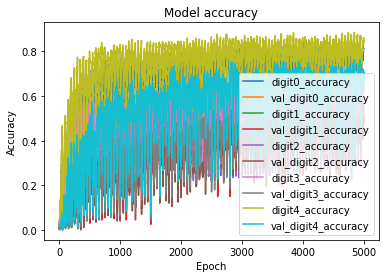

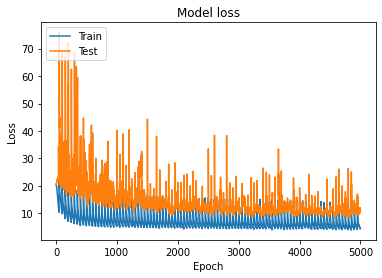

In [14]:


print(history.history)
plot_diagram()

#    plot_diagram(
#        [history.history['digit%d_accuracy' % i] for i in range(5)],
#        #[history.history['digit%d_loss' % i] for i in range(5)],
#        [history.history['val_digit%d_accuracy' % i] for i in range(5)],
#        #[history.history['val_digit%d_loss' % i] for i in range(5)],
#        history.history['loss'],
#        history.history['val_loss'],
#    )


In [15]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

<ipython-input-15-c6ab7055161c>:8: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)


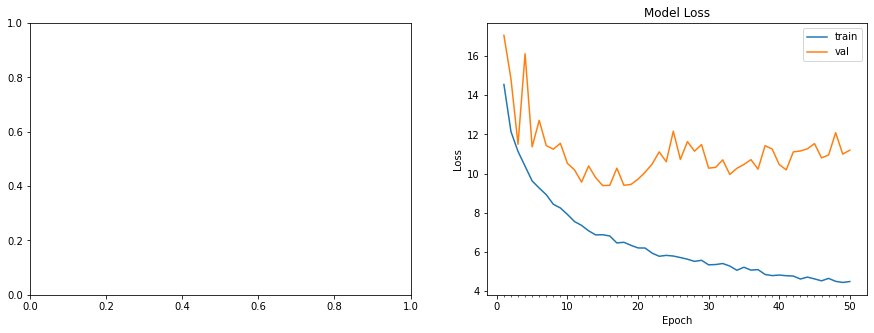

In [16]:
plot_model_history(history)

# Avaliar Dataset e Teste

In [17]:
# Leitura da pasta teste
n_dir = 'images/dataset_test';
files = read_name_files(files_dir = n_dir)
X_test, y_test = read_dataset_batch(symbols, files, captcha_dir = n_dir)
net.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])


0 imagens read
1/1 [==============================] - 0s 968us/step - loss: 15.2754 - digit0_loss: 3.8741 - digit1_loss: 3.0471 - digit2_loss: 3.5690 - digit3_loss: 3.6736 - digit4_loss: 1.1116 - digit0_accuracy: 0.3077 - digit1_accuracy: 0.5385 - digit2_accuracy: 0.3846 - digit3_accuracy: 0.5385 - digit4_accuracy: 0.7692


[15.275392532348633,
 3.874101161956787,
 3.0470738410949707,
 3.5690298080444336,
 3.6735894680023193,
 1.1115977764129639,
 0.3076923191547394,
 0.5384615659713745,
 0.38461539149284363,
 0.5384615659713745,
 0.7692307829856873]

In [18]:
# 7i4iB
def accuracy(x, y, model):
    
    y_d1 = np.argmax(y[0], axis=1);
    y_d2 = np.argmax(y[1], axis=1);
    y_d3 = np.argmax(y[2], axis=1);
    y_d4 = np.argmax(y[3], axis=1);
    y_d5 = np.argmax(y[4], axis=1);
    
    d1_num_correct = 0
    d2_num_correct = 0
    d3_num_correct = 0
    d4_num_correct = 0
    d5_num_correct = 0
    
    for i in range(x.shape[0]):
        capt, prop = predict(x[i], len(symbols))
        d1_num_correct = d1_num_correct + np.sum(capt[0] == symbols[y_d1[i]])
        d2_num_correct = d2_num_correct + np.sum(capt[1] == symbols[y_d2[i]])
        d3_num_correct = d3_num_correct + np.sum(capt[2] == symbols[y_d3[i]])
        d4_num_correct = d4_num_correct + np.sum(capt[3] == symbols[y_d4[i]])
        d5_num_correct = d5_num_correct + np.sum(capt[4] == symbols[y_d5[i]])
        
    
    num_samples = x.shape[0];
    num_caracteres = len(capt)*num_samples;
    num_correct = d1_num_correct + d2_num_correct + d3_num_correct + d4_num_correct + d5_num_correct
    
    d1_accuracy = float(d1_num_correct)/num_samples
    d2_accuracy = float(d2_num_correct)/num_samples
    d3_accuracy = float(d3_num_correct)/num_samples
    d4_accuracy = float(d4_num_correct)/num_samples
    d5_accuracy = float(d5_num_correct)/num_samples
    accuracy = float(num_correct)/num_caracteres
    
    return accuracy, d1_accuracy, d2_accuracy, d3_accuracy, d4_accuracy, d5_accuracy

In [19]:
#X_test = data_valid
#y_test = data_valid_target
#, y_test[1], y_test[2], y_test[3], y_test[4]
print ("Accuracy on test data is: %0.2f, acc_d1= %0.2f, acc_d2= %0.2f, acc_d3= %0.2f, acc_d4= %0.2f, acc_d5= %0.2f"%accuracy(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]], net))

Accuracy on test data is: 0.51, acc_d1= 0.31, acc_d2= 0.54, acc_d3= 0.38, acc_d4= 0.54, acc_d5= 0.77


--- Amostra #1 ---


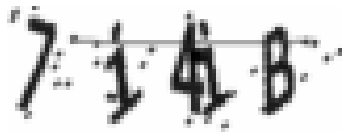

Predict: 7i4MB


--- Amostra #1 ---


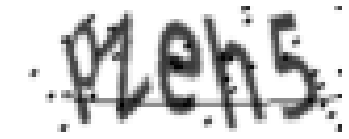

Predict: P4Eh5


--- Amostra #1 ---


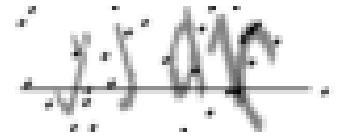

Predict: JJQYr




In [20]:
j = 1
for i in (0, 3, 5):
    print("--- Amostra #" + str(j) + " ---")    
    fig = plt.figure()
    img = X_test[i,:,:]
    img.shape = (30,80)    
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()
    capt, prop = predict(img, len(symbols))
    print("Predict: " + capt)
    print("\n")
    
#net.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])


--- Amostra #1 ---


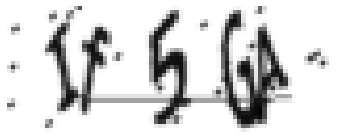

Predict: If5GA


--- Amostra #1 ---


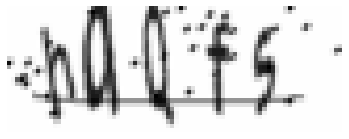

Predict: hqQfs


--- Amostra #1 ---


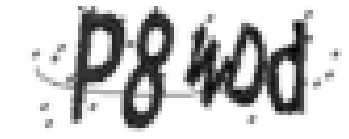

Predict: P8HDd




In [21]:
j = 1
for i in (1, 3, 5):
    print("--- Amostra #" + str(j) + " ---")    
    fig = plt.figure()
    img = X_train[i,:,:]
    img.shape = (30,80)    
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()
    capt, prop = predict(img, len(symbols))
    print("Predict: " + capt)
    print("\n")
    
#net.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])
